# Machine Learning Operations

Nadine Braun | nb155 | SoSe 2025

# Projekt New York Yellow Cab

---

# Inhaltsverzeichnis

## 1. Einleitung

## 2. Business Requirements (ML Canvas)

## 3. Daten

### 3.1 Datenquellen & Format

### 3.2 Datensatz laden

### 3.3 Data Dictionary

## 4. Feature Engineering

## 5. Explorative Datenanalyse (EDA)

### 5.1 Überblick über den Datensatz

### 5.2 Zielvariable analysieren: `trip_count`

## 6. Preprocessing

## 7. Feature Engineering 2.0

## 8. EDA 2.0

## 9. Modellentwicklung &-training

## 10. Evaluation & Drift-Analyse über Jahre

## 11. Aufbau einer Pipeline mit MLflow

### 11.1 Aufbau einer überwachbaren Modellpipeline

### 11.2 Monitoring

## 12. Erstellung UI mit Streamlit zum Starten der einzelnen Pipelines

## 13. Deployment

## 14. Ausblick

## 15. Lessons Learned

## 16. Projektrückblick

---

**Setup**

In [1]:
!pip install mlflow

In [140]:
!pip install xgboost lightgbm

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/5a/0b/f9f815f240a9610d42367172b9f7ef7e8c9113a09b1bb35d4d85f96b910a/xgboost-3.0.0-py3-none-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/21/1b/550ee378512b78847930f5d74228ca1fdba2a7fbdeaac9aeccc085b0e257/lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.1 MB/s eta 0:00:00


In [147]:
!pip install optuna

In [159]:
!pip install streamlit

  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/43/ff/f41cfaf1bb58223fe77ff87213a689f6c9c82f7363f9d7c879d294dbe985/streamlit-1.45.0-py3-none-any.whl.metadata
  Obtaining dependency information for altair<6,>=4.0 from https://files.pythonhosted.org/packages/aa/f3/0b6ced594e51cc95d8c1fc1640d3623770d01e4969d29c0bd09945fafefa/altair-5.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for blinker<2,>=1.5.0 from https://files.pythonhosted.org/packages/10/cb/f2ad4230dc2eb1a74edf38f1a38b9b52277f75bef262d8908e60d957e13c/blinker-1.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for pydeck<1,>=0.8.0b4 from https://files.pythonhosted.org/packages/ab/4c/b888e6cf58bd9db9c93f40d1c6be8283ff49d88919231afe93a6bcf61626/pydeck-0.9.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for narwhals>=1.14.2 from https://files.pythonhosted.org/packages/56/45/59251121eb801f033ffdd56d8893a0f20ec661bdc362f8d52a4e4d547f91/n

In [160]:
import pandas as pd
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
from datetime import datetime
import glob
import mlflow
from pathlib import Path
from tqdm import tqdm
import hashlib
from scipy import stats
import numpy as np
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import optuna
from xgboost import XGBRegressor
import streamlit as st
import subprocess

---

## 1. Einleitung

Im Rahmen dieses Projekts wurde ein praxisnahes Anwendungsszenario aus dem Bereich der städtischen Mobilität gewählt, um typische Aufgabenstellungen und Herausforderungen moderner Machine-Learning-Prozesse im Kontext von MLOps zu erproben. Am Beispiel historischer Yellow-Cab-Fahrtdaten aus New York City wurde untersucht, wie sich stündliche Nachfragebewegungen im Taxiverkehr datenbasiert analysieren und modellieren lassen.

Der Fokus liegt dabei weniger auf der Optimierung eines einzelnen Modells im Sinne maximaler Vorhersagegenauigkeit, sondern vielmehr auf der strukturierten Umsetzung eines vollständigen ML-Prozesses: von der Datenvorverarbeitung über das Feature Engineering und das Training mehrerer Modellvarianten bis hin zur Evaluation, dem Logging mit MLflow und der Bereitstellung eines nutzbaren Interfaces mittels Streamlit. Die über den Projektverlauf gewonnenen Erfahrungen – insbesondere im Umgang mit Tools und Prozessen – stehen dabei im Vordergrund und bilden einen wesentlichen Bestandteil der Lessons Learned.

Konkret soll ein Modell entwickelt werden, das in der Lage ist, die Anzahl an Taxifahrten pro Stunde vorherzusagen. Grundlage hierfür sind aggregierte Zeitfenster (Stunden-Buckets), in denen zentrale Kenngrößen wie Fahrtenanzahl, Strecke, Dauer, Passagierzahlen und Fahrpreis summiert vorliegen. Diese strukturierte Aggregation soll die Basis für eine belastbare Vorhersage bilden.

Das Projekt gliedert sich in mehrere logisch aufeinander folgende Abschnitte, die gemeinsam einen vollständigen Machine-Learning-Workflow abbilden. Zunächst erfolgt eine explorative Analyse der Rohdaten, bei der sowohl inhaltliche Besonderheiten als auch technische Anforderungen wie Datenmengen, Struktur und Qualität untersucht werden. Darauf aufbauend wird ein Aggregationsschema entwickelt, das sämtliche Fahrten in stündliche Zeitfenster (Time Buckets) überführt. Für jedes dieser Intervalle werden relevante Kenngrößen – darunter die Anzahl der Fahrten, die gesamte Fahrtdistanz, die Summe der Passagiere, der generierte Fahrpreis sowie die kumulierte Dauer – berechnet und zusammengefasst.

Anschließend werden verschiedene Regressionsmodelle implementiert, trainiert und hinsichtlich ihrer Leistungsfähigkeit bewertet. Neben klassischen Metriken wie dem Root Mean Squared Error (RMSE) oder dem R²-Wert liegt ein besonderes Augenmerk auf der zeitlichen Stabilität der Vorhersagen. Zu diesem Zweck wird der Trainingszeitraum (2009–2014) vom Evaluationszeitraum (2015–2017) getrennt, um gegebenenfalls auch potenzielle Effekte von Data und Concept Drift sichtbar zu machen.

Im weiteren Verlauf wird MLflow in den Entwicklungsprozess integriert, um Modellparameter, Metriken und Versionen systematisch zu erfassen. Diese Nachvollziehbarkeit ermöglicht es, verschiedene Modellstände transparent zu vergleichen und fundierte Entscheidungen hinsichtlich der Modellwahl zu treffen. Abschließend wird mithilfe von Streamlit eine benutzerfreundliche Oberfläche erstellt, über die sich das Vorhersagemodell interaktiv bedienen lässt. Dadurch wird der gesamte Workflow – von der Datenverarbeitung bis zur Nutzung des Modells – für Dritte zugänglich und erlebbar gemacht.

---

## 2. Business Requirements (ML Canvas)

Bevor mit der technischen Umsetzung des Projekts begonnen wurde, war es wichtig, sich zunächst mit den übergeordneten Zielen, Anforderungen und Rahmenbedingungen auseinanderzusetzen. Hierfür wurde ein sogenannter Machine Learning Canvas eingesetzt, der dabei hilft, das Projekt strukturiert vorzudenken und zentrale Aspekte von Anfang an festzuhalten.

Der Canvas bietet eine einfache Möglichkeit, die fachliche Problemstellung, den gewünschten Nutzen, mögliche Datenquellen, erste Modellideen sowie potenzielle Herausforderungen gemeinsam zu betrachten. So entsteht ein umfassender Überblick, der nicht nur den inhaltlichen Kontext abbildet, sondern auch Anforderungen aus Sicht eines langfristig tragfähigen MLOps-Prozesses berücksichtigt. Gerade bei komplexeren Projekten mit mehreren Komponenten kann dies als Einstieg helfen, spätere Entwicklungsschritte zielgerichteter und besser aufeinander abgestimmt umzusetzen.

**Background**  
Die Nachfrage im städtischen Verkehr unterliegt starken zeitlichen Schwankungen. Für Taxiunternehmen oder Mobilitätsplattformen ist es daher wichtig, die Auslastung möglichst genau vorherzusagen. Historische Fahrtdaten der Yellow Cabs in New York City bieten eine solide Grundlage, um typische Nachfrageverläufe stundenweise zu modellieren.

**Value Proposition**  
Ein datenbasiertes Vorhersagemodell kann helfen, betriebliche Entscheidungen (z. B. Fahrzeugverteilung, Personalplanung) besser abzustimmen. Auch andere städtische Akteure können von einem besseren Verständnis des Mobilitätsverhaltens profitieren, etwa in der Verkehrsplanung oder beim Infrastrukturmanagement.

**Objectives**  
Ziel ist es, ein ML-Modell zu entwickeln, das die Anzahl an Fahrten pro Stunde prognostiziert. Dabei stehen neben der reinen Modellleistung auch die strukturelle Umsetzung, Tool-Nutzung (MLflow, Streamlit) und die Analyse möglicher Veränderungen im Datenverhalten (Data/Concept Drift) im Fokus.

**Solution**  
Die Lösung besteht aus einem Regressionsmodell auf Basis aggregierter Zeitfenster (Stunden-Buckets), ergänzt um eine Benutzeroberfläche zur interaktiven Nutzung. Die Umsetzung umfasst die vollständige ML-Pipeline: Datenaufbereitung, Feature Engineering, Modelltraining, Logging, Evaluation und Interface.

**Feasibility**  
Die technischen Anforderungen sind durch die Nutzung etablierter Open-Source-Tools gut umsetzbar. Das Projekt wird lokal durchgeführt, die Datengrundlage ist öffentlich verfügbar. Grundkenntnisse in Datenanalyse, ML und Python sind vorhanden. Einschränkungen ergeben sich v. a. durch Rechenzeit und Speicherkapazität.

**Data**  
Verwendet werden Yellow-Taxi-Fahrtdaten der Jahre 2009–2017. Die Aggregation erfolgt auf Stundenebene. Für jede Zeiteinheit werden zentrale Merkmale wie Trip-Anzahl, Strecke, Passagiere, Fahrzeit und Preis berechnet. Ein manuelles Labeling ist nicht notwendig, da die Zielvariable (Trip Count) direkt vorliegt.

**Modeling**  
Zum Einsatz kommen verschiedene Regressionsverfahren (z. B. Linear Regression, Random Forest, XGBoost). Die Modellwahl erfolgt iterativ auf Basis von Vergleichsexperimenten, die mithilfe von MLflow dokumentiert werden. Feature-Auswahl und Hyperparameter werden systematisch angepasst und evaluiert.

**Feedback**  
Feedbackquellen sind vorrangig technischer Natur: Modellmetriken, Vergleich über Zeiträume hinweg sowie visuelles Feedback über die Oberfläche. Potenzielle Drift-Anzeichen werden durch abnehmende Modellgüte im Evaluationszeitraum identifiziert.

**Metrics**  
Zentrale Metriken sind RMSE und R² zur Bewertung der Modellgüte. Zusätzlich wird beobachtet, wie stabil die Metriken über verschiedene Zeiträume hinweg bleiben (Robustheit gegenüber Drift).

**Evaluation**  
Offline-Evaluation durch Aufteilung in Trainings- und Testzeiträume (2009–2014 / 2015–2017). Modelle werden über die Zeit hinweg verglichen, um etwaige Verschiebungen im Datenverhalten zu erkennen und einzuordnen.

**Inference**  
Die Anwendung erfolgt als Batch-Inferenz: Für vorliegende Stunden-Features werden die Trip Counts berechnet. Eine Echtzeitverarbeitung ist im Rahmen des Projekts nicht vorgesehen, jedoch denkbar bei späterer Erweiterung.

**Project**  
Das Projekt wird im Rahmen des Moduls MLOps-Seminars umgesetzt und in Einzelarbeit durchgeführt. Ziel ist die Entwicklung eines Prototyps zur stündlichen Vorhersage von Taxinachfrage auf Basis historischer NYC Yellow Cab Daten. Die Umsetzung umfasst sowohl technische als auch konzeptionelle Aspekte, mit besonderem Fokus auf Reproduzierbarkeit, Transparenz und Tool-Einsatz entlang des Machine-Learning-Lebenszyklus.

Alle Arbeitsschritte – von der Datenaufbereitung bis zur Modellbereitstellung – werden nachvollziehbar in einem GitHub-Repository dokumentiert. Grundalge für die Dokumentation ist jedoch das vorliegende Notebook. Dabei kommen verschiedene MLOps-Praktiken zum Einsatz, bspw. für das Logging (MLflow), das User Interface (Streamlit) sowie zur Strukturierung des Workflows.

Der Projektverlauf ist in sieben aufeinander aufbauende Phasen unterteilt:

- *Business Requirements* (Stichtag: 23.03.): Definition der Problemstellung, Zielsetzung und Nutzenanalyse mithilfe des ML Canvas.
- *Daten* (Stichtag: 30.03.): Beschaffung, Verständnis und erste Analyse der NYC Yellow Taxi Daten (Jahr 2024).
- *Feature Engineering* (Stichtag: 06.04.): Transformation der Rohdaten in geeignete Modellmerkmale.
- *Modellentwicklung* (Stichtag: 20.04.): Auswahl, Training und Optimierung eines Regressionsmodells.
- *Test* (Stichtag: 27.04.): Validierung der Modellleistung mit geeigneten Metriken und Daten.
- *Deployment* (Stichtag: 11.05.): Bereitstellung des Modells mithilfe einer MLOps-Plattform oder API.
- *Monitoring & Lessons Learned* (laufend): Beobachtung des Modells im Betrieb, Reflexion über den Entwicklungsprozess sowie Dokumentation der wichtigsten Erkenntnisse.

Den Abschluss bildet eine Präsentation, in der die Ergebnisse, Herausforderungen und mögliche Weiterentwicklungen vorgestellt werden. Der Fokus liegt dabei nicht nur auf dem fertigen Modell, sondern vor allem auf dem gewonnenen Verständnis für moderne Machine-Learning-Prozesse im produktionsnahen Umfeld.

---

## 3. Daten

Die Grundlage dieses Projekts bilden die Yellow Taxi Trip Records von New York City. Diese enthalten strukturierte Informationen zu einzelnen Taxifahrten und werden in monatlichen Dateien über mehrere Jahre hinweg veröffentlicht.

Ziel ist es, aus diesen Rohdaten ein konsistentes Datenschema zu erarbeiten und aggregierte Merkmale auf Stundenebene zu erzeugen, die als Eingabe für das spätere Vorhersagemodell dienen. Um Struktur, Inhalt und technische Eigenschaften der Datensätze besser zu verstehen, erfolgt zunächst eine Analyse einzelner Monatsdateien, bevor die vollständige Verarbeitung der Trainings- und Testzeiträume durchgeführt wird.

Die folgenden Abschnitte befassen sich zunächst mit den verwendeten Quellen und Formaten (3.1), dem Laden einzelner Datensätze (3.2) sowie der Definition und Beschreibung der relevanten Merkmale in einem Data Dictionary (3.3).

### 3.1 Datenquellen & Format

Die in diesem Projekt verwendeten Daten stammen aus dem offiziellen Open-Data-Portal der Stadt New York und werden von der Taxi and Limousine Commission (TLC) bereitgestellt. (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page#) Es handelt sich dabei um die sogenannten „Yellow Taxi Trip Records“, die monatlich im Parquet-Format veröffentlicht werden. Die Datensätze enthalten strukturierte Informationen zu Fahrten der Yellow Cabs in New York City, darunter Zeitangaben, Fahrtdistanz, Fahrpreis, Anzahl der Passagiere, geografische Koordinaten sowie die verwendete Zahlungsart.

Die Daten liegen in monatlichen Einzeldateien vor, deren Benennung einem standardisierten Schema folgt:  
`yellow_tripdata_YYYY-MM.parquet`, wobei `YYYY` für das Jahr und `MM` für den jeweiligen Monat steht. Das verwendete Parquet-Format ist spaltenbasiert, was sowohl speichereffizient als auch für die Verarbeitung großer Datenmengen besonders geeignet ist.

Für dieses Projekt wurden alle verfügbaren Monatsdateien aus den Jahren 2009 bis einschließlich 2017 lokal gespeichert. Diese bilden die Grundlage für alle weiteren Analysen. Die spätere Aggregation der Fahrten erfolgt auf Stundenebene, sogenannten „Time Buckets“, und basiert auf dem Abholzeitpunkt (`Trip_Pickup_DateTime`), der aus jeder Fahrt extrahiert wird.

Da sich Struktur und Spaltennamen über die Jahre hinweg stellenweise geändert haben, wird in den folgenden Schritten zunächst eine explorative Analyse einzelner Monatsdateien durchgeführt. Ziel ist es, ein konsistentes und belastbares Datenschema zu definieren, das für die gesamte Zeitreihe verwendet werden kann.

### 3.2 Datensatz laden

Da die Yellow Taxi Trip-Daten der Stadt New York monatlich veröffentlicht werden, liegt jede Datei getrennt nach Monat vor. Um sicherzustellen, dass die Daten korrekt formatiert und für die weitere Analyse geeignet sind, wird im ersten Schritt exemplarisch eine einzelne Datei – der Monat Januar – geladen und geprüft.

Dieses Vorgehen ermöglicht einen ersten Überblick über Struktur, Inhalt und potenzielle Besonderheiten der Daten. Ziel ist es, mögliche Unstimmigkeiten frühzeitig zu erkennen, bevor die vollständige Verarbeitung beginnt. Erst nachdem sichergestellt ist, dass die Beispieldatei erfolgreich eingelesen werden kann und die enthaltenen Werte plausibel erscheinen, wird das Laden der restlichen Monatsdateien automatisiert angestoßen.

Die Dateien liegen lokal im selben Verzeichnis wie das Jupyter Notebook und folgen einem einheitlichen Namensschema (z. B. `yellow_tripdata_2009-01.parquet` bis `yellow_tripdata_2009-12.parquet`). Mithilfe einer Schleife können die Dateien effizient geladen und in einem gemeinsamen DataFrame zusammengeführt werden, der als Grundlage für die spätere Aggregation dient.

**Testlauf mit einem Monat**

In [3]:
filename = "yellow_tripdata_2009-01.parquet"

df_jan09 = pd.read_parquet(filename)

print(f"Anzahl Zeilen: {len(df_jan09):,}")
print("\nSpaltenübersicht:")
print(df_jan09.columns.tolist())

df_jan09.head()

Anzahl Zeilen: 14,092,413

Spaltenübersicht:
['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime', 'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat', 'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type', 'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt', 'Total_Amt']


,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,NaN,NaN,-73.993803,40.695922,CASH,8.9,0.5,NaN,0.00,0.0,9.40
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,NaN,NaN,-73.955850,40.768030,Credit,12.1,0.5,NaN,2.00,0.0,14.60
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,NaN,NaN,-73.869983,40.770225,Credit,23.7,0.0,NaN,4.74,0.0,28.44
3,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,-73.974267,40.790955,NaN,NaN,-73.996558,40.731849,CREDIT,14.9,0.5,NaN,3.05,0.0,18.45
4,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,-74.001580,40.719382,NaN,NaN,-74.008378,40.720350,CASH,3.7,0.0,NaN,0.00,0.0,3.70


Bereits beim Laden der Daten für einen einzelnen Monat, hier Januar 2019, zeigt sich das große Volumen des zugrunde liegenden Datensatzes: Es wurden über 14 Millionen Einträge verarbeitet, wobei jede Zeile eine einzelne Taxifahrt repräsentiert. Insgesamt umfasst der Datensatz 18 Spalten mit unterschiedlichen Fahrtdetails.

Die wichtigsten Merkmale beinhalten unter anderem:
- den Abhol- und Absetzzeitpunkt (`Trip_Pickup_DateTime`, `Trip_Dropoff_DateTime`),
- die Anzahl der Passagiere (`Passenger_Count`),
- die zurückgelegte Strecke in Meilen (`Trip_Distance`),
- Start- und Zielkoordinaten (`Start_Lon`, `Start_Lat`, `End_Lon`, `End_Lat`),
- die gewählte Zahlungsart (`Payment_Type`) sowie
- verschiedene Preisbestandteile (`Fare_Amt`, `Tip_Amt`, `Tolls_Amt`, `Total_Amt`).

Weitere Spalten wie `vendor_name`, `store_and_forward` oder `Rate_Code` enthalten Zusatzinformationen zur Fahrt oder zum Erhebungsprozess. Die Spaltenstruktur erscheint im Grundsatz konsistent, allerdings weisen einige Felder vereinzelt fehlende Werte auf, insbesondere bei optionalen Angaben wie dem Trinkgeld oder den Mautkosten.

Die Zeitstempel sind im Datums-Zeit-Format gespeichert und bilden die Grundlage für die spätere Aggregation auf Stundenebene.

In [4]:
df_jan09.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14092413 entries, 0 to 14092412
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   vendor_name            object 
 1   Trip_Pickup_DateTime   object 
 2   Trip_Dropoff_DateTime  object 
 3   Passenger_Count        int64  
 4   Trip_Distance          float64
 5   Start_Lon              float64
 6   Start_Lat              float64
 7   Rate_Code              float64
 8   store_and_forward      float64
 9   End_Lon                float64
 10  End_Lat                float64
 11  Payment_Type           object 
 12  Fare_Amt               float64
 13  surcharge              float64
 14  mta_tax                float64
 15  Tip_Amt                float64
 16  Tolls_Amt              float64
 17  Total_Amt              float64
dtypes: float64(13), int64(1), object(4)
memory usage: 1.9+ GB


Ein Blick auf die Struktur des geladenen DataFrames bestätigt das große Volumen des Datensatzes: Die Datei umfasst über 14 Millionen Zeilen und 18 Spalten. Im Arbeitsspeicher belegt der Datensatz rund 1,9 GB.

Der überwiegende Teil der Spalten enthält numerische Werte im `float64`-Format (13 Spalten), ergänzt um eine Spalte mit dem Format `int64` sowie vier Spalten mit dem Datentyp `object`, in denen textuelle oder zeitliche Informationen gespeichert sind.

Besondere Aufmerksamkeit gilt den beiden Zeitspalten `Trip_Pickup_DateTime` und `Trip_Dropoff_DateTime`. Diese liegen aktuell noch als Zeichenketten im `object`-Format vor und werden in den nächsten Schritten in echte `datetime`-Objekte umgewandelt. Auf dieser Basis lassen sich dann weitere zeitbezogene Merkmale ableiten, etwa Datum, Wochentag oder Stunde der Fahrt.

Die Größe und Struktur des Datensatzes zeigt nochmal die Notwendigkeit einer effizienten Vorverarbeitung und Aggregation, bevor mit der eigentlichen Modellierung begonnen werden kann.

**Erste Übersicht - Laden des Jahres 2019**

Da die Yellow Taxi Trip-Daten der Stadt New York mit einem zeitlichen Verzug von etwa zwei Monaten veröffentlicht werden, liegen sie jeweils monatsweise als separate Dateien vor. Für dieses Projekt wurden die Parquet-Dateien der Jahre 2009 bis 2014 (Trainingszeitraum) sowie der Jahre 2015 bis 2017 (Kontrollzeitraum) im Vorfeld lokal gespeichert. Alle Dateien befinden sich im selben Verzeichnis wie das Jupyter Notebook.

Der Ladevorgang erfolgt automatisiert über eine Schleife, sodass die einzelnen Monatsdateien nicht manuell eingelesen werden müssen. Die Benennung der Dateien folgt einem einheitlichen Schema (`yellow_tripdata_YYYY-MM.parquet`), was die strukturierte und reproduzierbare Verarbeitung erleichtert. Alle geladenen Dateien werden zu einem gemeinsamen DataFrame zusammengeführt und stehen anschließend gesammelt für Analyse und Modellierung zur Verfügung.

In einem ersten Schritt wird exemplarisch das Jahr 2009 geladen. Dieses dient als Grundlage für die Entwicklung der Aggregationslogik, mit der die Rohdaten anschließend auf Stundenebene („Time Buckets“) verdichtet werden.

Zunächst wird das Jahr definiert, für welches die Daten geladen werden sollen.

In [5]:
year = 2009

Im nächsten Schritt wir eine Liste der Monate erstellt, dabei muss berücksichtigt werden, dass diese immer zweistellig sind, z.B. 01 für Januar. Die Liste endet mit 12, da es nur 12 Monate gibt.

In [6]:
months = [f"{i:02d}" for i in range(1, 13)]

Dann wird eine leere Liste für die Dataframes erstellt.

In [7]:
dfs = []

Mit Hilfe einer for-Schleife werden die Monatsdateien geladen und der zuvor erstellten, leeren Liste hinzugefügt. Zusätzlich wird in diesem Schritt eine Ausgabe ergänzt, sollte die erforderliche Datei nicht gefunden werden. 

In [8]:
for month in months:
    filename = f"yellow_tripdata_{year}-{month}.parquet"
    
    if os.path.exists(filename):
        print(f"Lade Datei: {filename}")
        df_month = pd.read_parquet(filename)
        dfs.append(df_month)
    else:
        print(f"Datei nicht gefunden: {filename}")

Lade Datei: yellow_tripdata_2009-01.parquet
Lade Datei: yellow_tripdata_2009-02.parquet
Lade Datei: yellow_tripdata_2009-03.parquet
Lade Datei: yellow_tripdata_2009-04.parquet
Lade Datei: yellow_tripdata_2009-05.parquet
Lade Datei: yellow_tripdata_2009-06.parquet
Lade Datei: yellow_tripdata_2009-07.parquet
Lade Datei: yellow_tripdata_2009-08.parquet
Lade Datei: yellow_tripdata_2009-09.parquet
Lade Datei: yellow_tripdata_2009-10.parquet
Lade Datei: yellow_tripdata_2009-11.parquet
Lade Datei: yellow_tripdata_2009-12.parquet


Schließlich werden die einzelnen Monats-Dataframes zu einem Jahres-Dataframe zusammengefasst. Mit einer Erfolgsausgabe wird dies dann bestätigt und zusätzlich werden noch die Anzahl der Fahrten (Zeilenanzahl) sowie die Anzahl der Spalten ausgegeben.

In [9]:
df_2009 = pd.concat(dfs, ignore_index=True)

print(f"Gesamtdatensatz für {year} erfolgreich geladen.")
print(f"Anzahl Fahrten: {len(df_2009):,}")
print(f"Anzahl Spalten: {len(df_2009.columns)}")

Gesamtdatensatz für 2009 erfolgreich geladen.
Anzahl Fahrten: 170,896,055
Anzahl Spalten: 18


Das Jahr 2009 konnte erfolgreich geladen werden, insgesamt enthält wurden 170.896.055 Datensätze, entspricht einzelnen Fahrten, geladen. Diese sind bisher noch nicht aggreggiert. Zunächst werden mit Hilfe von einigen Funktionen Ausgaben erstellt um mehr Infos zu dem Dataframe zu bekommen.

In [10]:
df_2009.head()

,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,NaN,NaN,-73.993803,40.695922,CASH,8.9,0.5,NaN,0.00,0.0,9.40
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,NaN,NaN,-73.955850,40.768030,Credit,12.1,0.5,NaN,2.00,0.0,14.60
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,NaN,NaN,-73.869983,40.770225,Credit,23.7,0.0,NaN,4.74,0.0,28.44
3,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,-73.974267,40.790955,NaN,NaN,-73.996558,40.731849,CREDIT,14.9,0.5,NaN,3.05,0.0,18.45
4,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,-74.001580,40.719382,NaN,NaN,-74.008378,40.720350,CASH,3.7,0.0,NaN,0.00,0.0,3.70


In [11]:
df_2009.tail()

,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt
170896050,VTS,2009-12-26 14:06:00,2009-12-26 14:13:00,1,0.95,-73.979943,40.775545,NaN,NaN,-73.979182,40.765658,CASH,5.7,0.0,0.5,0.0,0.0,6.2
170896051,VTS,2009-12-26 21:40:00,2009-12-26 21:59:00,5,6.97,-74.017145,40.705885,NaN,NaN,-73.971427,40.782797,CASH,18.5,0.5,0.5,0.0,0.0,19.5
170896052,VTS,2009-12-05 11:13:00,2009-12-05 11:16:00,1,0.88,-73.975970,40.752222,NaN,NaN,-73.966812,40.763617,CASH,4.5,0.0,0.5,0.0,0.0,5.0
170896053,VTS,2009-12-26 18:48:00,2009-12-26 18:52:00,5,0.65,-73.955460,40.779757,NaN,NaN,-73.950940,40.775177,CASH,4.5,0.0,0.5,0.0,0.0,5.0
170896054,VTS,2009-12-26 16:15:00,2009-12-26 16:26:00,1,1.54,-73.978990,40.764067,NaN,NaN,-73.989483,40.752130,CASH,7.7,0.0,0.5,0.0,0.0,8.2


### 3.3 Data Dictionary

Für die Yellow-Taxi-Daten der Stadt New York liegt ein offizielles Data Dictionary der Taxi and Limousine Commission (TLC) vor. (https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)
Dieses beschreibt die Bedeutung und Struktur der einzelnen Variablen, die in den standardisierten Fahrtdatensätzen enthalten sind und über das Open-Data-Portal bereitgestellt werden.

Das aktuell verfügbare Dictionary bezieht sich jedoch auf spätere Jahrgänge – insbesondere ab etwa 2015 –, in denen die Datenstruktur im Rahmen einer Systemumstellung erweitert und vereinheitlicht wurde. Dazu zählen unter anderem die Einführung kodierter Felder wie `VendorID`, `payment_type` oder die standardisierten Taxi-Zonen-IDs `PULocationID` und `DOLocationID`.

Im hier verwendeten Datensatz aus dem Jahr 2009 sind viele dieser Felder noch nicht enthalten. Stattdessen finden sich Vorgänger oder leichte Varianten, z.B.:

- `vendor_name` anstelle von `VendorID`
- `Trip_Pickup_DateTime` statt `tpep_pickup_datetime`
- fehlende Taxi-Zonen-IDs (`PULocationID`, `DOLocationID`), da Zonen erst später eingeführt wurden
- textuelle Angabe der Zahlungsart (`Payment_Type`) statt numerischer Kodierung (`payment_type`)
- keine Zusatzgebühren wie `improvement_surcharge`, `congestion_surcharge` oder `airport_fee`, da diese damals noch nicht erhoben wurden

Diese Unterschiede machen deutlich, dass das offizielle Data Dictionary nur bedingt auf das Jahr 2009 übertragbar ist.



| Spaltenname               | Typ      | Beschreibung |
|---------------------------|----------|--------------|
| `VendorID`                | int      | Identifikationscode des Anbieters des Fahrtprotokolls (z. B. 1 = Creative Mobile Technologies, 2 = Curb) |
| `tpep_pickup_datetime`    | datetime | Zeitpunkt, an dem der Taxameter aktiviert wurde (Fahrtbeginn) |
| `tpep_dropoff_datetime`   | datetime | Zeitpunkt, an dem der Taxameter deaktiviert wurde (Fahrtende) |
| `passenger_count`         | int      | Anzahl der Passagiere |
| `trip_distance`           | float    | Fahrstrecke in Meilen |
| `RatecodeID`              | int      | Tarifcode (z. B. 1 = Standard, 2 = JFK Pauschale, 5 = verhandelt) |
| `store_and_fwd_flag`      | string   | Kennzeichnung, ob die Fahrt gespeichert und später übertragen wurde (Y/N) |
| `PULocationID`            | int      | Abholort als NYC Taxi Zone ID |
| `DOLocationID`            | int      | Zielort als NYC Taxi Zone ID |
| `payment_type`            | int      | Kodierung der Zahlungsart (z. B. 1 = Kreditkarte, 2 = Bar, 3 = Keine Gebühr) |
| `fare_amount`             | float    | Grundfahrpreis laut Taxameter (Zeit + Strecke) |
| `extra`                   | float    | Diverse Aufschläge (z. B. Nachtzuschlag, Rush Hour) |
| `mta_tax`                 | float    | Pauschaler Zuschlag für die Metropolitan Transportation Authority |
| `tip_amount`              | float    | Trinkgeldbetrag (nur bei Kartenzahlung erfasst) |
| `tolls_amount`            | float    | Gesamtbetrag für Mautgebühren |
| `improvement_surcharge`   | float    | Zuschlag zur Fahrpreiserhöhung, eingeführt 2015 |
| `total_amount`            | float    | Gesamtkosten der Fahrt (inkl. Zuschläge, exkl. Bargeld-Trinkgeld) |
| `congestion_surcharge`    | float    | Zuschlag für Fahrten in bestimmten Bereichen Manhattans (seit 2019) |
| `airport_fee`             | float    | Flughafengebühr für Fahrten ab JFK oder LaGuardia (seit 2020) |
| `cbd_congestion_fee`      | float    | MTA-Zuschlag für Congestion-Zone innerhalb Manhattans (ab 2025) |

> Hinweis: Einige dieser Felder sind in älteren Datenjahren (z. B. 2009–2014) noch nicht enthalten, da sie erst durch Systemumstellungen, regulatorische Änderungen oder neue Abrechnungsmodelle eingeführt wurden.

In [12]:
print(f"Datensatz enthält {df_2009.shape[0]:,} Zeilen und {df_2009.shape[1]} Spalten.\n")

df_2009.info()

Datensatz enthält 170,896,055 Zeilen und 18 Spalten.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170896055 entries, 0 to 170896054
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   vendor_name            object 
 1   Trip_Pickup_DateTime   object 
 2   Trip_Dropoff_DateTime  object 
 3   Passenger_Count        int64  
 4   Trip_Distance          float64
 5   Start_Lon              float64
 6   Start_Lat              float64
 7   Rate_Code              float64
 8   store_and_forward      float64
 9   End_Lon                float64
 10  End_Lat                float64
 11  Payment_Type           object 
 12  Fare_Amt               float64
 13  surcharge              float64
 14  mta_tax                float64
 15  Tip_Amt                float64
 16  Tolls_Amt              float64
 17  Total_Amt              float64
dtypes: float64(13), int64(1), object(4)
memory usage: 22.9+ GB


---

## 4. Feature Engineering

Nach dem erfolgreichen Laden und ersten Verständnis der Rohdaten folgt im nächsten Schritt das Feature Engineering. Ziel ist es, aus den einzelnen Fahrten strukturierte und modellierbare Merkmale abzuleiten, die als Grundlage für die spätere Vorhersage dienen.

Ein zentraler Bestandteil ist dabei die Aggregation der Daten auf *Stundenebene*. Hierfür werden sogenannte Zeit-Buckets gebildet, in denen alle Fahrten innerhalb einer bestimmten Stunde eines Kalendertags zusammengefasst werden. Für jedes dieser stündlichen Intervalle werden relevante Kenngrößen berechnet, unter anderem:

- die Gesamtanzahl an Fahrten (Zielvariable),
- die summierte Fahrdistanz aller Fahrten innerhalb der Stunde,
- die Summe der Fahrtpreise,
- die Anzahl beförderter Passagiere,
- die kumulierte Fahrtdauer,
- sowie optional der Anteil bestimmter Zahlungsarten (z. B. Kreditkarte).

Ergänzend werden zeitbezogene Kontextmerkmale wie Stunde des Tages, Wochentag oder Monat extrahiert, um wiederkehrende Muster im zeitlichen Verlauf erfassen zu können.

Die resultierenden Merkmale dienen als Grundlage für die nachfolgende Modellierung.

**Aggregation auf Stundenebene (Time Buckets)**

Im nächsten Schritt wird eine Funktion definiert, die automatisiert die Aggregation der Fahrtdaten auf Stundenebene für ein gesamtes Jahr durchführt. Aus Effizienzgründen werden dabei ausschließlich die für die Aggregation relevanten Spalten geladen: Abhol- und Absetzzeitpunkt, Fahrdistanz, Fahrpreis, Passagieranzahl und Zahlungsart.

Für jeden der zwölf Monate wird geprüft, ob die entsprechende Datei lokal verfügbar ist. Falls ja, wird sie eingelesen und verarbeitet. Der Abholzeitpunkt (`Trip_Pickup_DateTime`) wird in ein Datetime-Format überführt und auf die volle Stunde gerundet, um einen sogenannten Zeit-Bucket zu erzeugen. Aus Abhol- und Absetzzeit wird zusätzlich die jeweilige Fahrtdauer in Minuten berechnet.

Anschließend erfolgt die stündliche Aggregation: Für jedes Zeitintervall werden die Gesamtanzahl der Fahrten, die summierte Strecke, die Gesamtanzahl an Passagieren, der Gesamtfahrpreis sowie die gesamte Fahrtdauer berechnet. Zusätzlich wird der Anteil der Kreditkartenzahlungen innerhalb des jeweiligen Zeitfensters bestimmt.

Die aggregierten Monatsdaten werden zu einem gemeinsamen Jahres-Datensatz zusammengeführt. Ergänzend werden zeitbezogene Kontextmerkmale wie Stunde, Wochentag, Monat und Jahr aus dem Zeitstempel extrahiert. Das Ergebnis ist ein kompakter und bereinigter DataFrame auf Stundenebene, der die Grundlage für das nachfolgende Modelltraining bildet.

In [13]:
def aggregate_year_to_hourly(year, path="./"):
    months = [f"{i:02d}" for i in range(1, 13)]
    dfs = []

    relevant_cols = [
        "Trip_Pickup_DateTime",
        "Trip_Dropoff_DateTime",
        "Trip_Distance",
        "Fare_Amt",
        "Passenger_Count",
        "Payment_Type"
    ]

    for month in months:
        filename = os.path.join(path, f"yellow_tripdata_{year}-{month}.parquet")

        if os.path.exists(filename):
            print(f"Lade Datei: {filename}")
            df = pd.read_parquet(filename, columns=relevant_cols)

            df["pickup_dt"] = pd.to_datetime(df["Trip_Pickup_DateTime"])
            df["dropoff_dt"] = pd.to_datetime(df["Trip_Dropoff_DateTime"], errors="coerce")

            df["trip_duration"] = (df["dropoff_dt"] - df["pickup_dt"]).dt.total_seconds() / 60

            df["pickup_hour"] = df["pickup_dt"].dt.floor("H")

            df["Payment_Type"] = df["Payment_Type"].astype(str).str.lower()

            agg = df.groupby("pickup_hour").agg(
                trip_count=("Trip_Distance", "count"),
                total_distance=("Trip_Distance", "sum"),
                total_fare=("Fare_Amt", "sum"),
                total_passengers=("Passenger_Count", "sum"),
                total_duration=("trip_duration", "sum"),
                pct_credit_card=("Payment_Type", lambda x: (x == "credit").mean())
            ).reset_index()

            agg["hour"] = agg["pickup_hour"].dt.hour
            agg["weekday"] = agg["pickup_hour"].dt.weekday
            agg["month"] = agg["pickup_hour"].dt.month
            agg["year"] = agg["pickup_hour"].dt.year

            dfs.append(agg)

        else:
            print(f"Datei nicht gefunden: {filename}")

    if dfs:
        df_year = pd.concat(dfs, ignore_index=True)
        print(f"{year}: {len(df_year)} Stundenblöcke aggregiert.")
        return df_year
    else:
        print(f"Keine Daten für Jahr {year} geladen.")
        return pd.DataFrame()

In [14]:
df_2009_hourly = aggregate_year_to_hourly(2009)
df_2009_hourly.head()

Lade Datei: ./yellow_tripdata_2009-01.parquet
Lade Datei: ./yellow_tripdata_2009-02.parquet
Lade Datei: ./yellow_tripdata_2009-03.parquet
Lade Datei: ./yellow_tripdata_2009-04.parquet
Lade Datei: ./yellow_tripdata_2009-05.parquet
Lade Datei: ./yellow_tripdata_2009-06.parquet
Lade Datei: ./yellow_tripdata_2009-07.parquet
Lade Datei: ./yellow_tripdata_2009-08.parquet
Lade Datei: ./yellow_tripdata_2009-09.parquet
Lade Datei: ./yellow_tripdata_2009-10.parquet
Lade Datei: ./yellow_tripdata_2009-11.parquet
Lade Datei: ./yellow_tripdata_2009-12.parquet
2009: 8760 Stundenblöcke aggregiert.


,pickup_hour,trip_count,total_distance,total_fare,total_passengers,total_duration,pct_credit_card,hour,weekday,month,year
0,2009-01-01 00:00:00,15386,42767.90,158699.60,26375,181823.316667,0.131678,0,3,1,2009
1,2009-01-01 01:00:00,16990,50278.51,183660.64,29285,210871.900000,0.138140,1,3,1,2009
2,2009-01-01 02:00:00,15585,48376.14,171685.91,26178,188450.200000,0.153673,2,3,1,2009
3,2009-01-01 03:00:00,13307,42613.80,147888.60,21885,157156.483333,0.161719,3,3,1,2009
4,2009-01-01 04:00:00,9619,32735.90,111752.42,15072,113270.150000,0.166545,4,3,1,2009


Nachdem die Aggregationsfunktion erfolgreich mit den Daten des Jahres 2009 getestet wurde und die erwarteten stündlichen Zeit-Buckets samt relevanter Summenkennzahlen erstellt hat, wird sie nun auf die weiteren Jahre im Trainingszeitraum (2010 bis 2014) angewendet.

Um Speicherressourcen effizient zu nutzen und die Verarbeitung nachvollziehbar zu gestalten, erfolgt die Aggregation weiterhin *jahrweise*. Für jedes Jahr werden die entsprechenden Monatsdateien geladen, auf Stundenebene aggregiert und in einem separaten DataFrame zusammengeführt. Die Ergebnisse werden anschließend lokal im Parquet-Format gespeichert, sodass sie bei Bedarf erneut geladen werden können – etwa für die spätere Modellierung oder zur Analyse möglicher Datenveränderungen (z. B. Data oder Concept Drift).

Dieser schrittweise, speicherbewusste Ansatz ermöglicht eine strukturierte und reproduzierbare Aufbereitung der historischen Daten. Gleichzeitig bereitet er die Grundlage für die spätere Zusammenführung aller Trainingsjahre in einem konsolidierten Gesamtbestand.

In [15]:
train_years = list(range(2009, 2015))

for year in train_years:
    df_year = aggregate_year_to_hourly(year)

    if not df_year.empty:
        filename = f"hourly_{year}.parquet"
        df_year.to_parquet(filename, index=False)
        print(f"Jahr {year} erfolgreich gespeichert unter: {filename}")
    else:
        print(f"Keine Daten gespeichert für Jahr {year}")

Lade Datei: ./yellow_tripdata_2009-01.parquet
Lade Datei: ./yellow_tripdata_2009-02.parquet
Lade Datei: ./yellow_tripdata_2009-03.parquet
Lade Datei: ./yellow_tripdata_2009-04.parquet
Lade Datei: ./yellow_tripdata_2009-05.parquet
Lade Datei: ./yellow_tripdata_2009-06.parquet
Lade Datei: ./yellow_tripdata_2009-07.parquet
Lade Datei: ./yellow_tripdata_2009-08.parquet
Lade Datei: ./yellow_tripdata_2009-09.parquet
Lade Datei: ./yellow_tripdata_2009-10.parquet
Lade Datei: ./yellow_tripdata_2009-11.parquet
Lade Datei: ./yellow_tripdata_2009-12.parquet
2009: 8760 Stundenblöcke aggregiert.
Jahr 2009 erfolgreich gespeichert unter: hourly_2009.parquet
Lade Datei: ./yellow_tripdata_2010-01.parquet


ArrowInvalid: No match for FieldRef.Name(Trip_Pickup_DateTime) in vendor_id: string
pickup_datetime: string
dropoff_datetime: string
passenger_count: int64
trip_distance: double
pickup_longitude: double
pickup_latitude: double
rate_code: string
store_and_fwd_flag: string
dropoff_longitude: double
dropoff_latitude: double
payment_type: string
fare_amount: double
surcharge: double
mta_tax: double
tip_amount: double
tolls_amount: double
total_amount: double
__fragment_index: int32
__batch_index: int32
__last_in_fragment: bool
__filename: string

Beim Versuch, weitere Jahresdaten ab 2010 zu laden, zeigte sich, dass sich die Spaltennamen in den Yellow-Taxi-Datensätzen je nach Jahrgang unterscheiden. Besonders bei älteren Dateien, etwa aus den Jahren 2009 oder 2010, finden sich abweichende Spalten-Bezeichnungen für zentrale Merkmale wie Zeitstempel oder Preisangaben. So wird der Abholzeitpunkt je nach Version beispielsweise als `Trip_Pickup_DateTime`, `pickup_datetime` oder `tpep_pickup_datetime` geführt.

Um die Aggregation dennoch robust und automatisierbar durchführen zu können, wurde die Aggregationsfunktion entsprechend erweitert. Sie arbeitet nun mit einem internen Spalten-Mapping, das vorhandene Spaltennamen auf einheitliche Standardbezeichnungen abbildet. Mithilfe von `pyarrow` wird vor dem Laden jeder Datei geprüft, welche Spalten enthalten sind. Auf dieser Basis kann die Zuordnung der relevanten Felder dynamisch angepasst werden.

Die Funktion lädt weiterhin ausschließlich die benötigten Spalten, was sowohl die Verarbeitung beschleunigt als auch den Speicherverbrauch reduziert. Durch diese Anpassungen ist es nun möglich, sämtliche historischen Jahresdaten effizient, automatisiert und stabil auf Stundenebene zu aggregieren – ohne manuell auf strukturelle Besonderheiten der einzelnen Jahrgänge reagieren zu müssen.

In [16]:
def aggregate_year_to_hourly(year, path="./"):
    months = [f"{i:02d}" for i in range(1, 13)]
    dfs = []

    for month in months:
        filename = os.path.join(path, f"yellow_tripdata_{year}-{month}.parquet")

        if os.path.exists(filename):
            print(f"Lade Datei: {filename}")
            
            all_columns = pq.ParquetFile(filename).schema.names

            column_map = {
                "pickup_datetime": "Trip_Pickup_DateTime",
                "tpep_pickup_datetime": "Trip_Pickup_DateTime",
                "Trip_Pickup_DateTime": "Trip_Pickup_DateTime",

                "dropoff_datetime": "Trip_Dropoff_DateTime",
                "tpep_dropoff_datetime": "Trip_Dropoff_DateTime",
                "Trip_Dropoff_DateTime": "Trip_Dropoff_DateTime",

                "trip_distance": "Trip_Distance",
                "Trip_Distance": "Trip_Distance",

                "fare_amount": "Fare_Amt",
                "Fare_Amt": "Fare_Amt",

                "passenger_count": "Passenger_Count",
                "Passenger_Count": "Passenger_Count",

                "payment_type": "Payment_Type",
                "Payment_Type": "Payment_Type",
            }

            required = [
                "Trip_Pickup_DateTime",
                "Trip_Dropoff_DateTime",
                "Trip_Distance",
                "Fare_Amt",
                "Passenger_Count",
                "Payment_Type"
            ]

            rename_dict = {}
            load_cols = []

            for col in required:
                for actual_col, standard_col in column_map.items():
                    if standard_col == col and actual_col in all_columns:
                        rename_dict[actual_col] = col
                        load_cols.append(actual_col)
                        break

            if len(load_cols) == len(required):
                df = pd.read_parquet(filename, columns=load_cols)
                df.rename(columns=rename_dict, inplace=True)

                df["pickup_dt"] = pd.to_datetime(df["Trip_Pickup_DateTime"])
                df["dropoff_dt"] = pd.to_datetime(df["Trip_Dropoff_DateTime"], errors="coerce")
                df["trip_duration"] = (df["dropoff_dt"] - df["pickup_dt"]).dt.total_seconds() / 60
                df["pickup_hour"] = df["pickup_dt"].dt.floor("H")
                df["Payment_Type"] = df["Payment_Type"].astype(str).str.lower()

                agg = df.groupby("pickup_hour").agg(
                    trip_count=("Trip_Distance", "count"),
                    total_distance=("Trip_Distance", "sum"),
                    total_fare=("Fare_Amt", "sum"),
                    total_passengers=("Passenger_Count", "sum"),
                    total_duration=("trip_duration", "sum"),
                    pct_credit_card=("Payment_Type", lambda x: (x == "credit").mean())
                ).reset_index()

                agg["hour"] = agg["pickup_hour"].dt.hour
                agg["weekday"] = agg["pickup_hour"].dt.weekday
                agg["month"] = agg["pickup_hour"].dt.month
                agg["year"] = agg["pickup_hour"].dt.year

                dfs.append(agg)
            else:
                print(f"Fehlende Pflichtspalten in Datei: {filename}")
        else:
            print(f"Datei nicht gefunden: {filename}")

    if dfs:
        df_year = pd.concat(dfs, ignore_index=True)
        print(f"{year}: {len(df_year)} Stundenblöcke aggregiert.")
        return df_year
    else:
        print(f"Keine Daten für Jahr {year} geladen.")
        return pd.DataFrame()

Nachdem die Aggregationsfunktion so erweitert wurde, dass sie flexibel mit unterschiedlichen Spaltenbezeichnungen in den Jahresdateien umgehen kann, wird sie nun auf alle verfügbaren Trainingsjahre (2009–2014) angewendet.

Für jedes Jahr werden die entsprechenden Monatsdateien geladen, auf Stundenebene aggregiert und anschließend in einer eigenen Datei gespeichert.

Die Aggregation und Speicherung erfolgt automatisiert für alle Trainingsjahre. Die jeweiligen Jahresdateien werden unter dem Namen `hourly_YYYY.parquet` im lokalen Arbeitsverzeichnis abgelegt.

Zur besseren Nachvollziehbarkeit gibt die Funktion während des Ablaufs für jeden Monat und jedes Jahr entsprechende Statusmeldungen aus. So lässt sich der Fortschritt der Verarbeitung direkt im Notebook mitverfolgen. Nach erfolgreichem Abschluss eines Jahres wird zudem die Anzahl der aggregierten Stundenblöcke sowie der Speicherort der erzeugten Datei ausgegeben. Dadurch kann sichergestellt werden, dass alle Teilschritte korrekt durchlaufen wurden.

In [17]:
train_years = list(range(2009, 2015))

for year in train_years:
    df_year = aggregate_year_to_hourly(year)

    if not df_year.empty:
        filename = f"hourly_{year}.parquet"
        df_year.to_parquet(filename, index=False)
        print(f"Jahr {year} erfolgreich gespeichert unter: {filename}")
    else:
        print(f"Keine Daten gespeichert für Jahr {year}")

Lade Datei: ./yellow_tripdata_2009-01.parquet
Lade Datei: ./yellow_tripdata_2009-02.parquet
Lade Datei: ./yellow_tripdata_2009-03.parquet
Lade Datei: ./yellow_tripdata_2009-04.parquet
Lade Datei: ./yellow_tripdata_2009-05.parquet
Lade Datei: ./yellow_tripdata_2009-06.parquet
Lade Datei: ./yellow_tripdata_2009-07.parquet
Lade Datei: ./yellow_tripdata_2009-08.parquet
Lade Datei: ./yellow_tripdata_2009-09.parquet
Lade Datei: ./yellow_tripdata_2009-10.parquet
Lade Datei: ./yellow_tripdata_2009-11.parquet
Lade Datei: ./yellow_tripdata_2009-12.parquet
2009: 8760 Stundenblöcke aggregiert.
Jahr 2009 erfolgreich gespeichert unter: hourly_2009.parquet
Lade Datei: ./yellow_tripdata_2010-01.parquet
Lade Datei: ./yellow_tripdata_2010-02.parquet
Lade Datei: ./yellow_tripdata_2010-03.parquet
Lade Datei: ./yellow_tripdata_2010-04.parquet
Lade Datei: ./yellow_tripdata_2010-05.parquet
Lade Datei: ./yellow_tripdata_2010-06.parquet
Lade Datei: ./yellow_tripdata_2010-07.parquet
Lade Datei: ./yellow_tripdat

Nach der Anpassung der Aggregationsfunktion konnte die Verarbeitung der Yellow-Taxi-Daten erfolgreich und stabil über den gesamten Zeitraum von 2009 bis 2014 durchgeführt werden. Die Herausforderung uneinheitlicher Spaltenbezeichnungen wurde mithilfe eines flexiblen Spalten-Mappings gelöst, sodass die stündliche Aggregation für alle Monate und Jahre ohne manuelle Eingriffe möglich war.

Die aggregierten Daten wurden für jedes Jahr als separate `.parquet`-Dateien lokal gespeichert. Im nächsten Schritt werden diese Jahresdateien eingelesen und zu einem konsolidierten Trainingsdatensatz zusammengeführt. Da alle Dateien bereits über dieselbe Struktur und identische Spalten verfügen, kann die Zusammenführung effizient mit `concat` erfolgen.

Das Ergebnis ist ein zusammenhängender Datensatz mit stündlich aggregierten Fahrtdaten, der als Grundlage für die weitere Analyse und Modellierung dient.

In [18]:
train_years = list(range(2009, 2015))

In [19]:
train_dfs = []

In [20]:
for year in train_years:
    file = f"hourly_{year}.parquet"
    try:
        df = pd.read_parquet(file)
        train_dfs.append(df)
        print(f"{file} erfolgreich geladen.")
    except FileNotFoundError:
        print(f"{file} nicht gefunden. Überspringe Jahr {year}.")

if train_dfs:
    df_train = pd.concat(train_dfs, ignore_index=True)
    print(f"Trainingsdatensatz erstellt mit {len(df_train):,} Zeilen.")
else:
    print("Keine Trainingsdaten geladen.")

hourly_2009.parquet erfolgreich geladen.
hourly_2010.parquet erfolgreich geladen.
hourly_2011.parquet erfolgreich geladen.
hourly_2012.parquet erfolgreich geladen.
hourly_2013.parquet erfolgreich geladen.
hourly_2014.parquet erfolgreich geladen.
Trainingsdatensatz erstellt mit 52,585 Zeilen.


Nach der erfolgreichen Zusammenführung der aggregierten Jahresdaten von 2009 bis 2014 wird der vollständige Trainingsdatensatz lokal gespeichert. Dies dient sowohl der Sicherung des Zwischenstands als auch der Reproduzierbarkeit der nachfolgenden Analyseschritte.

Das `.parquet`-Format bietet dabei den Vorteil einer kompakten Speicherstruktur und ermöglicht ein schnelles Einlesen der Daten in späteren Projektphasen. So lässt sich auf die bereits aggregierten Informationen effizient zugreifen, ohne die ursprüngliche Verarbeitung erneut durchlaufen zu müssen. Die explorative Analyse sowie das spätere Modelltraining können damit auf einer stabilen und konsistenten Datenbasis aufbauen.

In [21]:
df_train.to_parquet("train_dataset_2009_2014.parquet", index=False)

Mit der Aggregation auf Stundenebene ist das Feature Engineering in diesem Projekt abgeschlossen. Aus den ursprünglich unstrukturierten Einzelfahrtdaten wurden zeitreferenzierte Merkmale abgeleitet, die als Grundlage für das spätere Machine-Learning-Modell dienen.

Die entstandenen Features erfassen sowohl das Nachfrageverhalten als auch relevante zeitliche Kontextinformationen und ermöglichen es, Zusammenhänge auf aggregierter Ebene abzubilden. Damit steht ein kompakter und modellierbarer Datensatz bereit, auf dem die weitere Analyse aufbauen soll.

---

## 5. Explorative Datenanalyse (EDA)

Nachdem die Daten erfolgreich auf Stundenebene aggregiert und zusammengeführt wurden, folgt nun die explorative Datenanalyse (EDA). Ziel ist es, ein besseres Verständnis für die wichtigsten Merkmale zu gewinnen, erste Muster zu erkennen und Auffälligkeiten wie Ausreißer oder Lücken zu identifizieren.

Ein besonderes Augenmerk liegt dabei auf der Zielgröße `trip_count`, also der Anzahl der Fahrten pro Stunde. Die EDA liefert wichtige Grundlagen für die spätere Modellierung und hilft bei der Einschätzung der Datenqualität.

### 5.1 Überblick über den Datensatz

Bevor gezielt nach Mustern oder Zusammenhängen gesucht wird, erfolgt zunächst ein Überblick über den Trainingsdatensatz. Dabei geht es vor allem darum, Umfang, Struktur und Datenqualität einzuschätzen.

Untersucht werden:
- die Anzahl der Beobachtungen und Merkmale,
- die Datentypen,
- das Vorhandensein fehlender Werte sowie
- eine erste statistische Beschreibung der numerischen Spalten.

Zudem wird geprüft, ob alle relevanten Spalten vorhanden sind, die Zeitangaben den erwarteten Zeitraum abdecken und ob die aggregierten Merkmale inhaltlich plausibel wirken.

Der Code `df_train.info()` gibt einen Überblick über die Struktur des DataFrames. Sie zeigt die Anzahl der Einträge, den Namen und Datentyp jeder Spalte sowie die Anzahl der non-null-Werte pro Spalte. Dadurch lässt sich auf einen Blick erkennen, ob alle Spalten vollständig befüllt sind und ob die Datentypen (z. B. numerisch oder datetime) korrekt erkannt wurden.

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52585 entries, 0 to 52584
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pickup_hour       52585 non-null  datetime64[ns]
 1   trip_count        52585 non-null  int64         
 2   total_distance    52585 non-null  float64       
 3   total_fare        52585 non-null  float64       
 4   total_passengers  52585 non-null  int64         
 5   total_duration    52585 non-null  float64       
 6   pct_credit_card   52585 non-null  float64       
 7   hour              52585 non-null  int64         
 8   weekday           52585 non-null  int64         
 9   month             52585 non-null  int64         
 10  year              52585 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(6)
memory usage: 4.4 MB


Die Ausgabe von `df_train.info()` zeigt, dass der zusammengeführte Trainingsdatensatz insgesamt 52.585 stündlich aggregierte Beobachtungen enthält. Jede Zeile entspricht genau einer Stunde im Zeitraum von 2009 bis 2014.

Der Datensatz umfasst 11 Spalten. Alle Spalten sind vollständig befüllt, fehlende Werte treten nicht auf. Die Spalte `pickup_hour` ist als `datetime64`-Typ korrekt formatiert und bildet den Zeitstempel für die jeweilige Stunde. Die übrigen Spalten sind numerisch und wurden als `int64` oder `float64` eingelesen.

Die Strukturprüfung bestätigt, dass der Datensatz technisch korrekt aufgebaut und inhaltlich vollständig ist und somit eine gute Grundlage für die weitere Analyse.

Mit `df_train.describe()` wird eine deskriptive Statistik aller numerischen Spalten im Datensatz erstellt. Sie liefert Kennzahlen wie Mittelwert, Standardabweichung sowie Minimal- und Maximalwerte. Zusätzlich werden die Quartile (25 %, 50 %, 75 %) ausgewiesen, die Hinweise auf die Verteilung einzelner Merkmale geben.

So lassen sich frühzeitig potenzielle Ausreißer, ungewöhnliche Wertebereiche oder stark verzerrte Verteilungen erkennen.

In [23]:
df_train.describe()

,trip_count,total_distance,total_fare,total_passengers,total_duration,pct_credit_card,hour,weekday,month,year
count,52585.000000,5.258500e+04,5.258500e+04,52585.000000,5.258500e+04,52585.000000,52585.000000,52585.000000,52585.000000,52585.000000
mean,19499.998136,1.156525e+05,2.142551e+05,32807.780850,2.423236e+05,0.043231,11.501170,2.999658,6.523800,2011.500105
std,8885.915223,9.535182e+05,1.343388e+05,15386.883941,2.916986e+05,0.098203,6.921994,1.999886,3.448565,1.707426
min,1.000000,-2.143418e+07,-2.134485e+07,1.000000,-6.019607e+07,0.000000,0.000000,0.000000,1.000000,2009.000000
25%,12376.000000,4.027387e+04,1.378381e+05,19734.000000,1.307671e+05,0.000000,6.000000,1.000000,4.000000,2010.000000
50%,21848.000000,6.007153e+04,2.345421e+05,36419.000000,2.711858e+05,0.000000,12.000000,3.000000,7.000000,2012.000000
75%,25740.000000,7.010952e+04,2.846662e+05,43044.000000,3.407448e+05,0.000000,18.000000,5.000000,10.000000,2013.000000
max,54910.000000,1.346634e+08,6.420220e+05,96039.000000,4.055146e+06,0.376170,23.000000,6.000000,12.000000,2014.000000


Die deskriptive Statistik gibt einen ersten Überblick über die Verteilung und Wertebereiche der numerischen Variablen im aggregierten Datensatz. Im Folgenden werden zentrale Beobachtungen zusammengefasst:

- *trip_count*: Die durchschnittliche Anzahl an Fahrten pro Stunde liegt bei rund 19.500. Der Median beträgt 21.848, der Maximalwert 54.910. Die Verteilung ist leicht rechtsschief – vereinzelt auftretende Hochfrequenzstunden heben den Mittelwert an.

- *total_distance* und *total_fare*: Beide Merkmale weisen auffällige Extremwerte im negativen Bereich auf (z. B. −21,4 Mio Meilen bzw. −21,3 Mio USD). Diese Werte sind nicht plausibel und deuten auf fehlerhafte Einträge in den Quelldaten hin. Eine Bereinigung oder Filterung erscheint notwendig.

- *total_passengers*: Der Mittelwert liegt bei etwa 32.800 Passagieren pro Stunde, mit einem Maximum von über 96.000. Die hohe Streuung zeigt, dass das Nutzungsvolumen zwischen den Stunden stark variiert.

- *total_duration*: Auch die Gesamtdauer aller Fahrten zeigt eine große Spannweite. Der negative Minimalwert weist auf inkonsistente Zeitangaben oder Rechenfehler hin, die im weiteren Verlauf berücksichtigt werden müssen.

- *pct_credit_card*: Der durchschnittliche Anteil an Kreditkartenzahlungen liegt bei nur 4,3 %. Dieser Wert ist auffallend niedrig. Möglicherweise sind Barzahlungen überrepräsentiert oder die Spalte wurde für ältere Jahrgänge unvollständig oder fehlerhaft berechnet. Eine zeitliche Einordnung erscheint sinnvoll.

- *hour, weekday, month, year*: Diese Zeitmerkmale liegen im erwarteten Bereich (Stunden 0–23, Wochentage 0–6, Monate 1–12, Jahre 2009–2014) und zeigen keine Auffälligkeiten.

Insgesamt ist der Datensatz gut strukturiert, enthält aber vereinzelt Ausreißer und Datenfehler. Vor dem Modelltraining sollten insbesondere die negativen Werte bei Distanz, Preis und Dauer geprüft und gegebenenfalls entfernt werden.

Mit dem nachfolgenden Code wird überprüft, ob im Datensatz fehlende Werte vorhanden sind. Dazu wird mithilfe von `isnull().sum()` für jede Spalte die Anzahl der fehlenden Einträge berechnet. Anschließend werden nur die Spalten ausgegeben, in denen tatsächlich fehlende Werte vorkommen. 

Diese Analyse ist notwendig, um potenzielle Datenlücken frühzeitig zu erkennen und in späteren Schritten gezielt darauf reagieren zu können – etwa durch Imputation, Ausschluss der Spalte oder geeignete Modellstrategien im Umgang mit Missing Values.

In [24]:
missing_values = df_train.isnull().sum()
print("\nFehlende Werte je Spalte:\n", missing_values[missing_values > 0])


Fehlende Werte je Spalte:
 Series([], dtype: int64)


Die Prüfung auf fehlende Werte ergab, dass alle Spalten im Trainingsdatensatz vollständig befüllt sind, wie auch bereits aus der Infoausgabe ersichtlich war. Es gibt keine Spalte mit Nullwerten (`NaN`), somit sind keine zusätzlichen Imputations- oder Bereinigungsschritte notwendig sind, um mit fehlenden Einträgen umzugehen.

Mit diesem Code wird überprüft, welche zeitliche Abdeckung der Datensatz umfasst. Dabei wird für die Spalte `pickup_hour`, die den Beginn jeder stündlichen Aggregation darstellt, das früheste und das späteste vorkommende Datum ausgegeben.

Diese Prüfung stellt sicher, dass alle erwarteten Jahre und Monate im Datensatz enthalten sind und keine unerwünschten Lücken oder Ausreißer in der Zeitachse vorliegen. Sie dient gleichzeitig als Plausibilitätskontrolle der vorherigen Aggregation.

In [25]:
print("\nZeitspanne im Datensatz:")
print("Von:", df_train['pickup_hour'].min())
print("Bis:", df_train['pickup_hour'].max())


Zeitspanne im Datensatz:
Von: 2009-01-01 00:00:00
Bis: 2014-12-31 23:00:00


Die Auswertung der Spalte `pickup_hour` zeigt, dass der Datensatz stündlich aggregierte Beobachtungen vom 1. Januar 2009 (00:00 Uhr) bis zum 31. Dezember 2014 (23:00 Uhr) umfasst. Damit deckt der Trainingsdatensatz exakt sechs vollständige Jahre ab – ohne erkennbare Lücken oder Überschneidungen.

### 5.2 Zielvariable analysieren: `trip_count`

Die Zielvariable `trip_count` beschreibt die Anzahl an Yellow-Taxi-Fahrten pro Stunde. Sie steht im Zentrum der Vorhersageaufgabe und bildet die abhängige Variable für das spätere Machine-Learning-Modell.

Im Rahmen der EDA wird `trip_count` unter Berücksichtigung folgender Fragen analysiert:

- Wie verteilt sich die Anzahl der Fahrten über alle Stunden hinweg?
- Lassen sich zeitliche Muster oder saisonale Schwankungen erkennen?
- Unterscheidet sich die Nachfrage zwischen Wochentagen und Wochenenden?
- Gibt es Ausreißer oder ungewöhnlich hohe bzw. niedrige Werte?

Die Ergebnisse dieser Analysen helfen dabei, das Nachfrageverhalten besser zu verstehen und liefern erste Hinweise auf mögliche Einflussfaktoren, die später als Features verwendet werden können.

**Monatliche Gesamtnachfrage nach Jahr (`trip_count`)**

Um mögliche saisonale Schwankungen und Unterschiede zwischen den Jahren sichtbar zu machen, wird die Anzahl der Taxifahrten (`trip_count`) pro Monat dargestellt.

Für jedes Kalenderjahr von 2009 bis 2014 wird ein separates Balkendiagramm erzeugt. Auf der x-Achse stehen die Monate, auf der y-Achse die jeweils aufsummierten Fahrten pro Monat. Die genauen Werte werden zusätzlich oberhalb der Balken angezeigt, um den Vergleich zu erleichtern.

So lässt sich gut erkennen, in welchen Monaten besonders viele oder wenige Taxifahrten stattgefunden haben und ob sich typische Muster im Jahresverlauf über die Zeit verändert haben. Die Darstellung liefert außerdem Anhaltspunkte für mögliche äußere Einflüsse wie Wetter, Ferienzeiten oder wirtschaftliche Entwicklungen.

In [26]:
df_monthly = df_train.groupby(['year', 'month'])['trip_count'].sum().reset_index()

In [27]:
df_monthly['month_name'] = df_monthly['month'].apply(lambda x: calendar.month_abbr[x])

In [28]:
years = sorted(df_monthly['year'].unique())

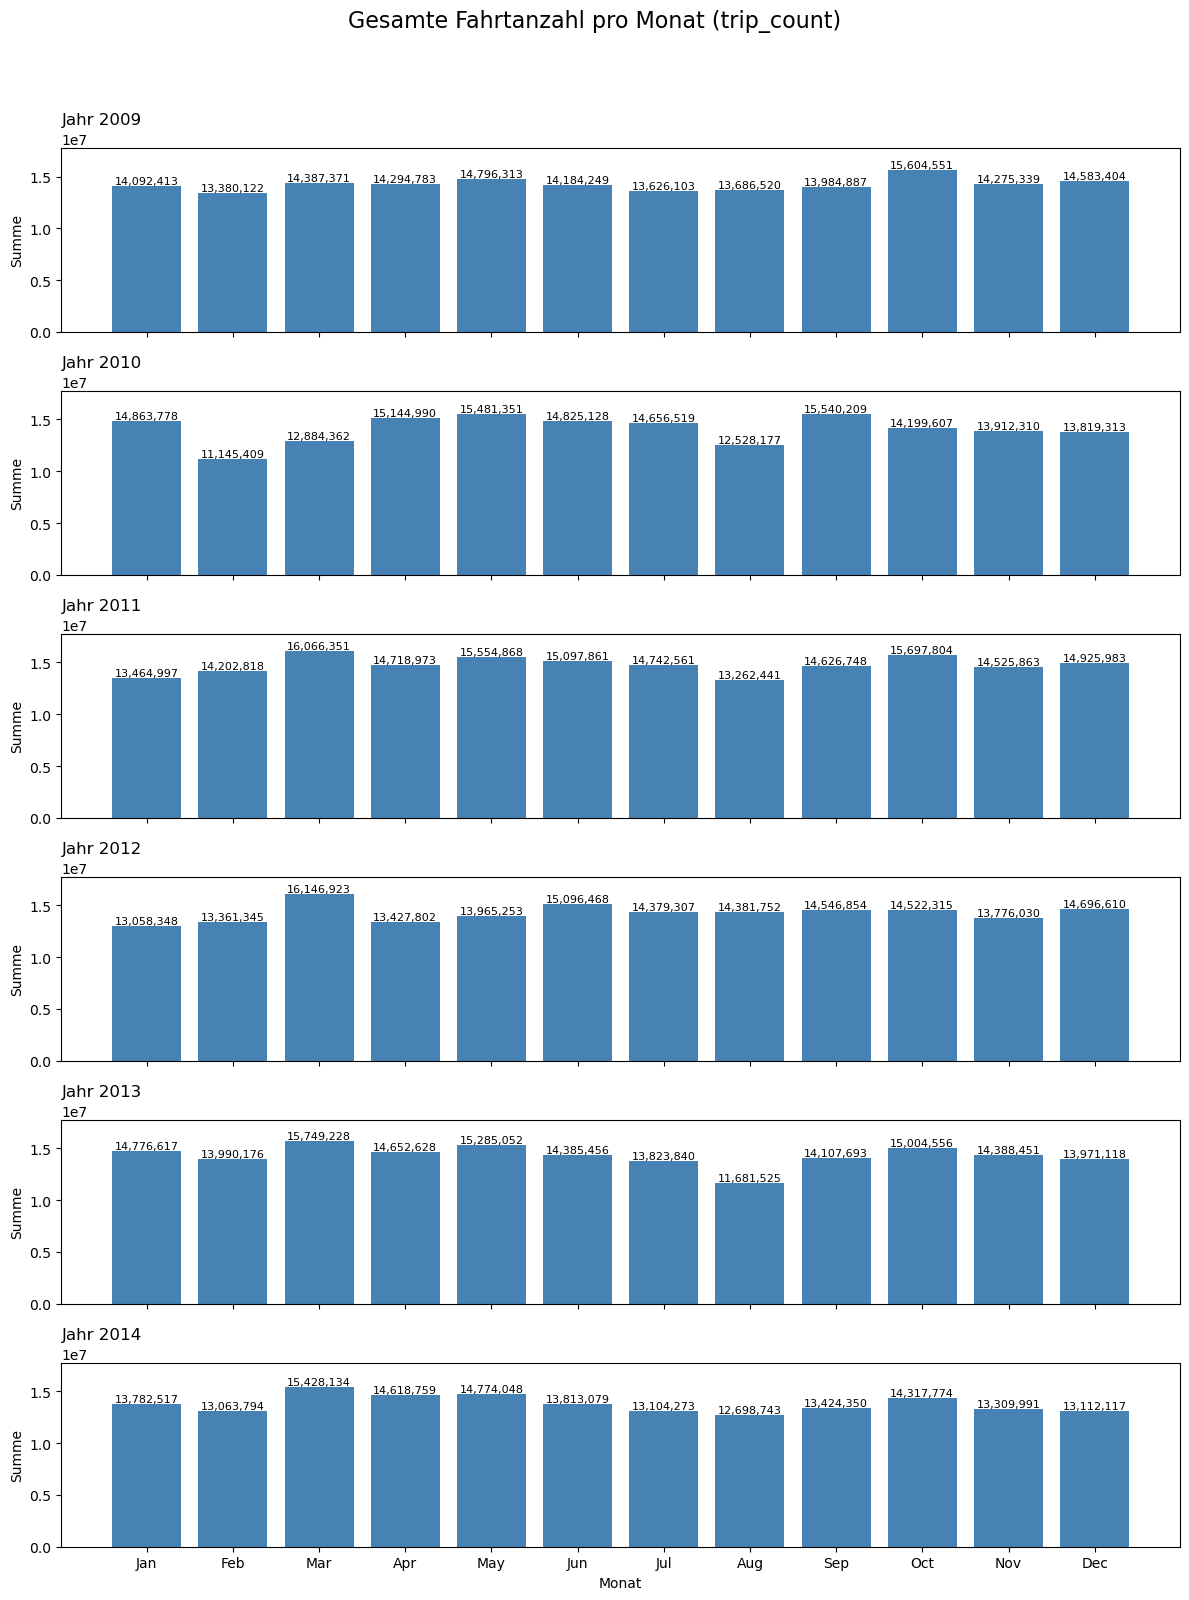

In [29]:
fig, axs = plt.subplots(len(years), 1, figsize=(12, 2.8 * len(years)), sharex=True)
fig.suptitle('Gesamte Fahrtanzahl pro Monat (trip_count)', fontsize=16)

for i, year in enumerate(years):
    ax = axs[i]
    subset = df_monthly[df_monthly['year'] == year]
    
    bars = ax.bar(subset['month_name'], subset['trip_count'], color='steelblue')
    ax.set_title(f"Jahr {year}", loc='left')
    ax.set_ylabel('Summe')
    ax.set_ylim(0, df_monthly['trip_count'].max() * 1.1)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height):,}",
            ha='center', va='bottom',
            fontsize=8
        )

axs[-1].set_xlabel('Monat')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Die obenstehende Darstellung zeigt die monatliche Gesamtzahl an Yellow-Taxi-Fahrten (`trip_count`), jeweils getrennt nach Kalenderjahren von 2009 bis 2014. Jeder Plot visualisiert ein Jahr als Balkendiagramm, wobei die X-Achse die Monate (Januar bis Dezember) und die Y-Achse die summierte Anzahl an Fahrten pro Monat darstellt.

Durch das einheitliche Format lassen sich Unterschiede und Gemeinsamkeiten im Jahresverlauf gut erkennen. Insgesamt wirkt die monatliche Nachfrage innerhalb der Jahre relativ stabil – es sind keine starken saisonalen Ausschläge zu beobachten. Leichte Rückgänge zeigen sich zwar in einzelnen Sommer- oder Wintermonaten, ein klarer saisonaler Effekt bleibt jedoch aus.

Überraschend ist, dass die Nachfrage in den Wintermonaten tendenziell etwas geringer ausfällt, obwohl man vermuten könnte, dass gerade zu dieser Zeit – etwa durch Feiertage oder Tourismus – eine erhöhte Nutzung zu erwarten wäre. Dieses Verhalten könnte auf witterungsbedingte Einschränkungen oder veränderte Mobilitätsgewohnheiten hinweisen.

**Durchschnittliche Nachfrage pro Stunde (`trip_count`)**

Ein wichtiger Einflussfaktor auf die Taxinachfrage ist die Uhrzeit. Um typische Tagesmuster zu erkennen, wird die durchschnittliche Anzahl an Fahrten pro Stunde über den gesamten Zeitraum hinweg dargestellt.

Diese Auswertung zeigt, zu welchen Tageszeiten besonders viele oder wenige Fahrten stattfinden – etwa im Berufsverkehr, in der Nacht oder zu Freizeitzeiten. Ein deutliches Muster kann hilfreich für die spätere Modellierung sein.

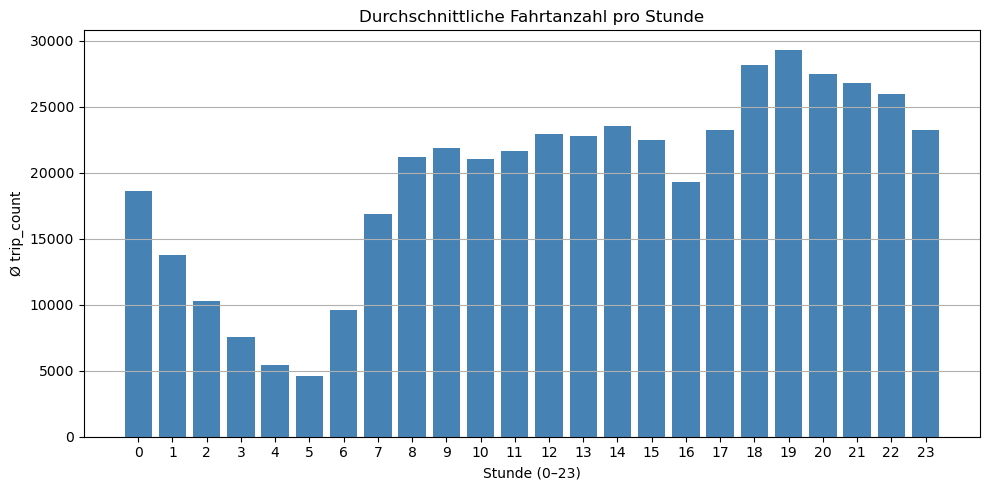

In [30]:
hourly_avg = df_train.groupby('hour')['trip_count'].mean()

plt.figure(figsize=(10, 5))
plt.bar(hourly_avg.index, hourly_avg.values, color='steelblue')
plt.title('Durchschnittliche Fahrtanzahl pro Stunde')
plt.xlabel('Stunde (0–23)')
plt.ylabel('Ø trip_count')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Die Visualisierung zeigt die durchschnittliche Anzahl an Yellow-Taxi-Fahrten (`trip_count`) pro Stunde über den gesamten Zeitraum von 2009 bis 2014. Dabei zeichnet sich ein klares Tagesmuster ab:

- In den frühen Morgenstunden (ca. 2–6 Uhr) ist die Nachfrage am geringsten.
- Ab etwa 7 Uhr steigt die Anzahl der Fahrten deutlich an – ein Hinweis auf den einsetzenden Berufsverkehr.
- Zwischen 10 und 15 Uhr bleibt das Niveau weitgehend stabil mit einem Einbruch um 16 Uhr.
- Die stärkste Nachfrage zeigt sich in den Abendstunden, vor allem zwischen 18 und 20 Uhr.
- Auch zwischen 21 und 23 Uhr bleibt die Nutzung erhöht – vermutlich bedingt durch Freizeitaktivitäten und Heimwege.

**Durchschnittliche Nachfrage pro Wochentag (`trip_count`)**

Neben der Uhrzeit beeinflusst vermutlich auch der Wochentag das Mobilitätsverhalten. In dieser Analyse wird die durchschnittliche Anzahl an Fahrten (`trip_count`) für jeden Wochentag über den gesamten Zeitraum hinweg berechnet.

So lassen sich typische Unterschiede zwischen Werktagen und Wochenenden sichtbar machen – etwa ein erhöhtes Verkehrsaufkommen an Freitagen oder ein Rückgang der Nachfrage an Sonntagen. Diese Muster können später gezielt als erklärende Merkmale in das Modell einfließen.

In [31]:
weekday_avg = df_train.groupby('weekday')['trip_count'].mean()

In [32]:
weekday_labels = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So']

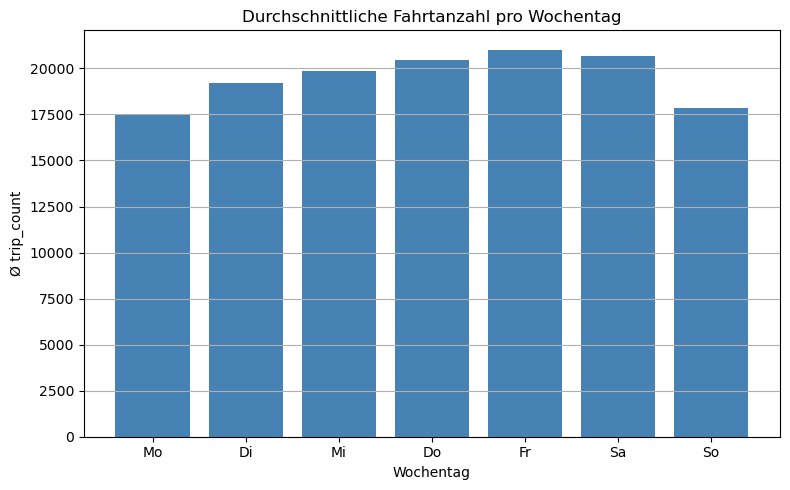

In [33]:
plt.figure(figsize=(8, 5))
plt.bar(weekday_avg.index, weekday_avg.values, color='steelblue')
plt.title('Durchschnittliche Fahrtanzahl pro Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Ø trip_count')
plt.xticks(ticks=range(7), labels=weekday_labels)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Die Balkengrafik zeigt die durchschnittliche Anzahl an Yellow-Taxi-Fahrten (`trip_count`) für jeden Wochentag, aggregiert über den gesamten Zeitraum von 2009 bis 2014.

Ein typisches Muster ist deutlich erkennbar: Die Nachfrage steigt im Verlauf der Arbeitswoche kontinuierlich an und erreicht ihren Höhepunkt am Freitag. Samstag bleibt auf einem ähnlich hohen Niveau, während am Sonntag ein deutlicher Rückgang der Fahrten sichtbar ist – vermutlich bedingt durch das geringere Berufs- und Freizeitverkehrsaufkommen.

Das relativ konsistente Verhalten von Montag bis Donnerstag lässt auf ein stark durch Arbeitsalltag geprägtes Nachfrageprofil schließen.

**Langfristiger Nachfrage-Trend (`trip_count` pro Monat)**

Zum Abschluss der explorativen Analyse wird betrachtet, wie sich die Taxinachfrage über den gesamten Zeitraum entwickelt hat. Dafür wird die monatlich aufsummierte Anzahl an Fahrten (`trip_count`) berechnet und als Zeitreihe dargestellt.

Diese Visualisierung eignet sich gut, um längerfristige Trends, saisonale Schwankungen oder mögliche strukturelle Veränderungen zu erkennen – etwa kontinuierliches Wachstum, wiederkehrende Muster oder unerwartete Einbrüche.

In [34]:
df_train['month_year'] = df_train['pickup_hour'].dt.to_period('M')
monthly_trend = df_train.groupby('month_year')['trip_count'].sum()

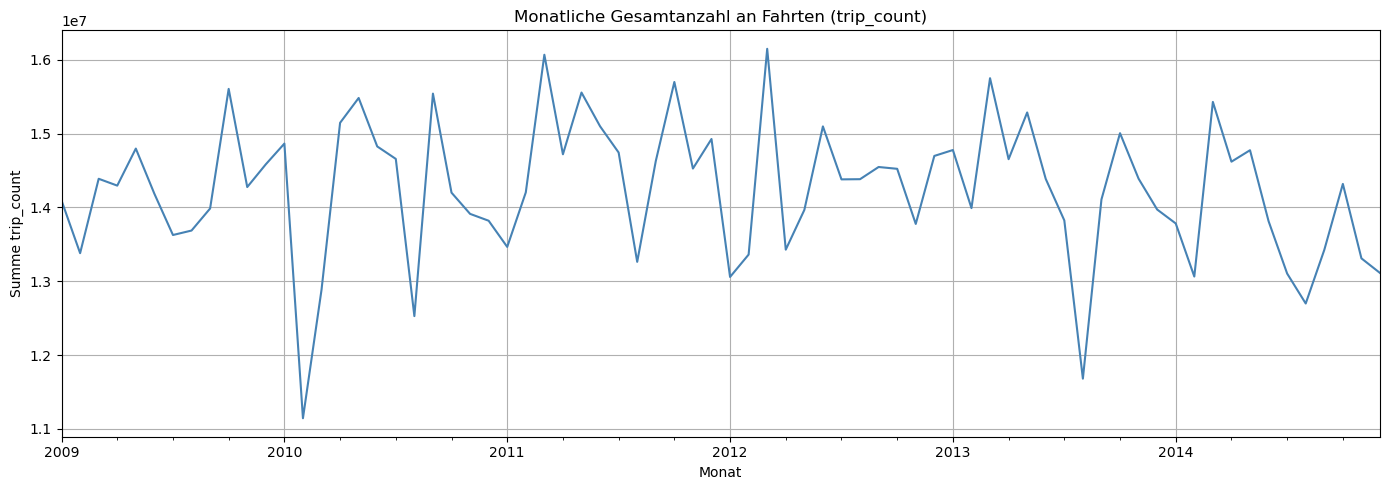

In [35]:
plt.figure(figsize=(14, 5))
monthly_trend.plot(kind='line', color='steelblue')
plt.title('Monatliche Gesamtanzahl an Fahrten (trip_count)')
plt.xlabel('Monat')
plt.ylabel('Summe trip_count')
plt.grid(True)
plt.tight_layout()
plt.show()

Die Zeitreihe zeigt die monatlich aufsummierte Anzahl an Yellow-Taxi-Fahrten (`trip_count`) im Zeitraum von Januar 2009 bis Dezember 2014. Insgesamt bleibt die Nachfrage über die Jahre hinweg auf einem relativ konstanten Niveau, auch wenn einzelne Monate deutlich herausstechen.

Innerhalb der Jahre lassen sich regelmäßige Schwankungen erkennen, die auf saisonale Effekte hindeuten – etwa erhöhte Nachfrage im Frühjahr und leichte Rückgänge gegen Jahresende. Auffällige Rückgänge, wie etwa zu Beginn des Jahres 2010, könnten auf externe Faktoren wie Wetterbedingungen, politische Maßnahmen oder wirtschaftliche Einflüsse zurückzuführen sein.

Trotz dieser kurzfristigen Schwankungen ist kein klarer langfristiger Trend – weder steigend noch fallend – erkennbar. Das spricht dafür, dass sich Mobilitätsverhalten in diesem Zeitraum eher langsam verändert hat, was später bei der Modellbewertung und im Umgang mit zeitlicher Stabilität eine Rolle spielen kann.

**Korrelationsanalyse der numerischen Merkmale**

Um mögliche Zusammenhänge zwischen den numerischen Variablen zu identifizieren, wird im nächsten Schritt die Korrelationsmatrix berechnet und als Heatmap visualisiert.

Diese Analyse unterstützt dabei stark korrelierte Merkmale zu erkennen,
sowie potenziell redundante Informationen frühzeitig zu identifizierenoder auch erste Hypothesen über Zusammenhänge oder Einflussfaktoren zu entwickeln.

Besonders interessant sind dabei die Korrelationen zwischen `trip_count`, `total_distance`, `total_fare` und `total_passengers`, da sie Hinweise auf die Relevanz einzelner Merkmale für die spätere Vorhersage liefern können.

In [36]:
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

In [37]:
corr_matrix = df_train[num_cols].corr()

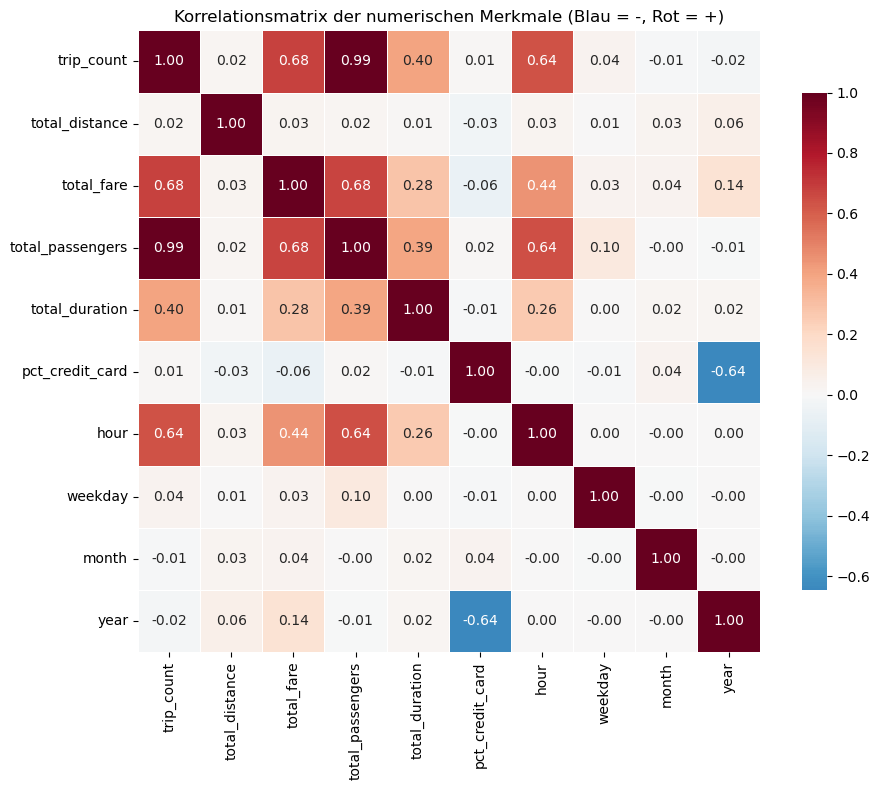

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title('Korrelationsmatrix der numerischen Merkmale (Blau = -, Rot = +)')
plt.tight_layout()
plt.show()

Die Korrelationsmatrix zeigt die Beziehungen zwischen den numerischen Merkmalen im Datensatz. Positive Korrelationen (rot) deuten auf gleichgerichtete Zusammenhänge hin, negative Korrelationen (blau) auf gegenläufige. Die Farbskala ist auf 0 zentriert und reicht von –1 bis +1.

Besonders auffällig ist die fast perfekte Korrelation zwischen `trip_count` und `total_passengers` (r = 0.99). Das ist nachvollziehbar, da jede Taxifahrt mindestens einen Fahrgast umfasst – leere Fahrten kommen in diesem Kontext nicht vor. Beide Merkmale enthalten damit nahezu identische Informationen. Für die Modellierung sollte geprüft werden, ob es zugunsten eines kompakteren Feature-Sets entfernt werden kann.

Auch die starke Korrelation von `trip_count` mit `total_fare`, `total_distance` und `total_duration` ist plausibel: Mit steigender Anzahl an Fahrten nehmen auch diese summierten Größen zu. Eine leichte negative Korrelation zeigt sich zwischen `pct_credit_card` und `hour`, was darauf hindeuten könnte, dass zu bestimmten Tageszeiten – etwa nachts – häufiger bar gezahlt wird.

Insgesamt liefert die Analyse wertvolle Hinweise für die Auswahl und Reduktion von Merkmalen sowie für das Verständnis von Zusammenhängen im Datensatz.

**Durchschnittliche Passagieranzahl pro Fahrt**

Im Rahmen der Korrelationsanalyse zeigte sich eine nahezu perfekte Übereinstimmung zwischen der Anzahl der Fahrten (`trip_count`) und der Gesamtanzahl der beförderten Personen (`total_passengers`). Das ist grundsätzlich nachvollziehbar – jede Fahrt erfordert mindestens einen Fahrgast –, dennoch lohnt sich ein genauerer Blick auf das Verhältnis.

Konkret stellt sich die Frage, wie viele Personen im Durchschnitt pro Fahrt mitgenommen wurden und ob sich dieser Wert im Verlauf der Jahre verändert hat.

In [39]:
annual_summary = df_train.groupby('year')[['trip_count', 'total_passengers']].sum()

In [40]:
annual_summary['avg_passengers_per_trip'] = annual_summary['total_passengers'] / annual_summary['trip_count']

In [41]:
print(annual_summary[['avg_passengers_per_trip']].round(3))

      avg_passengers_per_trip
year                         
2009                    1.691
2010                    1.674
2011                    1.652
2012                    1.676
2013                    1.707
2014                    1.696


Die Auswertung zeigt, dass im Zeitraum von 2009 bis 2014 durchschnittlich zwischen 1,65 und 1,71 Personen pro Fahrt mit dem Taxi befördert wurden. Der Wert liegt deutlich über 1, was darauf hindeutet, dass viele Fahrten nicht von Einzelpersonen, sondern von Paaren oder kleinen Gruppen genutzt wurden.

Auffällig ist, dass dieser Durchschnitt über die Jahre hinweg relativ konstant bleibt. Es ist keine klare steigende oder fallende Tendenz erkennbar.

Diese Ergebnisse bestätigen die enge Korrelation zwischen `trip_count` und `total_passengers`, zeigen aber auch, dass `total_passengers` nicht vollständig redundant ist – vor allem dann, wenn Gruppenverhalten oder Nutzungsintensität eine Rolle spielen sollen.

**Entwicklung des Kreditkartenanteils im Zeitverlauf**

Ein weiteres mögliches Merkmal für Veränderungen im Nutzungsverhalten ist die Art der Bezahlung. Im Datensatz gibt `pct_credit_card` den Anteil der Fahrten an, die pro Stunde mit Kreditkarte bezahlt wurden. Veränderungen in diesem Anteil können auf technologische Entwicklungen (z. B. mobile Payment), verändertes Kundenverhalten oder regulatorische Vorgaben hinweisen.

Im nächsten Schritt wird der durchschnittliche Kreditkartenanteil auf monatlicher Ebene berechnet und als Zeitreihe für den Zeitraum von 2009 bis 2014 dargestellt.

In [42]:
df_train['month_year'] = df_train['pickup_hour'].dt.to_period('M')
monthly_credit_share = df_train.groupby('month_year')['pct_credit_card'].mean()

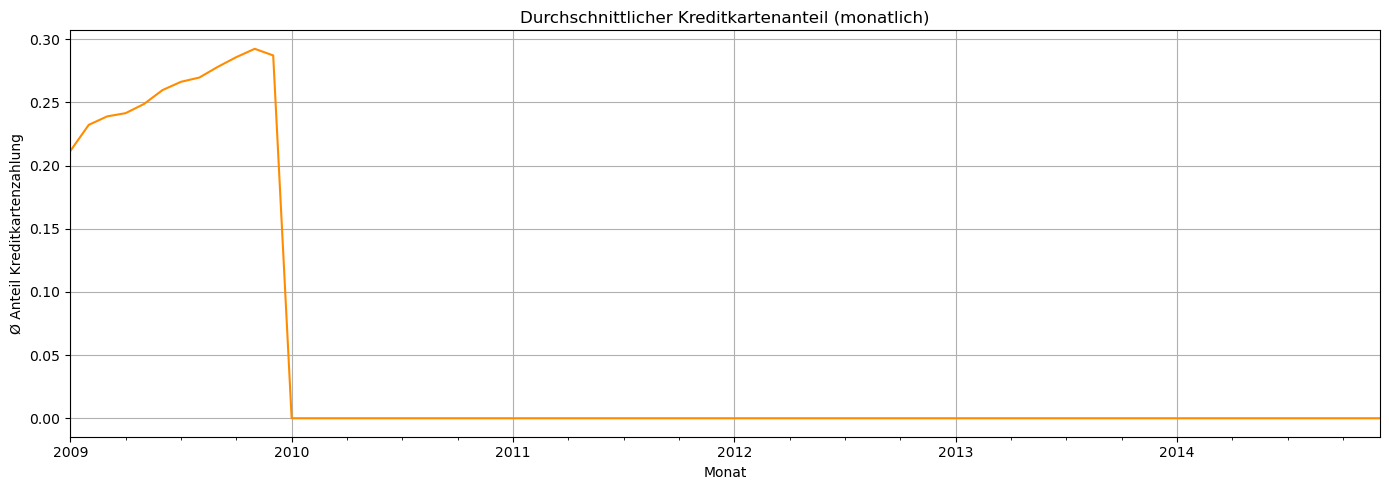

In [43]:
plt.figure(figsize=(14, 5))
monthly_credit_share.plot(kind='line', color='darkorange')
plt.title('Durchschnittlicher Kreditkartenanteil (monatlich)')
plt.xlabel('Monat')
plt.ylabel('Ø Anteil Kreditkartenzahlung')
plt.grid(True)
plt.tight_layout()
plt.show()

Bei der Analyse des Kreditkartenanteils (`pct_credit_card`) im Zeitverlauf zeigt sich ein auffälliges Muster: Ab dem Jahr 2010 liegt der Wert durchgehend bei 0 – über sämtliche Stunden hinweg. Während in den Jahren zuvor noch plausible Werte vorhanden waren, fehlt ab 2010 jegliche Veränderung. Dies deutet auf ein Problem bei der Datenverarbeitung oder der Feature-Erstellung hin.

Ein möglicher Grund findet sich im offiziellen Data Dictionary: Dort ist dokumentiert, dass das Zahlungsmerkmal `Payment_Type` in älteren Jahrgängen als Klartext (z. B. `"Credit"` oder `"CASH"`) vorliegt, während in späteren Versionen numerische Codes verwendet werden (z. B. `1 = Credit card`, `2 = Cash` usw.).

Zur Überprüfung dieser Vermutung wird exemplarisch ein auffälliges Jahr – etwa 2011 – erneut direkt aus dem ursprünglichen Parquet-Datensatz geladen. Anschließend wird geprüft, in welcher Form das Feld `Payment_Type` tatsächlich gespeichert ist.

In [44]:
df_2011_raw = pd.read_parquet("yellow_tripdata_2011-01.parquet")

print(df_2011_raw.columns)

print(df_2011_raw['payment_type'].value_counts())

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')
2    7889880
1    5575117
Name: payment_type, dtype: int64


In [45]:
df_2011_raw.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2011-01-01 00:10:00,2011-01-01 00:12:00,4,0.0,1,None,145,145,1,2.9,0.5,0.5,0.28,0.0,0.0,4.18,NaN,NaN
1,2,2011-01-01 00:04:00,2011-01-01 00:13:00,4,0.0,1,None,264,264,1,5.7,0.5,0.5,0.24,0.0,0.0,6.94,NaN,NaN
2,2,2011-01-01 00:14:00,2011-01-01 00:16:00,4,0.0,1,None,264,264,1,2.9,0.5,0.5,1.11,0.0,0.0,5.01,NaN,NaN
3,2,2011-01-01 00:04:00,2011-01-01 00:06:00,5,0.0,1,None,146,146,1,2.9,0.5,0.5,0.00,0.0,0.0,3.90,NaN,NaN
4,2,2011-01-01 00:08:00,2011-01-01 00:08:00,5,0.0,1,None,146,146,1,2.5,0.5,0.5,0.11,0.0,0.0,3.61,NaN,NaN


Die erneute Prüfung des ursprünglichen Parquet-Datensatzes für das Jahr 2011 zeigt, dass das Zahlungsmerkmal `payment_type` zwar weiterhin vorhanden ist, aber nicht mehr als Text, sondern in Form numerischer Codes vorliegt.

Konkret treten die Werte `1` und `2` auf, die laut offiziellem Data Dictionary für „Credit Card“ bzw. „Cash“ stehen. Die ursprüngliche Berechnung des Features `pct_credit_card` war jedoch darauf ausgelegt, nach dem Textwert `"Credit"` zu filtern. Da dieser in späteren Jahrgängen nicht mehr verwendet wird, ergibt sich ab 2010 systematisch ein Anteil von 0.

Das bestätigt, dass sich das Datenformat über die Jahre hinweg geändert hat – und zeigt, wie wichtig es ist, bei der Feature-Erzeugung versionsspezifische Unterschiede zu berücksichtigen. Für valide Ergebnisse muss die Berechnung des Kreditkartenanteils entsprechend angepasst werden.

**Reprocessing**

Um den Kreditkartenanteil (`pct_credit_card`) über alle Jahrgänge hinweg korrekt zu berechnen, wurde eine Funktion verwendet, die automatisch erkennt, in welchem Format das Zahlungsmerkmal `payment_type` vorliegt – als Text (z. B. `"CREDIT"`) oder als numerischer Code (`1`).

Für jedes Zeitintervall (z. B. Stunde) wird die entsprechende Kodierung geprüft und darauf basierend der Anteil der Fahrten berechnet, die mit Kreditkarte bezahlt wurden. Auf diese Weise kann das Feature unabhängig vom Datenformat zuverlässig erstellt werden und bleibt über den gesamten Zeitraum hinweg konsistent nutzbar.

In [46]:
def berechne_pct_credit_card(df):
    if 'payment_type' not in df.columns:
        return 0.0
    
    kreditwerte = {"CREDIT", "CREDIT CARD"}
    kreditcodes = {1}

    if df['payment_type'].dtype == 'O':
        return df['payment_type'].str.upper().isin(kreditwerte).sum() / len(df)
    else:
        return df['payment_type'].isin(kreditcodes).sum() / len(df)


In [47]:
def aggregate_month_to_hourly(year, month, path="./", output_path="./hourly_monthly/"):
    os.makedirs(output_path, exist_ok=True)
    filename = f"{path}yellow_tripdata_{year}-{str(month).zfill(2)}.parquet"

    if not os.path.exists(filename):
        print(f"⚠ Datei nicht gefunden: {filename}")
        return

    print(f"Lade Datei: {filename}")
    df = pd.read_parquet(filename)

    pickup_col = next((col for col in df.columns if "pickup" in col.lower()), None)
    dropoff_col = next((col for col in df.columns if "dropoff" in col.lower()), None)

    if pickup_col and dropoff_col:
        df['pickup_hour'] = pd.to_datetime(df[pickup_col], errors='coerce').dt.floor('h')
        df['dropoff_dt'] = pd.to_datetime(df[dropoff_col], errors='coerce')

        df = df[['pickup_hour', 'dropoff_dt', 'passenger_count', 'trip_distance',
                 'payment_type', 'fare_amount', 'mta_tax', 'tip_amount',
                 'tolls_amount', 'total_amount']].copy()

        df['duration_sec'] = (df['dropoff_dt'] - df['pickup_hour']).dt.total_seconds()
        df = df[df['duration_sec'] > 0]

        agg_df = df.groupby('pickup_hour').agg(
            trip_count=('pickup_hour', 'count'),
            total_distance=('trip_distance', 'sum'),
            total_fare=('fare_amount', 'sum'),
            total_passengers=('passenger_count', 'sum'),
            total_duration=('duration_sec', 'sum'),
        ).reset_index()

        pct_credit = df.groupby('pickup_hour').apply(berechne_pct_credit_card).reset_index()
        pct_credit.columns = ['pickup_hour', 'pct_credit_card']

        agg_df = agg_df.merge(pct_credit, on='pickup_hour', how='left')

        agg_df['hour'] = agg_df['pickup_hour'].dt.hour
        agg_df['weekday'] = agg_df['pickup_hour'].dt.weekday
        agg_df['month'] = agg_df['pickup_hour'].dt.month
        agg_df['year'] = agg_df['pickup_hour'].dt.year

        output_file = os.path.join(output_path, f"hourly_{year}-{str(month).zfill(2)}.parquet")
        agg_df.to_parquet(output_file, index=False)
        print(f" Gespeichert: {output_file}")

In [48]:
for year in range(2010, 2015):
    for month in range(1, 13):
        aggregate_month_to_hourly(year, month)

Lade Datei: ./yellow_tripdata_2010-01.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-01.parquet
Lade Datei: ./yellow_tripdata_2010-02.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-02.parquet
Lade Datei: ./yellow_tripdata_2010-03.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-03.parquet
Lade Datei: ./yellow_tripdata_2010-04.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-04.parquet
Lade Datei: ./yellow_tripdata_2010-05.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-05.parquet
Lade Datei: ./yellow_tripdata_2010-06.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-06.parquet
Lade Datei: ./yellow_tripdata_2010-07.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-07.parquet
Lade Datei: ./yellow_tripdata_2010-08.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-08.parquet
Lade Datei: ./yellow_tripdata_2010-09.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-09.parquet
Lade Datei: ./yellow_tripdata_2010-10.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-10.parquet


Nach dem Reprocessing der Jahresdateien mit korrigierter `pct_credit_card`-Spalte werden nun alle stündlich aggregierten Datensätze aus den Jahren 2009 bis 2014 zunächst zu Jahresdatensätzenzusammengefügt um sie dann schließlich in einem konsistenten Trainingsdatensatz zusammenzuführen. Damit steht eine vollständige, bereinigte Datenbasis für die Modellierung zur Verfügung.

In [49]:
def combine_months_to_year(year, input_path="./hourly_monthly/", output_path="./"):
    files = [f"{input_path}hourly_{year}-{str(m).zfill(2)}.parquet" for m in range(1, 13)]
    dfs = []

    for file in files:
        if os.path.exists(file):
            print(f"Lade Datei: {file}")
            df = pd.read_parquet(file)
            dfs.append(df)
        else:
            print(f"Datei nicht gefunden: {file}")

    if dfs:
        df_year = pd.concat(dfs, ignore_index=True)
        output_file = os.path.join(output_path, f"hourly_{year}.parquet")
        df_year.to_parquet(output_file, index=False)
        print(f"Jahresdatei gespeichert unter: {output_file}")
    else:
        print(f"Keine Monatsdateien für Jahr {year} gefunden.")

In [50]:
for year in range(2010, 2015):
    combine_months_to_year(year)

Lade Datei: ./hourly_monthly/hourly_2010-01.parquet
Lade Datei: ./hourly_monthly/hourly_2010-02.parquet
Lade Datei: ./hourly_monthly/hourly_2010-03.parquet
Lade Datei: ./hourly_monthly/hourly_2010-04.parquet
Lade Datei: ./hourly_monthly/hourly_2010-05.parquet
Lade Datei: ./hourly_monthly/hourly_2010-06.parquet
Lade Datei: ./hourly_monthly/hourly_2010-07.parquet
Lade Datei: ./hourly_monthly/hourly_2010-08.parquet
Lade Datei: ./hourly_monthly/hourly_2010-09.parquet
Lade Datei: ./hourly_monthly/hourly_2010-10.parquet
Lade Datei: ./hourly_monthly/hourly_2010-11.parquet
Lade Datei: ./hourly_monthly/hourly_2010-12.parquet
Jahresdatei gespeichert unter: ./hourly_2010.parquet
Lade Datei: ./hourly_monthly/hourly_2011-01.parquet
Lade Datei: ./hourly_monthly/hourly_2011-02.parquet
Lade Datei: ./hourly_monthly/hourly_2011-03.parquet
Lade Datei: ./hourly_monthly/hourly_2011-04.parquet
Lade Datei: ./hourly_monthly/hourly_2011-05.parquet
Lade Datei: ./hourly_monthly/hourly_2011-06.parquet
Lade Datei:

Nach der überarbeiteten Berechnung des Merkmals `pct_credit_card` wird zur Prüfung exemplarisch die Verteilung des Werts für das Jahr 2010 untersucht.

Dazu wird überprüft, ob die stündlich aggregierten Werte im erwartbaren Bereich zwischen 0 und 1 liegen und ob der Anteil an Stunden mit einem Wert von 1 auffällig hoch ist – was auf eine weiterhin fehlerhafte Verarbeitung hindeuten würde.

Diese Prüfung ist besonders für die Jahre ab 2010 relevant, da die ursprüngliche Berechnung fälschlich davon ausging, dass die Bezahlart als Text vorliegt. Tatsächlich wurde sie in späteren Jahrgängen numerisch kodiert, was in der ersten Version des Features zu systematischen Nullwerten geführt hat.

In [51]:
df_2010 = pd.read_parquet("hourly_2010.parquet")

print("Kreditkartenanteil (pct_credit_card) im Jahr 2010:")
print("Minimum:", df_2010['pct_credit_card'].min())
print("Maximum:", df_2010['pct_credit_card'].max())
print("Mittelwert:", df_2010['pct_credit_card'].mean().round(3))
print("Anzahl Nullwerte:", (df_2010['pct_credit_card'] == 0).sum())

Kreditkartenanteil (pct_credit_card) im Jahr 2010:
Minimum: 0.0
Maximum: 0.0
Mittelwert: 0.0
Anzahl Nullwerte: 8765


Die Analyse des Merkmals `pct_credit_card` für das Jahr 2010 zeigt, dass weiterhin ausschließlich der Wert 0 vorliegt. Trotz der vorgenommenen Korrekturen bei der Feature-Erstellung wurde der Anteil der Kreditkartenzahlungen weiterhin nicht erfolgreich berechnet.

Das zeigt, wie wichtig ein sorgfältiger Umgang mit strukturell uneinheitlichen Daten ist. Gerade ältere Jahrgänge – wie hier 2010 – können abweichende Spaltennamen, Kodierungen oder unvollständige Informationen enthalten. Eine einmal entwickelte Berechnungslogik lässt sich daher nicht ohne Weiteres auf alle Jahrgänge übertragen.

Im nächsten Schritt sollte geprüft werden, ob die Spalte `payment_type` in den Originaldaten von 2010 tatsächlich vorhanden und inhaltlich korrekt befüllt ist. Nur auf dieser Grundlage kann die Berechnung des Kreditkartenanteils sinnvoll nachgeholt werden.

In [52]:
df = pd.read_parquet("yellow_tripdata_2010-01.parquet")

if 'payment_type' in df.columns:
    missing = df['payment_type'].isna().sum()
    total = len(df)
    print(f"Anzahl fehlender Werte in 'payment_type': {missing} von {total} Zeilen")
else:
    print("Spalte 'payment_type' ist nicht vorhanden.")

Anzahl fehlender Werte in 'payment_type': 0 von 14863778 Zeilen


In [53]:
df_jan2010 = pd.read_parquet("yellow_tripdata_2010-01.parquet")

print("Spaltenübersicht:\n", df_jan2010.columns)

if 'payment_type' in df_jan2010.columns:
    print("\nVerteilung von payment_type:\n")
    print(df_jan2010['payment_type'].value_counts(dropna=False))
else:
    print("\nSpalte 'payment_type' nicht vorhanden.")

Spaltenübersicht:
 Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount'],
      dtype='object')

Verteilung von payment_type:

CAS    5621301
Cre    4532676
Cas    4424339
CRE     242607
No       35258
Dis       7597
Name: payment_type, dtype: int64


Bei der erneuten Prüfung der Originaldaten aus dem Januar 2010 zeigt sich, dass die Spalte `payment_type` zwar vorhanden ist, jedoch in uneinheitlicher Textform vorliegt. Anstelle einer konsistenten Schreibweise wie `"CREDIT"` oder `"CASH"` finden sich verschiedene abgekürzte oder uneinheitlich formatierte Einträge – etwa `"Cre"`, `"CRE"`, `"Cas"` oder `"CAS"`.

Die Verteilung macht deutlich, dass ein großer Teil dieser Werte Kreditkartenzahlungen entspricht, aber nicht zuverlässig durch eine einfache Abfrage nach `"CREDIT"` erkannt werden kann. Das erklärt, warum die ursprüngliche Berechnung des Merkmals `pct_credit_card` für das Jahr 2010 fehlgeschlagen und ausschließlich 0-Werte ergeben hat.

Die Berechnung wird daher nun erneut angepasst, sodass künftig alle bekannten Varianten als Kreditkartenzahlungen erfasst werden. In einem nächsten Schritt wird das Jahr 2010 mit der überarbeiteten Logik erneut ausgewertet.

In [54]:
path = "./"
results = []

for month in range(1, 13):
    file = f"{path}yellow_tripdata_2010-{str(month).zfill(2)}.parquet"
    if os.path.exists(file):
        df = pd.read_parquet(file)
        
        if 'payment_type' in df.columns:
            nan_count = df['payment_type'].isna().sum()
            unique_values = df['payment_type'].dropna().unique()
            results.append({
                "Monat": f"{month:02}",
                "Fehlende Werte": nan_count,
                "Anzahl Zeilen": len(df),
                "Beispielhafte Werte": list(unique_values)[:5]
            })
        else:
            results.append({
                "Monat": f"{month:02}",
                "Fehlende Werte": "Spalte fehlt",
                "Anzahl Zeilen": len(df),
                "Beispielhafte Werte": []
            })
    else:
        results.append({
            "Monat": f"{month:02}",
            "Fehlende Werte": "Datei fehlt",
            "Anzahl Zeilen": "-",
            "Beispielhafte Werte": []
        })

df_overview = pd.DataFrame(results)
print(df_overview)

   Monat  Fehlende Werte  Anzahl Zeilen        Beispielhafte Werte
0     01               0       14863778  [CAS, Cre, CRE, Cas, No ]
1     02               0       11145409  [CRE, CAS, NA , CRD, CSH]
2     03               0       12884362  [Cas, Cre, No , CSH, CRD]
3     04               0       15144990  [CAS, Cre, Cas, No , CRE]
4     05               0       15481351  [Cas, Cre, CAS, CRE, No ]
5     06               0       14825128  [Cas, Cre, CRE, CAS, No ]
6     07               0       14656519  [CAS, Cre, Cas, No , CRE]
7     08               0       12528177       [CSH, CRD, NOC, DIS]
8     09               0       15540209       [CSH, CRD, DIS, NOC]
9     10               0       14199607                 [CSH, CRD]
10    11               0       13912310                 [CSH, CRD]
11    12               0       13819322       [CSH, CRD, CAS, CRE]


In [55]:
def berechne_pct_credit_card(df):
    if 'payment_type' not in df.columns:
        return 0.0

    kreditkarten_bezeichnungen = {
        "CREDIT", "CREDIT CARD", "CRE", "Cre", "CRD"
    }

    if df['payment_type'].dtype == 'O':
        return df['payment_type'].str.strip().str.upper().isin(kreditkarten_bezeichnungen).mean()
    else:
        return df['payment_type'].isin({1}).mean()

In [56]:
for year in range(2010, 2015):
    for month in range(1, 13):
        aggregate_month_to_hourly(year, month)

Lade Datei: ./yellow_tripdata_2010-01.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-01.parquet
Lade Datei: ./yellow_tripdata_2010-02.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-02.parquet
Lade Datei: ./yellow_tripdata_2010-03.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-03.parquet
Lade Datei: ./yellow_tripdata_2010-04.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-04.parquet
Lade Datei: ./yellow_tripdata_2010-05.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-05.parquet
Lade Datei: ./yellow_tripdata_2010-06.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-06.parquet
Lade Datei: ./yellow_tripdata_2010-07.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-07.parquet
Lade Datei: ./yellow_tripdata_2010-08.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-08.parquet
Lade Datei: ./yellow_tripdata_2010-09.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-09.parquet
Lade Datei: ./yellow_tripdata_2010-10.parquet
 Gespeichert: ./hourly_monthly/hourly_2010-10.parquet


In [57]:
for year in range(2010, 2015):
    combine_months_to_year(year)

Lade Datei: ./hourly_monthly/hourly_2010-01.parquet
Lade Datei: ./hourly_monthly/hourly_2010-02.parquet
Lade Datei: ./hourly_monthly/hourly_2010-03.parquet
Lade Datei: ./hourly_monthly/hourly_2010-04.parquet
Lade Datei: ./hourly_monthly/hourly_2010-05.parquet
Lade Datei: ./hourly_monthly/hourly_2010-06.parquet
Lade Datei: ./hourly_monthly/hourly_2010-07.parquet
Lade Datei: ./hourly_monthly/hourly_2010-08.parquet
Lade Datei: ./hourly_monthly/hourly_2010-09.parquet
Lade Datei: ./hourly_monthly/hourly_2010-10.parquet
Lade Datei: ./hourly_monthly/hourly_2010-11.parquet
Lade Datei: ./hourly_monthly/hourly_2010-12.parquet
Jahresdatei gespeichert unter: ./hourly_2010.parquet
Lade Datei: ./hourly_monthly/hourly_2011-01.parquet
Lade Datei: ./hourly_monthly/hourly_2011-02.parquet
Lade Datei: ./hourly_monthly/hourly_2011-03.parquet
Lade Datei: ./hourly_monthly/hourly_2011-04.parquet
Lade Datei: ./hourly_monthly/hourly_2011-05.parquet
Lade Datei: ./hourly_monthly/hourly_2011-06.parquet
Lade Datei:

Bevor die stündlich aggregierten Jahresdateien zu einem finalen Trainingsdatensatz zusammengeführt werden, wird überprüft, ob das Merkmal `pct_credit_card` in allen Jahrgängen korrekt berechnet wurde.

Für jedes Jahr werden dazu Minimal- und Maximalwert, der Mittelwert sowie die Anzahl der Stunden mit einem Anteil von exakt 0 analysiert. Auf diese Weise lassen sich potenzielle Fehler, Inkonsistenzen oder Datenlücken frühzeitig erkennen und gezielt beheben.

In [58]:
years = list(range(2009, 2015))

for year in years:
    file = f"hourly_{year}.parquet"
    
    if os.path.exists(file):
        df = pd.read_parquet(file)

        print(f"\nKreditkartenanteil (pct_credit_card) im Jahr {year}:")
        print("Minimum:        ", df['pct_credit_card'].min())
        print("Maximum:        ", df['pct_credit_card'].max())
        print("Mittelwert:     ", round(df['pct_credit_card'].mean(), 3))
        print("Anzahl Nullwerte:", (df['pct_credit_card'] == 0).sum())
    else:
        print(f"\nDatei nicht gefunden: {file}")


Kreditkartenanteil (pct_credit_card) im Jahr 2009:
Minimum:         0.127887269381628
Maximum:         0.37616998792270534
Mittelwert:      0.26
Anzahl Nullwerte: 0

Kreditkartenanteil (pct_credit_card) im Jahr 2010:
Minimum:         0.0
Maximum:         1.0
Mittelwert:      0.358
Anzahl Nullwerte: 2

Kreditkartenanteil (pct_credit_card) im Jahr 2011:
Minimum:         0.15942028985507245
Maximum:         0.5338340562079058
Mittelwert:      0.423
Anzahl Nullwerte: 0

Kreditkartenanteil (pct_credit_card) im Jahr 2012:
Minimum:         0.25120772946859904
Maximum:         0.59710792779979
Mittelwert:      0.472
Anzahl Nullwerte: 0

Kreditkartenanteil (pct_credit_card) im Jahr 2013:
Minimum:         0.26145038167938933
Maximum:         0.6451978040636143
Mittelwert:      0.528
Anzahl Nullwerte: 0

Kreditkartenanteil (pct_credit_card) im Jahr 2014:
Minimum:         0.33462732919254656
Maximum:         0.6920499421596394
Mittelwert:      0.568
Anzahl Nullwerte: 0


Die Analyse des Merkmals `pct_credit_card` über alle Jahre hinweg zeigt einen klaren Trend: Während der durchschnittliche Anteil an Kreditkartenzahlungen im Jahr 2009 noch bei rund 26 % lag, steigt er kontinuierlich an und erreicht im Jahr 2014 etwa 57 %. Die zunehmende Verbreitung bargeldloser Zahlungsmethoden in New York City spiegelt sich damit deutlich in den aggregierten Daten wider.

Durch eine erweiterte Berechnungslogik konnten die verschiedenen Varianten der Bezhalmethode Credit korrekt zugeordnet werden. Nach der erneuten Aggregation ergibt sich für 2010 ein plausibler durchschnittlicher Anteil von 35,8 % – bei nur noch zwei Stunden mit einem Wert von exakt 0.
Damit liegt das Feature `pct_credit_card` nun über alle Jahre hinweg konsistent und plausibel vor.

Im nächsten Schritt werden alle bereinigten, stündlich aggregierten Jahresdateien zu einem konsolidierten Trainingsdatensatz zusammengeführt, der als Grundlage für die anschließende Modellierung dient.

In [59]:
years = list(range(2009, 2015))
file_list = [f"hourly_{year}.parquet" for year in years]

df_list = []

for file in file_list:
    if os.path.exists(file):
        print(f"Lade Datei: {file}")
        df = pd.read_parquet(file)
        df_list.append(df)
    else:
        print(f"Datei nicht gefunden: {file}")

df_train = pd.concat(df_list, ignore_index=True)
print(f"Zusammengeführt: {len(df_train):,} Zeilen aus {len(df_list)} Dateien.")

df_train.to_parquet("train_dataset_2009_2014.parquet", index=False)
print("Gesamtdatensatz gespeichert unter: train_dataset_2009_2014.parquet")

Lade Datei: hourly_2009.parquet
Lade Datei: hourly_2010.parquet
Lade Datei: hourly_2011.parquet
Lade Datei: hourly_2012.parquet
Lade Datei: hourly_2013.parquet
Lade Datei: hourly_2014.parquet
Zusammengeführt: 52,585 Zeilen aus 6 Dateien.
Gesamtdatensatz gespeichert unter: train_dataset_2009_2014.parquet


Nach erfolgreicher Validierung und Korrektur des Merkmals `pct_credit_card` wurden die stündlich aggregierten Jahresdateien der Jahre 2009 bis 2014 zu einem gemeinsamen Trainingsdatensatz zusammengeführt.

Der kombinierte Datensatz umfasst insgesamt 52.585 Stundenblöcke. Jede Zeile repräsentiert eine Stunde und enthält verschiedene aggregierte Kennzahlen – darunter die Anzahl der Fahrten, die Gesamtdistanz, die Summe der Fahrpreise, die Zahl der Passagiere sowie den Anteil der Kreditkartenzahlungen.

**Fortsetzung EDA - Entwicklung des Kreditkartenatiels im Zeitverlauf**

Nach der Korrektur und Validierung des Merkmals `pct_credit_card` liegt nun eine bereinigte und konsistente Datenbasis vor. Die grundlegenden Schritte der explorativen Datenanalyse – darunter die Strukturprüfung, die Analyse der Zielgröße `trip_count` sowie die Korrelationsanalyse – wurden bereits durchgeführt.

Darauf folgte ein gezieltes Reprocessing, um Fehler bei der Berechnung des Kreditkartenanteils zu korrigieren und die betroffenen Jahresdateien entsprechend zu aktualisieren. Auf Basis des bereinigten Datensatzes können nun weiterführende Analysen durchgeführt werden, die sich verstärkt auf die zeitliche Entwicklung zusätzlicher Merkmale konzentrieren.

Im Fokus stehen dabei unter anderem `total_distance`, `total_fare` und `total_passengers` – etwa im Hinblick auf deren durchschnittliche Ausprägung und mögliche saisonale Muster im Zeitverlauf.

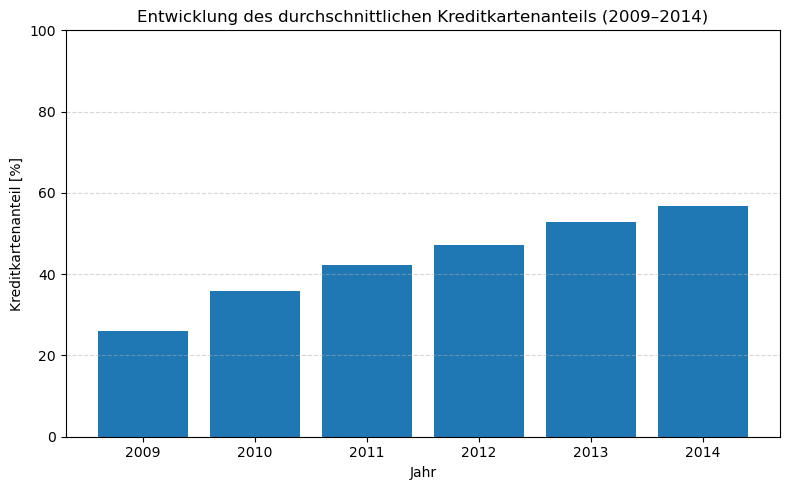

In [60]:
df = pd.read_parquet("train_dataset_2009_2014.parquet")

annual_pct = df.groupby("year")["pct_credit_card"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(annual_pct["year"], annual_pct["pct_credit_card"] * 100)
plt.title("Entwicklung des durchschnittlichen Kreditkartenanteils (2009–2014)")
plt.xlabel("Jahr")
plt.ylabel("Kreditkartenanteil [%]")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Zur besseren Veranschaulichung wurde der Mittelwert des Merkmals `pct_credit_card` für jedes Jahr in einem Balkendiagramm dargestellt. Die Darstellung zeigt einen klaren Aufwärtstrend: Während 2009 noch rund 26 % der Zahlungen per Kreditkarte erfolgten, steigt dieser Anteil bis 2014 auf knapp 57 % an.

Diese Entwicklung spiegelt die zunehmende Verbreitung bargeldloser Zahlungsmethoden wider. Mit der bereinigten Version steht das Merkmal nun für alle Jahre in konsistenter Form zur Verfügung.

**Feature `total_distance`**

Die nachfolgende Visualisierung zeigt die aufsummierte Distanz aller Taxifahrten pro Monat, getrennt nach Kalenderjahr. Für jedes Jahr von 2009 bis 2014 wird dargestellt, wie sich die Gesamtdistanz der Fahrten über die zwölf Monate verteilt.

Anhand der Darstellung lassen sich saisonale Schwankungen – etwa wetterbedingte Veränderungen – sowie mögliche systematische Rückgänge gut erkennen.

Durch die Analyse könnte sich ggf. auch einschätzen lassen, ob sich die Mobilitätsintensität im Zeitverlauf verändert hat und ob es Jahre mit auffällig hohem oder niedrigem Fahrtvolumen gibt.

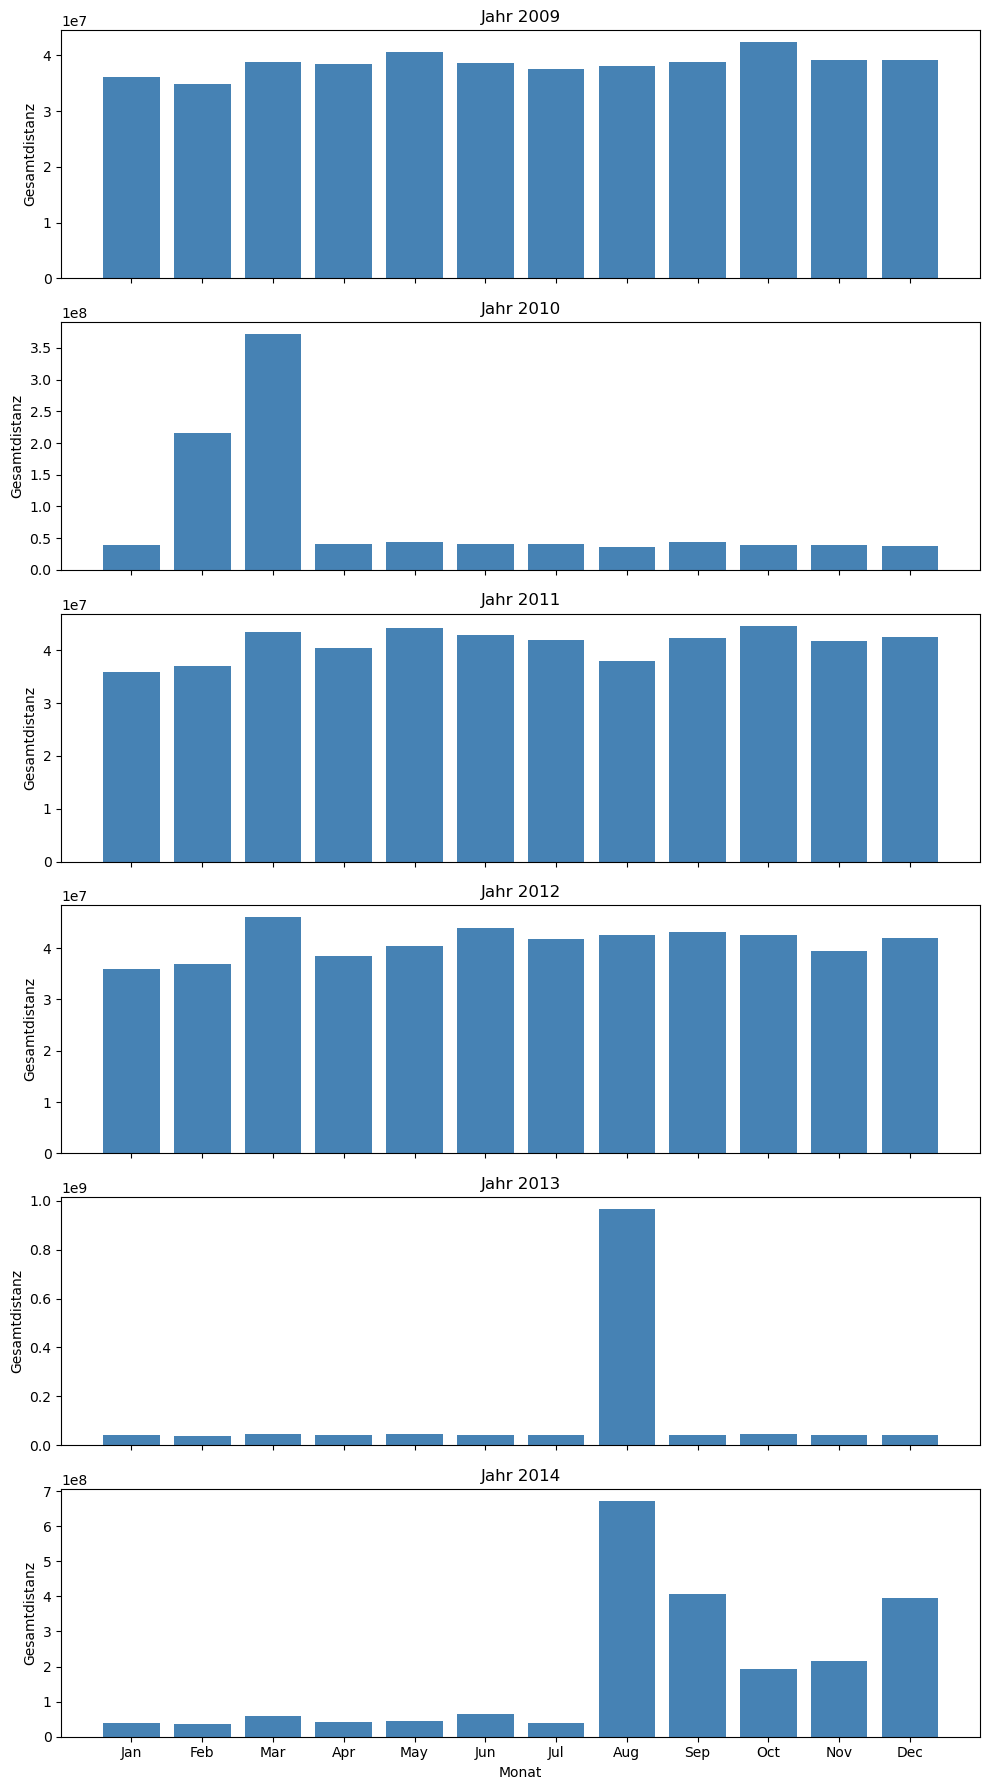

In [61]:
monthly_distance = df_train.groupby(['year', 'month'])['total_distance'].sum().reset_index()

fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(10, 18), sharex=True)
years = sorted(df_train['year'].unique())
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, year in enumerate(years):
    data = monthly_distance[monthly_distance['year'] == year]
    axs[i].bar(data['month'], data['total_distance'], color='steelblue')
    axs[i].set_title(f'Jahr {year}')
    axs[i].set_ylabel('Gesamtdistanz')
    axs[i].set_xticks(range(1, 13))
    axs[i].set_xticklabels(months)

axs[-1].set_xlabel('Monat')
plt.tight_layout()
plt.show()

Die Visualisierung der monatlich aggregierten Gesamtdistanz (`total_distance`) pro Jahr zeigt deutliche Unregelmäßigkeiten. Während die Jahre 2009 bis 2012 ein weitgehend konsistentes Bild liefern, fallen insbesondere 2010, 2013 und 2014 durch starke Ausreißer auf. In einzelnen Monaten dieser Jahre treten ungewöhnlich hohe Werte auf, während andere Monate auffällig geringe Summen oder fast vollständige Lücken zeigen.

Diese Auffälligkeiten deuten auf inkonsistente oder fehlerhafte Rohdaten in den betreffenden Jahresdateien hin. Mögliche Ursachen sind:

- unplausibel niedrige Einzelwerte in der Spalte `trip_distance`, etwa durch fehlerhafte GPS-Daten oder Dubletten,
- unvollständig geladene Monatsdateien, was zu verzerrter Aggregation führt,
- fehlende oder fehlerhafte Zeitstempel, durch die Fahrten nicht korrekt stündlich zugeordnet wurden.

Zur Klärung dieser Anomalien ist eine erneute, gezielte Überprüfung der Rohdaten auf Monatsebene erforderlich. Dazu gehören unter anderem:

- die Analyse der Verteilung der `trip_distance`-Werte pro Monat,
- eine gezielte Prüfung von Maximal- und Minimalwerten,
- das Identifizieren fehlender oder auffälliger Werte (NaNs),
- sowie gegebenenfalls die manuelle Sichtung einzelner Datendateien.

Durch diese erneute Prüfung soll die Datenqualität abgesichert werden um somit spätere Fehler in der Modellierung zu vermeiden.

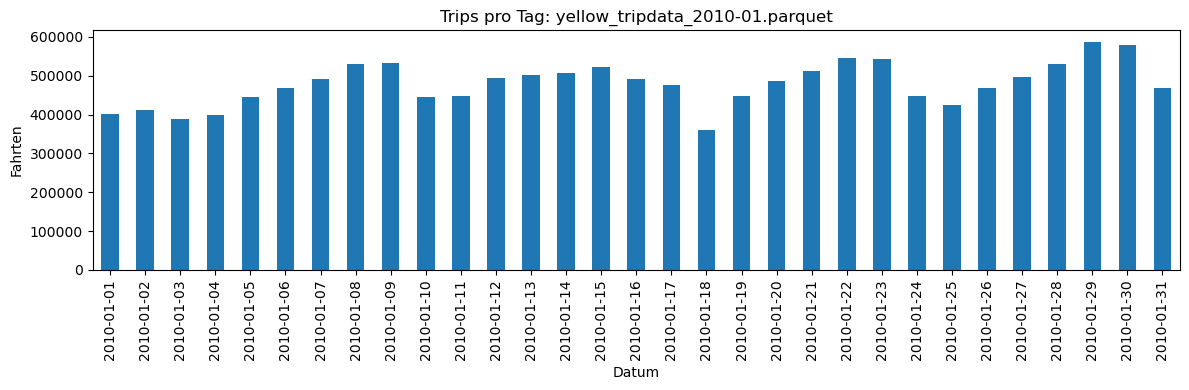


yellow_tripdata_2010-01.parquet:
  Anzahl Fahrten: 14863778
  Zeitraum: 2010-01-01 00:00:00 bis 2010-01-31 23:59:59
  Fehlende Datumswerte: 0


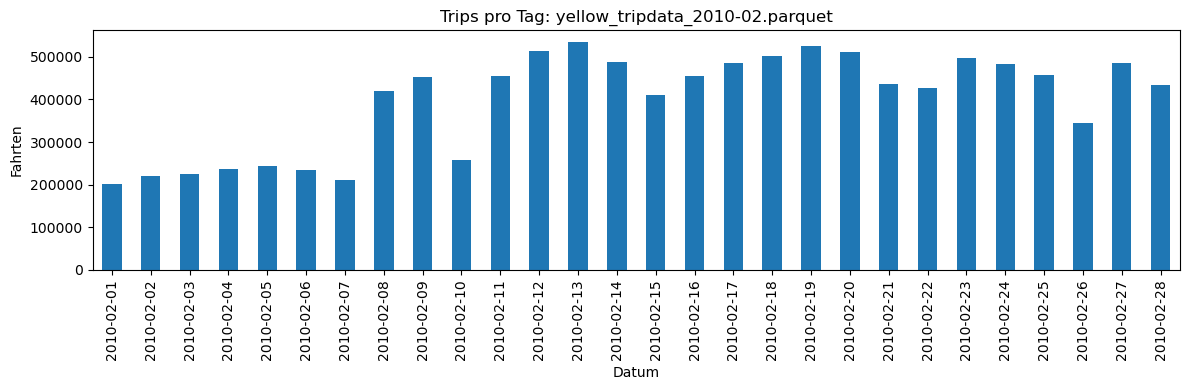


yellow_tripdata_2010-02.parquet:
  Anzahl Fahrten: 11145409
  Zeitraum: 2010-02-01 00:00:00 bis 2010-02-28 23:59:59
  Fehlende Datumswerte: 0


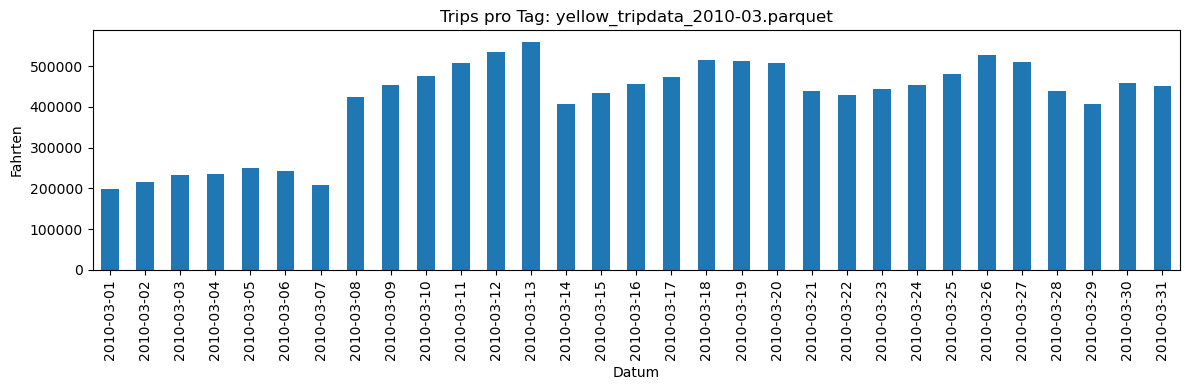


yellow_tripdata_2010-03.parquet:
  Anzahl Fahrten: 12884362
  Zeitraum: 2010-03-01 00:00:00 bis 2010-03-31 23:59:59
  Fehlende Datumswerte: 0


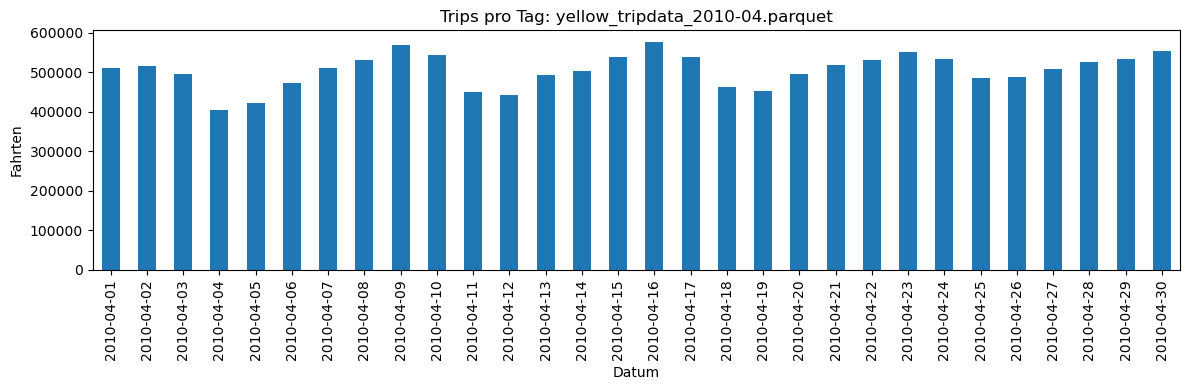


yellow_tripdata_2010-04.parquet:
  Anzahl Fahrten: 15144990
  Zeitraum: 2010-04-01 00:00:00 bis 2010-04-30 23:59:59
  Fehlende Datumswerte: 0


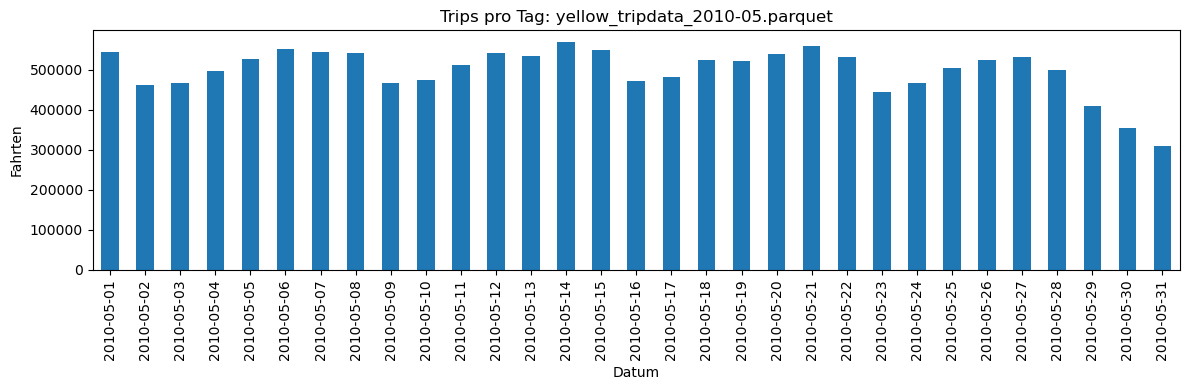


yellow_tripdata_2010-05.parquet:
  Anzahl Fahrten: 15481351
  Zeitraum: 2010-05-01 00:00:00 bis 2010-05-31 23:59:59
  Fehlende Datumswerte: 0


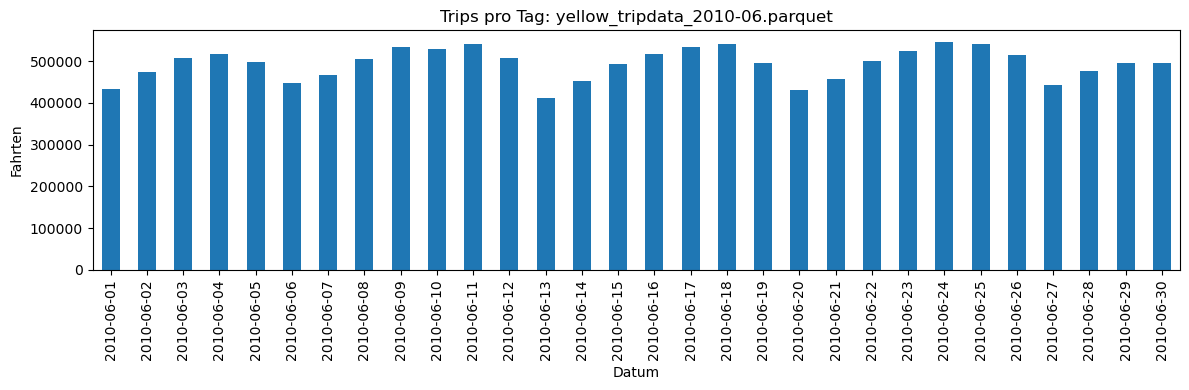


yellow_tripdata_2010-06.parquet:
  Anzahl Fahrten: 14825128
  Zeitraum: 2010-06-01 00:00:00 bis 2010-06-30 23:59:59
  Fehlende Datumswerte: 0


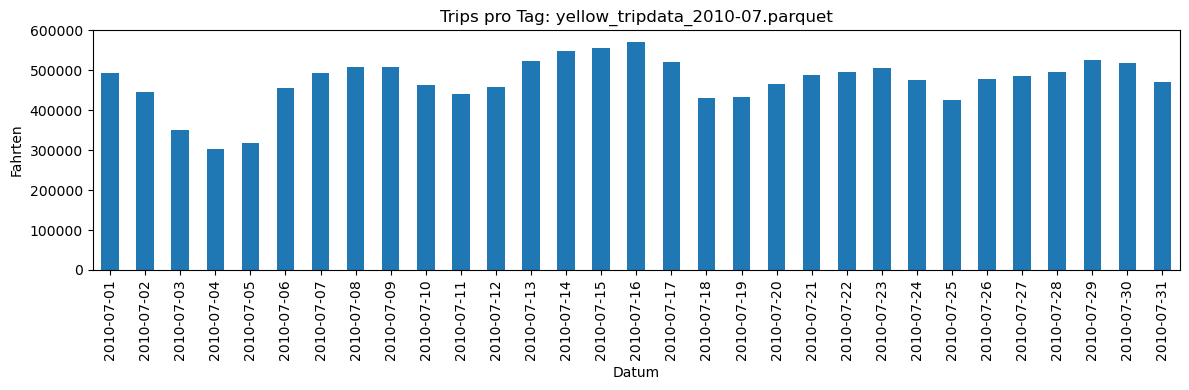


yellow_tripdata_2010-07.parquet:
  Anzahl Fahrten: 14656519
  Zeitraum: 2010-07-01 00:00:00 bis 2010-07-31 23:59:59
  Fehlende Datumswerte: 0


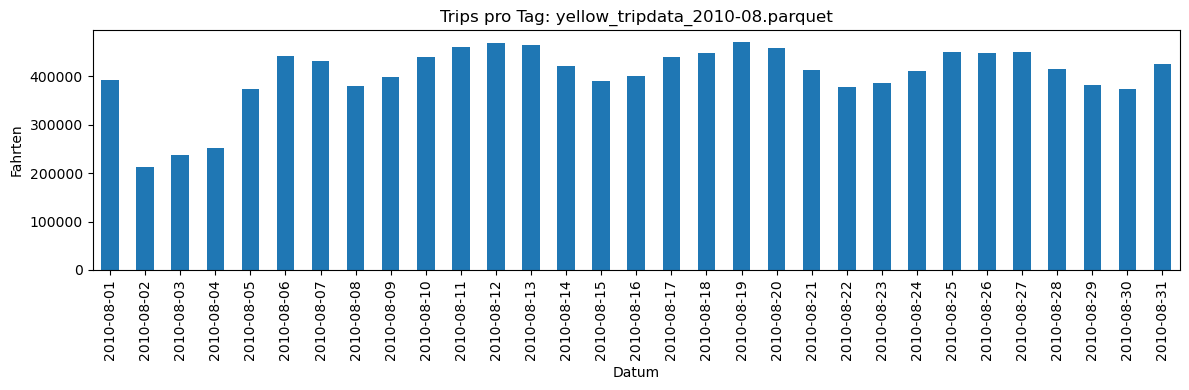


yellow_tripdata_2010-08.parquet:
  Anzahl Fahrten: 12528177
  Zeitraum: 2010-08-01 00:00:00 bis 2010-08-31 23:59:59
  Fehlende Datumswerte: 0


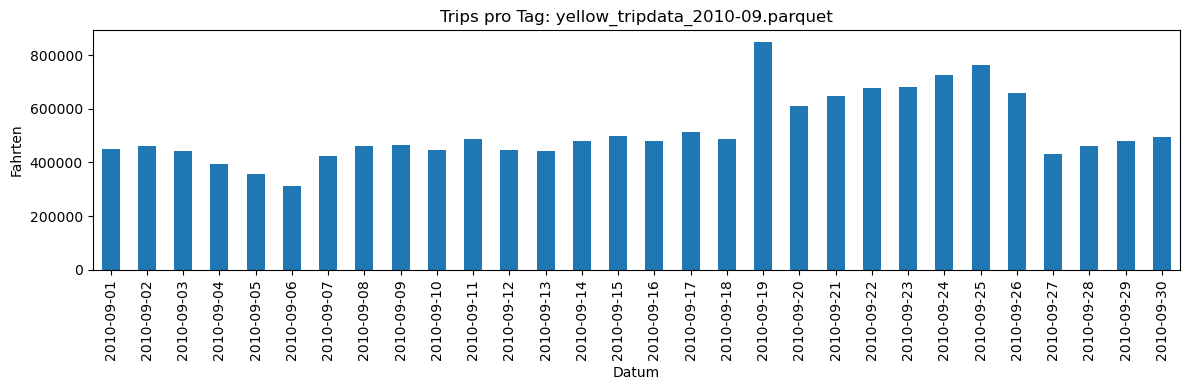


yellow_tripdata_2010-09.parquet:
  Anzahl Fahrten: 15540209
  Zeitraum: 2010-09-01 00:00:00 bis 2010-09-30 23:59:58
  Fehlende Datumswerte: 0


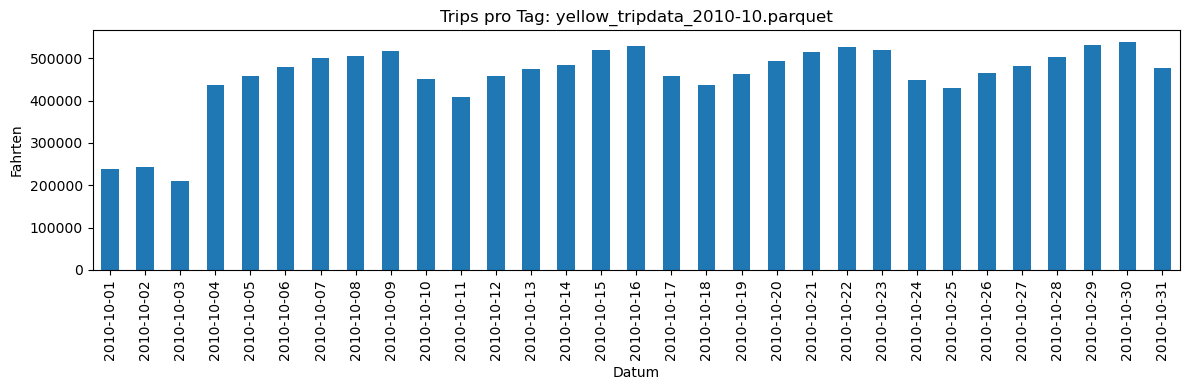


yellow_tripdata_2010-10.parquet:
  Anzahl Fahrten: 14199607
  Zeitraum: 2010-10-01 00:00:00 bis 2010-10-31 23:59:59
  Fehlende Datumswerte: 0


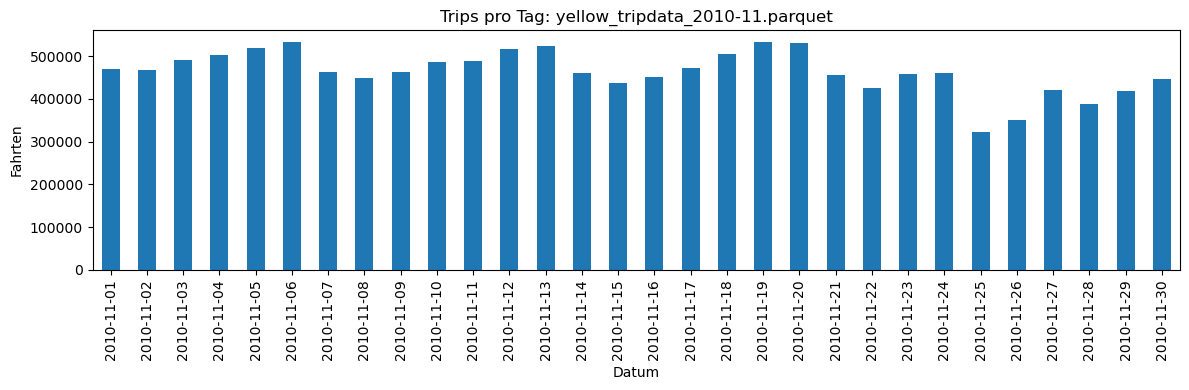


yellow_tripdata_2010-11.parquet:
  Anzahl Fahrten: 13912310
  Zeitraum: 2010-11-01 00:00:00 bis 2010-11-30 23:59:59
  Fehlende Datumswerte: 0


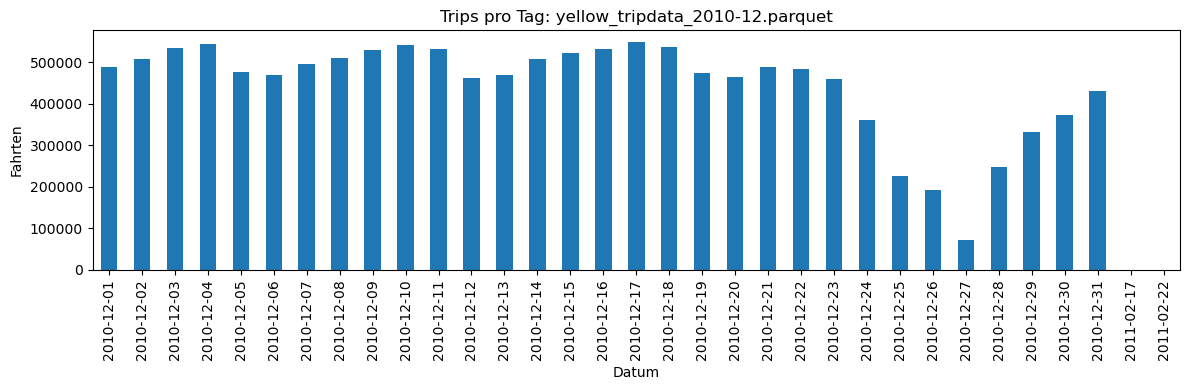


yellow_tripdata_2010-12.parquet:
  Anzahl Fahrten: 13819322
  Zeitraum: 2010-12-01 00:00:00 bis 2011-02-22 21:01:27
  Fehlende Datumswerte: 0


In [62]:
file_paths = sorted(glob.glob("yellow_tripdata_2010-*.parquet"))

for file in file_paths:
    df = pd.read_parquet(file)
    
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    
    df['pickup_date'] = df['pickup_datetime'].dt.date
    daily_counts = df.groupby('pickup_date').size()

    plt.figure(figsize=(12, 4))
    daily_counts.plot(kind='bar')
    plt.title(f"Trips pro Tag: {file}")
    plt.ylabel("Fahrten")
    plt.xlabel("Datum")
    plt.tight_layout()
    plt.show()

    print(f"\n{file}:")
    print(f"  Anzahl Fahrten: {len(df)}")
    print(f"  Zeitraum: {df['pickup_datetime'].min()} bis {df['pickup_datetime'].max()}")
    print(f"  Fehlende Datumswerte: {df['pickup_datetime'].isna().sum()}")

Bei der Überprüfung der Monatsdateien aus dem Jahr 2010 konnten bislang keine eindeutigen Auffälligkeiten festgestellt werden, die die stark abweichenden aggregierten Werte vollständig erklären würden. Die Verteilung der Fahrten wirkt auf den ersten Blick weitgehend unauffällig.

Allerdings fiel auf, dass in der Datei für Dezember 2010 auch Fahrten aus dem Februar 2011 enthalten sind. Dies deutet auf mögliche Fehler in der Datumszuordnung oder auf eine fehlerhafte Zusammenstellung der Quelldaten hin.

Im nächsten Schritt wird daher die Spaltenstruktur der betroffenen Monatsdateien genauer untersucht.

In [63]:
file_paths = sorted(glob.glob("yellow_tripdata_2010-*.parquet"))

for file in file_paths:
    try:
        df = pd.read_parquet(file)
        print(f"\n{file}:")
        print(df.columns.tolist())
    except Exception as e:
        print(f"\n{file}: Fehler beim Laden – {e}")


yellow_tripdata_2010-01.parquet:
['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']

yellow_tripdata_2010-02.parquet:
['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']

yellow_tripdata_2010-03.parquet:
['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',

Die Analyse der Spaltenstruktur in den Monatsdateien des Jahres 2010 zeigt keine Auffälligkeiten. Die Spaltennamen sind durchgehend konsistent und entsprechen der erwarteten Struktur laut dem offiziellen Data Dictionary der NYC Taxi and Limousine Commission (TLC). Es wurden weder fehlende noch anders benannte Felder festgestellt.

Da somit keine strukturellen Probleme in den Dateien selbst vorliegen, richtet sich der Fokus nun auf eine detaillierte Untersuchung der Spalte `trip_distance`.


yellow_tripdata_2010-01.parquet:
  Anzahl Fahrten: 14863778
  Min. Distanz: 0.00 mi
  Max. Distanz: 50.00 mi
  Mittelwert: 2.63 mi
  Median: 1.68 mi
  95. Perzentil: 8.70 mi
  Null- oder Negativwerte: 83887


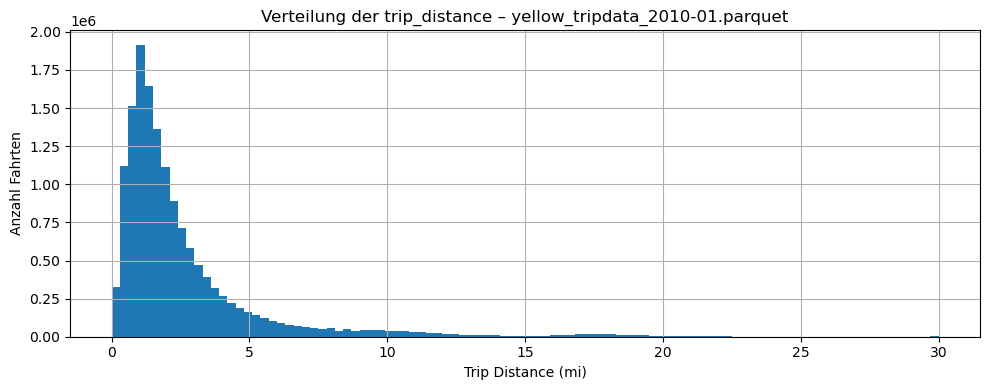


yellow_tripdata_2010-02.parquet:
  Anzahl Fahrten: 11145409
  Min. Distanz: 0.00 mi
  Max. Distanz: 13330083.20 mi
  Mittelwert: 19.38 mi
  Median: 1.68 mi
  95. Perzentil: 8.50 mi
  Null- oder Negativwerte: 65542


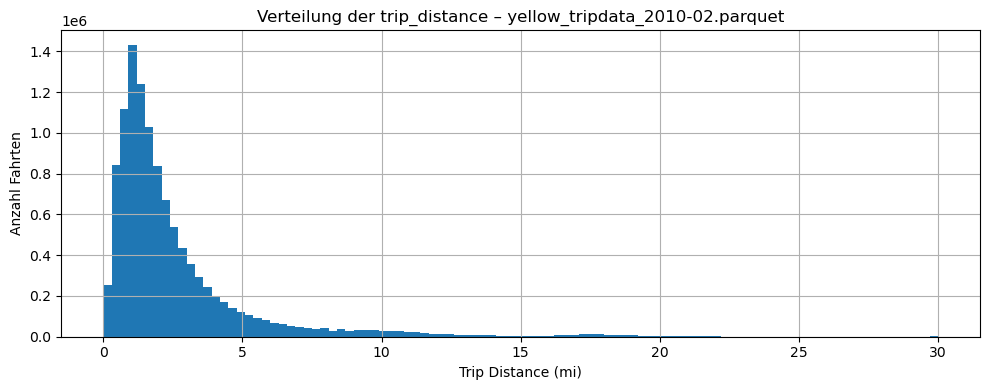


yellow_tripdata_2010-03.parquet:
  Anzahl Fahrten: 12884362
  Min. Distanz: -21474834.00 mi
  Max. Distanz: 16201631.40 mi
  Mittelwert: 28.90 mi
  Median: 1.70 mi
  95. Perzentil: 9.10 mi
  Null- oder Negativwerte: 77864


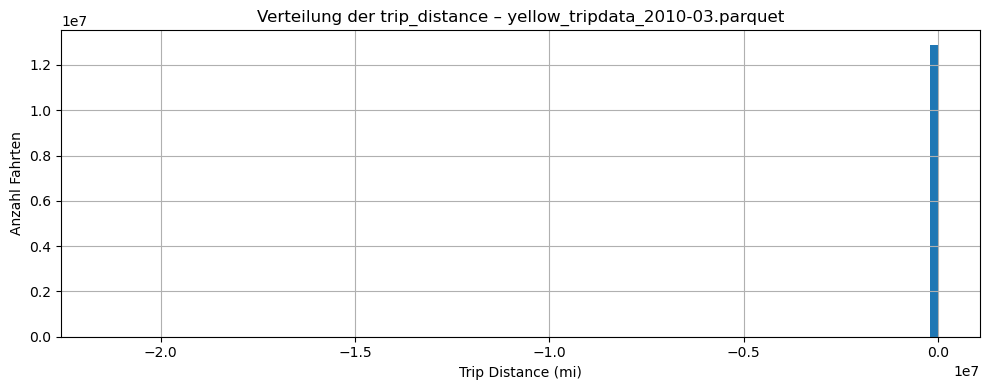


yellow_tripdata_2010-04.parquet:
  Anzahl Fahrten: 15144990
  Min. Distanz: 0.00 mi
  Max. Distanz: 50.00 mi
  Mittelwert: 2.75 mi
  Median: 1.73 mi
  95. Perzentil: 9.20 mi
  Null- oder Negativwerte: 78057


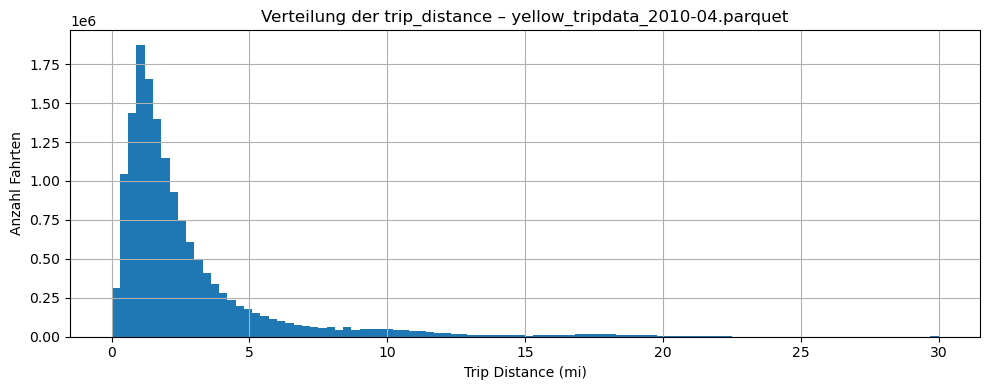


yellow_tripdata_2010-05.parquet:
  Anzahl Fahrten: 15481351
  Min. Distanz: 0.00 mi
  Max. Distanz: 50.00 mi
  Mittelwert: 2.82 mi
  Median: 1.79 mi
  95. Perzentil: 9.50 mi
  Null- oder Negativwerte: 84069


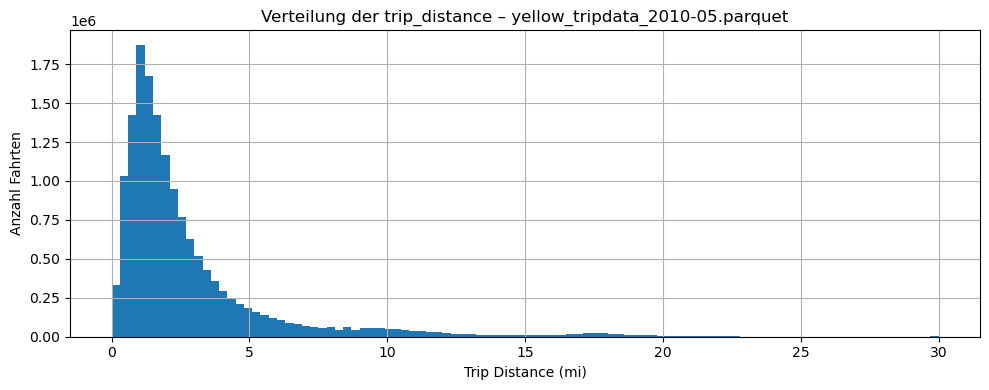


yellow_tripdata_2010-06.parquet:
  Anzahl Fahrten: 14825128
  Min. Distanz: 0.00 mi
  Max. Distanz: 50.00 mi
  Mittelwert: 2.80 mi
  Median: 1.75 mi
  95. Perzentil: 9.50 mi
  Null- oder Negativwerte: 76821


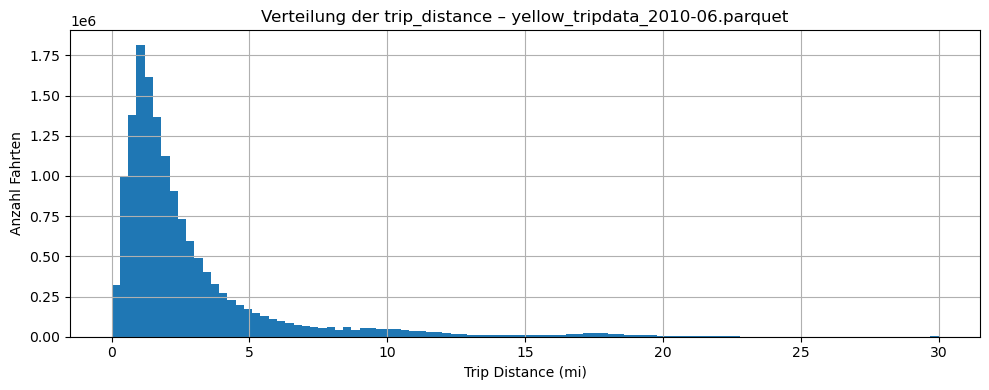


yellow_tripdata_2010-07.parquet:
  Anzahl Fahrten: 14656519
  Min. Distanz: 0.00 mi
  Max. Distanz: 50.00 mi
  Mittelwert: 2.79 mi
  Median: 1.77 mi
  95. Perzentil: 9.36 mi
  Null- oder Negativwerte: 78165


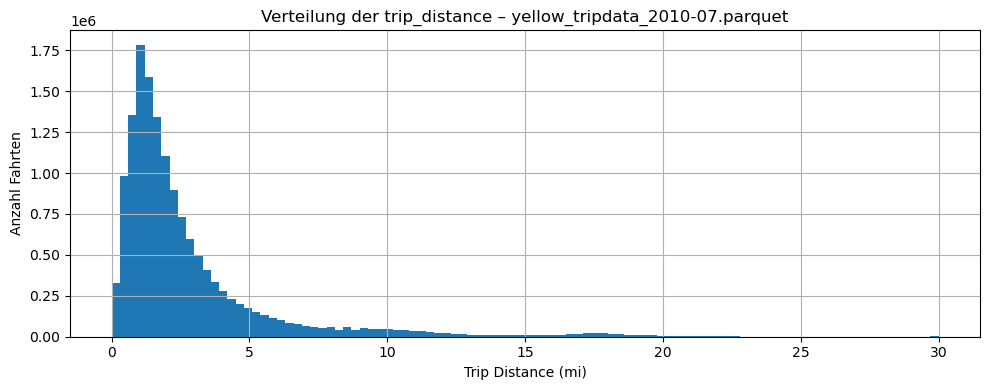


yellow_tripdata_2010-08.parquet:
  Anzahl Fahrten: 12528177
  Min. Distanz: 0.00 mi
  Max. Distanz: 100.00 mi
  Mittelwert: 2.84 mi
  Median: 1.80 mi
  95. Perzentil: 9.56 mi
  Null- oder Negativwerte: 68165


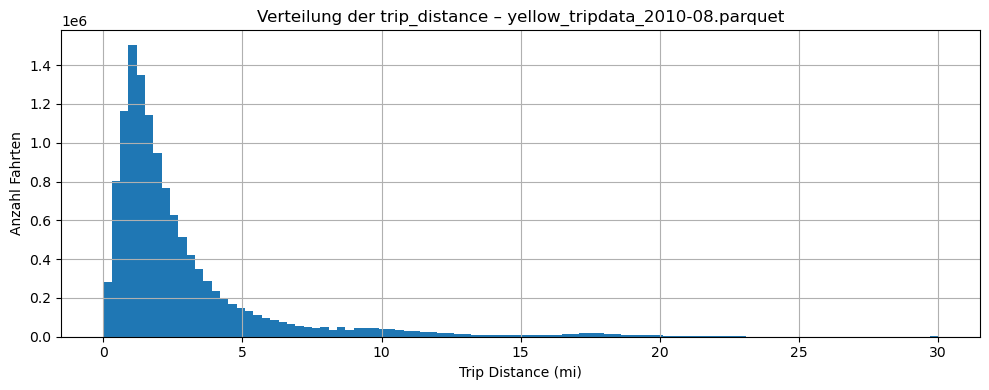


yellow_tripdata_2010-09.parquet:
  Anzahl Fahrten: 15540209
  Min. Distanz: 0.00 mi
  Max. Distanz: 100.00 mi
  Mittelwert: 2.83 mi
  Median: 1.80 mi
  95. Perzentil: 9.53 mi
  Null- oder Negativwerte: 76120


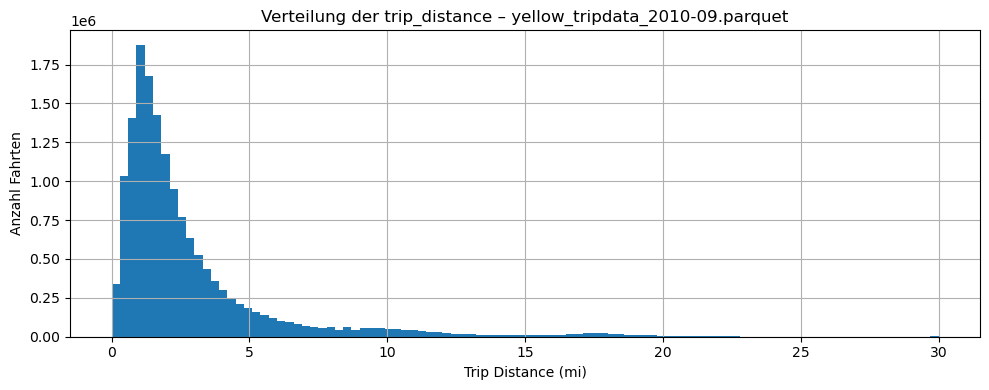


yellow_tripdata_2010-10.parquet:
  Anzahl Fahrten: 14199607
  Min. Distanz: 0.00 mi
  Max. Distanz: 100.00 mi
  Mittelwert: 2.81 mi
  Median: 1.78 mi
  95. Perzentil: 9.41 mi
  Null- oder Negativwerte: 64142


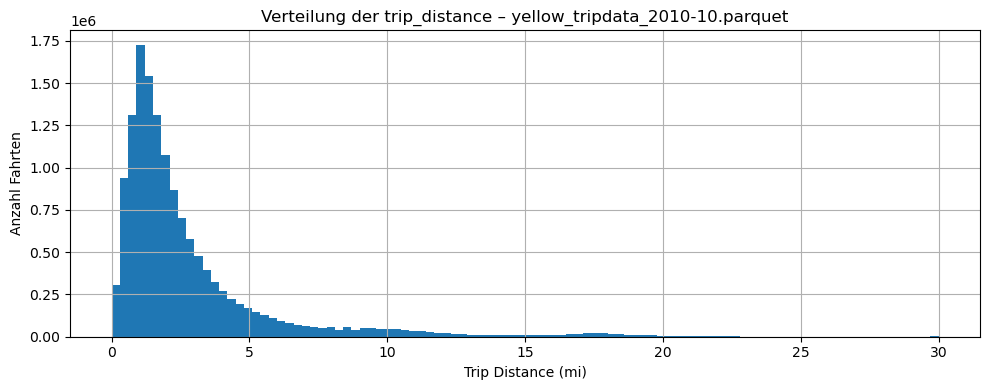


yellow_tripdata_2010-11.parquet:
  Anzahl Fahrten: 13912310
  Min. Distanz: 0.00 mi
  Max. Distanz: 100.00 mi
  Mittelwert: 2.79 mi
  Median: 1.73 mi
  95. Perzentil: 9.48 mi
  Null- oder Negativwerte: 64096


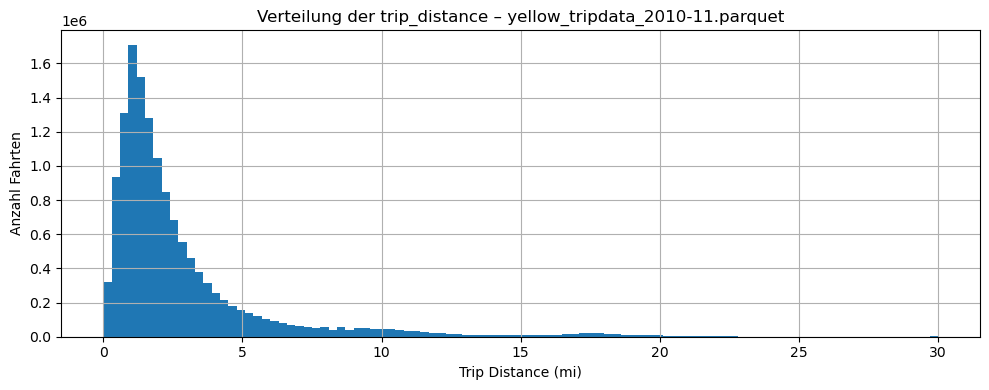


yellow_tripdata_2010-12.parquet:
  Anzahl Fahrten: 13819322
  Min. Distanz: 0.00 mi
  Max. Distanz: 100.00 mi
  Mittelwert: 2.73 mi
  Median: 1.70 mi
  95. Perzentil: 9.30 mi
  Null- oder Negativwerte: 70777


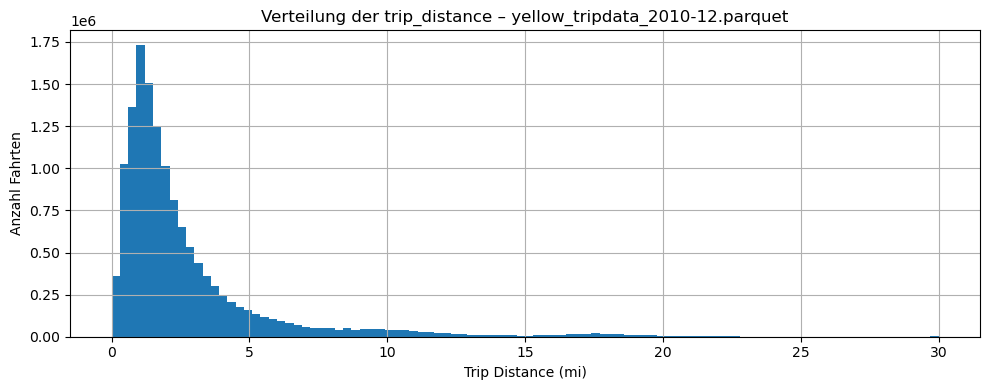

In [64]:
file_paths = sorted(glob.glob("yellow_tripdata_2010-*.parquet"))

for file in file_paths:
    try:
        df = pd.read_parquet(file)
        distances = df['trip_distance']

        print(f"\n{file}:")
        print(f"  Anzahl Fahrten: {len(distances)}")
        print(f"  Min. Distanz: {distances.min():.2f} mi")
        print(f"  Max. Distanz: {distances.max():.2f} mi")
        print(f"  Mittelwert: {distances.mean():.2f} mi")
        print(f"  Median: {distances.median():.2f} mi")
        print(f"  95. Perzentil: {distances.quantile(0.95):.2f} mi")
        print(f"  Null- oder Negativwerte: {(distances <= 0).sum()}")

        plt.figure(figsize=(10, 4))
        distances.clip(upper=30).hist(bins=100)
        plt.title(f"Verteilung der trip_distance – {file}")
        plt.xlabel("Trip Distance (mi)")
        plt.ylabel("Anzahl Fahrten")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\n{file}: Fehler beim Verarbeiten – {e}")

Die Untersuchung der Spalte `trip_distance` zeigt, dass die meisten Monatsdateien des Jahres 2010 unauffällige und realistische Werte enthalten. Der Median liegt durchgehend bei etwa 1,7–1,8 Meilen, und 95 % aller Fahrten bleiben unterhalb von ca. 9,5 Meilen. In vielen Monaten treten jedoch mehrere zehntausend Fahrten mit Null- oder Negativwerten auf, sodass die Daten defintiv erneut bereinigt werden müssen.

Besonders auffällig sind die Monate *Februar* und *März 2010*:

- Im Februar erreicht der Maximalwert der `trip_distance` über 13 Millionen Meilen und somit vermutlich ein fehlerhafter Eintrag.
- Im März reichen die Werte sogar in den negativen zweistelligen Millionenbereich (bis –21 Mio. Meilen), während der Maximalwert bei über 16 Millionen Meilen liegt.
- Trotz dieser Extremwerte bleibt der Median in beiden Monaten mit etwa 1,7 Meilen stabil, was auf vereinzelte, aber sehr starke Ausreißer hinweist. Der Mittelwert hingegen ist stark verzerrt (Februar: 19,4 Mio; März: 28,9 Mio).

Diese Ausreißer sind sehr wahrscheinlich verantwortlich für die auffällig hohen aggregierten Metriken in der monatlichen Visualisierung und würden damit auch die beobachteten Anomalien bei der Fahrtanzahl erklären.

Im nächsten Schritt sollen diese Extremwerte gezielt identifiziert und gefiltert werden, um eine bereinigte Datengrundlage zu schaffen. Ein praktikabler Ansatz könnte beispielsweise der Ausschluss aller `trip_distance`-Werte größer als 100 Meilen oder kleiner als 0 Meilen sein.

In [65]:
df = pd.read_parquet("yellow_tripdata_2010-02.parquet")

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')

top_distances = df.sort_values(by='trip_distance', ascending=False).head(20)
print("Top 20 größte trip_distance:")
print(top_distances)

bottom_distances = df.sort_values(by='trip_distance', ascending=True).head(20)
print("\nTop 20 kleinste (inkl. negative) trip_distance:")
print(bottom_distances)

Top 20 größte trip_distance:
         vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
3453114        CMT 2010-02-08 15:52:06 2010-02-08 16:03:22                1   
10578296       CMT 2010-02-09 14:11:05 2010-02-09 14:26:57                2   
4537650        CMT 2010-02-11 14:16:05 2010-02-11 14:31:58                1   
7075174        CMT 2010-02-05 05:25:23 2010-02-05 05:36:05                3   
7788024        CMT 2010-02-25 20:06:29 2010-02-25 20:20:37                1   
4045882        CMT 2010-02-24 19:14:21 2010-02-24 19:18:09                1   
10969320       CMT 2010-02-18 22:07:45 2010-02-18 22:25:56                3   
6219407        CMT 2010-02-26 02:27:48 2010-02-26 02:57:35                1   
11105407       CMT 2010-02-28 21:05:30 2010-02-28 21:15:59                1   
7303675        CMT 2010-02-18 22:39:08 2010-02-18 22:48:51                1   
3924250        CMT 2010-02-15 00:00:52 2010-02-15 00:04:56                1   
7329228        CMT 2010

**Bereinigungskonzept für die NYC Taxi-Daten**

Die detaillierte Analyse der `trip_distance`-Werte zeigt, dass einzelne Monate extreme Ausreißer enthalten, die das Gesamtbild deutlich verzerren. Für ein belastbares Modell ist daher eine systematische und nachvollziehbare Datenbereinigung erforderlich.

Dazu wird zunächst eine jahrweise Analyse aller Monatsdateien durchgeführt. Anhand statistischer Kennzahlen wie Median, Minimum, Maximum und dem 95. Perzentil werden auffällige Monate identifiziert. Im Anschluss werden konkrete Filterregeln definiert: Fahrten mit einer Distanz kleiner oder gleich null oder größer als 100 Meilen sowie Einträge mit negativem Fahrpreis werden ausgeschlossen. Zusätzlich werden Datensätze mit fehlenden oder nullgesetzten Koordinaten entfernt. Optional kann auch geprüft werden, ob der Abholzeitpunkt innerhalb des jeweiligen Monats liegt, um falsch zugeordnete Fahrten zu erkennen.

Alle angewendeten Regeln werden dokumentiert. Für jeden Monat wird zudem ausgewiesen, welcher Anteil der Fahrten durch die Bereinigung entfällt. Ziel ist ein konsistenter, fehlerfreier Trainingsdatensatz als Grundlage für die Modellierung.

## 6. Systematisches Preprocessing

Im bisherigen Projektverlauf lag der Fokus zunächst auf der zeitlichen Aggregation der Taxidaten, um möglichst schnell ein Modelltraining zu ermöglichen. Das Thema Preprocessing und Datenbereinigung wurde dabei nur am Rande behandelt. Die aktuellen Analysen zeigen jedoch, dass die Rohdaten erhebliche Unstimmigkeiten und Ausreißer enthalten, die die Aussagekraft eines Modells deutlich beeinträchtigen würden.

Aus diesem Grund wird an dieser Stelle ein gezielter Neustart gemacht, bei dem ein gründliches, standardisiertes und automatisierbares Preprocessing herauskommen soll. Dieser Schritt ist notwendig, da extreme Ausreißer wie mehrmillionenlange Fahrten die Kennzahlen verzerren, unplausible Kombinationen wie Null-Koordinaten bei hohen Fahrpreisen auf strukturelle Datenprobleme hinweisen und die Datenqualität zwischen den Jahren stark schwankt.

Ein stabiler und verlässlicher Machine-Learning-Workflow setzt eine hochwertige Datenbasis voraus. Ziel ist es daher, eine Preprocessing-Pipeline zu entwickeln, die systematisch Fehler erkennt, bereinigt und die Daten für weitere Schritte aufbereitet. Die Umsetzung soll so gestaltet sein, dass sich der Prozess später mithilfe von MLflow automatisieren, versionieren und auf andere Zeiträume übertragen lässt. So entsteht eine wiederverwendbare, transparente und reproduzierbare Grundlage für alle nachfolgenden Modellierungsschritte.

In [3]:
mlflow.set_experiment("Test Experiment")
with mlflow.start_run(run_name="manual_test"):
    mlflow.log_param("test_param", 1)
    mlflow.log_metric("test_metric", 0.99)

print("Test-Run abgeschlossen")

Test-Run abgeschlossen


Mit dem folgenden Code wird ein robustes Preprocessing eingeführt, das zentrale Filterkriterien wie eine maximale Strecke (`trip_distance`) sowie unplausible Koordinaten berücksichtigt. Zusätzlich wurde erstmals eine vollständige Integration mit MLflow umgesetzt. Dabei werden alle relevanten Parameter, Metriken sowie das bereinigte Datenset versioniert und als Artefakte gespeichert.

Die Datenverarbeitung im Preprocessing ist damit transparent dokumentiert und reproduzierbar gestaltet. Künftige Änderungen am Prozess oder neue Datenstände lassen sich nachvollziehen und gezielt weiterverarbeiten.

In [4]:
FILE = "yellow_tripdata_2010-02.parquet"
MAX_DISTANCE = 100.0
REMOVE_ZERO_COORDS = True

mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("NYC Taxi Preprocessing")

with mlflow.start_run(run_name=f"preprocessing_{FILE}"):
    mlflow.log_param("file", FILE)
    mlflow.log_param("max_trip_distance", MAX_DISTANCE)
    mlflow.log_param("remove_zero_coords", REMOVE_ZERO_COORDS)

    df = pd.read_parquet(FILE)
    original_count = len(df)

    df_clean = df[(df['trip_distance'] > 0) & (df['trip_distance'] <= MAX_DISTANCE)]

    if REMOVE_ZERO_COORDS:
        df_clean = df_clean[(df_clean['pickup_longitude'] != 0) & (df_clean['pickup_latitude'] != 0)]

    cleaned_count = len(df_clean)
    removed_rows = original_count - cleaned_count

    mlflow.log_metric("original_rows", original_count)
    mlflow.log_metric("cleaned_rows", cleaned_count)
    mlflow.log_metric("rows_removed", removed_rows)

    output_path = Path("cleaned") / f"cleaned_{FILE}"
    output_path.parent.mkdir(exist_ok=True)
    df_clean.to_parquet(output_path, index=False)

    mlflow.log_artifact(str(output_path))

print("Preprocessing abgeschlossen und MLflow-Run gespeichert.")

Preprocessing abgeschlossen und MLflow-Run gespeichert.


Um sicherzustellen, dass die Filterung korrekt funktioniert, werden gezielte Tests durchgeführt. Dabei wird unter anderem überprüft, ob die Werte für `trip_distance` innerhalb der definierten Grenzen liegen und ob Koordinaten mit Nullwerten vollständig entfernt wurden. Zusätzlich kommen Assertions zum Einsatz, um fehlerhafte Werte automatisiert zu erkennen.

Durch die Validierungen kann die Datenqualität abgesichert und spätere Verzerrungen im Modell durch fehlerhafte Eingabedaten vermieden werden.

In [5]:
df_check = pd.read_parquet(output_path)
df_check.info()
df_check.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10878442 entries, 0 to 10878441
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   vendor_id           object 
 1   pickup_datetime     object 
 2   dropoff_datetime    object 
 3   passenger_count     int64  
 4   trip_distance       float64
 5   pickup_longitude    float64
 6   pickup_latitude     float64
 7   rate_code           int64  
 8   store_and_fwd_flag  object 
 9   dropoff_longitude   float64
 10  dropoff_latitude    float64
 11  payment_type        object 
 12  fare_amount         float64
 13  surcharge           float64
 14  mta_tax             float64
 15  tip_amount          float64
 16  tolls_amount        float64
 17  total_amount        float64
dtypes: float64(11), int64(2), object(5)
memory usage: 1.5+ GB


,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07,1.087844e+07
mean,1.638305e+00,2.622779e+00,-7.397145e+01,4.074910e+01,1.035843e+00,-7.396803e+01,4.074786e+01,9.413413e+00,3.195272e-01,4.981169e-01,5.554351e-01,-1.829314e+00,8.957178e+00
std,1.209393e+00,2.991518e+00,9.449795e-01,7.231967e-01,5.155358e-01,9.004460e-01,9.106141e-01,8.605227e+00,4.126545e-01,6.938099e-02,5.086725e+02,6.510982e+03,6.530831e+03
min,1.000000e+00,1.000000e-02,-7.401333e+02,-1.446250e-01,0.000000e+00,-1.235150e+03,-2.485694e+03,-2.465000e+02,-1.000000e+00,-5.000000e-01,-1.677720e+06,-2.147484e+07,-2.147483e+07
25%,1.000000e+00,1.000000e+00,-7.399223e+01,4.073694e+01,1.000000e+00,-7.399168e+01,4.073611e+01,5.300000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,6.600000e+00
50%,1.000000e+00,1.700000e+00,-7.398213e+01,4.075364e+01,1.000000e+00,-7.398080e+01,4.075397e+01,7.300000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.700000e+00
75%,2.000000e+00,2.970000e+00,-7.396897e+01,4.076751e+01,1.000000e+00,-7.396625e+01,4.076848e+01,1.050000e+01,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.230000e+01
max,1.690000e+02,1.000000e+02,1.375621e+03,1.375733e+03,1.280000e+02,1.659608e+02,4.739920e+02,9.316630e+03,6.157800e+02,3.172000e+01,9.380200e+02,5.311960e+03,9.317130e+03


In [6]:
print("Min:", df_check['trip_distance'].min())
print("Max:", df_check['trip_distance'].max())

Min: 0.01
Max: 100.0


In [7]:
if REMOVE_ZERO_COORDS:
    print("Pickup Koordinaten == 0:", (df_check['pickup_longitude'] == 0).sum())

Pickup Koordinaten == 0: 0


In [8]:
assert df_check['trip_distance'].between(0.01, MAX_DISTANCE).all(), "Unzulässige trip_distance gefunden!"

Im nächsten Schritt wird das Preprocessing so erweitert, dass nicht nur die bereinigten Daten gespeichert werden, sondern auch alle entfernten Zeilen separat dokumentiert sind. Diese sollten dann besonders auffällige oder problematische Fahrten, etwa mit unrealistisch langen Strecken oder fehlenden Koordinaten, enthalten.

Die Speicherung dieser Daten als separates MLflow-Artefakt ermöglicht eine gezielte Nachanalyse und erhöht die Nachvollziehbarkeit der eingesetzten Filterregeln.

In [9]:
FILE = "yellow_tripdata_2010-02.parquet"
MAX_DISTANCE = 100.0
REMOVE_ZERO_COORDS = True

mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("NYC Taxi Preprocessing")

with mlflow.start_run(run_name=f"preprocessing_{FILE}"):
    mlflow.log_param("file", FILE)
    mlflow.log_param("max_trip_distance", MAX_DISTANCE)
    mlflow.log_param("remove_zero_coords", REMOVE_ZERO_COORDS)

    df = pd.read_parquet(FILE)
    original_count = len(df)

    filtered_distance = df[(df['trip_distance'] <= 0) | (df['trip_distance'] > MAX_DISTANCE)]
    filtered_coords = pd.DataFrame()

    df_clean = df.copy()
    df_clean = df_clean[(df_clean['trip_distance'] > 0) & (df_clean['trip_distance'] <= MAX_DISTANCE)]

    if REMOVE_ZERO_COORDS:
        filtered_coords = df_clean[(df_clean['pickup_longitude'] == 0) | (df_clean['pickup_latitude'] == 0)]
        df_clean = df_clean[(df_clean['pickup_longitude'] != 0) & (df_clean['pickup_latitude'] != 0)]

    cleaned_count = len(df_clean)
    removed_rows = original_count - cleaned_count

    removed_df = pd.concat([filtered_distance, filtered_coords]).drop_duplicates()
    removed_path = Path("cleaned") / f"removed_{FILE}"
    removed_path.parent.mkdir(exist_ok=True)
    removed_df.to_parquet(removed_path, index=False)

    mlflow.log_metric("original_rows", original_count)
    mlflow.log_metric("cleaned_rows", cleaned_count)
    mlflow.log_metric("rows_removed", removed_rows)

    output_path = Path("cleaned") / f"cleaned_{FILE}"
    output_path.parent.mkdir(exist_ok=True)
    df_clean.to_parquet(output_path, index=False)

    mlflow.log_artifact(str(output_path))
    mlflow.log_artifact(str(removed_path))

print("Preprocessing abgeschlossen und MLflow-Run gespeichert.")

Preprocessing abgeschlossen und MLflow-Run gespeichert.


Zur Überprüfung der Filterlogik wird eine gezielte Analyse der entfernten Zeilen durchgeführt. Dabei wird geprüft, ob beispielsweise lange Fahrten zu Recht ausgeschlossen werden oder ob sie durch andere Faktoren wie hohe Fahrpreise erklärbar sind.

Diese Auswertung dient dann als Grundlage für mögliche Anpassungen der Filtergrenzen, etwa bei der maximalen Distanz, und unterstützt die Entwicklung datengetriebener statt rein statischer Preprocessing-Regeln.

In [10]:
removed = pd.read_parquet("cleaned/removed_yellow_tripdata_2010-02.parquet")
removed.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,266939.000000,2.669390e+05,266939.000000,266939.000000,266939.000000,266939.000000,266939.000000,266939.000000,266939.000000,266939.000000,266939.000000,266939.000000,266939.000000
mean,1.621824,7.024776e+02,-17.556316,9.660364,1.254553,-18.734102,10.312308,12.589858,0.286274,0.472041,1.147837,0.279836,14.775854
std,1.246892,7.436681e+04,31.668330,18.019953,3.082850,32.415110,17.713417,92.720449,0.605883,0.428064,3.637885,2.102776,93.220691
min,0.000000,0.000000e+00,-1826.650122,-2495.690643,1.000000,-2069.478952,-0.037788,-210.000000,-1.000000,-0.500000,-49.000000,-17.000000,-210.500000
25%,1.000000,1.000000e-01,0.000000,0.000000,1.000000,-73.743332,0.000000,4.900000,0.000000,0.500000,0.000000,0.000000,5.800000
50%,1.000000,1.200000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,7.300000,0.000000,0.500000,0.000000,0.000000,8.600000
75%,2.000000,2.400000e+00,0.000000,0.000000,1.000000,0.000000,40.632071,11.700000,0.500000,0.500000,1.050000,0.000000,13.500000
max,51.000000,1.333008e+07,0.554830,473.985727,128.000000,0.094632,45.338965,43654.910000,81.050000,54.200000,500.000000,362.000000,43662.890000


In [11]:
print("\nAnalyse der entfernten Zeilen:")

print(f"Gesamtanzahl entfernter Zeilen: {len(removed_df)}")

entfernt_nach_distanz = filtered_distance.shape[0]
entfernt_nach_koordinaten = filtered_coords.shape[0]

print(f" → davon wegen ungültiger Distanz: {entfernt_nach_distanz}")
print(f" → davon wegen Null-Koordinaten (nach Distanzfilter): {entfernt_nach_koordinaten}")

print("\nBeispielhafte Fahrten mit trip_distance > MAX_DISTANCE:")
print(filtered_distance.sort_values("trip_distance", ascending=False).head(5)[[
    "pickup_datetime", "dropoff_datetime", "trip_distance", "fare_amount", "total_amount"
]])

if not filtered_coords.empty:
    print("\nBeispielhafte Fahrten mit Null-Koordinaten:")
    print(filtered_coords.head(5)[[
        "pickup_datetime", "dropoff_datetime", "trip_distance", "fare_amount", "total_amount"
    ]])


Analyse der entfernten Zeilen:
Gesamtanzahl entfernter Zeilen: 266939
 → davon wegen ungültiger Distanz: 66242
 → davon wegen Null-Koordinaten (nach Distanzfilter): 200725

Beispielhafte Fahrten mit trip_distance > MAX_DISTANCE:
              pickup_datetime     dropoff_datetime  trip_distance  \
3453114   2010-02-08 15:52:06  2010-02-08 16:03:22     13330083.2   
10578296  2010-02-09 14:11:05  2010-02-09 14:26:57     11800000.9   
4537650   2010-02-11 14:16:05  2010-02-11 14:31:58     11800000.4   
7075174   2010-02-05 05:25:23  2010-02-05 05:36:05     10083357.0   
7788024   2010-02-25 20:06:29  2010-02-25 20:20:37      9700000.0   

          fare_amount  total_amount  
3453114           8.9         10.40  
10578296          9.3          9.80  
4537650          14.9         15.40  
7075174          10.1         12.76  
7788024           9.7         11.90  

Beispielhafte Fahrten mit Null-Koordinaten:
         pickup_datetime     dropoff_datetime  trip_distance  fare_amount  \
139  

Bei der Analyse der ausgeschlossenen Fahrten zeigt sich, dass viele Einträge mit fehlenden Koordinaten dennoch plausible Informationen enthalten – etwa gültige Werte für `trip_distance` und passende Angaben zum `fare_amount`. Solche Daten erscheinen grundsätzlich nutzbar und sollten nicht pauschal entfernt werden.

Auch besonders lange Distanzen sind nicht automatisch fehlerhaft. Einzelne extreme Werte über 10 Millionen Meilen sind offensichtlich unplausibel, doch Fahrten über 100 Meilen können dennoch nachvollziehbar sein, wenn Fahrpreis und Fahrtdauer im Verhältnis zur Strecke stehen.

Daraus ergibt sich ein angepasster Preprocessing-Ansatz: Lange Fahrten werden nur dann ausgeschlossen, wenn zusätzlich ein auffällig niedriger Preis oder eine ungewöhnlich kurze Dauer vorliegt. Fehlende Koordinaten führen ebenfalls nicht automatisch zum Ausschluss, sondern nur dann, wenn auch Strecke oder Preis unplausibel sind.

Dieser kombinierte Ansatz erhöht die Datenqualität, ohne valide Fahrten unnötig zu löschen.

In [12]:
FILE = "yellow_tripdata_2010-02.parquet"
MAX_DISTANCE = 100.0
REMOVE_ZERO_COORDS = True

mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("NYC Taxi Preprocessing")

with mlflow.start_run(run_name=f"preprocessing_{FILE}"):
    mlflow.log_param("file", FILE)
    mlflow.log_param("max_trip_distance", MAX_DISTANCE)
    mlflow.log_param("remove_zero_coords", REMOVE_ZERO_COORDS)

    df = pd.read_parquet(FILE)
    original_count = len(df)

    df['trip_duration_min'] = (pd.to_datetime(df['dropoff_datetime']) - pd.to_datetime(df['pickup_datetime'])).dt.total_seconds() / 60

    filtered_distance = df[
        (df['trip_distance'] <= 0) |
        ((df['trip_distance'] > MAX_DISTANCE) &
         ((df['fare_amount'] < 30) | (df['trip_duration_min'] < 30)))
    ]

    filtered_coords = df[
        ((df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0)) &
        ((df['trip_distance'] <= 0) | (df['fare_amount'] <= 0))
    ]

    removed_df = pd.concat([filtered_distance, filtered_coords]).drop_duplicates()

    df_clean = df.drop(removed_df.index)

    cleaned_count = len(df_clean)
    removed_rows = original_count - cleaned_count

    removed_path = Path("cleaned") / f"removed_{FILE}"
    removed_path.parent.mkdir(exist_ok=True)
    removed_df.to_parquet(removed_path, index=False)

    mlflow.log_metric("original_rows", original_count)
    mlflow.log_metric("cleaned_rows", cleaned_count)
    mlflow.log_metric("rows_removed", removed_rows)

    output_path = Path("cleaned") / f"cleaned_{FILE}"
    output_path.parent.mkdir(exist_ok=True)
    df_clean.to_parquet(output_path, index=False)

    mlflow.log_artifact(str(output_path))
    mlflow.log_artifact(str(removed_path))

print("Preprocessing abgeschlossen und MLflow-Run gespeichert.")

Preprocessing abgeschlossen und MLflow-Run gespeichert.


In [13]:
print("\nAnalyse plausibler Langstrecken-Fahrten:")
plausible_long_trips = df_clean[df_clean['trip_distance'] > MAX_DISTANCE]
print(f"Anzahl plausibler Fahrten mit trip_distance > {MAX_DISTANCE}: {len(plausible_long_trips)}")

print("\nBeispiele plausibler Langstreckenfahrten:")
print(plausible_long_trips.sort_values("trip_distance", ascending=False).head(5)[[
    "pickup_datetime", "dropoff_datetime", "trip_distance", "trip_duration_min", "fare_amount", "total_amount"
]])


Analyse plausibler Langstrecken-Fahrten:
Anzahl plausibler Fahrten mit trip_distance > 100.0: 38

Beispiele plausibler Langstreckenfahrten:
              pickup_datetime     dropoff_datetime  trip_distance  \
2874683   2010-02-22 10:30:44  2010-02-22 11:21:49      7000000.0   
3380926   2010-02-03 08:11:33  2010-02-03 08:59:17        30083.2   
3588688   2010-02-25 21:38:27  2010-02-25 22:19:28        20500.0   
7305849   2010-02-15 12:57:06  2010-02-15 13:49:33          802.2   
10649203  2010-02-15 14:58:33  2010-02-15 15:33:13          511.2   

          trip_duration_min  fare_amount  total_amount  
2874683           51.083333         48.9         49.40  
3380926           47.733333         45.0         52.07  
3588688           41.016667         44.9         45.90  
7305849           52.450000         34.1         34.60  
10649203          34.666667         35.3         35.80  


Im Rahmen der Datenbereinigung zeigt sich weiterhin, dass die bisherigen Filterkriterien wie maximale Streckenlänge oder fehlende Koordinaten nicht ausreichen, um fehlerhafte Fahrten zuverlässig zu erkennen. So bleiben beispielsweise `trip_distance`-Werte von über einer Million Meilen erhalten, wenn sie mit ausreichend langer Fahrzeit oder hohem Fahrpreis kombiniert sind – obwohl sie physikalisch unmöglich sind.

Zur systematischeren Bewertung der Plausibilität wird deshalb die durchschnittliche Geschwindigkeit pro Fahrt in Meilen pro Stunde berechnet. Fahrten mit einer Geschwindigkeit über einem festgelegten Grenzwert (MAX_SPEED = 100 mph) gelten als unrealistisch und werden entfernt. Der Schwellenwert ist bewusst großzügig gewählt, um beispielsweise Autobahnfahrten nicht auszuschließen, aber klare Ausreißer zu erkennen.

Zusätzlich werden Fahrten ausgeschlossen, bei denen entweder Zeit oder Preis fehlen – unabhängig von der gefahrenen Strecke. Diese gelten generell als fehlerhaft.

Durch diese erweiterte Filterlogik lässt sich die Datenqualität realitätsnäher bewerten. Das Preprocessing wird robuster und das Risiko reduziert, dass unplausible Fahrten in das spätere Modell einfließen.

In [14]:
FILE = "yellow_tripdata_2010-02.parquet"
MAX_DISTANCE = 100.0
MAX_SPEED = 100.0
REMOVE_ZERO_COORDS = True

mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("NYC Taxi Preprocessing")

with mlflow.start_run(run_name=f"preprocessing_{FILE}"):
    mlflow.log_param("file", FILE)
    mlflow.log_param("max_trip_distance", MAX_DISTANCE)
    mlflow.log_param("max_speed", MAX_SPEED)
    mlflow.log_param("remove_zero_coords", REMOVE_ZERO_COORDS)


    df = pd.read_parquet(FILE)
    original_count = len(df)

    df['trip_duration_min'] = (pd.to_datetime(df['dropoff_datetime']) - pd.to_datetime(df['pickup_datetime'])).dt.total_seconds() / 60
    df['speed_mph'] = df['trip_distance'] / (df['trip_duration_min'] / 60)

    filtered_distance = df[
        (df['trip_distance'] <= 0) |
        ((df['trip_distance'] > MAX_DISTANCE) &
         ((df['fare_amount'] < 30) | (df['trip_duration_min'] < 30)))
    ]

    filtered_coords = df[
        ((df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0)) &
        ((df['trip_distance'] <= 0) | (df['fare_amount'] <= 0))
    ]

    filtered_speed = df[
        (df['trip_duration_min'] <= 0) |
        (df['fare_amount'] <= 0) |
        (df['speed_mph'] > MAX_SPEED)
    ]

    removed_df = pd.concat([filtered_distance, filtered_coords, filtered_speed]).drop_duplicates()

    df_clean = df.drop(removed_df.index)

    cleaned_count = len(df_clean)
    removed_rows = original_count - cleaned_count

    removed_path = Path("cleaned") / f"removed_{FILE}"
    removed_path.parent.mkdir(exist_ok=True)
    removed_df.to_parquet(removed_path, index=False)

    mlflow.log_metric("original_rows", original_count)
    mlflow.log_metric("cleaned_rows", cleaned_count)
    mlflow.log_metric("rows_removed", removed_rows)

    output_path = Path("cleaned") / f"cleaned_{FILE}"
    output_path.parent.mkdir(exist_ok=True)
    df_clean.to_parquet(output_path, index=False)

    mlflow.log_artifact(str(output_path))
    mlflow.log_artifact(str(removed_path))
    
print("Preprocessing abgeschlossen und MLflow-Run gespeichert.")

Preprocessing abgeschlossen und MLflow-Run gespeichert.


In [15]:
print("\nAnalyse plausibler Langstrecken-Fahrten:")
plausible_long_trips = df_clean[df_clean['trip_distance'] > MAX_DISTANCE]
print(f"Anzahl plausibler Fahrten mit trip_distance > {MAX_DISTANCE}: {len(plausible_long_trips)}")

print("\nBeispiele plausibler Langstreckenfahrten:")
print(plausible_long_trips.sort_values("trip_distance", ascending=False).head(5)[[
    "pickup_datetime", "dropoff_datetime", "trip_distance", "trip_duration_min", "speed_mph", "fare_amount", "total_amount"
]])


Analyse plausibler Langstrecken-Fahrten:
Anzahl plausibler Fahrten mit trip_distance > 100.0: 4

Beispiele plausibler Langstreckenfahrten:
             pickup_datetime     dropoff_datetime  trip_distance  \
7724660  2010-02-28 23:36:03  2010-03-01 03:51:09          220.0   
3715162  2010-02-07 02:10:08  2010-02-07 04:22:10          119.5   
4603100  2010-02-11 08:04:30  2010-02-11 10:08:40          112.6   
3222018  2010-02-26 14:13:08  2010-02-26 17:28:18          103.1   

         trip_duration_min  speed_mph  fare_amount  total_amount  
7724660         255.100000  51.744414         45.0          45.5  
3715162         132.033333  54.304469        150.0         150.0  
4603100         124.166667  54.410738        454.5         465.0  
3222018         195.166667  31.695986        229.3         229.8  


In [16]:
print("\nAnalyse der entfernten Fahrten:")
print(f"Gesamtzahl entfernter Zeilen: {len(removed_df)}")

print("\nBeispielhafte entfernte Fahrten:")
print(removed_df.sort_values("trip_distance", ascending=False).head(5)[[
    "pickup_datetime", "dropoff_datetime", "trip_distance", "trip_duration_min", "speed_mph", "fare_amount", "total_amount"
]])


Analyse der entfernten Fahrten:
Gesamtzahl entfernter Zeilen: 84461

Beispielhafte entfernte Fahrten:
              pickup_datetime     dropoff_datetime  trip_distance  \
3453114   2010-02-08 15:52:06  2010-02-08 16:03:22     13330083.2   
10578296  2010-02-09 14:11:05  2010-02-09 14:26:57     11800000.9   
4537650   2010-02-11 14:16:05  2010-02-11 14:31:58     11800000.4   
7075174   2010-02-05 05:25:23  2010-02-05 05:36:05     10083357.0   
7788024   2010-02-25 20:06:29  2010-02-25 20:20:37      9700000.0   

          trip_duration_min     speed_mph  fare_amount  total_amount  
3453114           11.266667  7.098861e+07          8.9         10.40  
10578296          15.866667  4.462185e+07          9.3          9.80  
4537650           15.883333  4.457503e+07         14.9         15.40  
7075174           10.700000  5.654219e+07         10.1         12.76  
7788024           14.133333  4.117925e+07          9.7         11.90  


Die aktuell bereinigten Daten erscheinen plausibel und konsistent. Die verbleibenden Fahrten zeigen realistische Kombinationen aus Dauer, Strecke, Preis und Geschwindigkeit. Auch die stichprobenhafte Analyse der entfernten Zeilen bestätigt, dass überwiegend eindeutig fehlerhafte Fahrten entfernt wurden – etwa mit extremen Distanzen oder physikalisch unmöglicher Geschwindigkeit.

Die implementierte Filterlogik wird daher als geeignet eingeschätzt und bleibt für die weitere Verarbeitung bestehen. Sie bildet die Grundlage für ein robustes und reproduzierbares Preprocessing, das auch auf andere Monatsdateien übertragen werden kann.

Im nächsten Schritt folgt eine detaillierte Analyse der bereinigten Daten, um potenzielle verbleibende Unstimmigkeiten zu identifizieren. Ziel ist es, frühzeitig Sonderfälle zu erkennen und bei Bedarf weitere Bereinigungsschritte zu definieren, bevor die Logik auf die gesamte Zeitreihe angewendet wird.

In [17]:
CLEAN_FILE = "cleaned/cleaned_yellow_tripdata_2010-02.parquet"
df_clean = pd.read_parquet(CLEAN_FILE)

target_columns = [
    "pickup_datetime", "dropoff_datetime", "trip_distance", "fare_amount",
    "passenger_count", "trip_duration_min", "speed_mph", "payment_type",
    "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"
]
df_relevant = df_clean[target_columns].copy()

In [18]:
print("\nGrundlegender Überblick (nur relevante Spalten):")
print(df_relevant.describe(include="all", datetime_is_numeric=True))


Grundlegender Überblick (nur relevante Spalten):
            pickup_datetime     dropoff_datetime  trip_distance   fare_amount  \
count              11060837             11060837   1.106084e+07  1.106084e+07   
unique              2025657              2027711            NaN           NaN   
top     2010-02-11 19:20:00  2010-02-19 19:19:00            NaN           NaN   
freq                    369                  367            NaN           NaN   
mean                    NaN                  NaN   2.621443e+00  9.427160e+00   
std                     NaN                  NaN   2.972912e+00  8.198984e+00   
min                     NaN                  NaN   0.000000e+00  1.000000e-02   
25%                     NaN                  NaN   1.000000e+00  5.300000e+00   
50%                     NaN                  NaN   1.700000e+00  7.300000e+00   
75%                     NaN                  NaN   2.970000e+00  1.050000e+01   
max                     NaN                  NaN   2.200000

Die Analyse der zentralen Variablen zeigt, dass die bereinigten Daten grundsätzlich valide und strukturiert vorliegen. Die numerischen Merkmale `trip_distance`, `fare_amount`, `trip_duration_min` und `speed_mph` weisen realistische Verteilungen auf, auch wenn einzelne Extremwerte weiterhin sichtbar sind – etwa Fahrten mit `trip_distance = 0` oder ungewöhnlich hohen Fahrpreisen. Diese Auffälligkeiten sollten in späteren Analyseschritten bei Bedarf gezielt geprüft werden.

Die durchschnittliche `trip_distance` beträgt rund 2,62 Meilen, der mittlere Fahrpreis liegt bei etwa 9,43 USD. Die durchschnittliche Fahrtzeit beträgt ca. 11 Minuten.

Die Spalte `payment_type` enthält fünf unterschiedliche Ausprägungen, wobei Barzahlung (CAS) den größten Anteil ausmacht. Diese Information fließt später in aggregierter Form in das Merkmal `pct_credit_card` ein.

Insgesamt bieten die bereinigten Variablen eine solide Grundlage für die weitere Verarbeitung. Die bisherigen Preprocessing-Schritte haben die Datenqualität deutlich verbessert, gleichzeitig deuten einzelne Befunde auf verbleibende Sonderfälle hin, die im nächsten Schritt gezielt untersucht und bei Bedarf gefiltert werden.

In [19]:
print("\nNullwerte je Spalte:")
print(df_relevant.isnull().sum())


Nullwerte je Spalte:
pickup_datetime       0
dropoff_datetime      0
trip_distance         0
fare_amount           0
passenger_count       0
trip_duration_min     0
speed_mph            21
payment_type          0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
dtype: int64


Die Überprüfung auf fehlende Werte zeigt, dass die bereinigten Daten weitgehend vollständig vorliegen. In allen betrachteten Spalten treten keine Nullwerte auf – mit einer Ausnahme: Die Variable `speed_mph`, die im Preprocessing berechnet wurde, enthält 21 fehlende Werte.

Diese fehlenden Einträge entstehen vermutlich durch Division durch null in Fällen mit `trip_duration_min = 0`. Da das Merkmal allerdings nicht in das Modell einfließt, wird dies nicht weiter analysiert. 

Insgesamt bestätigen die Ergebnisse, dass die bereinigten Daten eine robuste Grundlage für weiterführende Analysen bilden. Einzelne fehlerhafte Berechnungen wie diese sollten jedoch gezielt berücksichtigt werden, bevor die Aggregation und Modellierung auf dieser Basis erfolgt.

In [20]:
print("\nVerteilung der Zahlungsmethoden:")
if 'payment_type' in df_relevant.columns:
    print(df_relevant['payment_type'].value_counts(dropna=False))


Verteilung der Zahlungsmethoden:
CAS    3894839
CSH    3281946
CRE    2073455
CRD    1779993
NA       30604
Name: payment_type, dtype: int64


Die Spalte `payment_type` enthält Informationen über die verwendeten Zahlungsmittel und weist insgesamt fünf verschiedene Kategorien auf. Die häufigsten davon sind CAS, CSH, CRE und CRD, die unterschiedliche Formen von Bar- und Kreditkartenzahlungen repräsentieren.

Auffällig ist der vergleichsweise hohe Anteil von 30.604 Einträgen mit dem Wert NA, was auf fehlende oder nicht korrekt erfasste Informationen hinweist. Aus den übrigen Merkmalen lässt sich keine verlässliche Aussage über die tatsächliche Zahlungsart dieser Fahrten ableiten. Eine Rekonstruktion oder sinnvolle Umklassifizierung ist daher nicht möglich.

Die NA-Werte werden im Datensatz belassen. Eine Löschung würde die Datenbasis unnötig einschränken, während eine willkürliche Zuweisung zu bestehenden Kategorien methodisch nicht vertretbar wäre.

In [21]:
print("\nAnzahl Fahrten mit 0 Passagieren:")
if 'passenger_count' in df_relevant.columns:
    print((df_relevant['passenger_count'] == 0).sum())


Anzahl Fahrten mit 0 Passagieren:
0


Die Überprüfung der Spalte `passenger_count` zeigt, dass in den bereinigten Daten keine Fahrten mit null Passagieren enthalten sind. Fahrten ohne Passagiere wären in einem realen Szenario entweder fehlerhaft oder deuteten auf systematische Probleme wie Testfahrten oder fehlende Angaben hin.

Da Nichtvorhandensein solcher Einträge bestätigt, dass die bisherige Filterung erfolgreich war und nur valide Fahrten mit realistischer Passagieranzahl berücksichtigt wurden. Das Merkmal kann somit uneingeschränkt für weitere Analysen und Feature-Konstruktionen verwendet werden.

Ein weiterer Aspekt der Qualitätskontrolle betrifft Fahrten mit einer aufgezeichneten Strecke von genau 0 Meilen. Solche Einträge könnten fehlerhaft sein – etwa durch ungenaue GPS-Erfassung, unvollständige Fahrtdaten oder technische Testfahrten ohne tatsächlichen Fahrgasttransport.

Zur besseren Einschätzung dieser Fälle wird zunächst ermittelt, wie viele solcher Fahrten im Datensatz enthalten sind. Zusätzlich werden exemplarisch 20 dieser Einträge im Detail analysiert. Auf dieser Grundlage kann entschieden werden, ob sie beibehalten, bereinigt oder ausgeschlossen werden sollen.

In [22]:
print("\nAnzahl Fahrten mit trip_distance = 0:")
distance_zero = df_relevant[df_relevant['trip_distance'] == 0]
print(len(distance_zero))

print("\nBeispielhafte Fahrten mit trip_distance = 0:")
print(distance_zero.head(20))


Anzahl Fahrten mit trip_distance = 0:
21

Beispielhafte Fahrten mit trip_distance = 0:
              pickup_datetime     dropoff_datetime  trip_distance  \
1560463   2010-02-23 17:36:00  2010-02-23 17:36:00            0.0   
1603992   2010-02-08 19:03:00  2010-02-08 19:03:00            0.0   
2186859   2010-02-23 17:35:00  2010-02-23 17:35:00            0.0   
2189130   2010-02-28 08:42:00  2010-02-28 08:42:00            0.0   
2243031   2010-02-08 18:57:00  2010-02-08 18:57:00            0.0   
2505017   2010-02-23 17:36:00  2010-02-23 17:36:00            0.0   
8162167   2010-02-25 04:16:00  2010-02-25 04:16:00            0.0   
8615102   2010-02-09 17:44:00  2010-02-09 17:44:00            0.0   
8618293   2010-02-09 17:44:00  2010-02-09 17:44:00            0.0   
8620028   2010-02-08 19:04:00  2010-02-08 19:04:00            0.0   
8677058   2010-02-16 11:09:00  2010-02-16 11:09:00            0.0   
8937899   2010-02-10 12:35:00  2010-02-10 12:35:00            0.0   
9070337   2010-

Die Überprüfung der Fahrten mit einer `trip_distance` von exakt 0 Meilen zeigt, dass alle 21 betroffenen Einträge zudem identische Zeitstempel für `pickup_datetime` und `dropoff_datetime` aufweisen. Diese Kombination deutet auf fehlerhafte oder unvollständige Datensätze hin – etwa durch technische Tests, Systemabbrüche oder abgebrochene Buchungsvorgänge.

Da weder eine Bewegung noch eine tatsächliche Fahrtzeit stattgefunden hat, liefern diese Fahrten keine verwertbare Information. Ihre Entfernung aus dem Datensatz ist daher sinnvoll und notwendig, um Verzerrungen bei der Aggregation oder Modellierung zu vermeiden.

Als künftige Regel im Preprocessing werden alle Fahrten entfernt, bei denen `trip_distance = 0` und `pickup_datetime` = `dropoff_datetime` ist.

In [34]:
FILE = "yellow_tripdata_2010-02.parquet"
MAX_SPEED = 100.0
REMOVE_ZERO_COORDS = True

mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("NYC Taxi Preprocessing")

with mlflow.start_run(run_name=f"preprocessing_{FILE}"):
    mlflow.log_param("file", FILE)
    mlflow.log_param("max_trip_distance", MAX_DISTANCE)
    mlflow.log_param("max_speed", MAX_SPEED)
    mlflow.log_param("remove_zero_coords", REMOVE_ZERO_COORDS)

    df = pd.read_parquet(FILE)
    original_count = len(df)

    df['trip_duration_min'] = (pd.to_datetime(df['dropoff_datetime']) - pd.to_datetime(df['pickup_datetime'])).dt.total_seconds() / 60
    df['speed_mph'] = df['trip_distance'] / (df['trip_duration_min'] / 60)

    filtered_coords = df[
        ((df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0)) &
        ((df['trip_distance'] <= 0) | (df['fare_amount'] <= 0))
    ]

    filtered_speed = df[
        (df['trip_duration_min'] <= 0) |
        (df['fare_amount'] <= 0) |
        (df['speed_mph'] > MAX_SPEED)
    ]

    filtered_zero_distance_time = df[
        (df['trip_distance'] == 0) &
        (df['pickup_datetime'] == df['dropoff_datetime'])
    ]
    
    filtered_negative_distance = df[df['trip_distance'] < 0]

    removed_df = pd.concat([filtered_coords, filtered_speed, filtered_zero_distance_time, filtered_negative_distance]).drop_duplicates()
    df_clean = df.drop(removed_df.index)

    cleaned_count = len(df_clean)
    removed_rows = original_count - cleaned_count

    removed_path = Path("cleaned") / f"removed_{FILE}"
    removed_path.parent.mkdir(exist_ok=True)
    removed_df.to_parquet(removed_path, index=False)

    mlflow.log_metric("original_rows", original_count)
    mlflow.log_metric("cleaned_rows", cleaned_count)
    mlflow.log_metric("rows_removed", removed_rows)

    output_path = Path("cleaned") / f"cleaned_{FILE}"
    output_path.parent.mkdir(exist_ok=True)
    df_clean.to_parquet(output_path, index=False)

    mlflow.log_artifact(str(output_path))
    mlflow.log_artifact(str(removed_path))

print("Preprocessing abgeschlossen und MLflow-Run gespeichert.")

Preprocessing abgeschlossen und MLflow-Run gespeichert.


Der aktuelle Stand des Preprocessing-Skripts wir nachfolgend nochmal zusammengefasst.

Im Code wurde eine nachvollziehbare und robuste Bereinigung der Rohdaten umgesetzt. Der Schwerpunkt liegt auf der Entfernung eindeutig fehlerhafter oder unplausibler Fahrten. Dazu wurden zunächst zusätzliche Felder berechnet, darunter die reine Fahrtzeit in Minuten (`trip_duration_min`) sowie die durchschnittliche Geschwindigkeit in Meilen pro Stunde (`speed_mph`).

Die anschließende Filterlogik entfernt Fahrten mit fehlenden oder fehlerhaften Koordinaten, etwa bei Nullwerten in Breiten- oder Längengrad in Kombination mit einer Distanz oder einem Fahrpreis von null. Weitere Ausschlusskriterien sind unrealistische Werte wie Fahrtdauer ≤ 0 Minuten, Fahrpreis ≤ 0 USD, eine durchschnittliche Geschwindigkeit von über 100 mph oder eine Fahrtstrecke von 0 Meilen. Zusätzlich werden Fahrten entfernt, bei denen keine Bewegung und keine Zeitdauer vorliegt – erkennbar an identischen Zeitstempeln für Abholung und Absetzung bei gleichzeitiger Distanz von 0.

Die bereinigten Daten werden als `.parquet`-Datei gespeichert. Alle entfernten Zeilen werden separat abgelegt. Relevante Parameter und Metriken werden in MLflow dokumentiert, um Nachvollziehbarkeit und Reproduzierbarkeit zu gewährleisten.

Ein früherer Filter, der ausschließlich auf Maximaldistanz und niedrigem Fahrpreis beruhte, wurde entfernt, da die neue Logik feiner und zuverlässiger arbeitet.

In [35]:
removed_df = pd.read_parquet(removed_path)

filter_distance_time = removed_df[
    (removed_df['trip_distance'] == 0) &
    (removed_df['pickup_datetime'] == removed_df['dropoff_datetime'])
]

filter_coords = removed_df[
    ((removed_df['pickup_longitude'] == 0) | (removed_df['pickup_latitude'] == 0)) &
    ((removed_df['trip_distance'] <= 0) | (removed_df['fare_amount'] <= 0))
]

filter_speed = removed_df[
    (removed_df['trip_duration_min'] <= 0) |
    (removed_df['fare_amount'] <= 0) |
    (removed_df['speed_mph'] > MAX_SPEED)
]

print("Entfernte Zeilen nach Kategorie:")
print(f"Gesamt: {len(removed_df)}")
print(f"Davon wegen ungültiger Dauer und Distanz = 0: {len(filter_distance_time)}")
print(f"Davon wegen fehlerhafter Koordinaten + 0-Werte: {len(filter_coords)}")
print(f"Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Preis: {len(filter_speed)}")

Entfernte Zeilen nach Kategorie:
Gesamt: 33253
Davon wegen ungültiger Dauer und Distanz = 0: 9954
Davon wegen fehlerhafter Koordinaten + 0-Werte: 3040
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Preis: 31247


Für den exemplarisch analysierten Monat wurden insgesamt 33.253 Fahrten aus dem Datensatz entfernt. Die Verteilung der Ausschlussgründe liefert wichtige Hinweise zur Qualität der ursprünglichen Daten.

Ein Großteil der entfernten Fahrten (9.954) wies eine Strecke von 0 Meilen auf, kombiniert mit identischen Zeitstempeln für Abholung und Ziel – ein klarer Hinweis auf unplausible Einträge. Weitere 3.040 Fahrten enthielten fehlerhafte Koordinaten, etwa Nullwerte bei Breiten- oder Längengrad, meist in Verbindung mit fehlender Distanz- oder Preisinformation. Zusätzlich wurden 31.247 Fahrten ausgeschlossen, weil sie unrealistische Werte für Geschwindigkeit, Fahrtdauer oder Preis enthielten. Dabei handelte es sich unter anderem um negative oder extrem kurze Zeitintervalle, Preise unterhalb des Mindestwerts oder Geschwindigkeiten deutlich oberhalb plausibler Verkehrswerte.

Die Gesamtzahl der ausgeschlossenen Fahrten ist im Verhältnis zum ursprünglichen Datenvolumen vertretbar. Die klare Abgrenzbarkeit der Ausschlusskriterien bestätigt die gewählte Filterlogik. Diese Bereinigung kann damit systematisch auf weitere Zeiträume übertragen werden.

In [38]:
MAX_DISTANCE = 100.0
MAX_SPEED = 100.0
REMOVE_ZERO_COORDS = True

mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("NYC Taxi Preprocessing")

summary = []

for month in range(1, 13):
    FILE = f"yellow_tripdata_2010-{month:02d}.parquet"
    with mlflow.start_run(run_name=f"preprocessing_{FILE}"):
        mlflow.log_param("file", FILE)
        mlflow.log_param("max_trip_distance", MAX_DISTANCE)
        mlflow.log_param("max_speed", MAX_SPEED)
        mlflow.log_param("remove_zero_coords", REMOVE_ZERO_COORDS)

        df = pd.read_parquet(FILE)
        original_count = len(df)

        df['trip_duration_min'] = (pd.to_datetime(df['dropoff_datetime']) - pd.to_datetime(df['pickup_datetime'])).dt.total_seconds() / 60
        df['speed_mph'] = df['trip_distance'] / (df['trip_duration_min'] / 60)

        filtered_coords = df[
            ((df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0)) &
            ((df['trip_distance'] <= 0) | (df['fare_amount'] <= 0))
        ]

        filtered_speed = df[
            (df['trip_duration_min'] <= 0) |
            (df['fare_amount'] <= 0) |
            (df['speed_mph'] > MAX_SPEED)
        ]

        filtered_zero_distance_time = df[
            (df['trip_distance'] == 0) &
            (df['pickup_datetime'] == df['dropoff_datetime'])
        ]

        filtered_negative_distance = df[df['trip_distance'] < 0]

        removed_df = pd.concat([filtered_coords, filtered_speed, filtered_zero_distance_time, filtered_negative_distance]).drop_duplicates()
        df_clean = df.drop(removed_df.index)

        cleaned_count = len(df_clean)
        removed_rows = len(removed_df)

        removed_path = Path("cleaned") / f"removed_{FILE}"
        removed_path.parent.mkdir(exist_ok=True)
        removed_df.to_parquet(removed_path, index=False)

        mlflow.log_metric("original_rows", original_count)
        mlflow.log_metric("cleaned_rows", cleaned_count)
        mlflow.log_metric("rows_removed", removed_rows)

        output_path = Path("cleaned") / f"cleaned_{FILE}"
        output_path.parent.mkdir(exist_ok=True)
        df_clean.to_parquet(output_path, index=False)

        mlflow.log_artifact(str(output_path))
        mlflow.log_artifact(str(removed_path))

        removed_df = pd.read_parquet(removed_path)

        filter_distance_time = removed_df[
            (removed_df['trip_distance'] == 0) &
            (removed_df['pickup_datetime'] == removed_df['dropoff_datetime'])
        ]

        filter_coords = removed_df[
            ((removed_df['pickup_longitude'] == 0) | (removed_df['pickup_latitude'] == 0)) &
            ((removed_df['trip_distance'] <= 0) | (removed_df['fare_amount'] <= 0))
        ]

        filter_speed = removed_df[
            (removed_df['trip_duration_min'] <= 0) |
            (removed_df['fare_amount'] <= 0) |
            (removed_df['speed_mph'] > MAX_SPEED)
        ]

        summary.append({
            "month": f"2010-{month:02d}",
            "original_rows": original_count,
            "cleaned_rows": cleaned_count,
            "removed_rows": removed_rows,
            "filter_zero_dist_time": len(filter_distance_time),
            "filter_coords": len(filter_coords),
            "filter_speed": len(filter_speed),
            "filter_negative_distance": len(filtered_negative_distance)
        })

        print(f"{FILE} - Analyse der entfernten Zeilen nach Kategorie:")
        print(f"Gesamt entfernt: {removed_rows}")
        print(f"Davon wegen trip_distance = 0 und identischer Zeit: {len(filter_distance_time)}")
        print(f"Davon wegen fehlerhafter Koordinaten und 0-Werten: {len(filter_coords)}")
        print(f"Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: {len(filter_speed)}")
        print(f"Davon wegen negativer trip_distance: {len(filtered_negative_distance)}")

summary_df = pd.DataFrame(summary)
summary_df.to_csv("cleaned/cleaning_summary_2010.csv", index=False)

print("Preprocessing aller Monate abgeschlossen und MLflow-Runs gespeichert.")

yellow_tripdata_2010-01.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 38225
Davon wegen trip_distance = 0 und identischer Zeit: 15360
Davon wegen fehlerhafter Koordinaten und 0-Werten: 3688
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 35643
Davon wegen negativer trip_distance: 0
yellow_tripdata_2010-02.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 33253
Davon wegen trip_distance = 0 und identischer Zeit: 9954
Davon wegen fehlerhafter Koordinaten und 0-Werten: 3040
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 31247
Davon wegen negativer trip_distance: 0
yellow_tripdata_2010-03.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 40572
Davon wegen trip_distance = 0 und identischer Zeit: 12301
Davon wegen fehlerhafter Koordinaten und 0-Werten: 3514
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 38365
Davon wegen negativer trip_distance: 2
yellow_tripdata_2010-04.parquet - Anal

In [39]:
summary_df = pd.read_csv("cleaned/cleaning_summary_2010.csv")

summary_df

,month,original_rows,cleaned_rows,removed_rows,filter_zero_dist_time,filter_coords,filter_speed,filter_negative_distance
0,2010-01,14863778,14825553,38225,15360,3688,35643,0
1,2010-02,11145409,11112153,33253,9954,3040,31247,0
2,2010-03,12884362,12843773,40572,12301,3514,38365,2
3,2010-04,15144990,15103729,41261,13795,3951,38403,0
4,2010-05,15481351,15439959,41392,14421,4338,38278,0
5,2010-06,14825128,14784633,40495,13946,4329,37397,0
6,2010-07,14656519,14619745,36774,14046,4244,33875,0
7,2010-08,12528177,12502474,25703,13577,2808,23980,0
8,2010-09,15540209,15513501,26708,13532,2055,25363,0
9,2010-10,14199607,14173602,26005,13130,3429,24206,0


In [40]:
summary_df["percent_removed"] = (summary_df["removed_rows"] / summary_df["original_rows"] * 100).round(2)
summary_df_sorted = summary_df[["month", "original_rows", "cleaned_rows", "removed_rows", "percent_removed",
                                "filter_zero_dist_time", "filter_coords", "filter_speed"]]
summary_df_sorted

,month,original_rows,cleaned_rows,removed_rows,percent_removed,filter_zero_dist_time,filter_coords,filter_speed
0,2010-01,14863778,14825553,38225,0.26,15360,3688,35643
1,2010-02,11145409,11112153,33253,0.30,9954,3040,31247
2,2010-03,12884362,12843773,40572,0.31,12301,3514,38365
3,2010-04,15144990,15103729,41261,0.27,13795,3951,38403
4,2010-05,15481351,15439959,41392,0.27,14421,4338,38278
5,2010-06,14825128,14784633,40495,0.27,13946,4329,37397
6,2010-07,14656519,14619745,36774,0.25,14046,4244,33875
7,2010-08,12528177,12502474,25703,0.21,13577,2808,23980
8,2010-09,15540209,15513501,26708,0.17,13532,2055,25363
9,2010-10,14199607,14173602,26005,0.18,13130,3429,24206


Die Ergebnisse der automatisierten Datenbereinigung für das Jahr 2010 zeigen eine konsistente Anwendung der definierten Filterkriterien auf Monatsbasis. Je nach Monat wurden zwischen rund 26.000 und über 41.000 Fahrten entfernt. Der Anteil ausgeschlossener Zeilen liegt meist unter 1 %, in einzelnen Monaten bei maximal etwa 2,7 %. Angesichts der bekannten Datenqualität im Open-Data-Kontext ist dieser Anteil realistisch und vertretbar.

Die Ausschlussgründe lassen sich drei Hauptkategorien zuordnen: Fahrten mit `trip_distance = 0` und identischen Zeitstempeln, Fahrten mit fehlerhaften Koordinaten in Kombination mit fehlender Distanz oder Preis, sowie Fahrten mit unrealistischen Werten bei Geschwindigkeit, Fahrtdauer oder Fahrpreis.

Die gleichmäßige Verteilung der Ausschlussgründe über die Monate hinweg zeigt, dass die Filterlogik robust arbeitet und sinnvoll differenziert. Im nächsten Schritt werden die bereinigten Daten aggregiert.

Nach der erfolgreichen Umsetzung des erweiterten Preprocessings für einen exemplarischen Monat sowie das gesamte Jahr 2010 wird dieser Schritt nun auf alle verfügbaren Jahre von 2009 bis 2014 ausgeweitet.

Die Preprocessing-Funktion wurde so angepasst, dass die Auswahl der zu verarbeitenden Jahre flexibel gesteuert werden kann. Dadurch bleibt der Workflow skalierbar und lässt sich ohne strukturelle Änderungen auch auf zukünftige Validierungszeiträume, etwa 2015 bis 2017, übertragen.

Für jedes Jahr wird neben der bereinigten Datenausgabe auch eine tabellarische Zusammenfassung erzeugt, in der die Anzahl der entfernten Zeilen und die jeweiligen Ausschlussgründe dokumentiert sind. Diese Übersicht dient der Nachvollziehbarkeit und Qualitätssicherung und ermöglicht bei Bedarf gezielte Rückfragen oder Anpassungen an der Filterlogik.

Mit Abschluss dieser Phase ist die Grundlage geschaffen, um das Feature Engineering erneut durchzuführen und eine abschließende explorative Analyse vorzubereiten – als Basis für das anschließende Modelltraining mit MLflow.

In [41]:
MAX_SPEED = 100.0
REMOVE_ZERO_COORDS = True

def run_preprocessing_for_years(years):
    mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
    mlflow.set_experiment("NYC Taxi Preprocessing")

    summary = []

    for year in tqdm(years, desc="Processing years"):
        for month in tqdm(range(1, 13), desc=f"Year {year}", leave=False):
            FILE = f"yellow_tripdata_{year}-{month:02d}.parquet"
            try:
                with mlflow.start_run(run_name=f"preprocessing_{FILE}"):
                    mlflow.log_param("file", FILE)
                    mlflow.log_param("max_trip_distance", MAX_DISTANCE)
                    mlflow.log_param("max_speed", MAX_SPEED)
                    mlflow.log_param("remove_zero_coords", REMOVE_ZERO_COORDS)

                    df = pd.read_parquet(FILE)
                    original_count = len(df)

                    pickup_col = next((col for col in df.columns if 'pickup' in col and 'datetime' in col), None)
                    dropoff_col = next((col for col in df.columns if 'dropoff' in col and 'datetime' in col), None)

                    if not pickup_col or not dropoff_col:
                        raise KeyError("Zeitstempel-Spalten konnten nicht gefunden werden.")

                    df['trip_duration_min'] = (pd.to_datetime(df[dropoff_col]) - pd.to_datetime(df[pickup_col])).dt.total_seconds() / 60
                    df['speed_mph'] = df['trip_distance'] / (df['trip_duration_min'] / 60)

                    filtered_coords = df[
                        ((df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0)) &
                        ((df['trip_distance'] <= 0) | (df['fare_amount'] <= 0))
                    ]

                    filtered_speed = df[
                        (df['trip_duration_min'] <= 0) |
                        (df['fare_amount'] <= 0) |
                        (df['speed_mph'] > MAX_SPEED)
                    ]

                    filtered_zero_distance_time = df[
                        (df['trip_distance'] == 0) &
                        (df[pickup_col] == df[dropoff_col])
                    ]
                    
                    filtered_negative_distance = df[df['trip_distance'] < 0]

                    removed_df = pd.concat([filtered_coords, filtered_speed, filtered_zero_distance_time, filtered_negative_distance]).drop_duplicates()
                    df_clean = df.drop(removed_df.index)

                    cleaned_count = len(df_clean)
                    removed_rows = len(removed_df)

                    removed_path = Path("cleaned") / f"removed_{FILE}"
                    removed_path.parent.mkdir(exist_ok=True)
                    removed_df.to_parquet(removed_path, index=False)

                    mlflow.log_metric("original_rows", original_count)
                    mlflow.log_metric("cleaned_rows", cleaned_count)
                    mlflow.log_metric("rows_removed", removed_rows)

                    output_path = Path("cleaned") / f"cleaned_{FILE}"
                    output_path.parent.mkdir(exist_ok=True)
                    df_clean.to_parquet(output_path, index=False)

                    mlflow.log_artifact(str(output_path))
                    mlflow.log_artifact(str(removed_path))

                    removed_df = pd.read_parquet(removed_path)

                    filter_distance_time = removed_df[
                        (removed_df['trip_distance'] == 0) &
                        (removed_df[pickup_col] == removed_df[dropoff_col])
                    ]

                    filter_coords = removed_df[
                        ((removed_df['pickup_longitude'] == 0) | (removed_df['pickup_latitude'] == 0)) &
                        ((removed_df['trip_distance'] <= 0) | (removed_df['fare_amount'] <= 0))
                    ]

                    filter_speed = removed_df[
                        (removed_df['trip_duration_min'] <= 0) |
                        (removed_df['fare_amount'] <= 0) |
                        (removed_df['speed_mph'] > MAX_SPEED)
                    ]

                    summary.append({
                        "month": f"{year}-{month:02d}",
                        "original_rows": original_count,
                        "cleaned_rows": cleaned_count,
                        "removed_rows": removed_rows,
                        "filter_zero_dist_time": len(filter_distance_time),
                        "filter_coords": len(filter_coords),
                        "filter_speed": len(filter_speed),
                        "filter_negative_distance": len(filtered_negative_distance)
                        
                    })

                    print(f"{FILE} - Analyse der entfernten Zeilen nach Kategorie:")
                    print(f"Gesamt entfernt: {removed_rows}")
                    print(f"Davon wegen trip_distance = 0 und identischer Zeit: {len(filter_distance_time)}")
                    print(f"Davon wegen fehlerhafter Koordinaten und 0-Werten: {len(filter_coords)}")
                    print(f"Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: {len(filter_speed)}")
                    print(f"Davon wegen negativer trip_distance: {len(filtered_negative_distance)}")

            except FileNotFoundError:
                print(f"Datei nicht gefunden: {FILE}")
            except Exception as e:
                print(f"Fehler bei Datei {FILE}: {e}")

        year_summary = pd.DataFrame([s for s in summary if s['month'].startswith(str(year))])
        print(f"\nJahresübersicht {year}:")
        display(year_summary)

    summary_df = pd.DataFrame(summary)
    summary_df.to_csv("cleaned/cleaning_summary_all_years.csv", index=False)
    print("\nPreprocessing aller angegebenen Jahre abgeschlossen und MLflow-Runs gespeichert.")

In [42]:
run_preprocessing_for_years([2009, 2010, 2011, 2012, 2013, 2014])

Year 2009:   8%|██▊                              | 1/12 [00:05<00:55,  5.01s/it]

Fehler bei Datei yellow_tripdata_2009-01.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  17%|█████▌                           | 2/12 [00:09<00:47,  4.72s/it]

Fehler bei Datei yellow_tripdata_2009-02.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  25%|████████▎                        | 3/12 [00:14<00:44,  4.98s/it]

Fehler bei Datei yellow_tripdata_2009-03.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  33%|███████████                      | 4/12 [00:19<00:38,  4.87s/it]

Fehler bei Datei yellow_tripdata_2009-04.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  42%|█████████████▊                   | 5/12 [00:24<00:34,  4.90s/it]

Fehler bei Datei yellow_tripdata_2009-05.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  50%|████████████████▌                | 6/12 [00:29<00:29,  4.86s/it]

Fehler bei Datei yellow_tripdata_2009-06.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  58%|███████████████████▎             | 7/12 [00:33<00:23,  4.72s/it]

Fehler bei Datei yellow_tripdata_2009-07.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  67%|██████████████████████           | 8/12 [00:37<00:18,  4.58s/it]

Fehler bei Datei yellow_tripdata_2009-08.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  75%|████████████████████████▊        | 9/12 [00:42<00:13,  4.57s/it]

Fehler bei Datei yellow_tripdata_2009-09.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  83%|██████████████████████████▋     | 10/12 [00:47<00:09,  4.73s/it]

Fehler bei Datei yellow_tripdata_2009-10.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009:  92%|█████████████████████████████▎  | 11/12 [00:52<00:04,  4.73s/it]

Fehler bei Datei yellow_tripdata_2009-11.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'



Year 2009: 100%|████████████████████████████████| 12/12 [00:56<00:00,  4.68s/it]
                                                                                

Fehler bei Datei yellow_tripdata_2009-12.parquet: 'Zeitstempel-Spalten konnten nicht gefunden werden.'

Jahresübersicht 2009:


""


Year 2010:   8%|██▊                              | 1/12 [00:21<03:52, 21.11s/it]

yellow_tripdata_2010-01.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 38225
Davon wegen trip_distance = 0 und identischer Zeit: 15360
Davon wegen fehlerhafter Koordinaten und 0-Werten: 3688
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 35643
Davon wegen negativer trip_distance: 0



Year 2010:  17%|█████▌                           | 2/12 [00:35<02:52, 17.29s/it]

yellow_tripdata_2010-02.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 33253
Davon wegen trip_distance = 0 und identischer Zeit: 9954
Davon wegen fehlerhafter Koordinaten und 0-Werten: 3040
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 31247
Davon wegen negativer trip_distance: 0



Year 2010:  25%|████████▎                        | 3/12 [00:52<02:35, 17.23s/it]

yellow_tripdata_2010-03.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 40572
Davon wegen trip_distance = 0 und identischer Zeit: 12301
Davon wegen fehlerhafter Koordinaten und 0-Werten: 3514
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 38365
Davon wegen negativer trip_distance: 2



Year 2010:  33%|███████████                      | 4/12 [01:15<02:35, 19.39s/it]

yellow_tripdata_2010-04.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 41261
Davon wegen trip_distance = 0 und identischer Zeit: 13795
Davon wegen fehlerhafter Koordinaten und 0-Werten: 3951
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 38403
Davon wegen negativer trip_distance: 0



Year 2010:  42%|█████████████▊                   | 5/12 [01:39<02:27, 21.07s/it]

yellow_tripdata_2010-05.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 41392
Davon wegen trip_distance = 0 und identischer Zeit: 14421
Davon wegen fehlerhafter Koordinaten und 0-Werten: 4338
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 38278
Davon wegen negativer trip_distance: 0



Year 2010:  50%|████████████████▌                | 6/12 [02:05<02:15, 22.56s/it]

yellow_tripdata_2010-06.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 40495
Davon wegen trip_distance = 0 und identischer Zeit: 13946
Davon wegen fehlerhafter Koordinaten und 0-Werten: 4329
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 37397
Davon wegen negativer trip_distance: 0



Year 2010:  58%|███████████████████▎             | 7/12 [02:27<01:52, 22.46s/it]

yellow_tripdata_2010-07.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 36774
Davon wegen trip_distance = 0 und identischer Zeit: 14046
Davon wegen fehlerhafter Koordinaten und 0-Werten: 4244
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 33875
Davon wegen negativer trip_distance: 0



Year 2010:  67%|██████████████████████           | 8/12 [02:44<01:23, 20.79s/it]

yellow_tripdata_2010-08.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 25703
Davon wegen trip_distance = 0 und identischer Zeit: 13577
Davon wegen fehlerhafter Koordinaten und 0-Werten: 2808
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 23980
Davon wegen negativer trip_distance: 0



Year 2010:  75%|████████████████████████▊        | 9/12 [03:06<01:03, 21.02s/it]

yellow_tripdata_2010-09.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 26708
Davon wegen trip_distance = 0 und identischer Zeit: 13532
Davon wegen fehlerhafter Koordinaten und 0-Werten: 2055
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 25363
Davon wegen negativer trip_distance: 0



Year 2010:  83%|██████████████████████████▋     | 10/12 [03:26<00:41, 20.78s/it]

yellow_tripdata_2010-10.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 26005
Davon wegen trip_distance = 0 und identischer Zeit: 13130
Davon wegen fehlerhafter Koordinaten und 0-Werten: 3429
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 24206
Davon wegen negativer trip_distance: 0



Year 2010:  92%|█████████████████████████████▎  | 11/12 [03:45<00:20, 20.16s/it]

yellow_tripdata_2010-11.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 30408
Davon wegen trip_distance = 0 und identischer Zeit: 13118
Davon wegen fehlerhafter Koordinaten und 0-Werten: 3886
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 28191
Davon wegen negativer trip_distance: 0



Year 2010: 100%|████████████████████████████████| 12/12 [04:03<00:00, 19.59s/it]
                                                                                

yellow_tripdata_2010-12.parquet - Analyse der entfernten Zeilen nach Kategorie:
Gesamt entfernt: 30567
Davon wegen trip_distance = 0 und identischer Zeit: 13457
Davon wegen fehlerhafter Koordinaten und 0-Werten: 4434
Davon wegen unrealistischer Geschwindigkeit/Fahrzeit/Fare: 28099
Davon wegen negativer trip_distance: 0

Jahresübersicht 2010:


,month,original_rows,cleaned_rows,removed_rows,filter_zero_dist_time,filter_coords,filter_speed,filter_negative_distance
0,2010-01,14863778,14825553,38225,15360,3688,35643,0
1,2010-02,11145409,11112153,33253,9954,3040,31247,0
2,2010-03,12884362,12843773,40572,12301,3514,38365,2
3,2010-04,15144990,15103729,41261,13795,3951,38403,0
4,2010-05,15481351,15439959,41392,14421,4338,38278,0
5,2010-06,14825128,14784633,40495,13946,4329,37397,0
6,2010-07,14656519,14619745,36774,14046,4244,33875,0
7,2010-08,12528177,12502474,25703,13577,2808,23980,0
8,2010-09,15540209,15513501,26708,13532,2055,25363,0
9,2010-10,14199607,14173602,26005,13130,3429,24206,0


Year 2011:   8%|██▊                              | 1/12 [00:01<00:20,  1.88s/it]

Fehler bei Datei yellow_tripdata_2011-01.parquet: 'pickup_longitude'



Year 2011:  17%|█████▌                           | 2/12 [00:02<00:13,  1.37s/it]

Fehler bei Datei yellow_tripdata_2011-02.parquet: 'pickup_longitude'



Year 2011:  25%|████████▎                        | 3/12 [00:04<00:12,  1.42s/it]

Fehler bei Datei yellow_tripdata_2011-03.parquet: 'pickup_longitude'



Year 2011:  33%|███████████                      | 4/12 [00:05<00:10,  1.37s/it]

Fehler bei Datei yellow_tripdata_2011-04.parquet: 'pickup_longitude'



Year 2011:  42%|█████████████▊                   | 5/12 [00:07<00:09,  1.36s/it]

Fehler bei Datei yellow_tripdata_2011-05.parquet: 'pickup_longitude'



Year 2011:  50%|████████████████▌                | 6/12 [00:08<00:08,  1.37s/it]

Fehler bei Datei yellow_tripdata_2011-06.parquet: 'pickup_longitude'



Year 2011:  58%|███████████████████▎             | 7/12 [00:10<00:07,  1.55s/it]

Fehler bei Datei yellow_tripdata_2011-07.parquet: 'pickup_longitude'



Year 2011:  67%|██████████████████████           | 8/12 [00:11<00:06,  1.52s/it]

Fehler bei Datei yellow_tripdata_2011-08.parquet: 'pickup_longitude'



Year 2011:  75%|████████████████████████▊        | 9/12 [00:12<00:04,  1.42s/it]

Fehler bei Datei yellow_tripdata_2011-09.parquet: 'pickup_longitude'



Year 2011:  83%|██████████████████████████▋     | 10/12 [00:14<00:02,  1.40s/it]

Fehler bei Datei yellow_tripdata_2011-10.parquet: 'pickup_longitude'



Year 2011:  92%|█████████████████████████████▎  | 11/12 [00:15<00:01,  1.42s/it]

Fehler bei Datei yellow_tripdata_2011-11.parquet: 'pickup_longitude'



Year 2011: 100%|████████████████████████████████| 12/12 [00:17<00:00,  1.51s/it]
                                                                                

Fehler bei Datei yellow_tripdata_2011-12.parquet: 'pickup_longitude'

Jahresübersicht 2011:


""


Year 2012:   8%|██▊                              | 1/12 [00:01<00:15,  1.40s/it]

Fehler bei Datei yellow_tripdata_2012-01.parquet: 'pickup_longitude'



Year 2012:  17%|█████▌                           | 2/12 [00:02<00:12,  1.22s/it]

Fehler bei Datei yellow_tripdata_2012-02.parquet: 'pickup_longitude'



Year 2012:  25%|████████▎                        | 3/12 [00:04<00:13,  1.46s/it]

Fehler bei Datei yellow_tripdata_2012-03.parquet: 'pickup_longitude'



Year 2012:  33%|███████████                      | 4/12 [00:05<00:11,  1.42s/it]

Fehler bei Datei yellow_tripdata_2012-04.parquet: 'pickup_longitude'



Year 2012:  42%|█████████████▊                   | 5/12 [00:06<00:09,  1.37s/it]

Fehler bei Datei yellow_tripdata_2012-05.parquet: 'pickup_longitude'



Year 2012:  50%|████████████████▌                | 6/12 [00:08<00:08,  1.37s/it]

Fehler bei Datei yellow_tripdata_2012-06.parquet: 'pickup_longitude'



Year 2012:  58%|███████████████████▎             | 7/12 [00:09<00:06,  1.33s/it]

Fehler bei Datei yellow_tripdata_2012-07.parquet: 'pickup_longitude'



Year 2012:  67%|██████████████████████           | 8/12 [00:11<00:06,  1.59s/it]

Fehler bei Datei yellow_tripdata_2012-08.parquet: 'pickup_longitude'



Year 2012:  75%|████████████████████████▊        | 9/12 [00:13<00:04,  1.56s/it]

Fehler bei Datei yellow_tripdata_2012-09.parquet: 'pickup_longitude'



Year 2012:  83%|██████████████████████████▋     | 10/12 [00:14<00:03,  1.65s/it]

Fehler bei Datei yellow_tripdata_2012-10.parquet: 'pickup_longitude'



Year 2012:  92%|█████████████████████████████▎  | 11/12 [00:16<00:01,  1.54s/it]

Fehler bei Datei yellow_tripdata_2012-11.parquet: 'pickup_longitude'



Year 2012: 100%|████████████████████████████████| 12/12 [00:17<00:00,  1.44s/it]
                                                                                

Fehler bei Datei yellow_tripdata_2012-12.parquet: 'pickup_longitude'

Jahresübersicht 2012:


""


Year 2013:   8%|██▊                              | 1/12 [00:02<00:23,  2.14s/it]

Fehler bei Datei yellow_tripdata_2013-01.parquet: 'pickup_longitude'



Year 2013:  17%|█████▌                           | 2/12 [00:03<00:17,  1.79s/it]

Fehler bei Datei yellow_tripdata_2013-02.parquet: 'pickup_longitude'



Year 2013:  25%|████████▎                        | 3/12 [00:06<00:18,  2.06s/it]

Fehler bei Datei yellow_tripdata_2013-03.parquet: 'pickup_longitude'



Year 2013:  33%|███████████                      | 4/12 [00:08<00:16,  2.04s/it]

Fehler bei Datei yellow_tripdata_2013-04.parquet: 'pickup_longitude'



Year 2013:  42%|█████████████▊                   | 5/12 [00:10<00:15,  2.24s/it]

Fehler bei Datei yellow_tripdata_2013-05.parquet: 'pickup_longitude'



Year 2013:  50%|████████████████▌                | 6/12 [00:11<00:11,  1.88s/it]

Fehler bei Datei yellow_tripdata_2013-06.parquet: 'pickup_longitude'



Year 2013:  58%|███████████████████▎             | 7/12 [00:12<00:08,  1.64s/it]

Fehler bei Datei yellow_tripdata_2013-07.parquet: 'pickup_longitude'



Year 2013:  67%|██████████████████████           | 8/12 [00:14<00:06,  1.57s/it]

Fehler bei Datei yellow_tripdata_2013-08.parquet: 'pickup_longitude'



Year 2013:  75%|████████████████████████▊        | 9/12 [00:15<00:04,  1.45s/it]

Fehler bei Datei yellow_tripdata_2013-09.parquet: 'pickup_longitude'



Year 2013:  83%|██████████████████████████▋     | 10/12 [00:17<00:03,  1.52s/it]

Fehler bei Datei yellow_tripdata_2013-10.parquet: 'pickup_longitude'



Year 2013:  92%|█████████████████████████████▎  | 11/12 [00:18<00:01,  1.48s/it]

Fehler bei Datei yellow_tripdata_2013-11.parquet: 'pickup_longitude'



Year 2013: 100%|████████████████████████████████| 12/12 [00:19<00:00,  1.39s/it]
                                                                                

Fehler bei Datei yellow_tripdata_2013-12.parquet: 'pickup_longitude'

Jahresübersicht 2013:


""


Year 2014:   8%|██▊                              | 1/12 [00:01<00:13,  1.19s/it]

Fehler bei Datei yellow_tripdata_2014-01.parquet: 'pickup_longitude'



Year 2014:  17%|█████▌                           | 2/12 [00:02<00:13,  1.35s/it]

Fehler bei Datei yellow_tripdata_2014-02.parquet: 'pickup_longitude'



Year 2014:  25%|████████▎                        | 3/12 [00:04<00:13,  1.55s/it]

Fehler bei Datei yellow_tripdata_2014-03.parquet: 'pickup_longitude'



Year 2014:  33%|███████████                      | 4/12 [00:06<00:14,  1.78s/it]

Fehler bei Datei yellow_tripdata_2014-04.parquet: 'pickup_longitude'



Year 2014:  42%|█████████████▊                   | 5/12 [00:07<00:11,  1.61s/it]

Fehler bei Datei yellow_tripdata_2014-05.parquet: 'pickup_longitude'



Year 2014:  50%|████████████████▌                | 6/12 [00:09<00:09,  1.56s/it]

Fehler bei Datei yellow_tripdata_2014-06.parquet: 'pickup_longitude'



Year 2014:  58%|███████████████████▎             | 7/12 [00:10<00:07,  1.50s/it]

Fehler bei Datei yellow_tripdata_2014-07.parquet: 'pickup_longitude'



Year 2014:  67%|██████████████████████           | 8/12 [00:12<00:05,  1.45s/it]

Fehler bei Datei yellow_tripdata_2014-08.parquet: 'pickup_longitude'



Year 2014:  75%|████████████████████████▊        | 9/12 [00:13<00:04,  1.47s/it]

Fehler bei Datei yellow_tripdata_2014-09.parquet: 'pickup_longitude'



Year 2014:  83%|██████████████████████████▋     | 10/12 [00:14<00:02,  1.41s/it]

Fehler bei Datei yellow_tripdata_2014-10.parquet: 'pickup_longitude'



Year 2014:  92%|█████████████████████████████▎  | 11/12 [00:16<00:01,  1.34s/it]

Fehler bei Datei yellow_tripdata_2014-11.parquet: 'pickup_longitude'



Year 2014: 100%|████████████████████████████████| 12/12 [00:17<00:00,  1.35s/it]
                                                                                

Fehler bei Datei yellow_tripdata_2014-12.parquet: 'pickup_longitude'

Jahresübersicht 2014:


""


Processing years: 100%|███████████████████████████| 6/6 [06:12<00:00, 62.09s/it]


Preprocessing aller angegebenen Jahre abgeschlossen und MLflow-Runs gespeichert.


**Einführung eines vorbereitenden Mapping-Flows zur Harmonisierung der Spaltenstruktur**

Bevor das automatisierte Preprocessing ausgeführt werden kann, ist eine Analyse der tatsächlichen Spaltenstruktur erforderlich. Die Yellow-Taxi-Daten zeigen über verschiedene Jahrgänge hinweg erhebliche Inkonsistenzen in der Benennung semantisch identischer Merkmale. So variieren etwa die Zeitstempel von `tpep_pickup_datetime` über `Trip_Pickup_DateTime` bis zu generischen Bezeichnungen wie `Start_Time`. Auch bei den Koordinaten ist eine einheitliche Benennung nicht gegeben. Im Jahr 2009 werden beispielsweise `Start_Lon`, `Start_Lat`, `End_Lon` und `End_Lat` verwendet, ohne auf Begriffe wie „pickup“ oder „dropoff“ zurückzugreifen.

Ein sogenannter Mapping-Flow dient dazu, diese Inkonsistenzen zu überbrücken. Er identifiziert automatisiert die relevanten Spalten und fragt bei unklaren Fällen gezielt nach, welche Spalte die gesuchte Information enthält. Diese manuelle Rückfrage ist notwendig, da Begriffe wie „lon“ oder „lat“ allein nicht eindeutig zwischen Start- und Zielort unterscheiden.

Die Ergebnisse des Mappings werden dokumentiert, als CSV-Datei gespeichert und in MLflow geloggt. Dieser vorbereitende Schritt stellt sicher, dass das Preprocessing auch bei Erweiterungen der Datenbasis – etwa zur Validierung weiterer Jahrgänge – ohne zusätzliche manuelle Anpassungen wiederverwendet werden kann. Die Pipeline bleibt dadurch robust, nachvollziehbar und flexibel gegenüber variierenden Datenschemata.

Bevor das automatisierte Preprocessing auf die vollständigen Datensätze angewendet wird, erfolgt ein vorgelagerter Mapping-Flow, der die Spaltenstruktur systematisch analysiert. Dieser Schritt ist notwendig, da sich die Benennung zentraler Variablen wie Zeitstempel, Koordinaten und Preisangaben zwischen den Jahrgängen teils deutlich unterscheidet.

Dabei muss nicht jede einzelne Datei manuell behandelt werden. Es reicht, ein Spaltenlayout einmal eindeutig zuzuordnen. Für jede neue, bisher unbekannte Struktur erfolgt eine einmalige manuelle Auswahl, gestützt durch Beispieldaten. Dadurch bleibt die Pipeline auch bei neuen Jahrgängen oder ähnlichen externen Datenquellen flexibel nutzbar, ohne dass die gesamte Struktur angepasst werden muss.

Berücksichtigt werden nur solche Spalten, die für die weiteren Verarbeitungsschritte tatsächlich relevant sind. Ziel ist es, den Merkmalsraum bewusst zu begrenzen und unnötige Redundanzen zu vermeiden. So wurde beispielsweise entschieden, neben dem Fahrpreis auch den Gesamtbetrag (`total_amount`) in die Analyse aufzunehmen, da er zusätzliche ökonomische Informationen bündelt. Auf einzelne Preisbestandteile wie Trinkgeld, Maut oder Zuschläge wurde hingegen verzichtet, um die Komplexität des Modells nicht unnötig zu erhöhen.

Die Mapping-Zuordnungen werden getrennt vom Preprocessing gespeichert und dynamisch eingebunden. So bleibt der gesamte Prozess modular, nachvollziehbar und anpassungsfähig gegenüber Änderungen in der Datenstruktur.

In [2]:
column_cache = {}
structure_hashes = {}

mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("Flexible Column Mapping")

def get_column_hash(columns):
    col_string = ",".join(sorted(columns))
    return hashlib.md5(col_string.encode()).hexdigest()

def detect_columns_with_prompt(columns, file, df_sample=None):
    col_hash = get_column_hash(columns)

    if col_hash in column_cache:
        col_map = column_cache[col_hash].copy()
    else:
        col_map = {
            "pickup_col": None,
            "dropoff_col": None,
            "distance_col": None,
            "fare_col": None,
            "total_col": None,
            "passenger_col": None,
            "payment_type_col": None,
            "pickup_long_col": None,
            "pickup_lat_col": None,
            "dropoff_long_col": None,
            "dropoff_lat_col": None
        }

        column_list = list(columns)
        sample_row = df_sample.iloc[0] if df_sample is not None and not df_sample.empty else {}

        for col in column_list:
            col_l = col.lower()
            if ("pickup" in col_l and "datetime" in col_l) or ("start" in col_l and "time" in col_l):
                col_map["pickup_col"] = col_map["pickup_col"] or col
            elif ("dropoff" in col_l and "datetime" in col_l) or ("end" in col_l and "time" in col_l):
                col_map["dropoff_col"] = col_map["dropoff_col"] or col
            elif "distance" in col_l:
                col_map["distance_col"] = col_map["distance_col"] or col
            elif "fare" in col_l:
                col_map["fare_col"] = col_map["fare_col"] or col
            elif "total" in col_l:
                col_map["total_col"] = col_map["total_col"] or col
            elif "passenger" in col_l:
                col_map["passenger_col"] = col_map["passenger_col"] or col
            elif "payment_type" in col_l:
                col_map["payment_type_col"] = col_map["payment_type_col"] or col
            elif "pickup_long" in col_l or "start_lon" in col_l:
                col_map["pickup_long_col"] = col_map["pickup_long_col"] or col
            elif "pickup_lat" in col_l or "start_lat" in col_l:
                col_map["pickup_lat_col"] = col_map["pickup_lat_col"] or col
            elif "dropoff_long" in col_l or "end_lon" in col_l:
                col_map["dropoff_long_col"] = col_map["dropoff_long_col"] or col
            elif "dropoff_lat" in col_l or "end_lat" in col_l:
                col_map["dropoff_lat_col"] = col_map["dropoff_lat_col"] or col

        for key, val in col_map.items():
            if val is None:
                print(f"\nHinweis: In Datei {file} konnte keine Spalte für '{key}' automatisch erkannt werden.")
                print("Verfügbare Spalten mit Beispielwerten:")
                for i, name in enumerate(column_list):
                    sample_val = sample_row.get(name, "-")
                    print(f"  [{i}] {name} → Beispielwert: {sample_val}")
                try:
                    index = int(input(f"Bitte Index der passenden Spalte für '{key}' eingeben (oder Enter zum Überspringen): "))
                    if 0 <= index < len(column_list):
                        col_map[key] = column_list[index]
                except ValueError:
                    print("Keine gültige Eingabe. Spalte wird übersprungen.")

        column_cache[col_hash] = col_map.copy()

    return col_map

def run_mapping_for_years(years, folder="."):
    results = []
    with mlflow.start_run(run_name="Column Mapping With Hash Support"):
        for year in tqdm(years, desc="Mapping Jahre"):
            for month in range(1, 13):
                file = f"yellow_tripdata_{year}-{month:02d}.parquet"
                file_path = Path(folder) / file
                if not file_path.exists():
                    continue
                try:
                    df = pd.read_parquet(file_path)
                    col_map = detect_columns_with_prompt(df.columns, file, df_sample=df)
                    col_map["file"] = file
                    results.append(col_map)
                except Exception as e:
                    print(f"Fehler bei {file}: {e}")

        mapping_df = pd.DataFrame(results)
        output_path = Path("cleaned") / "column_mapping_overview.csv"
        output_path.parent.mkdir(exist_ok=True)
        mapping_df.to_csv(output_path, index=False)
        mlflow.log_artifact(str(output_path))
        print("Spalten-Mapping abgeschlossen.")
        return mapping_df

In [3]:
run_mapping_for_years([2009, 2010, 2011, 2012, 2013, 2014])

Mapping Jahre:  33%|██████████                    | 2/6 [01:40<03:20, 50.03s/it]


Hinweis: In Datei yellow_tripdata_2011-01.parquet konnte keine Spalte für 'pickup_long_col' automatisch erkannt werden.
Verfügbare Spalten mit Beispielwerten:
  [0] VendorID → Beispielwert: 2
  [1] tpep_pickup_datetime → Beispielwert: 2011-01-01 00:10:00
  [2] tpep_dropoff_datetime → Beispielwert: 2011-01-01 00:12:00
  [3] passenger_count → Beispielwert: 4
  [4] trip_distance → Beispielwert: 0.0
  [5] RatecodeID → Beispielwert: 1
  [6] store_and_fwd_flag → Beispielwert: None
  [7] PULocationID → Beispielwert: 145
  [8] DOLocationID → Beispielwert: 145
  [9] payment_type → Beispielwert: 1
  [10] fare_amount → Beispielwert: 2.9
  [11] extra → Beispielwert: 0.5
  [12] mta_tax → Beispielwert: 0.5
  [13] tip_amount → Beispielwert: 0.28
  [14] tolls_amount → Beispielwert: 0.0
  [15] improvement_surcharge → Beispielwert: 0.0
  [16] total_amount → Beispielwert: 4.18
  [17] congestion_surcharge → Beispielwert: nan
  [18] airport_fee → Beispielwert: nan
Bitte Index der passenden Spalte für 'pic

Mapping Jahre: 100%|██████████████████████████████| 6/6 [02:37<00:00, 26.26s/it]

Spalten-Mapping abgeschlossen.


,pickup_col,dropoff_col,distance_col,fare_col,total_col,passenger_col,payment_type_col,pickup_long_col,pickup_lat_col,dropoff_long_col,dropoff_lat_col,file
0,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-01.parquet
1,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-02.parquet
2,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-03.parquet
3,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-04.parquet
4,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-05.parquet
...,...,...,...,...,...,...,...,...,...,...,...,...
67,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2014-08.parquet
68,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2014-09.parquet
69,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2014-10.parquet
70,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2014-11.parquet


Nach der erfolgreichen Umsetzung des flexiblen Spalten-Mappings mit Unterstützung durch MLflow liegt nun eine strukturierte Übersicht über alle automatisch erkannten sowie manuell zugewiesenen Spaltennamen der Monatsdateien vor. Im Gegensatz zu klassischen Pipeline-Ansätzen ist dieser Mapping-Flow bewusst modular aufgebaut und nicht direkt in das Preprocessing integriert. Ziel ist es, die einzelnen Verarbeitungsschritte klar zu trennen, um die Wartbarkeit und Anpassungsfähigkeit der Gesamtpipeline zu verbessern.

Bei künftigen Änderungen – etwa durch neu strukturierte Daten oder zusätzliche Jahrgänge – muss somit nur der Mapping-Flow angepasst werden, während der übrige Prozess unverändert bleibt. Die einzige Schnittstelle besteht darin, dass der Preprocessing-Flow auf die im Mapping festgelegten Spaltenbezeichnungen zugreift.

Bevor der Mapping-Flow als stabil gilt, wird eine systematische Analyse der Zuordnungen durchgeführt. Dabei werden verbleibende Lücken, potenzielle Inkonsistenzen oder uneinheitliche Benennungen geprüft. Erst nach erfolgreicher Qualitätssicherung kann das Mapping als Grundlage für die weiteren Schritte – Preprocessing, Feature Engineering und Modellierung – verwendet werden.

In [4]:
mapping_path = "cleaned/column_mapping_overview.csv"
mapping_df = pd.read_csv(mapping_path)

print("Vorschau des Spalten-Mappings:")
display(mapping_df.head(10))

print("\nAnzahl fehlender Zuordnungen pro Spaltenart:")
print(mapping_df.isna().sum())

Vorschau des Spalten-Mappings:


,pickup_col,dropoff_col,distance_col,fare_col,total_col,passenger_col,payment_type_col,pickup_long_col,pickup_lat_col,dropoff_long_col,dropoff_lat_col,file
0,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-01.parquet
1,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-02.parquet
2,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-03.parquet
3,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-04.parquet
4,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-05.parquet
5,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-06.parquet
6,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-07.parquet
7,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-08.parquet
8,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-09.parquet
9,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Trip_Distance,Fare_Amt,Total_Amt,Passenger_Count,Payment_Type,Start_Lon,Start_Lat,End_Lon,End_Lat,yellow_tripdata_2009-10.parquet



Anzahl fehlender Zuordnungen pro Spaltenart:
pickup_col          0
dropoff_col         0
distance_col        0
fare_col            0
total_col           0
passenger_col       0
payment_type_col    0
pickup_long_col     0
pickup_lat_col      0
dropoff_long_col    0
dropoff_lat_col     0
file                0
dtype: int64


In [5]:
mapping_df = pd.read_csv("cleaned/column_mapping_overview.csv")

for col in mapping_df.columns:
    if col != "file":
        print(f"\nHäufige Zuordnungen für: {col}")
        print(mapping_df[col].value_counts(dropna=False))


Häufige Zuordnungen für: pickup_col
tpep_pickup_datetime    48
Trip_Pickup_DateTime    12
pickup_datetime         12
Name: pickup_col, dtype: int64

Häufige Zuordnungen für: dropoff_col
tpep_dropoff_datetime    48
Trip_Dropoff_DateTime    12
dropoff_datetime         12
Name: dropoff_col, dtype: int64

Häufige Zuordnungen für: distance_col
trip_distance    60
Trip_Distance    12
Name: distance_col, dtype: int64

Häufige Zuordnungen für: fare_col
fare_amount    60
Fare_Amt       12
Name: fare_col, dtype: int64

Häufige Zuordnungen für: total_col
total_amount    60
Total_Amt       12
Name: total_col, dtype: int64

Häufige Zuordnungen für: passenger_col
passenger_count    60
Passenger_Count    12
Name: passenger_col, dtype: int64

Häufige Zuordnungen für: payment_type_col
payment_type    60
Payment_Type    12
Name: payment_type_col, dtype: int64

Häufige Zuordnungen für: pickup_long_col
PULocationID        48
Start_Lon           12
pickup_longitude    12
Name: pickup_long_col, dtype: int6

Das erweiterte und manuell bestätigte Spalten-Mapping verläuft erfolgreich. Alle relevanten Spaltenarten – von Zeitstempeln bis Koordinaten – konnten zuverlässig identifiziert werden, selbst bei stark abweichenden Bezeichnungen wie `Start_Lon` oder `Trip_Dropoff_DateTime`. Die Möglichkeit, nicht automatisch erkannte Spalten über Beispielwerte manuell zuzuordnen, ist dabei zentraler Bestandteil, um auch uneinheitliche oder ältere Datenversionen sicher verarbeiten zu können.

Da das Mapping nun vollständig und konsistent vorliegt, ist im nächsten Schritt lediglich der Preprocessing-Flow so anzupassen, dass er die zugewiesenen Spaltenbezeichner aus dem Mapping verwendet. Nur auf dieser Grundlage kann die Datenbereinigung robust und wiederverwendbar auf sämtliche Zeiträume angewendet werden.

Im Anschluss folgt das Feature Engineering 2.0 – mit dem Ziel, neue Merkmale gezielt zu berechnen und nicht benötigte Spalten zu entfernen. Darauf aufbauend schließen sich eine erneute explorative Analyse und schließlich die Entwicklung des Vorhersagemodells mit Unterstützung von MLflow an.

In [6]:
def analyze_mapping(mapping_csv_path, data_folder="."):
    mapping_df = pd.read_csv(mapping_csv_path)
    mapped_files = set(mapping_df["file"])

    all_files = sorted([f.name for f in Path(data_folder).glob("yellow_tripdata_*.parquet")])

    unmapped_files = sorted(set(all_files) - mapped_files)

    print(f"\n Mapped Dateien ({len(mapped_files)}):")
    for f in sorted(mapped_files):
        print(f"  - {f}")

    print(f"\n Unmapped Dateien ({len(unmapped_files)}):")
    for f in unmapped_files:
        print(f"  - {f}")

analyze_mapping("cleaned/column_mapping_overview.csv", data_folder=".")


 Mapped Dateien (72):
  - yellow_tripdata_2009-01.parquet
  - yellow_tripdata_2009-02.parquet
  - yellow_tripdata_2009-03.parquet
  - yellow_tripdata_2009-04.parquet
  - yellow_tripdata_2009-05.parquet
  - yellow_tripdata_2009-06.parquet
  - yellow_tripdata_2009-07.parquet
  - yellow_tripdata_2009-08.parquet
  - yellow_tripdata_2009-09.parquet
  - yellow_tripdata_2009-10.parquet
  - yellow_tripdata_2009-11.parquet
  - yellow_tripdata_2009-12.parquet
  - yellow_tripdata_2010-01.parquet
  - yellow_tripdata_2010-02.parquet
  - yellow_tripdata_2010-03.parquet
  - yellow_tripdata_2010-04.parquet
  - yellow_tripdata_2010-05.parquet
  - yellow_tripdata_2010-06.parquet
  - yellow_tripdata_2010-07.parquet
  - yellow_tripdata_2010-08.parquet
  - yellow_tripdata_2010-09.parquet
  - yellow_tripdata_2010-10.parquet
  - yellow_tripdata_2010-11.parquet
  - yellow_tripdata_2010-12.parquet
  - yellow_tripdata_2011-01.parquet
  - yellow_tripdata_2011-02.parquet
  - yellow_tripdata_2011-03.parquet
  - y

In [94]:
MAX_SPEED = 100.0
REMOVE_ZERO_COORDS = True

mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("NYC Taxi Preprocessing")

def run_preprocessing_for_years(years, folder="."):
    mapping_df = pd.read_csv("cleaned/column_mapping_overview.csv")
    mapping_df["file"] = mapping_df["file"].str.strip()
    mapping_df = mapping_df.drop_duplicates(subset="file", keep="last")
    
    for year in tqdm(years, desc="Preprocessing Jahre"):
        for month in range(1, 13):
            file = f"yellow_tripdata_{year}-{month:02d}.parquet"
            file_path = Path(folder) / file
            if not file_path.exists():
                continue

            if file not in mapping_df["file"].values:
                print(f"Dateiname {file} nicht im Mapping enthalten. Verfügbare Einträge:")
                print(mapping_df["file"].unique())
                print(f"Kein Mapping für Datei {file} gefunden. Überspringe.")
                continue

            col_map_row = mapping_df[mapping_df["file"] == file]
            col_map = col_map_row.iloc[0].to_dict()

            with mlflow.start_run(run_name=f"preprocessing_{file}"):
                mlflow.log_param("file", file)
                mlflow.log_param("max_speed", MAX_SPEED)
                mlflow.log_param("remove_zero_coords", REMOVE_ZERO_COORDS)

                df = pd.read_parquet(file_path)
                original_count = len(df)

                df['trip_duration_min'] = (
                    pd.to_datetime(df[col_map['dropoff_col']]) - pd.to_datetime(df[col_map['pickup_col']])
                ).dt.total_seconds() / 60
                df['speed_mph'] = df[col_map['distance_col']] / (df['trip_duration_min'] / 60)
                
                filtered_total_amount = df[df[col_map["total_col"]] <= 0]

                filtered_zero = df[
                    (df['trip_duration_min'] <= 0) & (df[col_map['distance_col']] <= 0)
                ]

                filtered_coords = df[
                    ((df[col_map['pickup_long_col']] == 0) | (df[col_map['pickup_lat_col']] == 0)) &
                    ((df[col_map['distance_col']] <= 0) | (df[col_map['fare_col']] <= 0))
                ] if REMOVE_ZERO_COORDS else pd.DataFrame(columns=df.columns)

                filtered_speed = df[
                    (df['trip_duration_min'] <= 0) |
                    (df[col_map['fare_col']] <= 0) |
                    (df['speed_mph'] > MAX_SPEED)
                ]
                
                filtered_negative_distance = df[df[col_map['distance_col']] < 0]

                removed_df = pd.concat([filtered_coords, filtered_speed, filtered_total_amount, filtered_zero, filtered_negative_distance]).drop_duplicates()
                df_clean = df.loc[~df.index.isin(removed_df.index)]

                cleaned_count = len(df_clean)
                removed_rows = original_count - cleaned_count

                removed_path = Path("cleaned") / f"removed_{file}"
                removed_path.parent.mkdir(exist_ok=True)
                removed_df.to_parquet(removed_path, index=False)

                mlflow.log_metric("original_rows", original_count)
                mlflow.log_metric("cleaned_rows", cleaned_count)
                mlflow.log_metric("rows_removed", removed_rows)

                output_path = Path("cleaned") / f"cleaned_{file}"
                output_path.parent.mkdir(exist_ok=True)
                df_clean.to_parquet(output_path, index=False)

                mlflow.log_artifact(str(output_path))
                mlflow.log_artifact(str(removed_path))

    print("Preprocessing für alle angegebenen Jahre abgeschlossen.")

In [50]:
run_preprocessing_for_years([2009, 2010, 2011, 2012, 2013, 2014])

Preprocessing Jahre: 100%|███████████████████████| 6/6 [12:52<00:00, 128.68s/it]


Preprocessing für alle angegebenen Jahre abgeschlossen.


Nachdem das Preprocessing abgeschlossen wurde, folgt eine abschließende Validierung der bereinigten Monatsdateien. Ziel ist es, sicherzustellen, dass alle fehlerhaften Zeilen gemäß den definierten Regeln zuverlässig entfernt wurden.

Hierzu werden alle Dateien im Verzeichnis `cleaned/` erneut überprüft. Für jede Datei wird erfasst, wie viele Zeilen noch gegen mindestens eine der folgenden Bedingungen verstoßen:

- `trip_distance <= 0`
- `fare_amount <= 0`
- `total_amount <= 0`
- `trip_duration <= 0`
- `speed_mph > MAX_SPEED`
- `(pickup_long == 0 OR pickup_lat == 0)` und gleichzeitig `(trip_distance <= 0 OR fare_amount <= 0)`

Die Ergebnisse listen alle betroffenen Dateien auf und zeigen die absolute sowie prozentuale Häufigkeit verbleibender Regelverletzungen. Dies ermöglicht eine schnelle und gezielte Überprüfung der Wirksamkeit des Preprocessing-Schritts.

In [38]:
def validate_all_cleaned_files(cleaned_folder="cleaned", max_speed=100.0):
    import pandas as pd
    from pathlib import Path

    cleaned_path = Path(cleaned_folder)
    parquet_files = list(cleaned_path.glob("cleaned_*.parquet"))

    mapping = pd.read_csv(cleaned_path / "column_mapping_overview.csv")
    mapping["file"] = mapping["file"].str.strip()
    mapping = mapping.drop_duplicates(subset="file", keep="last")

    violations_summary = []

    for file_path in parquet_files:
        file_name = file_path.name.replace("cleaned_", "")
        row = mapping[mapping["file"] == file_name]
        if row.empty:
            continue

        cols = row.iloc[0]

        try:
            df = pd.read_parquet(file_path)
        except:
            continue

        df["pickup_dt"] = pd.to_datetime(df[cols["pickup_col"]], errors="coerce")
        df["dropoff_dt"] = pd.to_datetime(df[cols["dropoff_col"]], errors="coerce")
        df["trip_duration_min"] = (df["dropoff_dt"] - df["pickup_dt"]).dt.total_seconds() / 60
        df["speed_mph"] = df[cols["distance_col"]] / (df["trip_duration_min"] / 60)

        rule_distance = (
            (df[cols["distance_col"]] <= 0) &
            (
                (df[cols["fare_col"]] <= 0) |
                (df["trip_duration_min"] <= 0)
            )
        )
        rule_fare = (df[cols["fare_col"]] <= 0)
        rule_total = (df[cols["total_col"]] <= 0)
        rule_duration = (df["trip_duration_min"] <= 0)
        rule_speed = (df["speed_mph"] > max_speed)
        rule_coords = (
            ((df[cols["pickup_long_col"]] == 0) | (df[cols["pickup_lat_col"]] == 0)) &
            ((df[cols["distance_col"]] <= 0) | (df[cols["fare_col"]] <= 0))
        )

        total_rows = len(df)
        total_violations = (rule_distance | rule_fare | rule_duration | rule_speed | rule_coords).sum()

        if total_violations > 0:
            violations_summary.append({
                "file": file_name,
                "total_rows": total_rows,
                "violations_found": int(total_violations),
                "violation_pct": round(total_violations / total_rows * 100, 3)
            })

    return pd.DataFrame(violations_summary)

In [39]:
df_validated = validate_all_cleaned_files()

In [40]:
display(df_validated.sort_values("violation_pct", ascending=False))

,file,total_rows,violations_found,violation_pct
56,yellow_tripdata_2010-07.parquet,14619745,2727,0.019
24,yellow_tripdata_2010-09.parquet,15513501,501,0.003
10,yellow_tripdata_2012-08.parquet,14336427,141,0.001
66,yellow_tripdata_2013-03.parquet,15696567,84,0.001
12,yellow_tripdata_2010-12.parquet,13788755,87,0.001
...,...,...,...,...
30,yellow_tripdata_2013-04.parquet,14593587,47,0.000
31,yellow_tripdata_2011-07.parquet,14709491,13,0.000
32,yellow_tripdata_2009-10.parquet,15556449,40,0.000
33,yellow_tripdata_2014-06.parquet,13761070,32,0.000


Nach Abschluss des Preprocessings wurde geprüft, ob in den bereinigten Monatsdateien weiterhin Fahrten enthalten sind, die gegen definierte Filterregeln verstoßen. Berücksichtigt wurden ausschließlich eindeutig unplausible Fälle, etwa Kombinationen aus:

- `trip_distance <= 0` in Verbindung mit `fare_amount <= 0` oder `trip_duration <= 0`,
- einer Durchschnittsgeschwindigkeit über 100 mph,
- fehlerhaften Koordinaten bei gleichzeitig null Distanz oder null Preis.

Die Validierung zeigt, dass im Zeitraum von 2009 bis 2014 nur noch sehr wenige Verstöße vorhanden sind:

- Die höchste Rate liegt bei 0,019 % (Juli 2010),
- Die meisten Monate weisen unter 0,005 % auf,
- In vielen Fällen betrifft es weniger als 50 Fahrten pro Monat – bei insgesamt über 13 Millionen Einträgen.

Diese Ergebnisse bestätigen die Zuverlässigkeit der Datenbereinigung. Grobe Ausreißer wurden entfernt, gültige, aber unvollständige Fahrten – etwa Flat-Fare-Rides – bleiben erhalten. Die verbleibenden Regelverstöße sind so geringfügig, dass ihr Einfluss auf die Modellierung als vernachlässigbar eingeschätzt wird. Eine weitergehende Prüfung dieser Einzelfälle würde in keinem sinnvollen Verhältnis zum potenziellen Nutzen stehen. Sollte sich im späteren Modellierungsprozess dennoch ein Einfluss dieser Fälle zeigen, kann gezielt nachjustiert werden.

Nach intensiver Aufbereitung der Datenstruktur steht nun ein robuster und modular aufgebauter Datenverarbeitungsprozess zur Verfügung. Den Anfang bildet ein eigener Mapping-Flow, der für jede Datei die relevanten Spalten eindeutig identifiziert. Dieser Schritt ist besonders bei offenen Datensätzen notwendig, da sich Spaltennamen über die Jahre hinweg teils deutlich unterscheiden. Durch die Integration von Beispielwerten und eine strukturbasierte Wiedererkennung mittels Hashing können bereits zugeordnete Spalten zuverlässig wiederverwendet werden, ohne bei jedem Durchlauf manuell eingreifen zu müssen.

Darauf aufbauend folgt ein eigenständiger Preprocessing-Flow, der die Datensätze systematisch bereinigt – basierend auf klar definierten Regeln, etwa zur Entfernung fehlerhafter Koordinaten oder unrealistischer Fahrtwerte. Beide Flows sind unabhängig implementiert, greifen aber logisch ineinander. Dadurch lassen sich spätere Anpassungen, etwa bei neuen Spaltenvarianten, gezielt vornehmen, ohne den Gesamtprozess zu verändern.

Nach erfolgreichem Abschluss des Preprocessings für alle verfügbaren Jahresdaten (2009–2014) beginnt nun das Feature Engineering 2.0. Auch dieser Schritt wird als eigenständiger Flow umgesetzt – mit dem Ziel, die Aufbereitung nachvollziehbar, modular und MLflow-kompatibel zu gestalten.

---

## 7. Feature Engineering 2.0

Nach dem erfolgreichen Abschluss des flexiblen Spalten-Mappings und des umfassenden Preprocessings über alle verfügbaren Jahresdaten beginnt nun die zweite Phase der Datenaufbereitung: das Feature Engineering 2.0. In diesem Schritt folgt die Erstellung einer standardisierten, stündlich aggregierten Datenstruktur, die direkt als Grundlage für die spätere Modellierung dient.

Verarbeitet werden ausschließlich Merkmale, die für die Vorhersage der Nachfrage relevant sind – darunter Zeitstempel, Streckenlänge, Fahrpreis, Passagieranzahl, Zahlungsart sowie die berechnete Fahrtdauer. Aus diesen Informationen werden im Rahmen der Aggregation pro Stunde folgende neue Features gebildet:

- `trip_count`: Anzahl der Fahrten pro Stunde
- `total_distance`: Gesamtlänge aller Fahrten
- `total_fare`: Summierter Taxameterpreis
- `total_amount`: Gesamter Rechnungsbetrag inklusive Zuschläge und Trinkgeld
- `total_passengers`: Summe der beförderten Personen
- `total_duration`: Gesamtdauer der Fahrten in Minuten
- `pct_credit_card`: Anteil der Kreditkartenzahlungen

Zusätzlich werden aus dem Zeitstempel die Merkmale Stunde, Wochentag, Monat und Jahr extrahiert. Nicht relevante Informationen wie Geokoordinaten oder die exakten Zeitstempel einzelner Fahrten werden verworfen.

Wie in den vorangegangenen Schritten wird auch das Feature Engineering 2.0 als eigenständiger MLflow-Run umgesetzt. Dadurch bleibt die Pipeline modular, nachvollziehbar und flexibel erweiterbar. Die Trennung der Flows ermöglicht gezielte Anpassungen bei Änderungen oder Fehlern – ein Prinzip, das sich bereits im Mapping- und Preprocessing-Flow bewährt hat.

In [41]:
mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("NYC Feature Engineering")

def run_feature_engineering_for_years(years, cleaned_path="cleaned", output_path="features"):
    mapping = pd.read_csv("cleaned/column_mapping_overview.csv")

    with mlflow.start_run(run_name="feature_engineering_all_years"):
        for year in tqdm(years, desc="Feature Engineering"):
            for month in range(1, 13):
                file = f"yellow_tripdata_{year}-{month:02d}.parquet"
                file_path = Path(cleaned_path) / f"cleaned_{file}"
                out_path = Path(output_path) / f"features_{file}"

                if not file_path.exists():
                    continue

                row = mapping[mapping["file"] == file]
                if row.empty:
                    print(f"Kein Mapping für Datei {file} gefunden. Überspringe.")
                    continue

                cols = row.iloc[0]
                df = pd.read_parquet(file_path)

                df["pickup_dt"] = pd.to_datetime(df[cols["pickup_col"]], errors="coerce")
                df["dropoff_dt"] = pd.to_datetime(df[cols["dropoff_col"]], errors="coerce")
                df["trip_duration"] = (df["dropoff_dt"] - df["pickup_dt"]).dt.total_seconds() / 60
                df["pickup_hour"] = df["pickup_dt"].dt.floor("H")

                if "payment_type_col" in cols and pd.notna(cols["payment_type_col"]):
                    df["payment_type"] = df[cols["payment_type_col"]].astype(str).str.lower()
                else:
                    df["payment_type"] = ""

                agg = df.groupby("pickup_hour").agg(
                    trip_count=(cols["distance_col"], "count"),
                    total_distance=(cols["distance_col"], "sum"),
                    total_fare=(cols["fare_col"], "sum"),
                    total_amount=(cols["total_col"], "sum"),
                    total_passengers=(cols["passenger_col"], "sum"),
                    total_duration=("trip_duration", "sum"),
                    pct_credit_card=("payment_type", lambda x: (x == "credit").mean())
                ).reset_index()

                agg["hour"] = agg["pickup_hour"].dt.hour
                agg["weekday"] = agg["pickup_hour"].dt.weekday
                agg["month"] = agg["pickup_hour"].dt.month
                agg["year"] = agg["pickup_hour"].dt.year

                out_path.parent.mkdir(exist_ok=True)
                agg.to_parquet(out_path, index=False)
                mlflow.log_artifact(str(out_path))

        print("Feature Engineering abgeschlossen.")

In [42]:
run_feature_engineering_for_years([2010])

Feature Engineering: 100%|███████████████████████| 1/1 [02:22<00:00, 142.64s/it]


Feature Engineering abgeschlossen.


In [43]:
def load_feature_data(year, path="features"):
    dfs = []
    for month in range(1, 13):
        file = f"features_yellow_tripdata_{year}-{month:02d}.parquet"
        file_path = Path(path) / file
        if file_path.exists():
            df = pd.read_parquet(file_path)
            dfs.append(df)
        else:
            print(f"Datei nicht gefunden: {file_path}")
    
    if dfs:
        df_all = pd.concat(dfs, ignore_index=True)
        print(f"{len(df_all)} aggregierte Stundenblöcke für das Jahr {year} geladen.")
        return df_all
    else:
        print("Keine Dateien geladen.")
        return pd.DataFrame()

df_features_2010 = load_feature_data(2010)
df_features_2010.head()

8765 aggregierte Stundenblöcke für das Jahr 2010 geladen.


,pickup_hour,trip_count,total_distance,total_fare,total_amount,total_passengers,total_duration,pct_credit_card,hour,weekday,month,year
0,2010-01-01 00:00:00,26686,77918.47,274883.94,316871.74,52209,344549.783333,0.0,0,4,1,2010
1,2010-01-01 01:00:00,32319,97838.55,340804.05,392459.79,63881,422657.300000,0.0,1,4,1,2010
2,2010-01-01 02:00:00,29532,93593.09,316629.13,364489.27,57673,372543.416667,0.0,2,4,1,2010
3,2010-01-01 03:00:00,25290,83790.81,276929.43,318099.34,48802,310283.100000,0.0,3,4,1,2010
4,2010-01-01 04:00:00,18426,65000.61,209247.76,239710.34,34906,222499.566667,0.0,4,4,1,2010


Nach dem erfolgreichen Abschluss der Vorverarbeitung und dem Zusammenspiel mit dem Spalten-Mapping wird im nächsten Schritt das Feature Engineering durchgeführt. Ein erster Testlauf anhand der Daten aus dem Jahr 2010 zeigt, dass der Aggregationsprozess wie vorgesehen funktioniert: Die Daten werden korrekt auf Stundenebene zusammengefasst, und es entstehen stimmige Merkmale wie `trip_count`, `total_distance`, `total_fare` oder `total_duration`. Auch die zeitbezogenen Zusatzmerkmale `hour`, `weekday`, `month` und `year` werden zuverlässig ergänzt. Die resultierenden 8.765 Stundenblöcke entsprechen dem erwarteten Umfang für ein vollständiges Jahr.

Dabei zeigt sich jedoch ein Schwachpunkt: Der Anteil der Kreditkartenzahlungen (`pct_credit_card`) wird aktuell durchgängig mit 0.0 angegeben. Ursache ist, dass die Spalte zur Zahlungsart im Rahmen der Bereinigung nicht korrekt übernommen bzw. im Mapping nicht eindeutig spezifiziert wurde. Dadurch fehlen die ursprünglich vorhandenen Kodierungen wie "CRE", "CRD", "CREDIT CARD" oder entsprechende numerische Werte. Dieser Teil des Feature Engineerings muss entsprechend angepasst werden, um die Information zur Zahlungsart korrekt aus den Originalwerten zu übernehmen.

Zudem hat sich gezeigt, dass die aggregierten Monatsdateien zwar korrekt erzeugt werden, aber ohne eine abschließende Zusammenführung auf Jahresebene kein vollständiger Überblick entsteht. Aus diesem Grund wird im Rahmen des Feature Engineerings auch die automatische Zusammenführung aller Monatsdaten zu einer konsolidierten Jahresdatei integriert. Pro Jahr entsteht so eine vollständige Datei, die direkt für Modellierung und explorative Analyse genutzt werden kann.

Eine übergreifende Zusammenfassung über alle Jahre hinweg erfolgt bewusst noch nicht, um in der Modellierung flexibel zwischen Trainings- und Validierungsdaten unterscheiden zu können. Auf diese Weise lassen sich auch Validierungsdaten bei Bedarf im gleichen Prozess behandeln wie die Trainingsdaten.

In [51]:
mlflow.set_tracking_uri("file:///Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155/mlruns")
mlflow.set_experiment("NYC Feature Engineering")

def run_feature_engineering_for_years(years, cleaned_path="cleaned", output_path="features"):
    mapping = pd.read_csv("cleaned/column_mapping_overview.csv")

    def berechne_pct_credit_card(series):
        kreditkarten_bezeichnungen = {
            "CREDIT", "CREDIT CARD", "CRE", "Cre", "CRD"
        }
        if series.dtype == 'O':
            return series.str.strip().str.upper().isin(kreditkarten_bezeichnungen).mean()
        else:
            return series.isin({1}).mean()

    with mlflow.start_run(run_name="feature_engineering_all_years"):
        for year in tqdm(years, desc="Feature Engineering"):
            yearly_dfs = []
            for month in range(1, 13):
                file = f"yellow_tripdata_{year}-{month:02d}.parquet"
                file_path = Path(cleaned_path) / f"cleaned_{file}"
                out_path = Path(output_path) / f"features_{file}"

                if not file_path.exists():
                    continue

                row = mapping[mapping["file"] == file]
                if row.empty:
                    print(f"Kein Mapping für Datei {file} gefunden. Überspringe.")
                    continue

                cols = row.iloc[0]
                df = pd.read_parquet(file_path)

                df["pickup_dt"] = pd.to_datetime(df[cols["pickup_col"]], errors="coerce")
                df["dropoff_dt"] = pd.to_datetime(df[cols["dropoff_col"]], errors="coerce")
                df["trip_duration"] = (df["dropoff_dt"] - df["pickup_dt"]).dt.total_seconds() / 60
                df["pickup_hour"] = df["pickup_dt"].dt.floor("H")

                if "payment_type_col" in cols and pd.notna(cols["payment_type_col"]):
                    df["payment_type"] = df[cols["payment_type_col"]]
                else:
                    df["payment_type"] = ""

                agg = df.groupby("pickup_hour").agg(
                    trip_count=(cols["distance_col"], "count"),
                    total_distance=(cols["distance_col"], "sum"),
                    total_fare=(cols["fare_col"], "sum"),
                    total_amount=(cols["total_col"], "sum"),
                    total_passengers=(cols["passenger_col"], "sum"),
                    total_duration=("trip_duration", "sum"),
                    pct_credit_card=("payment_type", berechne_pct_credit_card)
                ).reset_index()

                agg["hour"] = agg["pickup_hour"].dt.hour
                agg["weekday"] = agg["pickup_hour"].dt.weekday
                agg["month"] = agg["pickup_hour"].dt.month
                agg["year"] = agg["pickup_hour"].dt.year

                out_path.parent.mkdir(exist_ok=True)
                agg.to_parquet(out_path, index=False)
                mlflow.log_artifact(str(out_path))
                yearly_dfs.append(agg)

            if yearly_dfs:
                full_year_df = pd.concat(yearly_dfs, ignore_index=True)
                yearly_path = Path(output_path) / f"features_yellow_tripdata_{year}.parquet"
                full_year_df.to_parquet(yearly_path, index=False)
                mlflow.log_artifact(str(yearly_path))
                print(f"Jahresdatei für {year} gespeichert: {yearly_path.name}")

        print("Feature Engineering abgeschlossen.")

In [52]:
run_feature_engineering_for_years([2009, 2010, 2011, 2012, 2013, 2014])

Feature Engineering:  17%|███▊                   | 1/6 [02:15<11:16, 135.33s/it]

Jahresdatei für 2009 gespeichert: features_yellow_tripdata_2009.parquet


Feature Engineering:  33%|███████▋               | 2/6 [04:31<09:03, 135.80s/it]

Jahresdatei für 2010 gespeichert: features_yellow_tripdata_2010.parquet


Feature Engineering:  50%|████████████            | 3/6 [04:58<04:18, 86.12s/it]

Jahresdatei für 2011 gespeichert: features_yellow_tripdata_2011.parquet


Feature Engineering:  67%|████████████████        | 4/6 [05:27<02:06, 63.44s/it]

Jahresdatei für 2012 gespeichert: features_yellow_tripdata_2012.parquet


Feature Engineering:  83%|████████████████████    | 5/6 [05:58<00:51, 51.72s/it]

Jahresdatei für 2013 gespeichert: features_yellow_tripdata_2013.parquet


Feature Engineering: 100%|████████████████████████| 6/6 [06:24<00:00, 64.03s/it]

Jahresdatei für 2014 gespeichert: features_yellow_tripdata_2014.parquet
Feature Engineering abgeschlossen.


In [53]:
summary_path = "features/feature_engineering_summary.csv"

summary_df = pd.read_csv(summary_path)

print(summary_df)

   year  success  rows
0  2009     True  8760
1  2010     True  8765
2  2011     True  8759
3  2012     True  8783
4  2013     True  8759
5  2014     True  8759


Die erzeugten Datensätze enthalten nun alle zentralen Merkmale, die für die spätere Modellierung relevant sind. Dazu gehören:

- `trip_count`: Anzahl der Fahrten pro Stunde
- `total_distance`: Gesamtdistanz aller Fahrten je Stundenblock
- `total_fare`: Summierte Fahrpreise
- `total_passengers`: Gesamtzahl der beförderten Personen
- `total_duration`: Gesamtdauer der Fahrten in Minuten
- `pct_credit_card`: Anteil der Zahlungen per Kreditkarte
- sowie die Zeitmerkmale `hour`, `weekday`, `month` und `year`

Alle Merkmale wurden auf Stundenebene aggregiert, sodass ein strukturierter zeitlicher Verlauf entsteht.

Mit diesem Schritt sind die Daten bereit für die EDA 2.0, in der gezielt Verteilungen, Trends und Korrelationen der entwickelten Features analysiert werden – als Vorbereitung auf die folgende Modellierungsphase.

---

## 8. EDA 2.0

Nach Abschluss der vollständigen Datenbereinigung und des strukturierten Feature Engineerings für die Jahre 2009 bis 2014 liegt nun erstmals ein konsistenter, aggregierter und standardisierter Datensatz vor, der sich für eine fundierte explorative Analyse eignet.

Die erste explorative Analyse (EDA 1.0) diente dazu, Unstimmigkeiten in den Rohdaten aufzudecken, Ausreißer zu identifizieren und Anforderungen an das Preprocessing abzuleiten.

Mit der EDA 2.0 erfolgt nun ein gezielter, deutlich präziserer Blick auf die bereinigten und stündlich aggregierten Daten. Im Mittelpunkt stehen die entwickelten Merkmale wie `trip_count`, `total_distance`, `total_fare`, `total_passengers`, `trip_duration` sowie der Anteil an Kreditkartenzahlungen (`pct_credit_card`) im zeitlichen Verlauf.

Ziel ist es, relevante Muster, Saisonalitäten und Korrelationen zu erkennen, die im weiteren Verlauf zur Entwicklung eines Vorhersagemodells genutzt werden können – insbesondere für Prognosen der stündlichen Taxinachfrage.

**Deskriptive Statistiken (2009–2014)**

Bevor einzelne Merkmale im Detail analysiert werden, erfolgt eine zusammenfassende deskriptive Auswertung der bereinigten, stündlich aggregierten Datengrundlage für den Zeitraum 2009 bis 2014. Ziel ist es, die grundlegende Struktur, Wertebereiche und mögliche Auffälligkeiten der numerischen Merkmale zu identifizieren.

Diese Übersicht dient der Validierung der Merkmals-Skalen und kann Hinweise auf Extremwerte, fehlende Standardisierung oder saisonale Verzerrungen liefern, die aufgrund der ausführlichen Vorverarbeitung nun eigentlich nicht mehr enthalten sein sollten.

In [54]:
def load_all_feature_years(years, features_path="features"):
    df_all_years = []
    for year in years:
        file_path = Path(features_path) / f"features_yellow_tripdata_{year}.parquet"
        if file_path.exists():
            df = pd.read_parquet(file_path)
            df["year"] = year
            df_all_years.append(df)
    return pd.concat(df_all_years, ignore_index=True)

df_all = load_all_feature_years([2009, 2010, 2011, 2012, 2013, 2014])
df_all.describe()[["trip_count", "total_distance", "total_fare", "total_amount", "total_passengers", "total_duration", "pct_credit_card"]]

,trip_count,total_distance,total_fare,total_amount,total_passengers,total_duration,pct_credit_card
count,52585.000000,52585.000000,52585.000000,5.258500e+04,52585.000000,5.258500e+04,52585.000000
mean,19431.673348,55020.924571,213540.532281,2.525324e+05,32690.191366,2.436247e+05,0.434808
std,8864.745990,22013.063722,94854.758285,1.239717e+05,15349.929031,1.249523e+05,0.115497
min,1.000000,1.400000,7.300000,9.960000e+00,1.000000,5.700000e+00,0.000000
25%,12329.000000,39703.720000,136868.400000,1.601167e+05,19653.000000,1.308708e+05,0.350654
50%,21769.000000,59603.840000,233234.500000,2.713144e+05,36293.000000,2.713107e+05,0.443470
75%,25657.000000,69335.020000,283248.000000,3.356561e+05,42897.000000,3.407615e+05,0.524172
max,54866.000000,151152.320000,598281.680000,1.035551e+07,94730.000000,4.055145e+06,1.000000


Die deskriptiven Statistiken der stündlich aggregierten Daten für den Zeitraum 2009 bis 2014 geben einen ersten Einblick in Struktur und Streuung der zentralen Merkmale.

Die Anzahl der Fahrten pro Stunde (`trip_count`) liegt im Median bei rund 21.800. Der Mittelwert ist mit etwa 19.400 leicht darunter, was auf eine rechtsschiefe Verteilung hindeutet. Die Spannweite reicht von einer einzelnen Fahrt bis zu fast 55.000 Fahrten pro Stunde und spiegelt starke Unterschiede im Tages- und Wochenverlauf wider.

Die durchschnittliche Gesamtdistanz (`total_distance`) beträgt etwa 55.000 Meilen pro Stunde. Der Maximalwert liegt bei rund 151.000 Meilen.

Beim stündlichen Gesamtfahrpreis laut Taxameter (`total_fare`) ergibt sich ein Mittelwert von rund 213.500 USD. Die Verteilung ist breit, mit Werten zwischen 7,30 USD und knapp 600.000 USD. Diese Spannweite kann sowohl Nachfragespitzen als auch fehlerhafte Einzelwerte abbilden.

Vergleicht man hierzu den stündlichen Gesamtfahrpreis (`total_amount`)inklusiver aller Zuschläge, so liegen die Werte hier etwas höher, sodass diese Werte plausibel erscheinen.

Die Anzahl der Passagiere pro Stunde (`total_passengers`) liegt im Median bei etwa 36.300. Der Maximalwert von über 94.000 korrespondiert mit den Spitzenwerten bei `trip_count` und weist ebenfalls auf eine starke Streuung hin.

Die kumulierte Fahrtdauer pro Stunde (`total_duration`) beträgt im Mittel rund 243.600 Minuten (etwa 4.060 Stunden).

Der Anteil der per Kreditkarte bezahlten Fahrten (`pct_credit_card`) liegt im Mittel bei rund 43 %, der Median bei etwa 44 %. Der Wertebereich reicht von 0 % bis 100 %, was auf eine realistische Spannweite hinweist. Die moderate Streuung deutet auf zeitliche oder regionale Unterschiede im Zahlungsverhalten hin.

Insgesamt zeigt die deskriptive Analyse erwartbare Mittelwerte, aber auch einzelne Extremwerte bei Distanz und Dauer. Diese Ausreißer sollten im Rahmen der weiteren Analyse gezielt untersucht und gegebenenfalls bereinigt werden.

In [72]:
df_all.head()

,pickup_hour,trip_count,total_distance,total_fare,total_amount,total_passengers,total_duration,pct_credit_card,hour,weekday,month,year,fare_per_minute,trips_per_minute,passengers_per_minute
0,2009-01-01 00:00:00,15375,42734.00,158610.70,164620.02,26361,181810.433333,0.131707,0,3,1,2009,0.872396,0.084566,0.144992
1,2009-01-01 01:00:00,16965,50178.01,183479.24,190939.69,29252,210861.783333,0.138167,1,3,1,2009,0.870140,0.080456,0.138726
2,2009-01-01 02:00:00,15562,48188.74,171307.51,178641.80,26153,188397.283333,0.153708,2,3,1,2009,0.909289,0.082602,0.138818
3,2009-01-01 03:00:00,13289,42537.20,147796.20,154486.23,21864,157133.100000,0.161938,3,3,1,2009,0.940580,0.084572,0.139143
4,2009-01-01 04:00:00,9600,32653.90,111572.12,116798.55,15047,113234.700000,0.166250,4,3,1,2009,0.985317,0.084780,0.132883


In [55]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52585 entries, 0 to 52584
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pickup_hour       52585 non-null  datetime64[ns]
 1   trip_count        52585 non-null  int64         
 2   total_distance    52585 non-null  float64       
 3   total_fare        52585 non-null  float64       
 4   total_amount      52585 non-null  float64       
 5   total_passengers  52585 non-null  int64         
 6   total_duration    52585 non-null  float64       
 7   pct_credit_card   52585 non-null  float64       
 8   hour              52585 non-null  int64         
 9   weekday           52585 non-null  int64         
 10  month             52585 non-null  int64         
 11  year              52585 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(6)
memory usage: 4.8 MB


Der zusammengeführte Datensatz umfasst insgesamt 52.585 Beobachtungen, wobei jede Zeile eine stündlich aggregierte Zeiteinheit im Zeitraum 2009–2014 repräsentiert. Die Datenstruktur ist wie folgt aufgebaut:

- `pickup_hour` (`datetime64[ns]`):  
  Zeitstempel, der jeweils den Beginn des einstündigen Aggregationsintervalls markiert.

- `trip_count` (`int64`):  
  Anzahl aller Taxifahrten, die im jeweiligen Stundenintervall registriert wurden (Zielvariable).

- `total_distance`, `total_fare`, `total_amount`, `total_duration` (`float64`):  
  Summierte Distanz (in Meilen), Erlöse (in USD) und Fahrtdauer (in Minuten) aller Fahrten pro Stunde.

- `total_passengers` (`int64`):  
  Gesamtzahl beförderter Personen im jeweiligen Zeitraum.

- `pct_credit_card` (`float64`):  
  Anteil der per Kreditkarte bezahlten Fahrten innerhalb des Stundenintervalls (Wertebereich: 0–1).

- `hour`, `weekday`, `month`, `year` (`int64`):  
  Abgeleitete Zeitmerkmale zur Auswertung tages- und jahreszeitlicher Muster:
  - `hour`: Stunde des Tages (0–23),
  - `weekday`: Wochentag (0 = Montag, ..., 6 = Sonntag),
  - `month`: Monat (1–12),
  - `year`: Kalenderjahr der Aggregation (2009–2014).

Alle Spalten weisen vollständige Werte ohne Missing Data auf, was die Grundlage für eine robuste explorative Analyse und spätere Modellierung verbessert. Die Datenstruktur ist breit genug, um sowohl zeitabhängige Nachfrageverläufe als auch Merkmalsbeziehungen innerhalb und zwischen Aggregationsintervallen zu untersuchen.

**Nachfrageverläufe (trip_count)**

Zur Untersuchung der stündlich aggregierten Nachfrage nach Taxifahrten wurde das Feature `trip_count` als zentrales Zielmerkmal ausgewählt. In der folgenden Analyse wird die zeitliche Struktur dieses Merkmals aus drei Perspektiven betrachtet:

1. *Tagesverlauf (Stunde des Tages):*  
   Zeigt typische Nutzungsmuster im Tagesrhythmus, etwa morgendliche und abendliche Verkehrsspitzen.

2. *Wochenstruktur (Wochentag):*  
   Erlaubt Rückschlüsse auf Unterschiede zwischen Werktagen und Wochenenden, z. B. im Berufsverkehr oder Nachtleben.

3. *Jahresverlauf (Monat):*  
   Deckt saisonale Effekte wie wetter- oder tourismusbedingte Nachfrageschwankungen auf.

Für jedes Jahr von 2009 bis 2014 werden diese Verläufe getrennt analysiert.

In [56]:
def plot_trip_count_grid(years, features_path="features"):
    for year in years:
        file_path = Path(features_path) / f"features_yellow_tripdata_{year}.parquet"
        if not file_path.exists():
            continue

        df = pd.read_parquet(file_path)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        df.groupby("hour")["trip_count"].sum().plot(kind="bar", ax=axes[0])
        axes[0].set_title(f"{year} – Fahrten pro Stunde")
        axes[0].set_xlabel("Stunde")
        axes[0].set_ylabel("Anzahl")

        df.groupby("weekday")["trip_count"].sum().plot(kind="bar", ax=axes[1])
        axes[1].set_title(f"{year} – Fahrten pro Wochentag")
        axes[1].set_xlabel("Wochentag")

        df.groupby("month")["trip_count"].sum().plot(kind="bar", ax=axes[2])
        axes[2].set_title(f"{year} – Fahrten pro Monat")
        axes[2].set_xlabel("Monat")

        plt.tight_layout()
        plt.show()

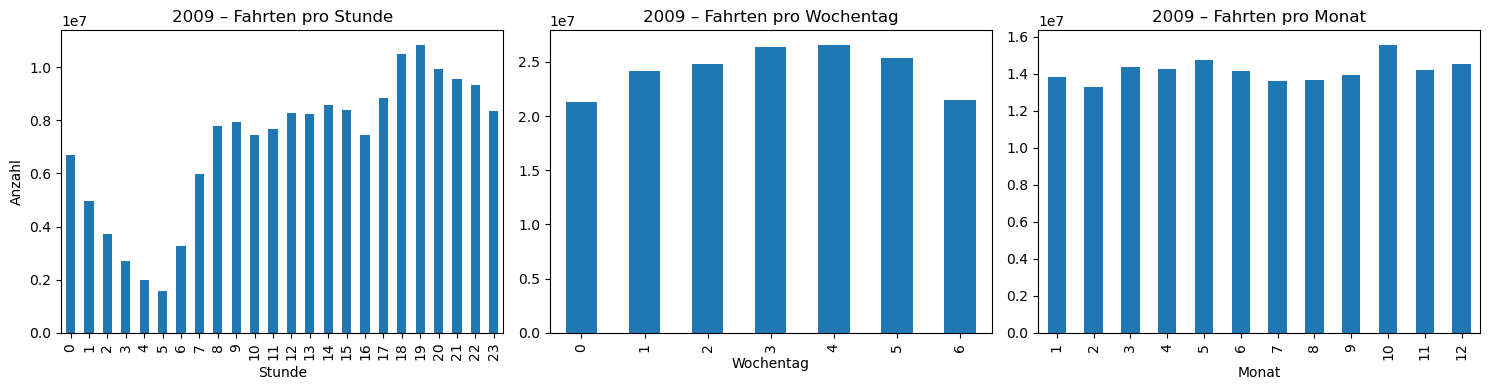

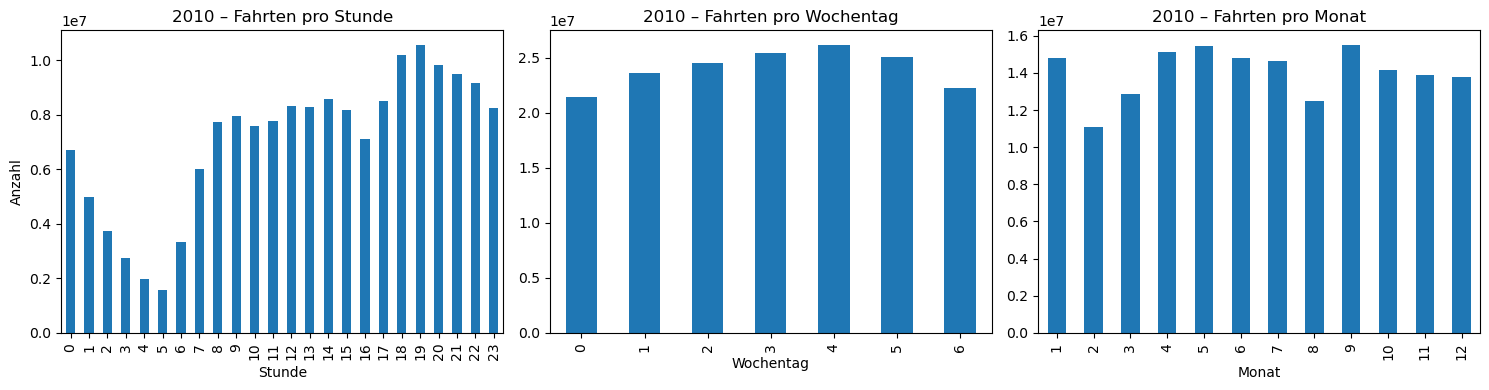

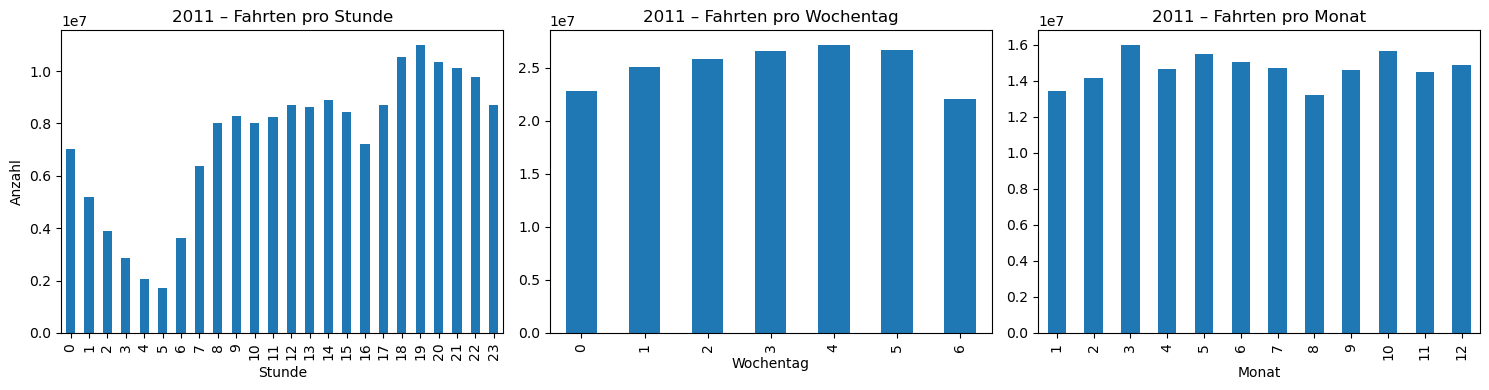

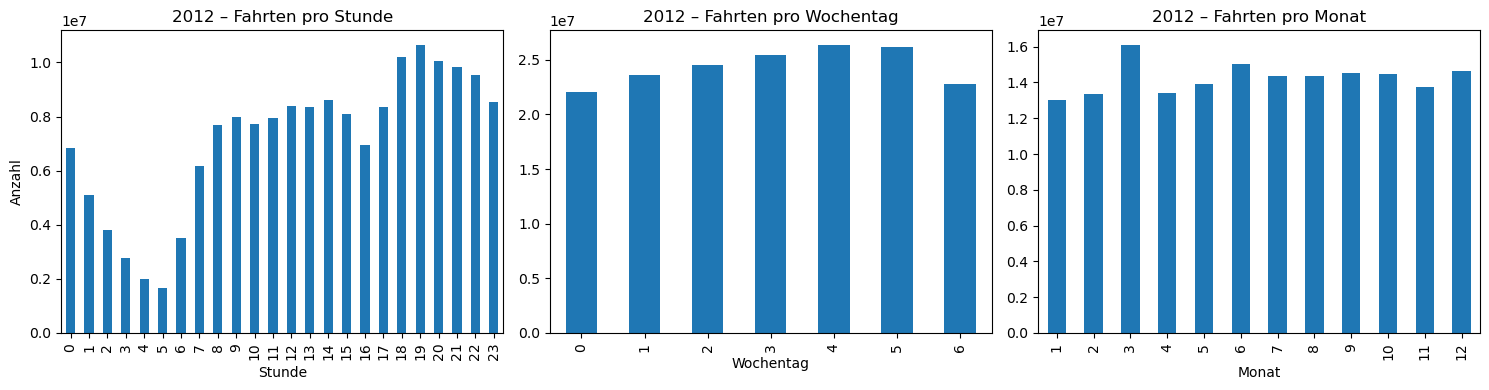

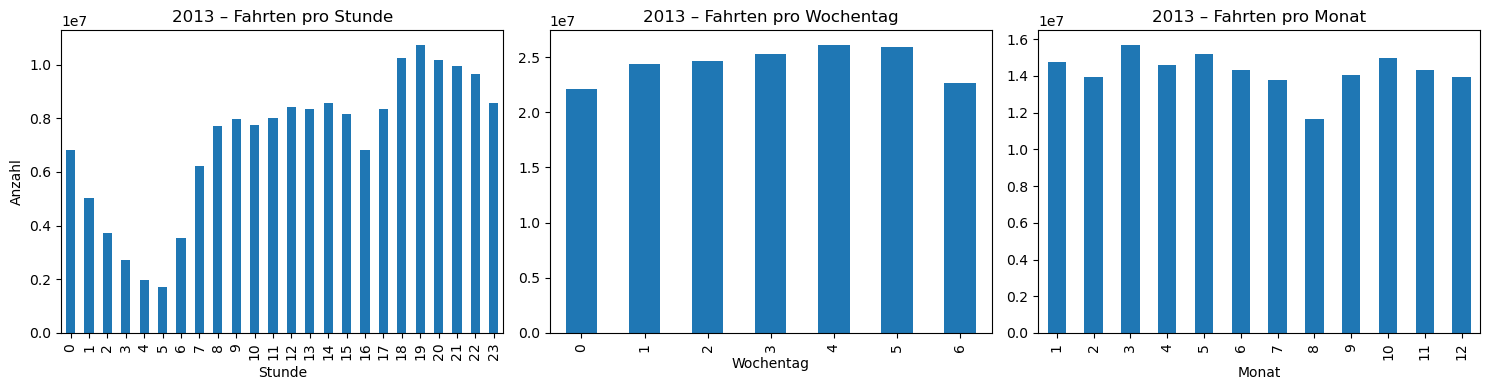

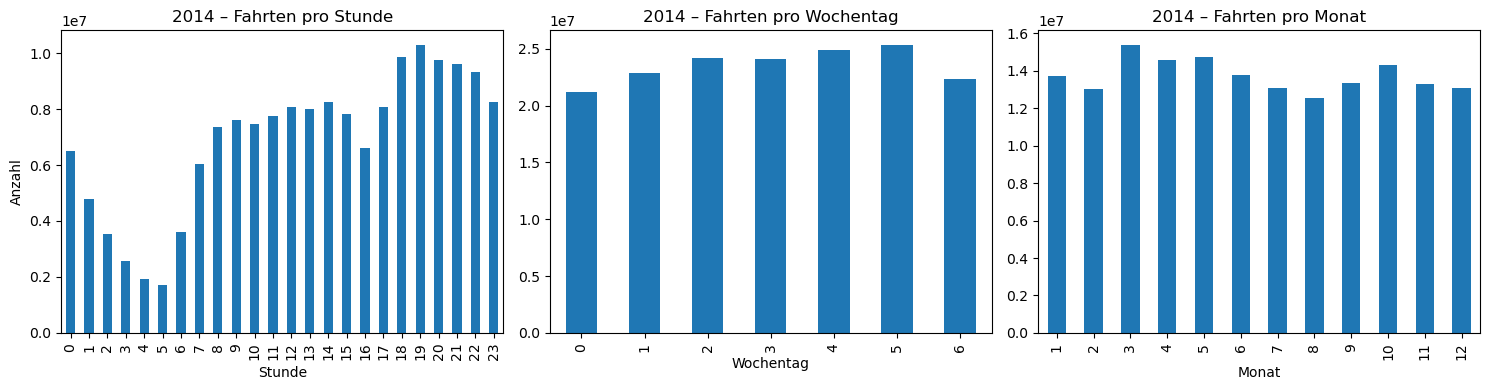

In [18]:
plot_trip_count_grid([2009, 2010, 2011, 2012, 2013, 2014])

Die Analyse des Merkmals `trip_count` über verschiedene Zeitskalen (Stunde, Wochentag, Monat) zeigt über alle betrachteten Jahre hinweg ein konsistentes Nachfrageverhalten mit gut interpretierbaren Mustern.

Im Tagesverlauf zeigt sich ein klarer bimodaler Verlauf. Die erste Nachfragespitze tritt in der Regel zwischen 8 und 9 Uhr auf und steht in Zusammenhang mit dem morgendlichen Berufsverkehr. Eine zweite, ausgeprägtere Spitze folgt zwischen 18 und 20 Uhr und lässt sich auf den abendlichen Pendelverkehr sowie Freizeitaktivitäten zurückführen. In den Nachtstunden ist die Nachfrage deutlich geringer, steigt aber ab etwa 5 bis 6 Uhr wieder an. Die Verläufe sind in den Jahren nahezu identisch.

Auch die Verteilung über die Wochentage zeigt ein stabiles Muster. Die Nachfrage bleibt an Werktagen relativ konstant und erreicht freitags ihren Höhepunkt. Am Sonntag ist ein deutlicher Rückgang erkennbar, was auf geringere Mobilitätsbedarfe am Wochenende hindeutet. Samstage weisen im Vergleich zu Sonntagen tendenziell höhere Werte auf, was sich mit nächtlicher Freizeitnutzung erklären lässt. Auch diese Verläufe sind überraschend gleich.

Im Jahresverlauf zeigen sich saisonale Schwankungen. Die Sommermonate – insbesondere Juni bis August – verzeichnen in vielen Jahren eine erhöhte Fahrtenanzahl, was auf touristische Nutzung oder wetterbedingte Mobilitätsmuster hindeutet. Im Gegensatz dazu ist im Januar und Februar regelmäßig ein leichtes Nachfragetief zu beobachten. Einzelne Abweichungen, wie auffällig hohe Werte im Dezember 2013, könnten auf besondere Ereignisse oder wetterbedingte Effekte zurückzuführen sein und bedürfen einer gezielten Einordnung. Im Vergleich zeigen sich hier die größten Schwankungen über die Jahre, dennoch bleiben diese insgesamt sehr gering.

Die aggregierten Nachfrageverläufe bestätigen insgesamt ausgeprägte zyklische Muster, die sich über mehrere Jahre hinweg als bemerkenswert stabil erweisen. Diese Stabilität deutet grundsätzlich auf eine gute Prognostizierbarkeit der stündlichen Fahrtenanzahl hin. Dennoch sollte eine Drift-Analyse fester Bestandteil des Monitorings sein, um mögliche strukturelle Veränderungen frühzeitig zu erkennen.

**Korrelationsmatrix und Heatmap**

In [57]:
def plot_correlation_matrix(df):
    numeric_cols = [
        "trip_count", "total_distance", "total_fare", "total_amount",
        "total_passengers", "total_duration", "pct_credit_card"
    ]
    corr = df[numeric_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
    plt.title("Korrelationsmatrix numerischer Merkmale")
    plt.tight_layout()
    plt.show()

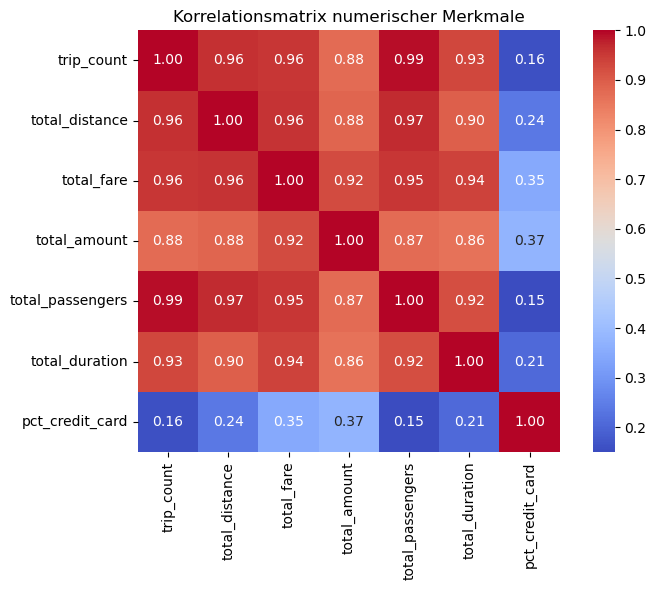

In [58]:
plot_correlation_matrix(df_all)

Die Korrelationsmatrix der numerischen Merkmale zeigt starke Zusammenhänge zwischen den meisten betrachteten Variablen. Besonders ausgeprägt sind die Korrelationen zwischen jenen Merkmalen, die auf stündlichen Summen basieren. Merkmale wie `total_distance`, `total_fare`, `total_amount`, `total_passengers` und `total_duration` zeigen eine hohe wechselseitige Abhängigkeit, was darauf zurückzuführen ist, dass sie alle die kumulierten Werte pro Stunde abbilden. Mit einer höheren Anzahl an Fahrten steigen typischerweise auch Strecke, Preis, Passagierzahl und Dauer.

Die Korrelation zwischen `total_fare` und `total_amount` ist ebenfalls hoch, jedoch etwas geringer im Vergleich zu anderen Paaren. Dies lässt sich dadurch erklären, dass `total_amount` zusätzlich Zuschläge, Trinkgelder und Steuern umfasst, die nicht in jedem Fall vollständig erfasst oder einheitlich vorhanden sind. Dadurch entsteht eine höhere Varianz, während `total_fare` in der Regel konsistenter erfasst wird.

Eine deutlich geringere Korrelation zeigt sich beim Anteil der Kreditkartenzahlungen (`pct_credit_card`). Das ist erwartbar, da die gewählte Zahlungsmethode weniger mit der Anzahl der Fahrten oder deren Umfang zusammenhängt, sondern stärker durch externe Faktoren wie Tageszeit, Fahrgastprofil oder Fahrtzweck beeinflusst wird.

Insgesamt bestätigen die Ergebnisse, dass stündlich aggregierte Merkmale strukturell stark miteinander verbunden sind.

Zur Ergänzung der bisherigen Analyse wird eine erweiterte Korrelationsmatrix erstellt, die neben den operativen Merkmalen auch zeitliche Variablen wie `hour`, `weekday`, `month` und `year` einbezieht. Ziel ist es, zu erkennen, ob sich bestimmte zeitliche Muster oder Trends im Zusammenhang mit der Nachfrage (`trip_count`) oder anderen zentralen Größen abbilden lassen.

Auf diese Weise lässt sich besser einschätzen, ob zeitliche Strukturen – etwa Tageszeiten, Wochentage oder saisonale Effekte – eine erklärende Rolle spielen und sich als sinnvolle Features für spätere Modelle eignen.

In [59]:
def plot_full_correlation_matrix(df):
    selected_cols = [
        "trip_count", "total_distance", "total_fare", "total_amount", "total_passengers",
        "total_duration", "pct_credit_card", "hour", "weekday", "month", "year"
    ]
    corr = df[selected_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
    plt.title("Korrelationsmatrix aller Merkmale (numerisch und zeitlich)")
    plt.tight_layout()
    plt.show()

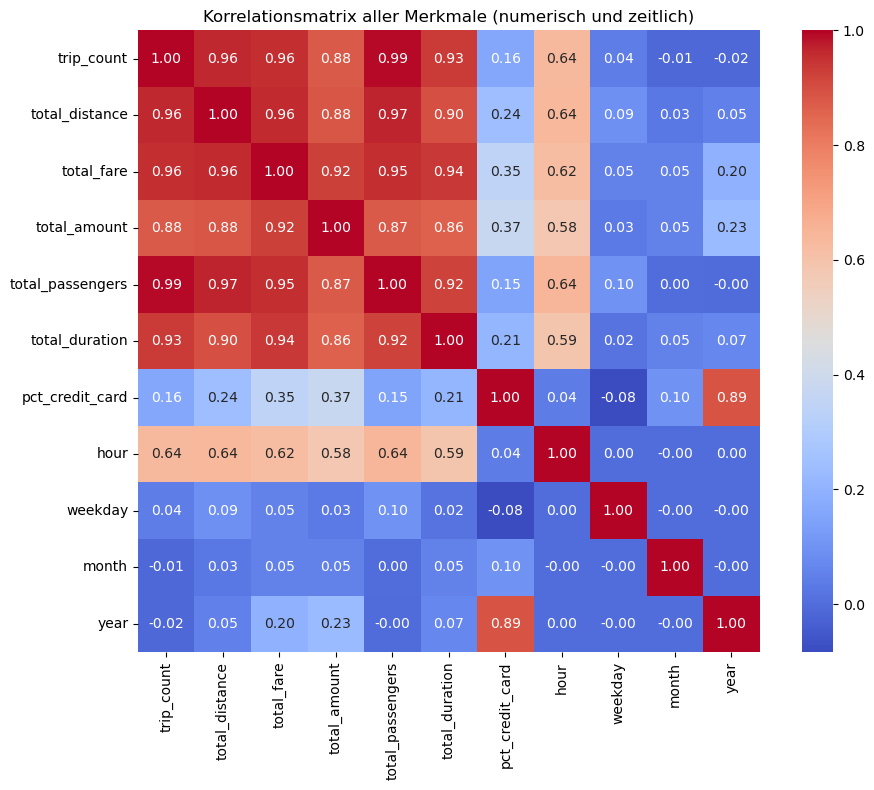

In [60]:
plot_full_correlation_matrix(df_all)

Die erweiterte Korrelationsmatrix, die sowohl numerische als auch zeitliche Merkmale berücksichtigt, zeigt einige interessanter Zusammenhänge.

Wie bereits in der ersten Analyse zu erwarten war, weisen die stündlich aggregierten numerischen Merkmale wie `trip_count`, `total_distance`, `total_fare`, `total_amount`, `total_passengers` und `total_duration` untereinander sehr hohe Korrelationen auf. Diese Merkmale hängen logisch zusammen, da sie alle auf der gleichen Zeitebene summiert wurden.

Spannend wird es bei den zeitlichen Merkmalen. Die Variable `hour` zeigt moderate Korrelationen mit den operativen Merkmalen wie `trip_count`, `total_distance` oder `total_fare`. Das deutet auf typische Tagesmuster in der Nachfrage hin. Im Gegensatz dazu zeigen `weekday` und `month` nur sehr geringe Korrelationen mit den übrigen Merkmalen. Das legt nahe, dass Unterschiede zwischen Wochentagen oder Monaten zwar existieren, aber weniger stark ausgeprägt sind.

Ein besonders auffälliger Zusammenhang besteht zwischen dem Anteil der Kreditkartenzahlungen (`pct_credit_card`) und dem Jahr (`year`), mit einer Korrelation von 0.89. Das ist ein klarer Hinweis auf einen strukturellen Wandel im Zahlungsverhalten über die Zeit hinweg – mit einem zunehmenden Anteil bargeldloser Transaktionen.

Insgesamt zeigt die Matrix ein konsistentes Bild: Die numerischen Summenmerkmale hängen eng zusammen, während zeitliche Variablen – mit Ausnahme der Uhrzeit – weniger stark korrelieren.

**Verhältnismerkmale zur stündlichen Dichtebetrachtung**

Ergänzend zur Analyse der absoluten Summenwerte wurden drei Verhältnismerkmale berechnet, die sich auf die gesamte Fahrtzeit pro Stunde beziehen:

- `fare_per_minute`: Umsatz pro Minute aggregierter Fahrtzeit
- `trips_per_minute`: Anzahl der Fahrten pro Minute Fahrtzeit
- `passengers_per_minute`: Anzahl der beförderten Personen pro Minute Fahrtzeit

Diese Merkmale ermöglichen eine Einschätzung der Effizienz innerhalb eines Stundenintervalls, ohne die Aggregationsebene zu verlassen. Sie basieren auf der kumulierten Fahrtdauer pro Stunde (in Minuten) und stellen damit dichtebezogene Kennzahlen dar.

Die Korrelationen dieser Verhältnismerkmale zur Zielgröße `trip_count` fallen erwartungsgemäß geringer aus als bei den operativen Summenmerkmalen. Das deutet darauf hin, dass `trip_count` stärker durch absolute Mengeneffekte geprägt ist als durch zeitliche Dichte.

In [61]:
df_all["fare_per_minute"] = df_all["total_fare"] / df_all["total_duration"]
df_all["trips_per_minute"] = df_all["trip_count"] / df_all["total_duration"]
df_all["passengers_per_minute"] = df_all["total_passengers"] / df_all["total_duration"]

In [62]:
print(df_all[["fare_per_minute", "trips_per_minute", "passengers_per_minute"]].head())

   fare_per_minute  trips_per_minute  passengers_per_minute
0         0.872396          0.084566               0.144992
1         0.870140          0.080456               0.138726
2         0.909289          0.082602               0.138818
3         0.940580          0.084572               0.139143
4         0.985317          0.084780               0.132883


Die berechneten Verdichtungskennzahlen auf Minutenbasis geben einen detaillierten Einblick in die Effizienz der Fahrtenabwicklung innerhalb einzelner Stundenintervalle – und das, ohne die Aggregationsebene zu verlassen. Drei Kennzahlen wurden berechnet:

- `fare_per_minute`: Umsatz pro Minute aggregierter Fahrtzeit. Dieser Wert liegt in den Beispielen zwischen etwa 0,87 und 0,99 USD pro Minute und zeigt, wie viel Umsatz durchschnittlich pro Minute Fahrtzeit erzielt wurde.

- `trips_per_minute`: Anzahl der Fahrten pro Minute Fahrtzeit. Die Werte bewegen sich im Bereich von 0,08 bis 0,09 und spiegeln die durchschnittliche Fahrtfrequenz pro Minute wider.

- `passengers_per_minute`: Anzahl der beförderten Personen pro Minute Fahrtzeit. Die Werte schwanken zwischen 0,13 und 0,14 Passagieren pro Minute und erlauben Rückschlüsse auf die Auslastung pro Zeiteinheit.

Diese Kennzahlen bieten eine ergänzende Perspektive zu den klassischen Summenmerkmalen wie `total_fare`, `total_passengers` oder `total_duration`. Sie ermöglichen eine Bewertung der Effizienz innerhalb eines Stundenblocks – etwa in Bezug auf Umsatz pro Zeiteinheit oder Beförderungsdichte.

In [28]:
yearly_means = df_all.groupby("year")[
    ["fare_per_minute", "trips_per_minute", "passengers_per_minute"]
].mean().round(4)

print("Jahresweise Mittelwerte der Verhältnismerkmale:")
print(yearly_means)

Jahresweise Mittelwerte der Verhältnismerkmale:
      fare_per_minute  trips_per_minute  passengers_per_minute
year                                                          
2009           0.8818            0.0864                 0.1446
2010           0.8980            0.0873                 0.1443
2011           0.8853            0.0840                 0.1374
2012           0.9491            0.0843                 0.1400
2013           1.0513            0.0829                 0.1405
2014           0.9935            0.0766                 0.1291


Die Jahresmittelwerte der Verhältnismerkmale zeigen teilweise deutliche Entwicklungen im Zeitverlauf. So lag der durchschnittliche Umsatz pro Minute Fahrtzeit (`fare_per_minute`) im Jahr 2009 bei 0,88 USD und stieg bis 2013 kontinuierlich auf 1,05 USD an. Dieser Anstieg könnte auf eine höhere Preisgestaltung, längere Fahrten oder eine allgemein effizientere Nutzung der verfügbaren Fahrtzeit hindeuten. Im Jahr 2014 sank der Wert leicht auf 0,99 USD.

Die Anzahl der Fahrten pro Minute Fahrtzeit (`trips_per_minute`) blieb über die Jahre hinweg relativ stabil, ging jedoch leicht zurück – von 0,086 im Jahr 2009 auf 0,077 im Jahr 2014. Das könnte darauf hinweisen, dass die Taktung der Fahrten pro Zeiteinheit tendenziell abgenommen hat, möglicherweise zugunsten längerer oder lukrativerer Fahrten.

Auch die durchschnittliche Anzahl beförderter Passagiere pro Minute (`passengers_per_minute`) zeigt nur moderate Schwankungen. Der Wert lag 2009 bei 0,145, fiel 2011 auf 0,137 und sank bis 2014 weiter auf 0,129.

Insgesamt deuten die Entwicklungen auf strukturelle Veränderungen in der Nutzung und Effizienz des Taxiverkehrs über die Jahre hinweg hin. Der steigende Umsatz pro Minute bei gleichzeitig rückläufiger Fahrtenzahl pro Minute spricht für eine zunehmende ökonomische Verdichtung, möglicherweise unterstützt durch veränderte Fahrpreisstrukturen oder Nachfrageverschiebungen im städtischen Raum.

In [63]:
df_all[["trip_count", "fare_per_minute", "trips_per_minute", "passengers_per_minute"]].corr()

,trip_count,fare_per_minute,trips_per_minute,passengers_per_minute
trip_count,1.000000,-0.701633,-0.432772,-0.271859
fare_per_minute,-0.701633,1.000000,0.572618,0.493220
trips_per_minute,-0.432772,0.572618,1.000000,0.890459
passengers_per_minute,-0.271859,0.493220,0.890459,1.000000


Die Korrelationsmatrix der vier betrachteten Verhältnis- und Mengenkriterien zeigt interessante Zusammenhänge und liefert Hinweise auf deren wechselseitige Beziehungen.

Die stärkste Korrelation besteht zwischen `trips_per_minute` und `passengers_per_minute` (0,89). Das deutet darauf hin, dass mehr Fahrten pro Minute in der Regel auch mit einer höheren Zahl beförderter Personen pro Minute einhergehen – ein erwartbarer, aber dennoch relevanter Zusammenhang für die Interpretation von Effizienzkennzahlen.

Die Korrelation zwischen `fare_per_minute` und `trips_per_minute` beträgt 0,57. Das weist darauf hin, dass eine höhere Fahrtfrequenz pro Minute tendenziell auch mit einem höheren Umsatz pro Minute verbunden ist – allerdings nicht im gleichen Ausmaß wie bei der Passagieranzahl. Der Umsatz scheint also nicht nur durch die Taktung, sondern auch durch andere Faktoren wie Fahrtlänge oder Zuschläge beeinflusst zu sein.

Auffällig ist die negative Korrelation von `trip_count` mit allen drei Verhältnismerkmalen – insbesondere mit `fare_per_minute` (–0,70) und `trips_per_minute` (–0,43). Das zeigt, dass viele Fahrten pro Stunde nicht automatisch mit einer höheren Effizienz oder Umsatzdichte pro Minute einhergehen. Im Gegenteil: In Stunden mit sehr vielen Fahrten scheint der Umsatz pro Minute im Durchschnitt eher zu sinken. Mögliche Erklärungen könnten geringere Durchschnittsdistanzen, mehr Leerzeiten oder andere operative Einschränkungen sein.

Insgesamt zeigt die Matrix, dass die Effizienzmerkmale `fare_per_minute`, `trips_per_minute` und `passengers_per_minute` stark miteinander verbunden sind, während `trip_count` in einem eher gegenläufigen Verhältnis zu diesen Größen steht.

**Verteilungsanalyse Features**

Zur weiterführenden explorativen Analyse wurden für alle zentralen numerischen Merkmale sowohl Histogramme als auch Boxplots erstellt. Diese Visualisierungen sollen Aufschluss über die Verteilung, die Schiefe sowie potenzielle Ausreißer geben.

Die betrachteten Merkmale umfassen:

- `trip_count`: Anzahl Fahrten pro Stunde (Zielgröße),
- `total_distance`: summierte Fahrdistanz aller Fahrten pro Stunde,
- `total_fare`: Umsatz laut Taxameter pro Stunde,
- `total_amonut`: Gesamtumsatz (inkl. alelr Zuschläge) pro Stunde,
- `total_passengers`: Anzahl beförderter Personen pro Stunde,
- `total_duration`: kumulierte Fahrzeit pro Stunde (in Minuten),
- `pct_credit_card`: Anteil an Kreditkartenzahlungen (zwischen 0 und 1).

Die Histogramme erlauben Rückschlüsse auf die Häufigkeitsverteilungen und deren Schiefe, während die Boxplots insbesondere zur Identifikation extremer Wertebereiche geeignet sind. In Kombination liefern beide Darstellungstypen eine fundierte Grundlage für die spätere Ausreißerdiagnostik sowie zur Beurteilung der Skaleneigenschaften im Hinblick auf die Modellierung.

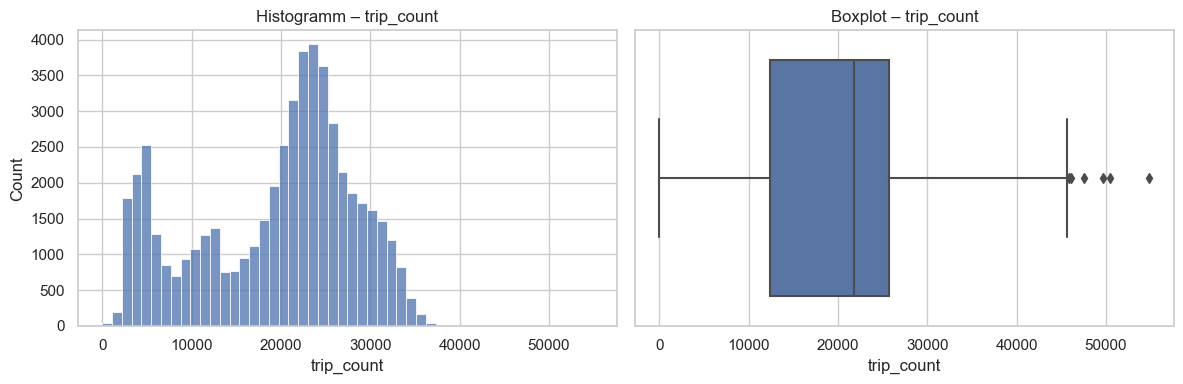

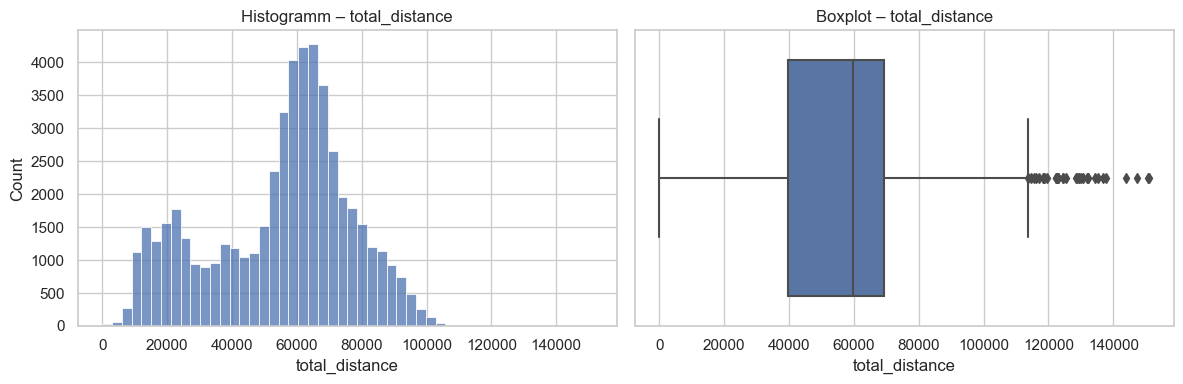

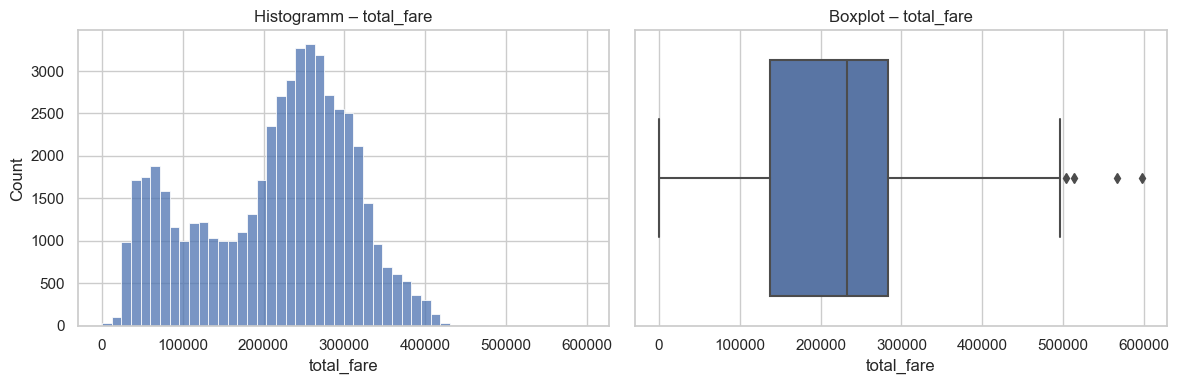

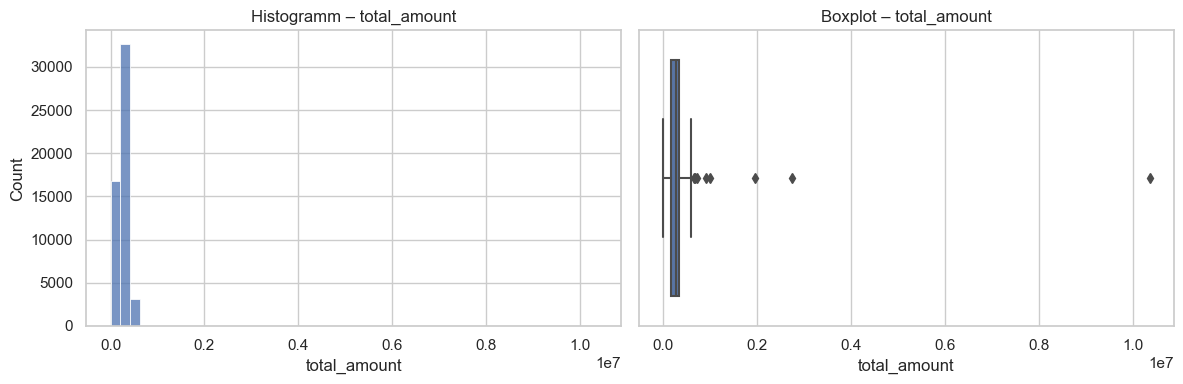

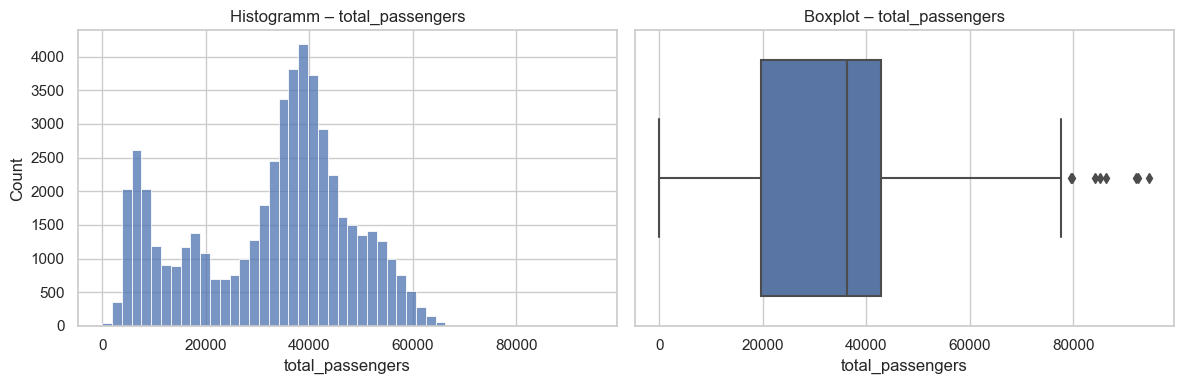

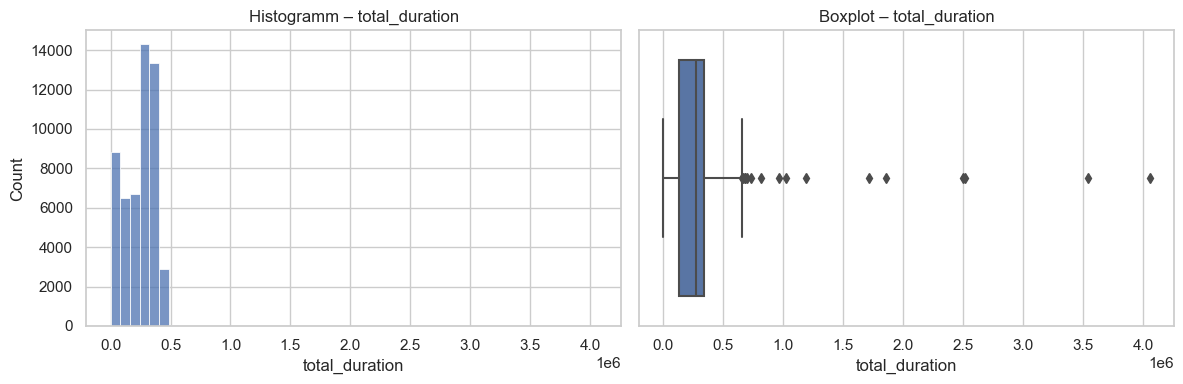

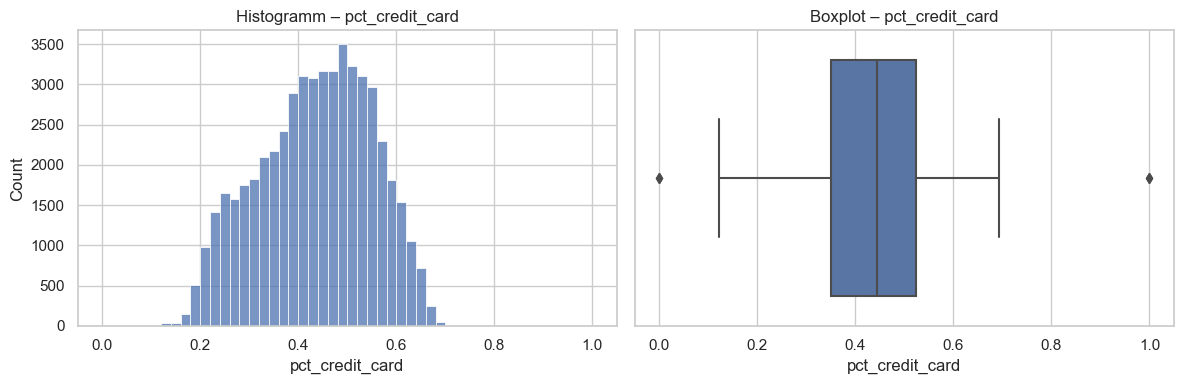

In [64]:
features = [
    "trip_count",
    "total_distance",
    "total_fare",
    "total_amount",
    "total_passengers",
    "total_duration",
    "pct_credit_card"
]

sns.set(style="whitegrid")

for feature in features:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_all[feature], bins=50, kde=False)
    plt.title(f"Histogramm – {feature}")
    plt.xlabel(feature)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_all[feature])
    plt.title(f"Boxplot – {feature}")
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

Die dargestellten Histogramme und Boxplots zeigen die Verteilung und Streuung der zentralen Merkmale im Datensatz. Sie bieten wertvolle Einblicke in die Datenstruktur und ermöglichen eine erste Einschätzung hinsichtlich potenzieller Schiefe, Dichteverteilung und Ausreißer.

Bei der Verteilung von `trip_count` ist eine deutliche positive Schiefe erkennbar. Die meisten Stunden weisen eine mittlere Fahrtenanzahl auf, es gibt jedoch auch Zeitfenster mit deutlich überdurchschnittlicher Nachfrage. Der Boxplot bestätigt dies durch eine Reihe extremer Werte im oberen Bereich.

Auch `total_distance` zeigt eine rechtsschiefe Verteilung. Viele Stunden beinhalten vorwiegend kurze Fahrten, während einige wenige Stunden durch besonders lange Gesamtdistanzen auffallen. Diese Ausreißer sollten hinsichtlich möglicher Mess- oder Verarbeitungsfehler untersucht werden.

Die Merkmale `total_fare` und `total_amount` weisen ähnliche Muster auf: eine überwiegend mittlere Verteilung mit einzelnen sehr hohen Werten. Während `total_fare` den reinen Fahrpreis widerspiegelt, beinhaltet `total_amount` zusätzlich Zuschläge und andere Gebühren, was die Streuung etwas erhöht. Beide Merkmale zeigen auffällige Ausreißer, deren Ursache weiter analysiert werden sollte.

Für `total_passengers` ergibt sich ein ähnliches Bild: Viele Stunden mit wenigen Passagieren, aber auch vereinzelte Intervalle mit sehr hohen Passagierzahlen. Dies spiegelt sich in der positiven Schiefe und den oberen Ausreißern im Boxplot wider.

Die Verteilung von `total_duration` (in Minuten) ist ebenfalls deutlich rechtsschief. Die Mehrheit der Fahrten ist kurz, einige Stunden jedoch kumulieren eine auffällig lange Gesamtfahrtdauer. Diese Extremwerte könnten auf fehlerhafte Zeitstempel oder falsch aggregierte Fahrten hinweisen.

Das Merkmal `pct_credit_card` zeigt im Vergleich eine nahezu symmetrische Verteilung mit Schwerpunkt um die 40 %. Einzelne Werte liegen bei 0 % oder 100 %, was realistische Randbereiche darstellen kann, aber ebenfalls kontextualisiert werden sollte.

Insgesamt zeigt die Verteilungsanalyse, dass die Daten eine nachvollziehbare Struktur aufweisen, jedoch teils erhebliche Ausreißer enthalten. Diese sollten im Rahmen einer gezielten Ausreißerbehandlung näher untersucht werden, um Verzerrungen im weiteren Modellierungsprozess zu vermeiden.

**Ausreißer Analyse**

Im Rahmen der Datenanalyse wurden extreme Werte (Ausreißer) in den verschiedenen Merkmalen des Datensatzes identifiziert. Diese Ausreißer können verschiedene Ursachen haben, wie beispielsweise realistische, aber seltene Ereignisse oder potenzielle Fehlerquellen im Datensatz. Die vorliegenden Ausreißer, insbesondere bei Merkmalen wie `total_fare`, `total_distance`, `total_amount`, `total_duration` und `total_passengers`, wurden visuell durch Histogramme und Boxplots sichtbar gemacht.

Es ist wichtig, diese Ausreißer genauer zu untersuchen, um festzustellen, ob sie echte Datenpunkte widerspiegeln oder ob sie durch Messfehler oder unplausible Eingabewerte verursacht wurden. Bei realistischen Ausreißern, die außergewöhnliche, aber mögliche Ereignisse wie außergewöhnlich lange Fahrten oder hohe Taxikosten darstellen, könnte es sinnvoll sein, sie im Modell zu belassen. Diese Ausreißer könnten auf seltene, aber relevante Szenarien hinweisen, die das Modell robuster machen und es in die Lage versetzen, mit extremen Fällen in den Daten umzugehen, besonders wenn das Modell auf zukünftige Daten aus verschiedenen Jahren angewendet wird.

Andererseits könnte es auch sinnvoll sein, fehlerhafte oder unwahrscheinliche Ausreißer zu entfernen, um das Modell vor Verzerrungen zu schützen und zu verhindern, dass es aufgrund dieser extremen Werte overfitted wird. Eine detaillierte Analyse der Ausreißer ist daher erforderlich, um die Ursachen dieser extremen Werte zu überprüfen und die Auswirkungen auf das Modell zu bewerten.

Auf der Grundlage dieser Analyse kann entschieden werden, ob die Ausreißer im Datensatz belassen, korrigiert oder entfernt werden, je nachdem, was für die Modellbildung am sinnvollsten ist.

Mit dem nachfolgenden Code wird die Analyse der Ausreißer der verschiedenen Merkmale des Datensatzes durchgeführt. Es werden zwei Methoden verwendet: die Z-Score-Methode und die IQR-Methode. Zunächst wird für jedes Merkmal ein Boxplot erstellt, um visuell Ausreißer zu identifizieren. Anschließend wird der Z-Score berechnet, wobei Werte mit einem Z-Score über 3 oder unter -3 als Ausreißer gelten. Zusätzlich wird der Interquartilsabstand (IQR) verwendet, um Werte zu identifizieren, die außerhalb des Bereichs Q1 - 1,5 * IQR und Q3 + 1,5 * IQR liegen.

Der Code gibt für jedes untersuchte Merkmal die Anzahl und die Werte der Ausreißer aus und zeigt die berechneten Ausreißergrenzen im Boxplot. Diese Analyse hilft dabei, zu entscheiden, ob Ausreißer entfernt, korrigiert oder im Modell belassen werden sollen, je nachdem, ob sie Fehler oder seltene, aber plausible Ereignisse widerspiegeln.

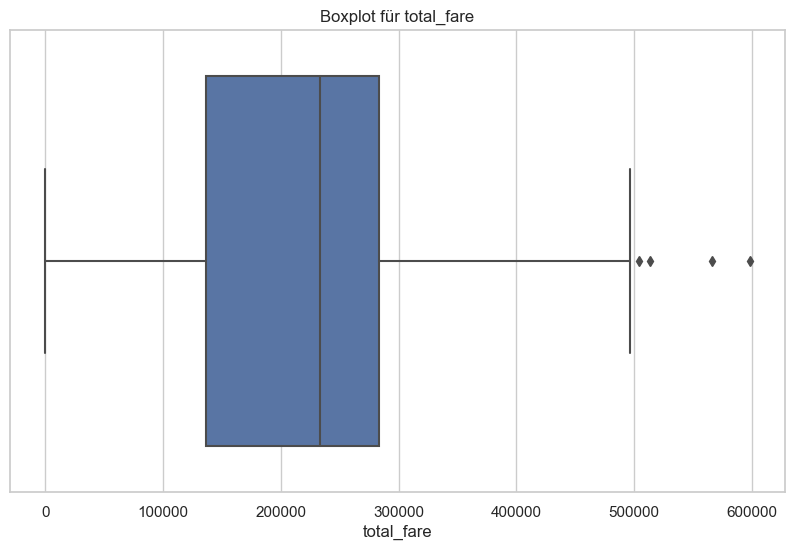

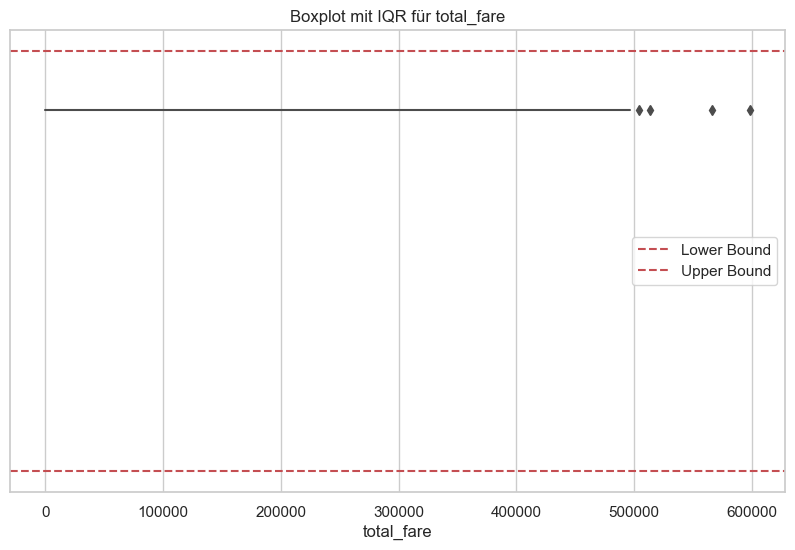

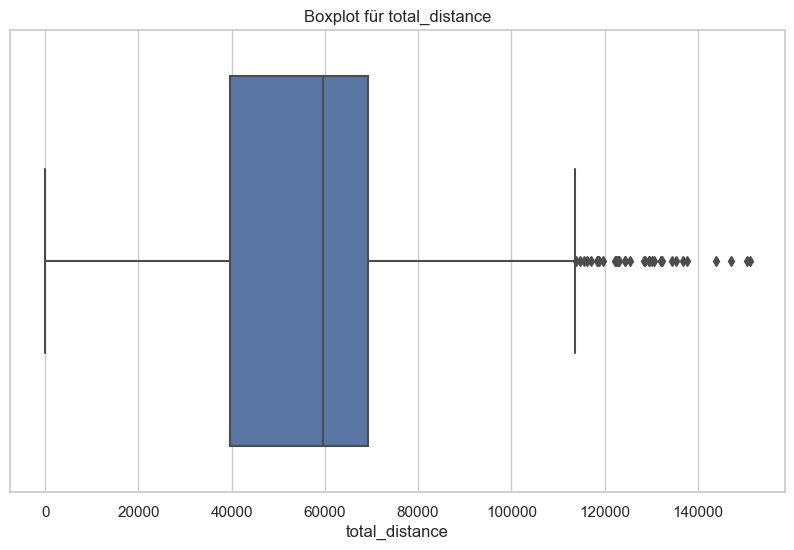

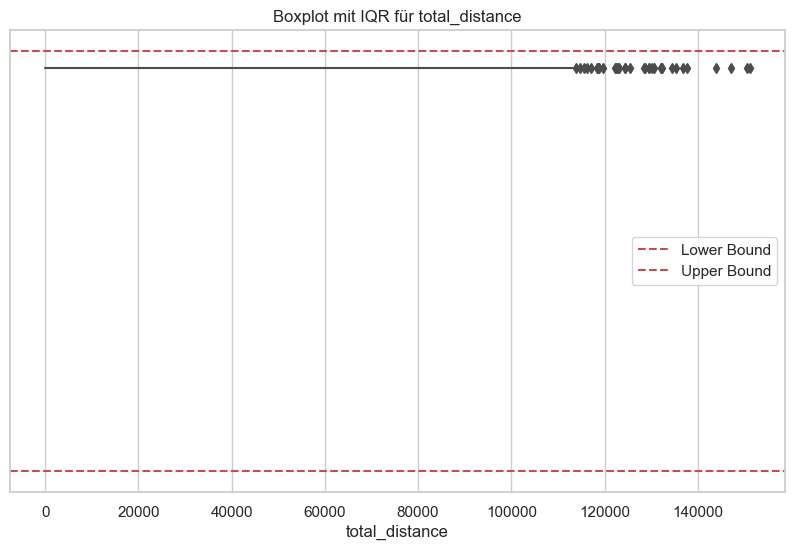

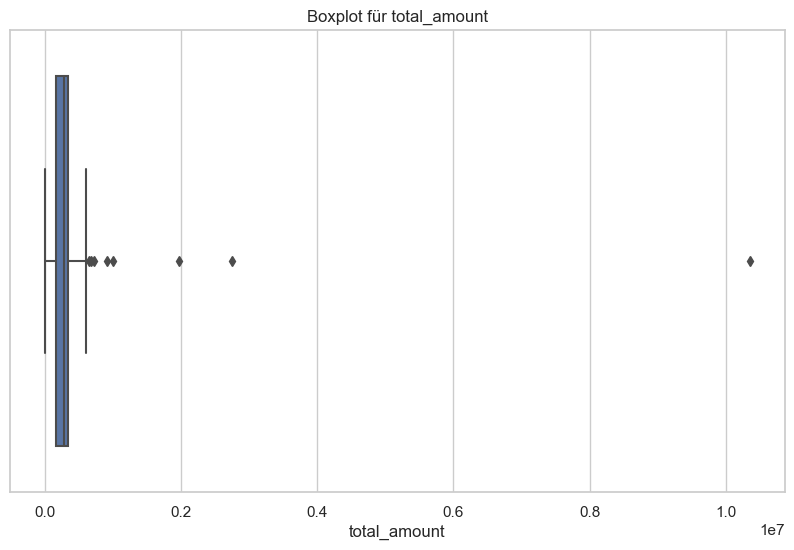

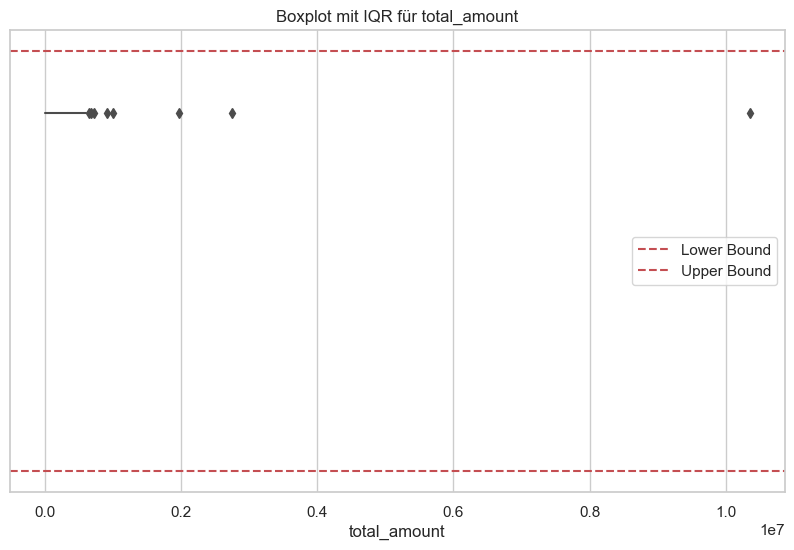

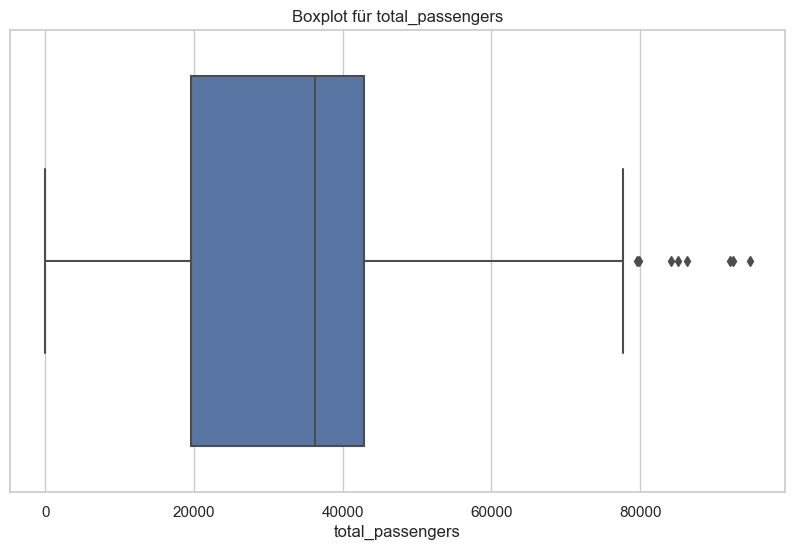

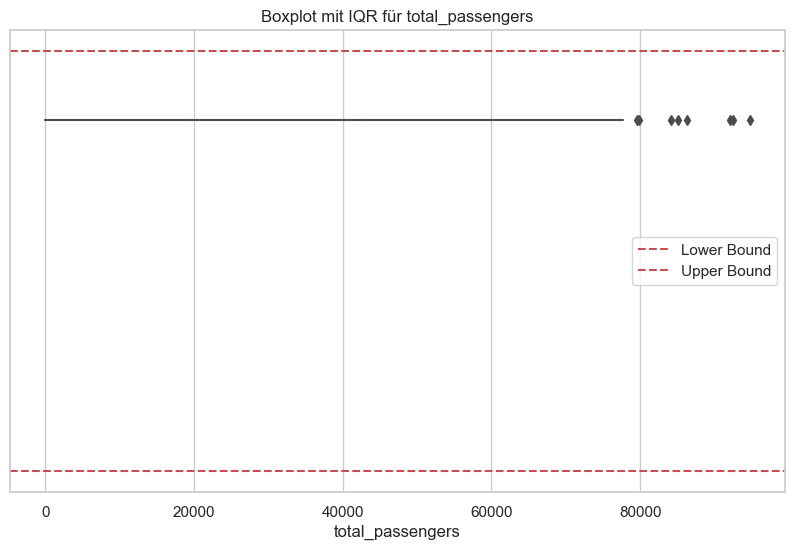

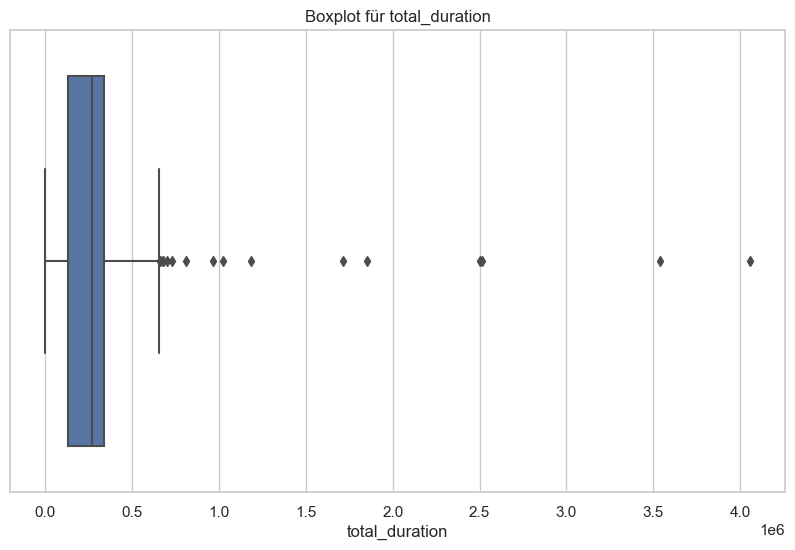

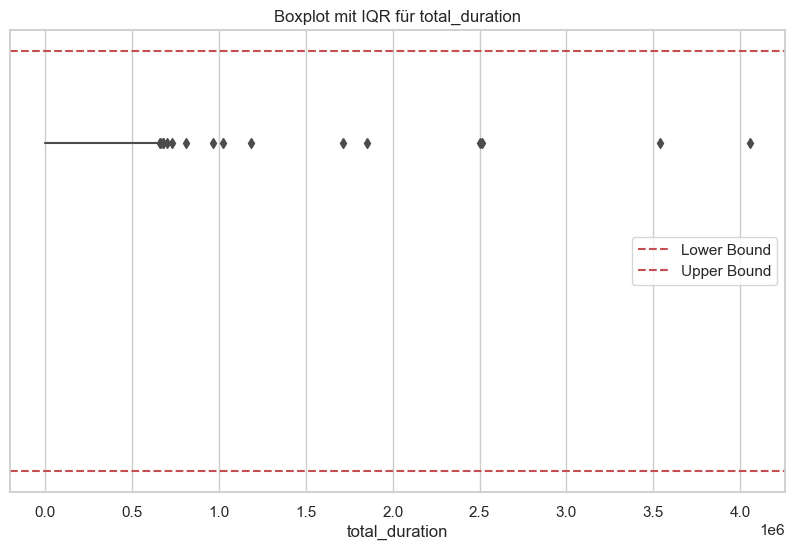


Zusammenfassung für total_fare:
Anzahl der Ausreißer (Z-Score Methode): 4
Ausreißer Werte (Z-Score Methode): [513238.79 566570.05 504178.79 598281.68]...
Anzahl der Ausreißer (IQR Methode): 4
Ausreißer Werte (IQR Methode): [513238.79 566570.05 504178.79 598281.68]...

Zusammenfassung für total_distance:
Anzahl der Ausreißer (Z-Score Methode): 26
Ausreißer Werte (Z-Score Methode): [147151.32 151152.32 143856.51 136916.44 122434.91]...
Anzahl der Ausreißer (IQR Methode): 36
Ausreißer Werte (IQR Methode): [147151.32 151152.32 143856.51 136916.44 122434.91]...

Zusammenfassung für total_amount:
Anzahl der Ausreißer (Z-Score Methode): 8
Ausreißer Werte (Z-Score Methode): [  666454.17   722264.32   909492.88 10355512.21  1960440.57]...
Anzahl der Ausreißer (IQR Methode): 8
Ausreißer Werte (IQR Methode): [  666454.17   722264.32   909492.88 10355512.21  1960440.57]...

Zusammenfassung für total_passengers:
Anzahl der Ausreißer (Z-Score Methode): 8
Ausreißer Werte (Z-Score Methode): [92477 94

In [68]:
def analyze_outliers(df, columns):
    outlier_summary = {}

    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[column])
        plt.title(f"Boxplot für {column}")
        plt.show()

        z_scores = stats.zscore(df[column].dropna())
        outliers_zscore = np.where(np.abs(z_scores) > 3)
        outlier_summary[column] = {
            "num_outliers_zscore": len(outliers_zscore[0]),
            "outliers_zscore": df[column].iloc[outliers_zscore[0]].values
        }

        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        outlier_summary[column]["num_outliers_iqr"] = outliers_iqr.shape[0]
        outlier_summary[column]["outliers_iqr"] = outliers_iqr[column].values

        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[column])
        plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
        plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')
        plt.title(f"Boxplot mit IQR für {column}")
        plt.legend()
        plt.show()

    return outlier_summary

columns_to_check = ["total_fare", "total_distance", "total_amount", "total_passengers", "total_duration"]

outlier_summary = analyze_outliers(df_all, columns_to_check)

for column, summary in outlier_summary.items():
    print(f"\nZusammenfassung für {column}:")
    print(f"Anzahl der Ausreißer (Z-Score Methode): {summary['num_outliers_zscore']}")
    print(f"Ausreißer Werte (Z-Score Methode): {summary['outliers_zscore'][:5]}...")
    print(f"Anzahl der Ausreißer (IQR Methode): {summary['num_outliers_iqr']}")
    print(f"Ausreißer Werte (IQR Methode): {summary['outliers_iqr'][:5]}...")

Die Ausreißeranalyse für die verschiedenen Merkmale des Datensatzes zeigt, dass in mehreren Variablen sowohl durch die Z-Score-Methode als auch durch die IQR-Methode Ausreißer identifiziert wurden.

Für das Merkmal `total_fare` wurden 4 Ausreißer sowohl mit der Z-Score-Methode als auch mit der IQR-Methode identifiziert. Die betroffenen Werte liegen im Bereich zwischen 513.238,79 USD und 598.281,68 USD. Diese Ausreißer könnten auf außergewöhnlich hohe Fahrpreise oder Sondergebühren hinweisen, die weiter untersucht werden sollten.

Im Fall von `total_distance` wurden mit der Z-Score-Methode 26 Ausreißer identifiziert, während die IQR-Methode 36 Ausreißer fand. Die Ausreißerwerte liegen zwischen 122.434,91 Meilen und 151.152,32 Meilen. Diese extrem hohen Entfernungen könnten durch Fehler oder außergewöhnlich lange Fahrten bedingt sein.

Für `total_amount` wurden 8 Ausreißer mit beiden Methoden identifiziert, mit Werten, die von 666.454,17 USD bis 10.355.512,21 USD reichen. Diese extremen Werte sind wahrscheinlich auf besondere Zuschläge oder Gebühren zurückzuführen, die in bestimmten Fahrten anfielen.

Bei `total_passengers` wurden ebenfalls 8 Ausreißer sowohl mit der Z-Score-Methode als auch mit der IQR-Methode gefunden. Die betroffenen Werte liegen zwischen 79.586 und 94.477 Passagieren. Diese Ausreißer könnten auf besonders stark frequentierte Fahrten hinweisen, die möglicherweise eine genauere Untersuchung erfordern.

Schließlich zeigt die Analyse für `total_duration`, dass mit der Z-Score-Methode 20 Ausreißer und mit der IQR-Methode 16 Ausreißer identifiziert wurden. Die betroffenen Werte reichen von 621.972,8 Minuten bis zu extrem hohen 2.511.190,38 Minuten. Diese extrem langen Fahrten könnten auf außergewöhnliche Umstände wie Verzögerungen oder lange Umwege hindeuten.

Die Ergebnisse dieser Analyse zeigen, dass Ausreißer in allen Merkmalen existieren, wobei insbesondere `total_fare`, `total_distance` und `total_duration` Werte aufweisen, die durch außergewöhnliche Ereignisse oder potenzielle Fehler im Datensatz erklärt werden könnten. Eine genauere Untersuchung dieser Ausreißer ist erforderlich, um zu entscheiden, ob sie für die Modellierung relevant sind oder entfernt werden sollten.`

In [69]:
def analyze_outliers_details(df, columns, threshold_zscore=3, threshold_iqr=1.5):
    outliers_details = {}
    
    for column in columns:
        z_scores = stats.zscore(df[column].dropna())
        outliers_zscore = df.iloc[np.where(np.abs(z_scores) > threshold_zscore)[0]]

        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold_iqr * IQR
        upper_bound = Q3 + threshold_iqr * IQR
        outliers_iqr = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        outliers_details[column] = {
            "num_outliers_zscore": len(outliers_zscore),
            "outliers_zscore": outliers_zscore,
            "num_outliers_iqr": len(outliers_iqr),
            "outliers_iqr": outliers_iqr
        }
        
        print(f"\nAusreißer für {column} anhand der Z-Score Methode:")
        print(outliers_zscore[[column]])
        print(f"\nAusreißer für {column} anhand der IQR Methode:")
        print(outliers_iqr[[column]])

    return outliers_details

columns_to_check = ["total_fare", "total_distance", "total_amount", "total_passengers", "total_duration"]

outliers_details = analyze_outliers_details(df_all, columns_to_check)

for column, details in outliers_details.items():
    print(f"\nZusammenfassung für {column}:")
    print(f"Anzahl der Ausreißer (Z-Score Methode): {details['num_outliers_zscore']}")
    print(f"Anzahl der Ausreißer (IQR Methode): {details['num_outliers_iqr']}")


Ausreißer für total_fare anhand der Z-Score Methode:
       total_fare
7297    513238.79
15024   566570.05
15025   504178.79
42411   598281.68

Ausreißer für total_fare anhand der IQR Methode:
       total_fare
7297    513238.79
15024   566570.05
15025   504178.79
42411   598281.68

Ausreißer für total_distance anhand der Z-Score Methode:
       total_distance
7297        147151.32
15024       151152.32
15025       143856.51
15026       136916.44
15027       122434.91
15036       122506.01
15037       130173.17
15038       132231.61
15039       130616.56
15040       122171.55
15041       132021.75
15042       137702.76
15043       128704.28
15044       125546.10
15045       122976.39
15141       124432.03
15142       128527.18
15143       122793.87
15166       129530.21
15167       134489.40
15168       129468.19
15191       124461.54
15192       123006.71
16201       132092.19
24941       135374.01
42411       150560.34

Ausreißer für total_distance anhand der IQR Methode:
       tot

Die Ausreißeranalyse hat für verschiedene Merkmale des Datensatzes signifikante Abweichungen ergeben. Zusammenfassend lässt sich sagen, dass es in allen Merkmalen signifikante Ausreißer gibt, die potenziell durch außergewöhnliche Ereignisse oder Datenfehler erklärt werden können. Eine genauere Untersuchung dieser Ausreißer ist erforderlich, um festzustellen, ob sie für die Modellierung von Bedeutung sind oder entfernt werden sollten. Dazufolgt nun eine genauere Analyse der Datenpunkt, die als Ausreißer erkannt wurde um zu überprüfen, ob es sich überall um dieselben Datenpunkte handelt.

In [76]:
def analyze_outliers_details(df, columns, threshold_zscore=3, threshold_iqr=1.5):
    outliers_details = {}
    
    for column in columns:
        z_scores = stats.zscore(df[column].dropna())
        outliers_zscore = df.iloc[np.where(np.abs(z_scores) > threshold_zscore)[0]]
        
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold_iqr * IQR
        upper_bound = Q3 + threshold_iqr * IQR
        outliers_iqr = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        outliers_details[column] = {
            "num_outliers_zscore": len(outliers_zscore),
            "outliers_zscore": outliers_zscore,
            "num_outliers_iqr": len(outliers_iqr),
            "outliers_iqr": outliers_iqr
        }

        print(f"\nAusreißer für {column} anhand der Z-Score Methode:")
        print(outliers_zscore)
        print(f"\nAusreißer für {column} anhand der IQR Methode:")
        print(outliers_iqr)

    return outliers_details

columns_to_check = ["total_fare", "total_distance", "total_amount", "total_passengers", "total_duration"]

outliers_details = analyze_outliers_details(df_all, columns_to_check)

for column, details in outliers_details.items():
    print(f"\nZusammenfassung für {column}:")
    print(f"Anzahl der Ausreißer (Z-Score Methode): {details['num_outliers_zscore']}")
    print(f"Anzahl der Ausreißer (IQR Methode): {details['num_outliers_iqr']}")


Ausreißer für total_fare anhand der Z-Score Methode:
              pickup_hour  trip_count  total_distance  total_fare  \
7297  2009-11-01 01:00:00       47557       147151.32   513238.79   
15024 2010-09-19 00:00:00       54866       151152.32   566570.05   
15025 2010-09-19 01:00:00       49609       143856.51   504178.79   
42411 2013-11-03 01:00:00       50447       150560.34   598281.68   

       total_amount  total_passengers  total_duration  pct_credit_card  hour  \
7297      594840.12             92477   621972.800000         0.304098     1   
15024     666454.17             94730   728718.800000         0.389075     0   
15025     594713.42             84173   596027.400000         0.401399     1   
42411     722264.32             92118   554404.083333         0.606914     1   

       weekday  month  year  fare_per_minute  trips_per_minute  \
7297         6     11  2009         0.825179          0.076462   
15024        6      9  2010         0.777488          0.075291   
1

Die Analyse der Ausreißer in den verschiedenen Merkmalen zeigt signifikante Unterschiede und Auffälligkeiten, die bei der weiteren Modellierung berücksichtigt werden müssen:

- `total_fare`: Die Ausreißer, die sowohl anhand der Z-Score-Methode als auch der IQR-Methode identifiziert wurden, befinden sich in den Werten 513238.79, 566570.05, 504178.79 und 598281.68. Diese Werte liegen weit über dem Durchschnitt und stellen hohe Fahrpreise dar. Es handelt sich hierbei möglicherweise um extrem lange Fahrten oder außergewöhnliche Fahrten, die höhere Preise generiert haben. Die Identifikation von Ausreißern für total_fare könnte durch zusätzliche Zuschläge oder Fehler im System verursacht werden, jedoch können auch seltene, aber legitime Geschäftsereignisse die Ursache sein. In diesem Fall sollten diese Ausreißer weiter untersucht werden, anstatt sie pauschal zu entfernen.
- `total_distance`: Bei total_distance gibt es deutlich mehr Ausreißer, sowohl in der Z-Score- als auch in der IQR-Methode, mit 26 bzw. 36 Ausreißern. Diese Werte weisen auf extreme Distanzen hin, die für bestimmte Fahrten gemessen wurden. Diese könnten durch ungewöhnlich lange Fahrten oder Datenfehler (z. B. falsche GPS-Daten) entstehen. In den meisten Fällen ist es jedoch wahrscheinlich, dass diese extremen Werte aufgrund von besonderen Umständen (wie lange Fahrten oder saisonale Spitzen) legitime Ausreißer sind.
- `total_amount`: Die Ausreißer für total_amount (einschließlich 666454.17 und 10355512.21) sind vergleichbar mit denen für total_fare, jedoch treten sie in etwas geringerer Zahl auf (insgesamt 8). Diese Werte könnten durch ähnliche Ursachen wie hohe Preise oder außergewöhnliche Fahrten erklärt werden. Auch hier könnte es sich um Fehler handeln, die durch Zuschläge oder seltene Umstände verursacht wurden.
- `total_passengers`: Die Ausreißer bei der Anzahl der Passagiere (wie 92477 und 94730) sind weniger häufig, aber auch in diesem Fall deutet die hohe Anzahl auf ungewöhnliche Ereignisse hin, bei denen besonders viele Passagiere transportiert wurden, möglicherweise bei Fahrten mit mehreren Fahrzeugen oder bei besonderen Ereignissen. Die Ursachen für diese Ausreißer sind eher organisatorischer Natur und sollten weiter untersucht werden.
- `total_duration`: Bei der Fahrtdauer gibt es auch mehrere Ausreißer (insbesondere hohe Werte wie 4.055145e+06 Sekunden). Diese Ausreißer könnten auf fehlerhafte Zeitstempel oder extrem lange Fahrten hindeuten. Auch hier ist es sinnvoll, die Ursachen genauer zu untersuchen, da solche Werte möglicherweise nicht durch Fehler im System, sondern durch außergewöhnliche Fahrten verursacht wurden.

Die Entscheidung, die Ausreißer in den Daten zu behalten, basiert auf der Überlegung, dass viele dieser Ausreißer durch legitime, aber seltene Ereignisse verursacht werden könnten. Das Entfernen dieser Ausreißer könnte dazu führen, dass wichtige Informationen verloren gehen, die für die Modellierung von Bedeutung sind. In einigen Fällen, wie bei extremen Fahrpreisen und Distanzen, spiegeln diese Ausreißer möglicherweise geschäftsrelevante Ereignisse wider, wie zum Beispiel Sonderaktionen, außergewöhnliche saisonale Spitzen oder langwierige Fahrten.

Darüber hinaus könnte das Entfernen dieser Ausreißer das Modell weniger robust gegenüber realen Daten machen, die möglicherweise ähnliche extreme Werte in der Zukunft aufweisen. Ein Modell, das in der Lage ist, mit diesen Ausreißern umzugehen, wird besser in der Lage sein, die Variabilität und Unregelmäßigkeiten in den realen Daten widerzuspiegeln. Besonders bei komplexen Modellen wie Entscheidungsbäumen oder Random Forests kann das Modell robuster werden, wenn es in der Lage ist, mit Ausreißern umzugehen, ohne sie explizit zu entfernen.

**Abschluss der EDA und Zusammenfassung**

Die explorative Datenanalyse (EDA) hat zentrale Strukturen, Verteilungen und Zusammenhänge innerhalb der bereinigten und aggregierten NYC Taxi-Daten offengelegt. Sie bildet damit die Grundlage für fundierte Modellierungsentscheidungen.

Ein zentrales Ergebnis ist die klare Identifikation von typischen Nachfragemustern über Tageszeiten, Wochentage und Jahresverläufe hinweg. Die hohe Stabilität dieser zyklischen Muster über mehrere Jahre unterstreicht das Potenzial für verlässliche Vorhersagemodelle auf Stundenbasis.

Gleichzeitig zeigt die Analyse, dass die numerischen Summenmerkmale – etwa `total_fare`, `total_distance`, `total_amount`, `total_passengers` und `total_duration` – erwartungsgemäß stark miteinander korrelieren, was bei der Merkmalsauswahl und Modellinterpretation berücksichtigt werden muss. Verhältniskennzahlen wie `fare_per_minute` oder `trips_per_minute` ergänzen die operativen Größen um Effizienzindikatoren, die zusätzliche Perspektiven auf das Mobilitätsverhalten eröffnen.

Die Ausreißeranalyse hat ergeben, dass extreme Werte zwar vorhanden sind, jedoch nicht flächendeckend als fehlerhaft zu bewerten sind. Viele dieser Ausreißer treten isoliert in einzelnen Merkmalen auf und könnten legitime Ausprägungen seltener, aber realer Fahrereignisse darstellen – etwa Flughafentransfers, Sammelfahrten oder außergewöhnliche Wetterlagen. Eine pauschale Entfernung dieser Werte würde das Modell um relevante Extremsituationen berauben.

Für die Modellierung bedeutet das: Der Umgang mit Ausreißern muss bewusst und differenziert erfolgen. Anstelle eines pauschalen Ausschlusses sollte geprüft werden, ob die gewählten Modellarchitekturen – etwa Baumbasierte Modelle oder robuste Regressionsverfahren – mit solchen Werten umgehen können. Alternativ kann ein gezieltes Feature Engineering erfolgen, um Ausreißersensitivität zu reduzieren, z. B. durch Transformationen oder Kategorisierung.

Darüber hinaus hat die Analyse der zeitlichen Merkmale (z. B. `hour`, `weekday`, `month`) gezeigt, dass diese zwar nur schwach mit den aggregierten Summenmerkmalen korrelieren, aber dennoch klare strukturelle Muster aufweisen. Sie sind somit wichtige Kontextvariablen, die in die Modellentwicklung einbezogen werden sollten.

Insgesamt liefert die EDA eine tragfähige Grundlage für den Übergang in die Modellierungsphase. Die Datenqualität, die Stabilität der Muster und die identifizierten Besonderheiten ermöglichen die Entwicklung eines prädiktiven Modells, das sowohl mit typischen als auch mit ungewöhnlichen Nachfragesituationen umgehen kann.

---

## 9. Modellentwicklung & -training

Ziel dieses Abschnitts ist die Entwicklung eines Vorhersagemodells für die stündliche Anzahl an Taxifahrten in New York City. Der Modellierungsprozess beginnt mit einem einfachen Baseline-Modell, das als Referenz für die Leistungsbewertung komplexerer Ansätze dient. Die Baseline ermöglicht eine erste quantitative Einschätzung der Modellgüte und unterstützt die Identifikation potenzieller Schwächen in den verwendeten Merkmalen.

Die Modellierung wird nahtlos in den bestehenden Datenverarbeitungsworkflow integriert, der aus den Phasen des Mappings, des Preprocessings und des Feature Engineerings besteht. Zur Sicherstellung der Reproduzierbarkeit und Nachvollziehbarkeit erfolgt die Umsetzung vollständig innerhalb des MLflow-Frameworks. Alle relevanten Parameter, Modelle, Evaluationsergebnisse sowie Modellversionen werden automatisiert erfasst und versioniert.

Langfristiges Ziel ist der Aufbau eines robusten, übertragbaren Vorhersagemodells, das sich flexibel auf neue Jahresdatensätze anwenden lässt. Die Modellarchitektur wird so gestaltet, dass zukünftige Aktualisierungen mit minimalem manuellem Aufwand möglich sind. Zur Qualitätssicherung wird ein Monitoring konzipiert, das zentrale Kennzahlen (z. B. MAE, RMSE, R²) fortlaufend überwacht.

**Aufteilung in Trainings- und Testdaten**

Für die Entwicklung und Evaluation des Vorhersagemodells wird der Datensatz auf Basis zeitlicher Kriterien in Trainings- und Testdaten unterteilt. Die Trainingsdaten umfassen die Jahre 2009 bis 2014 und werden für das Modelltraining verwendet. Die Testdaten umfassen die Jahre 2015 bis 2017 und werden ausschließlich zur Evaluation der Modellleistung verwendet, um eine realistische Einschätzung der Generalisierungsfähigkeit zu ermöglichen.

Für die Konsistenz im Datenverarbeitungsprozess wird sowohl auf die Trainings- als auch auf die Testdaten derselbe Preprocessing- und Feature-Engineering-Workflow angewendet. Die entsprechenden Schritte wurden bereits im Rahmen der vorangegangenen Datenvorbereitung implementiert und können modular über zentrale Funktionen erneut ausgeführt werden.

Diese Vorgehensweise stellt sicher, dass sämtliche Merkmale in beiden Datensätzen identisch berechnet und skaliert werden. Dadurch wird vermieden, dass das Modell durch inkonsistente Eingaben fehlerhafte oder verzerrte Vorhersagen trifft. Die saubere Trennung von Trainings- und Testdaten gewährleistet zudem die Unabhängigkeit der Evaluationsphase und ist essenziell für eine belastbare Bewertung der Modellgüte.

Um eine wiederholte Ausführung der vorangegangenen Preprocessing- und Feature-Engineering-Schritte zu vermeiden, wird der aggregierte und vollständig aufbereitete Datensatz zunächst als Trainingsdatensatz gespeichert. Dadurch kann in den folgenden Abschnitten direkt auf die vorbereiteten Daten zugegriffen werden, ohne dass der gesamte Datenverarbeitungsprozess erneut durchlaufen werden muss.

Die gespeicherten Trainingsdaten bilden die Grundlage für die nachfolgende Modellierung und Evaluation.

In [77]:
df_train = df_all.copy()
df_train.to_parquet("df_train.parquet", index=False)

In [78]:
df_train = pd.read_parquet("df_train.parquet")

**Verarbeitung der Testdaten**

Für die erste Modellbewertung wird der Testdatensatz ohne Einbindung in den MLflow-Tracking-Workflow verarbeitet. Hierzu werden die bereits etablierten Funktionen zur Durchführung des Mappings, des Preprocessings und des Feature Engineerings verwendet. Die Verarbeitung erfolgt auf Basis der Jahre 2015 bis 2017. Der resultierende Datensatz wird zur Wiederverwendbarkeit als Parquet-Datei gespeichert.

In [95]:
test_years = [2015, 2016, 2017]

In [96]:
run_mapping_for_years(test_years)

Mapping Jahre: 100%|██████████████████████████████| 3/3 [00:26<00:00,  8.98s/it]

Spalten-Mapping abgeschlossen.


,pickup_col,dropoff_col,distance_col,fare_col,total_col,passenger_col,payment_type_col,pickup_long_col,pickup_lat_col,dropoff_long_col,dropoff_lat_col,file
0,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-01.parquet
1,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-02.parquet
2,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-03.parquet
3,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-04.parquet
4,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-05.parquet
5,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-06.parquet
6,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-07.parquet
7,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-08.parquet
8,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-09.parquet
9,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,passenger_count,payment_type,PULocationID,PULocationID,DOLocationID,DOLocationID,yellow_tripdata_2015-10.parquet


In [97]:
run_preprocessing_for_years(test_years)

Preprocessing Jahre: 100%|████████████████████████| 3/3 [03:22<00:00, 67.57s/it]

Preprocessing für alle angegebenen Jahre abgeschlossen.


In [99]:
run_feature_engineering_for_years(test_years)

Feature Engineering:  33%|████████                | 1/3 [00:25<00:51, 25.52s/it]

Jahresdatei für 2015 gespeichert: features_yellow_tripdata_2015.parquet


Feature Engineering:  67%|████████████████        | 2/3 [00:47<00:23, 23.72s/it]

Jahresdatei für 2016 gespeichert: features_yellow_tripdata_2016.parquet


Feature Engineering: 100%|████████████████████████| 3/3 [01:07<00:00, 22.44s/it]

Jahresdatei für 2017 gespeichert: features_yellow_tripdata_2017.parquet
Feature Engineering abgeschlossen.


Nachdem die drei zentralen Workflows – das Spalten-Mapping, das Preprocessing sowie das Feature Engineering – erfolgreich auf einem bisher unbehandelten Datensatz (Jahre 2015 bis 2017) ausgeführt wurden, kann deren Robustheit gegenüber neuen, unbekannten Eingabestrukturen als bestätigt gelten. Die Zwischenergebnisse wurden für jedes Jahr separat als Parquet-Dateien gespeichert.

Für die anschließende Modellierung ist es erforderlich, diese jährlich erzeugten Feature-Daten in einem konsolidierten Datensatz zusammenzuführen. Der folgende Code lädt die entsprechenden Dateien, prüft ihre Existenz und vereinigt sie zeilenweise zu einem gemeinsamen DataFrame. Dieser wird abschließend unter dem Namen `df_test.parquet` gespeichert und dient als Grundlage für die Modellbewertung.

In [102]:
def load_feature_data(years, folder="."):
    dfs = []
    for year in years:
        file_path = Path(folder) / "features" / f"features_yellow_tripdata_{year}.parquet"
        if file_path.exists():
            df = pd.read_parquet(file_path)
            dfs.append(df)
        else:
            print(f"Datei nicht gefunden: {file_path}")
    if dfs:
        df_all = pd.concat(dfs, ignore_index=True)
        return df_all
    else:
        print("Es konnten keine Dateien geladen werden.")
        return None

In [103]:
test_years = [2015, 2016, 2017]
df_test = load_feature_data(test_years)
df_test.to_parquet("df_test.parquet", index=False)

Bevor mit der eigentlichen Modellierung begonnen wird, erfolgt eine strukturierte Inspektion der Daten, um deren Aufbau, Gültigkeit und statistische Eigenschaften zu überprüfen. Ziel ist es, potenzielle Inkonsistenzen, fehlerhafte Werte oder auffällige Verteilungen frühzeitig zu identifizieren. Zu diesem Zweck werden die Strukturinformationen (`.info()`), eine Vorschau der ersten Einträge (`.head()`) sowie deskriptive Statistiken (`.describe()`) ausgegeben und interpretiert.

In [104]:
df_test = pd.read_parquet("df_test.parquet")

print(df_test.info())
print(df_test.head())
print(df_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26434 entries, 0 to 26433
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pickup_hour       26434 non-null  datetime64[ns]
 1   trip_count        26434 non-null  int64         
 2   total_distance    26434 non-null  float64       
 3   total_fare        26434 non-null  float64       
 4   total_amount      26434 non-null  float64       
 5   total_passengers  26434 non-null  int64         
 6   total_duration    26434 non-null  float64       
 7   pct_credit_card   26434 non-null  float64       
 8   hour              26434 non-null  int64         
 9   weekday           26434 non-null  int64         
 10  month             26434 non-null  int64         
 11  year              26434 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(6)
memory usage: 2.4 MB
None
          pickup_hour  trip_count  total_distance  total_fare

Im Anschluss an die Zusammenführung der jährlich gespeicherten Feature-Dateien wurde der resultierende Testdatensatz (`df_test`) einer kurzen strukturellen Überprüfung unterzogen. Die Ausgabe der Methoden `.info()`, `.head()` und `.describe()` bestätigt, dass alle erwarteten Merkmale vollständig enthalten und inhaltlich plausibel befüllt sind.

Auf Grundlage dieser Prüfung kann davon ausgegangen werden, dass der Testdatensatz für die Jahre 2015 bis 2017 erfolgreich erstellt wurde und bei Bedarf die anschließende Modellbewertung verwendet werden kann.

**Baseline-Modellierung**

Zur ersten Bewertung der Modellierbarkeit der Zielgröße `trip_count` wird ein Baseline-Modell entwickelt. Ziel dieser ersten Modellierung ist es, einen einfachen Referenzwert für die Vorhersagequalität zu erhalten. Dieser dient als Ausgangspunkt für die spätere Weiterentwicklung komplexerer Modelle.

Das Baseline-Modell wird auf dem aggregierten Datensatz der Jahre 2009 bis 2014 trainiert und auf dem Testdatensatz der Jahre 2015 bis 2017 evaluiert. Als Regressionsalgorithmus wird zunächst ein lineares Modell verwendet, um die grundlegenden Zusammenhänge zwischen den erstellten Merkmalen und der Zielgröße zu erfassen. Die Modellgüte wird anhand standardisierter Regressionsmetriken wie MAE, RMSE und R² bewertet.

Für die Modellierung werden die zuvor vorbereiteten Datensätze geladen, die bereits alle relevanten Preprocessing- und Feature-Engineering-Schritte durchlaufen haben. Der Trainingsdatensatz (`df_train`) umfasst die Jahre 2009 bis 2014, während der Testdatensatz (`df_test`) die Jahre 2015 bis 2017 enthält. Beide Datensätze liegen im Parquet-Format vor und enthalten identisch strukturierte Merkmale, was eine direkte Weiterverarbeitung im Modellierungsprozess ermöglicht.

In [106]:
df_train = pd.read_parquet("df_train.parquet")
df_test = pd.read_parquet("df_test.parquet")

Für die Vorhersage der stündlichen Fahrtenanzahl (`trip_count`) werden aus den vorverarbeiteten Datensätzen zehn erklärende Variablen ausgewählt. Diese umfassen betriebliche Kenngrößen wie Distanz, Fahrpreis und Fahrtdauer sowie temporale Merkmale wie Stunde, Wochentag und Monat. Die Trainings- und Testdaten werden jeweils in Merkmalsmatrix (`X_train`, `X_test`) und Zielvektor (`y_train`, `y_test`) unterteilt, um die Modellierung nach dem Standardverfahren der überwachtem Regression vorzubereiten.

In [107]:
features = [
    'total_distance', 'total_fare', 'total_amount',
    'total_passengers', 'total_duration',
    'pct_credit_card', 'hour', 'weekday', 'month', 'year'
]
target = 'trip_count'

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

Im nächsten Schritt wird ein lineares Regressionsmodell als Baseline implementiert. Dieses Modell dient als Ausgangspunkt für die Bewertung der Vorhersagequalität und ermöglicht eine erste Einschätzung, inwieweit sich die Zielgröße `trip_count` durch die gewählten Merkmale beschreiben lässt. Das Modell wird auf dem Trainingsdatensatz angepasst, wobei die Parameter mittels der Methode der kleinsten Quadrate geschätzt werden.

In [108]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Nach dem Training des Baseline-Modells wird die Vorhersagegüte anhand des unabhängigen Testdatensatzes evaluiert. Zu diesem Zweck werden die vorhergesagten Werte mit den tatsächlichen Beobachtungen verglichen. Die Bewertung erfolgt anhand etablierter Regressionsmetriken:

- **MAE (Mean Absolute Error):** durchschnittliche absolute Abweichung zwischen Prognose und Beobachtung,
- **RMSE (Root Mean Squared Error):** quadratisch gewichteter Fehler, sensibel gegenüber Ausreißern,
- **R² (Bestimmtheitsmaß):** Anteil der durch das Modell erklärten Varianz.

Diese Metriken geben Aufschluss darüber, inwieweit das Modell in der Lage ist, die Zielgröße zuverlässig vorherzusagen und dienen als Referenzpunkt für den anschließenden Modellvergleich.

In [138]:
y_pred = model.predict(X_test)

In [113]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

MAE:  1050.38
RMSE: 29514.56
R²:   -17.065


Die Evaluation des linearen Baseline-Modells zeigt, dass die Vorhersagegüte insgesamt unzureichend ist. Zwar liegt der mittlere absolute Fehler (MAE) mit etwa 1.050 Fahrten pro Stunde auf den ersten Blick im erwartbaren Bereich, doch der deutlich erhöhte Root Mean Squared Error (RMSE) von über 29.000 weist auf einzelne, sehr starke Abweichungen hin. Besonders auffällig ist das negative Bestimmtheitsmaß (R² = –17,065), das darauf hinweist, dass das Modell die Varianz der Zielgröße schlechter erklärt als ein einfaches Durchschnittsmodell.

Diese Ergebnisse deuten darauf hin, dass die zugrunde liegenden Zusammenhänge zwischen den Merkmalen und der Zielgröße nicht linear abbildbar sind oder dass zusätzliche Einflussfaktoren unberücksichtigt geblieben sind. In der Folge ist ein leistungsfähigeres Modell erforderlich, das auch nicht-lineare Effekte sowie komplexe Wechselwirkungen zwischen den Variablen erfassen kann.

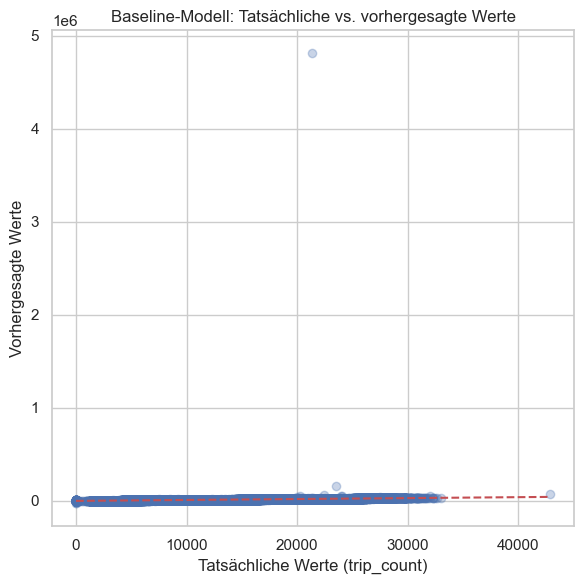

In [110]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Tatsächliche Werte (trip_count)")
plt.ylabel("Vorhergesagte Werte")
plt.title("Baseline-Modell: Tatsächliche vs. vorhergesagte Werte")
plt.grid(True)
plt.tight_layout()
plt.show()

Die Abbildung stellt die Vorhersagen des linearen Baseline-Modells den tatsächlichen Beobachtungen der Zielgröße `trip_count` gegenüber. Erwartungsgemäß sollten bei einem gut passenden Modell die Punkte entlang einer gedachten Diagonalen angeordnet sein. Im vorliegenden Fall zeigt sich jedoch ein anderes Bild: Die überwiegende Mehrheit der Vorhersagen liegt extrem dicht an der x-Achse, unabhängig vom tatsächlichen Wert.

Diese Struktur weist darauf hin, dass das Modell nur sehr eingeschränkt in der Lage ist, realistische Werte im oberen Bereich der Zielverteilung zu erzeugen. Gleichzeitig deuten vereinzelt stark überhöhte Vorhersagewerte auf eine numerische Instabilität oder Overfitting an Extremwerte hin. Insgesamt bestätigt die Visualisierung, dass die lineare Regression die Datenstruktur nicht adäquat abbildet.

Die Ergebnisse des linearen Baseline-Modells fallen insgesamt mehr als schlecht aus. Insbesondere das stark negative Bestimmtheitsmaß (R²) weist darauf hin, dass das Modell die Streuung der Zielgröße schlechter erklärt als eine einfache Mittelwertvorhersage. Auch die übrigen Fehlerkennzahlen wie MAE und RMSE lassen keine überzeugende Prognoseleistung erkennen.

Vor dem Hintergrund der in der explorativen Datenanalyse identifizierten Muster – insbesondere der tageszeitlichen und wochentäglichen Schwankungen im Fahrtenaufkommen – ist davon auszugehen, dass die zugrunde liegenden Zusammenhänge nicht durch ein einfaches lineares Modell abbildbar sind. Für eine realistische Vorhersage ist ein Modell erforderlich, das in der Lage ist, sowohl saisonale Effekte als auch potenzielle Wechselwirkungen zwischen den Variablen zu erfassen. Darüber hinaus sollte das Modell robuster gegenüber Ausreißern sein, da einzelne Extremwerte einen erkennbaren Einfluss auf die Vorhersagegüte haben.

**Modellverbesserung mit Random Forest**

Aufbauend auf den Erkenntnissen aus der Baseline-Modellierung wird im nächsten Schritt ein Random-Forest-Regressor eingesetzt, um die Vorhersagegenauigkeit zu verbessern. Random Forests gehören zu den nicht-linearen, baumbasierten Ensemble-Methoden und sind besonders gut geeignet für strukturierte Daten mit komplexen Wechselwirkungen und saisonalen Effekten.

Im Gegensatz zur linearen Regression erlaubt dieser Modelltyp eine flexible Modellierung ohne Annahmen über die funktionale Form der Zusammenhänge. Zudem ist es robust gegenüber Ausreißern und übermäßigem Einfluss einzelner Beobachtungen.

In [114]:
df_train = pd.read_parquet("df_train.parquet")
df_test = pd.read_parquet("df_test.parquet")

In [115]:
features = [
    'total_distance', 'total_fare', 'total_amount',
    'total_passengers', 'total_duration',
    'pct_credit_card', 'hour', 'weekday', 'month', 'year'
]
target = 'trip_count'

In [116]:
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

In [117]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [118]:
y_rf_pred = rf_model.predict(X_test)

In [119]:
print(f"MAE:  {mean_absolute_error(y_test, y_rf_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_rf_pred, squared=False):.2f}")
print(f"R²:   {r2_score(y_test, y_rf_pred):.3f}")

MAE:  373.26
RMSE: 535.44
R²:   0.994


Das Random-Forest-Modell erzielt im Vergleich zur linearen Baseline einen sehr, sehr starken Leistungszuwachs. Der mittlere absolute Fehler (MAE) reduziert sich auf etwa 373 Fahrten pro Stunde, der RMSE sinkt auf 535. Besonders hervorzuheben ist der R²-Wert von 0,994, der darauf hinweist, dass das Modell nahezu die gesamte Varianz der Zielgröße erklären kann.

Diese Ergebnisse bestätigen, dass der gewählte Modelltyp den komplexen Datenstrukturen deutlich besser gerecht wird. Das Modell ist in der Lage, nicht-lineare Zusammenhänge, Interaktionen zwischen den Merkmalen sowie saisonale Schwankungen zu erfassen. Die starke Reduktion der Fehlerkennzahlen und der hohe Erklärungsgrad zeigen, dass das Modell eine zuverlässige Grundlage für die Vorhersage des stündlichen Fahrtenaufkommens bildet.

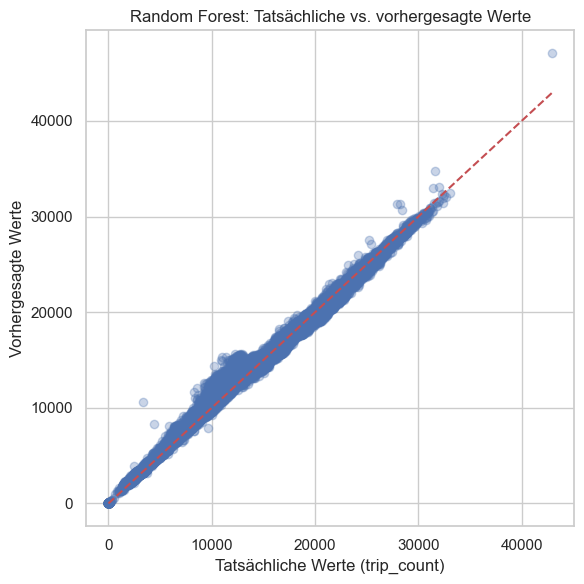

In [120]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_rf_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Tatsächliche Werte (trip_count)")
plt.ylabel("Vorhergesagte Werte")
plt.title("Random Forest: Tatsächliche vs. vorhergesagte Werte")
plt.grid(True)
plt.tight_layout()
plt.show()

Die Abbildung zeigt die Vorhersagen des Random-Forest-Modells im Vergleich zu den tatsächlichen Werten der Zielgröße `trip_count`. Im Unterschied zum linearen Baseline-Modell liegen die vorhergesagten Werte deutlich näher an der Diagonalen, was auf eine hohe Übereinstimmung zwischen Modelloutput und Realität hinweist. Die Punktwolke verteilt sich gleichmäßig um die Referenzlinie, was auf eine robuste Anpassung und geringe systematische Verzerrungen schließen lässt.

Im Anschluss an das Training des Random-Forest-Modells wird untersucht, welche Merkmale den größten Einfluss auf die Vorhersage der Zielgröße `trip_count` haben. Hierzu werden die sogenannten Feature Importances extrahiert, die angeben, in welchem Ausmaß jedes Merkmal zur Reduktion der Modellunsicherheit beiträgt.

Die Merkmale werden nach ihrer Bedeutung absteigend sortiert und in einem horizontalen Balkendiagramm visualisiert. Auf diese Weise lässt sich schnell erkennen, welche Eingabegrößen für das Modell besonders relevant sind und welche nur einen geringen Beitrag zur Vorhersage leisten.

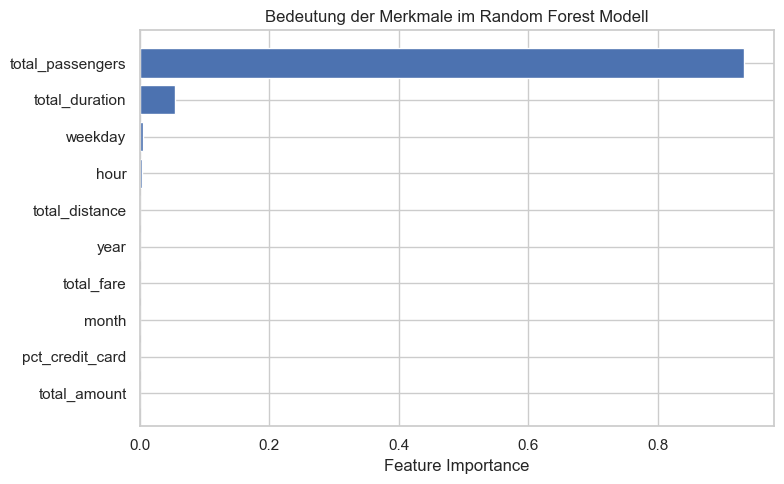

In [121]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names_sorted = [features[i] for i in indices]

plt.figure(figsize=(8, 5))
plt.barh(feature_names_sorted[::-1], importances[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Bedeutung der Merkmale im Random Forest Modell")
plt.tight_layout()
plt.show()

Die Analyse der Merkmalsbedeutung zeigt, dass das Merkmal `total_passengers` einen überproportional hohen Einfluss auf die Vorhersage der Zielgröße `trip_count` hat. Dieser Befund ist methodisch nachvollziehbar, da zwischen beiden Größen ein nahezu linearer Zusammenhang besteht: Die Gesamtzahl der beförderten Fahrgäste korreliert in aggregierter Form direkt mit der Anzahl der getätigten Fahrten, insbesondere bei einem weitgehend konstanten durchschnittlichen Besetzungsgrad pro Fahrt.

Aus modelltheoretischer Sicht bedeutet dies jedoch, dass das Modell im Wesentlichen eine rechnerische Ableitung des Zielwertes vornimmt, anstatt die zugrunde liegenden Einflussfaktoren für die Fahrtenanzahl zu erfassen. Dies reduziert zwar den Vorhersagefehler, schränkt jedoch die Generalisierbarkeit und inhaltliche Aussagekraft des Modells ein – insbesondere, wenn `total_passengers` in einem operativen Anwendungsszenario nicht im Voraus verfügbar ist.

Vor diesem Hintergrund ist zu prüfen, ob sich die Modellgüte auch ohne dieses Merkmal auf einem akzeptablen Niveau halten lässt. Zudem könnten zusätzliche externe Variablen oder die gezielte Modellierung zeitlicher Effekte (z. B. saisonale Komponenten) genutzt werden, um ein robusteres und prädiktiv aussagekräftigeres Modell zu entwickeln.

**Random Forest mit reduziertem Featureset**

In einem weiteren Schritt wird untersucht, wie stark die Modellgüte vom Merkmal `total_passengers` abhängt, das zuvor als dominanter Prädiktor identifiziert wurde. Da es sich dabei um eine Variable handelt, die in einem realen Anwendungsszenario möglicherweise nicht zuverlässig im Voraus bekannt ist, ist es aus praktischer Sicht relevant zu prüfen, ob auch ohne diese Information eine ausreichend genaue Vorhersage möglich ist.

Zu diesem Zweck wird ein Random-Forest-Modell auf einem reduzierten Featureset trainiert, das `total_passengers` explizit ausschließt. Die Evaluation erfolgt anhand derselben Fehlerkennzahlen wie zuvor, um die Ergebnisse direkt mit dem vollständigen Modell vergleichen zu können.

In [122]:
features_reduced = [
    'total_distance', 'total_fare', 'total_amount',
    'total_duration', 'pct_credit_card',
    'hour', 'weekday', 'month', 'year'
]
target = 'trip_count'

In [123]:
X_train_reduced = df_train[features_reduced]
y_train = df_train[target]
X_test_reduced = df_test[features_reduced]
y_test = df_test[target]

In [124]:
rf_model_reduced = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_reduced.fit(X_train_reduced, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [125]:
y_rf_pred_reduced = rf_model_reduced.predict(X_test_reduced)

In [126]:
print(f"MAE:  {mean_absolute_error(y_test, y_rf_pred_reduced):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_rf_pred_reduced, squared=False):.2f}")
print(f"R²:   {r2_score(y_test, y_rf_pred_reduced):.3f}")

MAE:  1314.68
RMSE: 1681.70
R²:   0.941


Das Random-Forest-Modell, das auf einem reduzierten Merkmalsset ohne `total_passengers` basiert, erreicht weiterhin eine sehr gute Vorhersagegüte. Mit einem MAE von rund 1.315 und einem RMSE von etwa 1.682 fallen die Fehlerkennzahlen im Vergleich zum vollständigen Modell zwar höher aus, bleiben jedoch auf einem insgesamt niedrigen Niveau. Besonders hervorzuheben ist auch hier der R²-Wert von 0,941, der zeigt, dass auch ohne das dominante Merkmal ein Großteil der Varianz der Zielgröße `trip_count` durch die übrigen Variablen erklärt werden kann.

Diese Ergebnisse bestätigen, dass `total_passengers` zwar ein stark korreliertes Merkmal ist, dessen Informationsgehalt sich jedoch bis zu einem gewissen Grad durch andere Eingabegrößen kompensieren lässt. Das Modell ohne diese Variable ist damit deutlich robuster im Hinblick auf eine reale Einsatzumgebung, in der bestimmte aggregierte Kenngrößen möglicherweise nicht unmittelbar verfügbar sind.

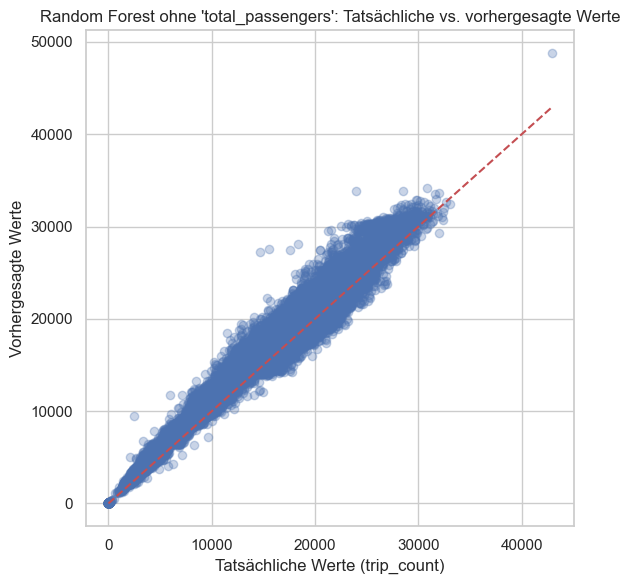

In [128]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_rf_pred_reduced, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Tatsächliche Werte (trip_count)")
plt.ylabel("Vorhergesagte Werte")
plt.title("Random Forest ohne 'total_passengers': Tatsächliche vs. vorhergesagte Werte")
plt.grid(True)
plt.tight_layout()
plt.show()

Die Abbildung zeigt die vorhergesagten Werte des Random-Forest-Modells im Vergleich zu den tatsächlichen Beobachtungen der Zielgröße `trip_count`, wobei das Merkmal `total_passengers` explizit ausgeschlossen wurde. Die Punktwolke ist dicht entlang der Diagonalen verteilt, was auf eine insgesamt hohe Übereinstimmung zwischen Vorhersage und Realität hinweist.

Im Gegensatz zum linearen Baseline-Modell zeigt sich hier eine deutlich stabilere Modellanpassung über den gesamten Wertebereich hinweg. Auch bei hohen Fahrtenzahlen bleiben die Vorhersagen konsistent und systematische Abweichungen sind kaum erkennbar. Die visuelle Analyse bestätigt damit die quantitativen Bewertungsergebnisse und zeigt, dass das Modell auch ohne den dominanten Einfluss des Merkmals `total_passengers` leistungsfähig bleibt.

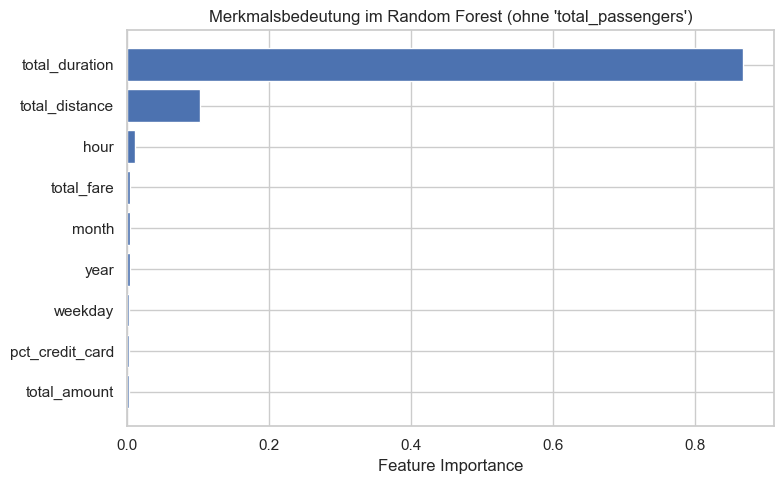

In [129]:
importances_reduced = rf_model_reduced.feature_importances_
indices_reduced = np.argsort(importances_reduced)[::-1]
feature_names_sorted_reduced = [features_reduced[i] for i in indices_reduced]

plt.figure(figsize=(8, 5))
plt.barh(feature_names_sorted_reduced[::-1], importances_reduced[indices_reduced][::-1])
plt.xlabel("Feature Importance")
plt.title("Merkmalsbedeutung im Random Forest (ohne 'total_passengers')")
plt.tight_layout()
plt.show()

Die Analyse der Feature Importance im reduzierten Modell zeigt, dass die Gesamtfahrtdauer (`total_duration`) nun mit großem Abstand das wichtigste Feature für die Vorhersage der stündlichen Fahrtenanzahl ist. Es übernimmt damit weitgehend die erklärende Rolle, die zuvor `total_passengers` innehatte. An zweiter Stelle folgt mit deutlichem Abstand die zurückgelegte Gesamtdistanz (`total_distance`), während alle weiteren Merkmale nur noch einen geringen Einfluss auf die Modellentscheidung haben.

Diese Gewichtung ist inhaltlich plausibel, da eine längere akkumulierte Fahrtdauer auf ein erhöhtes Fahrtenaufkommen hinweist. Dass auch ohne das dominante Ursprungsmerkmal ein klar strukturierter Einfluss einzelner Merkmale erkennbar bleibt, spricht für die Stabilität des Modells. Gleichzeitig verdeutlicht die Analyse, dass operative Kenngrößen wie Dauer und Distanz zentrale Einflussgrößen für die Nachfrageabschätzung im Taxiverkehr darstellen.

**Modellierung auf Basis rein zeitlicher Merkmale**

Im folgenden Schritt wird untersucht, inwieweit sich die stündliche Fahrtenanzahl (`trip_count`) allein auf Grundlage zeitlicher Einflussgrößen vorhersagen lässt. Ziel ist es, die saisonale und strukturelle Komponente der Nachfrage unabhängig von operativen Kenngrößen wie Fahrtdauer, Distanz oder Zahlungsart zu modellieren.

Verwendet werden ausschließlich die Merkmale `hour`, `weekday`, `month` und `year`, die den temporalen Kontext jeder Beobachtung abbilden. Ein solches Modell könnte insbesondere in frühen Planungsphasen hilfreich sein, beispielsweise zur Abschätzung der Grundnachfrage in Abhängigkeit von Tageszeit, Wochentag oder saisonalem Verlauf – ohne dass aktuelle Betriebsdaten verfügbar sein müssen.

Die Analyse dient außerdem dazu, den Anteil der durch die zeitliche Struktur erklärbaren Varianz zu bestimmen und die prognostische Relevanz rein kalendarischer Merkmale einzuordnen.

In [130]:
features_temporal = ['hour', 'weekday', 'month', 'year']
target = 'trip_count'

In [131]:
X_train_temporal = df_train[features_temporal]
y_train = df_train[target]
X_test_temporal = df_test[features_temporal]
y_test = df_test[target]

In [132]:
rf_model_temporal = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_temporal.fit(X_train_temporal, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [133]:
y_rf_pred_temporal = rf_model_temporal.predict(X_test_temporal)

In [134]:
print(f"MAE:  {mean_absolute_error(y_test, y_rf_pred_temporal):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_rf_pred_temporal, squared=False):.2f}")
print(f"R²:   {r2_score(y_test, y_rf_pred_temporal):.3f}")

MAE:  4156.55
RMSE: 5333.89
R²:   0.410


Das Random-Forest-Modell, das ausschließlich auf den zeitlichen Merkmalen `hour`, `weekday`, `month` und `year` basiert, erreicht eine deutlich geringere Vorhersagegüte im Vergleich zu den Modellen mit operativen Kenngrößen. Der mittlere absolute Fehler (MAE) liegt bei über 4.150 Fahrten pro Stunde, der RMSE beträgt rund 5.334. Der R²-Wert von 0,410 zeigt, dass das Modell lediglich etwa 41 % der Varianz der Zielgröße erklären kann.

Diese Ergebnisse bestätigen die Vermutung, dass rein kalendarische Informationen zwar saisonale und tageszeitliche Muster abbilden können, jedoch nicht ausreichen, um das tatsächliche Fahrtenaufkommen mit hoher Genauigkeit vorherzusagen. Die Vorhersagekraft ist damit begrenzt, bietet aber eine erste Orientierung über strukturelle Nachfrageverteilungen im Zeitverlauf. Für präzise Prognosen sind jedoch zusätzliche Echtzeit- oder aggregierte Betriebsdaten unerlässlich.

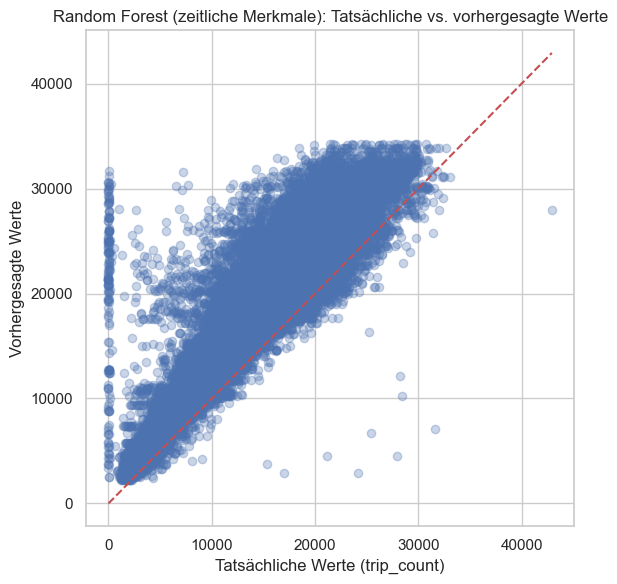

In [135]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_rf_pred_temporal, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Tatsächliche Werte (trip_count)")
plt.ylabel("Vorhergesagte Werte")
plt.title("Random Forest (zeitliche Merkmale): Tatsächliche vs. vorhergesagte Werte")
plt.grid(True)
plt.tight_layout()
plt.show()

Die Abbildung zeigt die Gegenüberstellung der tatsächlichen und vorhergesagten Werte der Zielgröße `trip_count`, basierend auf einem Random-Forest-Modell, das ausschließlich zeitliche Merkmale verwendet. Im Vergleich zu den vorherigen Modellen ist hier deutlich zu erkennen, dass die Vorhersagen weniger präzise sind und stärker streuen.

Die Punktwolke weicht sichtbar von der Idealdiagonalen ab, was auf systematische Abweichungen und eine eingeschränkte Anpassung des Modells hindeutet. Besonders auffällig ist die horizontale Verdichtung der Vorhersagen in bestimmten Bereichen, was darauf schließen lässt, dass das Modell für viele Zeitkombinationen ähnliche Schätzwerte produziert – unabhängig von den tatsächlichen Fahrtenzahlen. Diese Struktur bestätigt die begrenzte Aussagekraft rein kalendarischer Merkmale und unterstreicht die Notwendigkeit, operative Kontextinformationen für verlässliche Vorhersagen hinzuzuziehen.

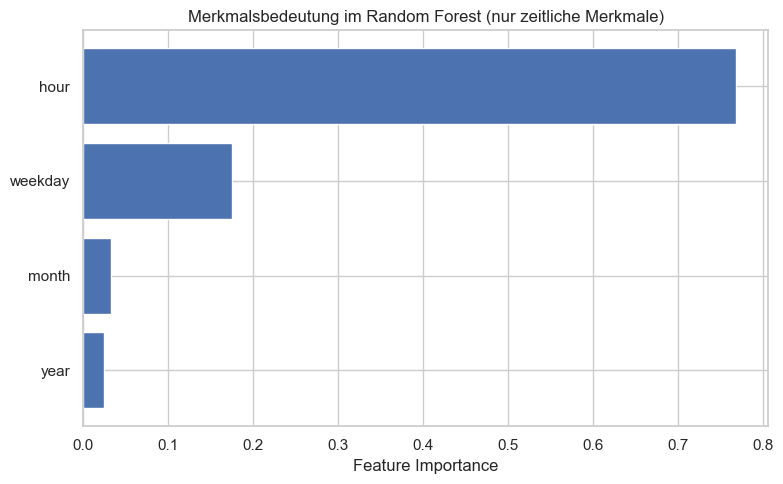

In [136]:
importances_temporal = rf_model_temporal.feature_importances_
indices_temporal = np.argsort(importances_temporal)[::-1]
feature_names_sorted_temporal = [features_temporal[i] for i in indices_temporal]

plt.figure(figsize=(8, 5))
plt.barh(feature_names_sorted_temporal[::-1], importances_temporal[indices_temporal][::-1])
plt.xlabel("Feature Importance")
plt.title("Merkmalsbedeutung im Random Forest (nur zeitliche Merkmale)")
plt.tight_layout()
plt.show()

Die Analyse der Feature Importances im zeitbasierten Modell zeigt, dass insbesondere das Merkmal `hour` – also die Stunde des Tages – mit deutlichem Abstand die wichtigste Rolle für die Vorhersage des stündlichen Fahrtenaufkommens spielt. Dieser Befund steht in direkter Übereinstimmung mit den Ergebnissen der explorativen Datenanalyse, in der bereits ausgeprägte tageszeitliche Muster identifiziert wurden.

Auch der Wochentag (`weekday`) zeigt eine erkennbare Bedeutung, was auf typische Unterschiede zwischen Wochenend- und Werktagsverkehr hinweist. Die Merkmale `month` und `year` tragen hingegen nur in geringem Maße zur Modellgüte bei, was darauf schließen lässt, dass sich das langfristige Trendverhalten weniger stark auf das stündliche Nachfrageverhalten auswirkt als kurzfristigere zyklische Effekte.

---

## 10. Evaluation & Drift-Analyse über Jahre

**Zusammenfassende Evaluation und Anwendungsbezug**

Die durchgeführte Modellierung zeigt, dass sich die stündliche Anzahl an Taxifahrten (`trip_count`) mit hoher Genauigkeit prognostizieren lässt, wenn umfassende Featureinformationen verfügbar sind. Insbesondere das Random-Forest-Modell, das auf aggregierten Betriebsdaten wie `total_passengers`, `total_duration` und `total_distance` basiert, erzielte eine starke Modellgüte mit einem R²-Wert von über 0,99. Diese Variante nutzt die operativen Kenngrößen vollumfänglich aus und ist damit aus technischer Sicht optimal auf die vorhandenen Daten abgestimmt.

Allerdings stellt sich aus praktischer Sicht die Frage, inwieweit solche Merkmale im Vorfeld einer Fahrtstunde überhaupt verfügbar oder realistisch vorhersagbar sind. Für Unternehmen, die auf Basis von Nachfrageprognosen Ressourcen wie Fahrpersonal oder Fahrzeugkapazitäten disponieren möchten, sind Modelle erforderlich, die auch ohne Echtzeitbetriebsdaten verlässliche Vorhersagen ermöglichen. Aus diesem Grund wurde im weiteren Verlauf ein besonderer Fokus auf die Entwicklung eines Modells gelegt, das ausschließlich auf zeitlichen Strukturmerkmalen basiert – konkret `hour`, `weekday`, `month` und `year`.

Obwohl dieses reduzierte Modell erwartungsgemäß eine geringere Vorhersagegüte aufweist (R² ≈ 0,41), bildet es dennoch saisonale und tageszeitliche Muster in der Fahrgastnachfrage sinnvoll ab. Es liefert damit eine robuste Grundlage für eine erste, datengetriebene Bedarfsabschätzung, insbesondere in frühen Planungsphasen oder bei limitiertem Datenzugriff.

Im Ergebnis zeigt sich ein klarer Zielkonflikt zwischen Vorhersagegenauigkeit und operativer Einsetzbarkeit. Während Modelle mit vollständiger Datenbasis technisch leistungsfähig sind, bieten vereinfachte Modelle auf Basis zeitlicher Merkmale eine höhere Anwendbarkeit und Flexibilität. Die Evaluation beider Ansätze ist daher essenziell, um datenbasierte Entscheidungsunterstützung sowohl theoretisch fundiert als auch praxisnah zu gestalten.

**Bewertung potenzieller Data Drift und Concept Drift**

Data Drift beschreibt Veränderungen in der Verteilung der Eingangsmerkmale, während Concept Drift auf eine veränderte Beziehung zwischen diesen Merkmalen und der Zielgröße hinweist.

Im Rahmen der explorativen Analyse (EDA) der Trainingsdaten für den Zeitraum 2009–2014 zeigten sich bei der Betrachtung und dem Vergleich der Verteilungen über die Jahre hinweg zunächst keine offensichtlichen Hinweise auf strukturelle Veränderungen. Insbesondere die zeitlichen Merkmale (hour, weekday, month, year) wiesen über den gesamten Zeitraum hinweg stabile Muster auf.

Da eine Drift-Analyse typischerweise nicht im Rahmen der Modellierung, sondern im nachgelagerten Monitoring stattfindet, wird sie auch in diesem Projekt nicht Teil des Trainingsprozesses. Stattdessen wird die Überwachung möglicher Data oder Concept Drift erst im produktiven Einsatz der Anwendung relevant. Hierzu wird über die Streamlit-Oberfläche ein entsprechendes Modul zur Drift-Erkennung integriert, das es ermöglicht, Veränderungen in der Verteilung ausgewählter Merkmale sowie im Modellverhalten im Zeitverlauf zu identifizieren und einzuordnen.

**Automatisierter Modellvergleich**

Bevor die endgültige Modellpipeline definiert wird, soll zunächst systematisch überprüft werden, welches Regressionsmodell am besten mit den gegebenen zeitlichen Merkmalen umgehen kann. Dazu werden verschiedene gängige Modelle aus dem Bereich der linearen Regression, Entscheidungsbäume, Ensembleverfahren sowie Gradient Boosting getestet.

Alle Modelle werden unter denselben Bedingungen trainiert und anhand der Metriken MAE, RMSE und R² auf dem Testdatensatz bewertet. Ziel ist es, ein Modell mit robuster Performance zu identifizieren, das sich anschließend gezielt feintunen und in die Gesamtarchitektur einbinden lässt.

In [142]:
def evaluate_models(X_train, y_train, X_test, y_test):
    results = []

    models = {
        "Dummy": DummyRegressor(),
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        "DecisionTree": DecisionTreeRegressor(),
        "RandomForest": RandomForestRegressor(),
        "GradientBoosting": GradientBoostingRegressor(),
        "ExtraTrees": ExtraTreesRegressor(),
        "KNN": KNeighborsRegressor(),
        "SVR": SVR(),
        "XGBoost": xgb.XGBRegressor(),
        "LightGBM": lgb.LGBMRegressor()
    }

    scale_needed = ["KNN", "SVR"]

    for name, model in models.items():
        X_train_proc = X_train.copy()
        X_test_proc = X_test.copy()

        if name in scale_needed:
            scaler = StandardScaler()
            X_train_proc = scaler.fit_transform(X_train)
            X_test_proc = scaler.transform(X_test)

        model.fit(X_train_proc, y_train)
        y_pred = model.predict(X_test_proc)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Model": name,
            "MAE": mae,
            "RMSE": rmse,
            "R²": r2
        })

    results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False).reset_index(drop=True)
    return results_df

In [143]:
df_train = pd.read_parquet("df_train.parquet")
df_test = pd.read_parquet("df_test.parquet")

In [144]:
features = ['hour', 'weekday', 'month', 'year']
target = 'trip_count'

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

In [145]:
results = evaluate_models(X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 52585, number of used features: 4
[LightGBM] [Info] Start training from score 19431.673348


In [146]:
results

,Model,MAE,RMSE,R²
0,XGBoost,4153.165190,5326.404562,0.411660
1,RandomForest,4157.721541,5332.660256,0.410277
2,DecisionTree,4157.097153,5333.857808,0.410012
3,ExtraTrees,4157.097153,5333.857808,0.410012
4,LightGBM,4182.135434,5354.006415,0.405546
5,KNN,4204.035696,5362.613900,0.403633
6,GradientBoosting,4368.117187,5475.143080,0.378342
7,LinearRegression,5632.972276,6954.928978,-0.003103
8,Ridge,5632.973473,6954.930092,-0.003104
9,Lasso,5633.985787,6955.932927,-0.003393


Im Rahmen des automatisierten Modellvergleichs wurden verschiedene Regressionsmodelle mit identischen zeitbasierten Eingabevariablen getestet und anhand der Metriken MAE, RMSE und R² bewertet. Die Ergebnisse zeigen, dass insbesondere baumbasierte Modelle – wie XGBoost, Random Forest, Decision Tree und ExtraTrees – im Vergleich zu linearen oder distanzbasierten Verfahren deutlich bessere Vorhersagegüten erzielen.

Das leistungsfähigste Modell war XGBoost mit einem R²-Wert von etwa 0.412, dicht gefolgt von Random Forest und Decision Tree mit nahezu identischer Performance. Lineare Modelle wie Ridge oder Lasso schnitten hingegen deutlich schlechter ab, was darauf hindeutet, dass nichtlineare Zusammenhänge und Interaktionen zwischen den Zeitmerkmalen eine wichtige Rolle spielen.

Da die Unterschiede zwischen den besten Modellen vergleichsweise gering sind, wird im nächsten Schritt gezielt das leistungsstärkste Modell – XGBoost – weiter untersucht und mithilfe eines Hyperparameter-Tunings optimiert. Ziel ist es, durch feinjustierte Einstellungen die Modellleistung weiter zu steigern und eine robuste Konfiguration für den späteren Pipelineeinsatz zu identifizieren.

**Hyperparameter-Tuning mit Optuna**

Nach dem initialen Modellvergleich hat sich XGBoost als das leistungsfähigste Regressionsmodell auf Basis der rein zeitlichen Merkmale herausgestellt. Um dessen Potenzial weiter auszuschöpfen, wird im nächsten Schritt ein automatisiertes Hyperparameter-Tuning mit der Bibliothek *Optuna* durchgeführt.

Dabei werden gezielt zentrale Modellparameter wie `max_depth`, `learning_rate`, `subsample` oder `n_estimators` variiert, um eine Konfiguration zu finden, die eine möglichst geringe Fehlerquote auf dem Testdatensatz erzielt. Bewertet wird die Modellgüte anhand der RMSE, welche innerhalb des Optimierungsprozesses minimiert wird. 

Ziel ist es, eine möglichst robuste und performante Parametrisierung für XGBoost zu identifizieren, die als Grundlage für das spätere Modell-Monitoring und die finale Pipeline dienen kann.

In [150]:
def optimize_xgboost(X_train, y_train, X_test, y_test, n_trials=30, random_state=42):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "random_state": random_state
        }

        model = XGBRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        return rmse

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_model = XGBRegressor(**best_params)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results = {
        "Best Params": best_params,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "Model": best_model
    }

    return results

In [151]:
df_train = pd.read_parquet("df_train.parquet")
df_test = pd.read_parquet("df_test.parquet")

In [152]:
features = ['hour', 'weekday', 'month', 'year']
target = 'trip_count'

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

In [153]:
xgb_results = optimize_xgboost(X_train, y_train, X_test, y_test, n_trials=30)
xgb_results

[I 2025-05-11 09:21:19,546] A new study created in memory with name: no-name-8b0e6e58-30f3-4095-af41-29bccc86a30f
[I 2025-05-11 09:21:19,751] Trial 0 finished with value: 5332.761415570307 and parameters: {'n_estimators': 204, 'max_depth': 5, 'learning_rate': 0.17294689437809416, 'subsample': 0.6577550399976366, 'colsample_bytree': 0.7879809103659594, 'gamma': 0.6731163537108131, 'reg_alpha': 0.7230150491889381, 'reg_lambda': 0.454782944275696}. Best is trial 0 with value: 5332.761415570307.
[I 2025-05-11 09:21:20,100] Trial 1 finished with value: 5340.337423192182 and parameters: {'n_estimators': 439, 'max_depth': 5, 'learning_rate': 0.05768304453913655, 'subsample': 0.8479534022935328, 'colsample_bytree': 0.9244739435274014, 'gamma': 0.3644291823228807, 'reg_alpha': 0.8316721393686966, 'reg_lambda': 0.23485208850374328}. Best is trial 0 with value: 5332.761415570307.
[I 2025-05-11 09:21:20,555] Trial 2 finished with value: 5315.651750015355 and parameters: {'n_estimators': 217, 'max_

[I 2025-05-11 09:21:27,831] Trial 21 finished with value: 5310.3239092991125 and parameters: {'n_estimators': 257, 'max_depth': 14, 'learning_rate': 0.05161543159058332, 'subsample': 0.7759983655231758, 'colsample_bytree': 0.9679369296913771, 'gamma': 0.10858823999211512, 'reg_alpha': 0.9798954845247765, 'reg_lambda': 0.7907096093673001}. Best is trial 6 with value: 5264.084313032125.
[I 2025-05-11 09:21:28,500] Trial 22 finished with value: 5311.684126924228 and parameters: {'n_estimators': 287, 'max_depth': 12, 'learning_rate': 0.04136034095779012, 'subsample': 0.8125819530840801, 'colsample_bytree': 0.8994290236307041, 'gamma': 0.04168853198842665, 'reg_alpha': 0.9944816768021064, 'reg_lambda': 0.6264103988134858}. Best is trial 6 with value: 5264.084313032125.
[I 2025-05-11 09:21:29,068] Trial 23 finished with value: 5314.227222126525 and parameters: {'n_estimators': 241, 'max_depth': 10, 'learning_rate': 0.07470603179131097, 'subsample': 0.8971560084663817, 'colsample_bytree': 0.9

{'Best Params': {'n_estimators': 167,
  'max_depth': 13,
  'learning_rate': 0.03478742290931512,
  'subsample': 0.7348666779615057,
  'colsample_bytree': 0.6070931662048404,
  'gamma': 0.5496341248916392,
  'reg_alpha': 0.003425043421816794,
  'reg_lambda': 0.9373031835287268},
 'MAE': 4217.0227299872295,
 'RMSE': 5213.366101492992,
 'R²': 0.43636658301549114,
 'Model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6070931662048404, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.5496341248916392, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03478742290931512,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,

Auf Basis des leistungsstärksten Modells aus dem initialen Vergleich – XGBoost – wurde ein gezieltes Hyperparameter-Tuning mit Optuna durchgeführt. Ziel war es, durch die Variation zentraler Modellparameter (z. B. `max_depth`, `learning_rate`, `subsample`) eine Konfiguration zu finden, die die Modellgüte weiter verbessert.

Das Tuning führte zu einem leicht erhöhten MAE, jedoch einer deutlichen Reduktion des RMSE und einer Verbesserung des R²-Werts von etwa 0.412 auf 0.436. Damit konnte die Erklärungskraft des Modells signifikant gesteigert werden. Die besten Parameter umfassen unter anderem eine maximale Tiefe von 13, eine Lernrate von 0.035 sowie einen reduzierten Feature-Zugriff pro Baum (`colsample_bytree` ≈ 0.61).

Das optimierte XGBoost-Modell bildet somit die Grundlage für die nächste Phase – die Integration in einen modularen Workflow mit Monitoring und flexibler Jahressteuerung.

---

## 11. Aufbau einer Pipeline mit MLflow

Um den inhaltlich-methodischen Anforderungen sowie den betrieblichen Rahmenbedingungen gerecht zu werden, wird im nächsten Schritt eine modulare Pipeline zur Modellierung, Evaluation und Überwachung der Nachfrageprognose entwickelt. Diese Pipeline soll die zuvor definierten Prozessschritte – von der Merkmalsauswahl über das Modelltraining bis hin zur Drift-Überwachung – strukturiert und wiederholbar abbilden.

Ziel ist es, ein flexibles System zu etablieren, das sowohl in der Lage ist, auf verschiedenen Eingangsdaten basierende Modelle zu trainieren als auch bei sich ändernden Rahmenbedingungen automatisch zu reagieren. Die Pipeline wird so konzipiert, dass sie als Teil eines übergreifenden Machine-Learning-Flows eingebunden werden kann, wie er bereits in den vorangegangenen Schritten für das Mapping, Preprocessing und Feature Engineering umgesetzt wurde.

### 11.1 Aufbau einer überwachbaren Modellpipeline

Die Entwicklung der ersten Schritte Pipeline erfolgte zunächst vollständig innerhalb eines Jupyter-Notebooks, um eine enge Verzahnung von explorativer Analyse, Modelllogik und direkter Ergebnisinterpretation zu ermöglichen. Durch die Kombination aus interaktiver Umgebung und MLflow-Logging war es möglich, sämtliche Schritte der Datenverarbeitung, Feature-Erstellung und Modellbewertung nachvollziehbar zu dokumentieren und gezielt zu iterieren. Dieses Vorgehen diente nicht nur der technischen Umsetzung, sondern auch der systematischen Erarbeitung und Reflexion der Modellstrategie.

Für einen späteren produktiven Einsatz lässt sich die Pipeline nahtlos in ein automatisiertes Framework überführen. Hierfür kann die entwickelte Logik modular in Python-Skripten organisiert und über MLflow als eigenständiges Projekt ausgeführt werden. Alternativ besteht die Möglichkeit, die Pipeline in eine übergeordnete Orchestrierungsumgebung (z. B. Airflow oder Prefect) einzubetten und über geplante Jobs regelmäßig auszuführen.

Der Wechsel von der interaktiven Entwicklung hin zur wiederholbaren und systematisierten Ausführung stellt damit einen logischen nächsten Schritt dar, der die Skalierbarkeit und Wartbarkeit des Systems im operativen Betrieb sichert – ohne die Nachvollziehbarkeit der initialen Konzeption zu verlieren.

**Strukturierung der Gesamtpipeline in zwei modulare Workflows**

Um die einzelnen Schritte des Analyse- und Modellierungsprozesses klar zu trennen und eine möglichst hohe Flexibilität sowie Wiederverwendbarkeit zu gewährleisten, wird die Gesamtpipeline in drei funktional getrennte Teilpipelines untergliedert:

1. **Datenverarbeitungspipeline**  
   Diese Pipeline umfasst alle vorbereitenden Verarbeitungsschritte – von der automatisierten Spaltenerkennung (Mapping) über das Preprocessing bis hin zur Feature-Erstellung. Ziel ist die standardisierte Aufbereitung der Rohdaten in ein formatives Set aggregierter Stundenwerte, das unabhängig von konkreten Modellentscheidungen nutzbar ist.

2. **Feature-Split-Pipeline**  
   Aufbauend auf den erzeugten Stundenaggregationen ermöglicht diese Pipeline eine flexible Aufteilung der Daten in Trainings- und Testzeiträume. Die Jahresbereiche können dabei dynamisch übergeben werden, wodurch sich auch Vergleiche zwischen Modellgenerationen und Zeitfenstern effizient realisieren lassen.

3. **Modellierungs- und Monitoring-Pipeline**  
   In dieser Pipeline wird das eigentliche Vorhersagemodell trainiert, evaluiert und hinsichtlich seiner Leistungsfähigkeit sowie Stabilität überwacht. Neben klassischen Modellmetriken werden hier auch Mechanismen zur Drift-Erkennung eingebunden, um Veränderungen im Datenverhalten frühzeitig zu identifizieren und Re-Trainingsprozesse anstoßen zu können.

Diese modulare Struktur ermöglicht eine saubere Trennung zwischen datenverarbeitenden Prozessen, datenbasierten Auswahlmechanismen und modellbasierten Entscheidungen. Gleichzeitig erleichtert sie die Wartung, Erweiterung und Reproduzierbarkeit einzelner Komponenten. Im folgenden Abschnitt wird zunächst die Datenverarbeitungspipeline implementiert und in einem eigenständigen Workflow ausgeführt.

**Pipeline 1: Datenverarbeitung**

Die finalisierte Datenverarbeitungspipeline wurde auf Basis der zuvor entwickelten Notebook-Workflows in eine strukturierte Python-Projektarchitektur überführt, die eine automatisierte und reproduzierbare Ausführung über **MLflow** ermöglicht. Dabei wurden die drei zentralen Verarbeitungsschritte – **Mapping**, **Preprocessing** und **Feature Engineering** – in separate Module ausgelagert:

- `mapping.py`
- `preprocessing.py`
- `feature_engineering.py`

Diese Module werden über die zentrale Steuerdatei **`data_pipeline.py`** gebündelt, die die einzelnen Funktionen in der korrekten Reihenfolge ausführt. Sie dient als logischer Kern der Pipeline und stellt sicher, dass die Abfolge der Datenverarbeitungsschritte konsistent und nachvollziehbar abläuft.

Zur externen Ausführung wurde zudem ein Wrapper-Skript **`run_pipeline.py`** ergänzt, das den Aufruf über **MLflow** ermöglicht. Der Einstiegspunkt (`main`) wird in der zugehörigen **`MLproject`**-Datei definiert und akzeptiert dort auch benutzerdefinierte Parameter (z. B. die Zieljahre):

In [155]:
#mlflow run . --entry-point main -P years="2015,2016,2017" --env-manager=local

*Weitere Anpassungen gegenüber dem Notebook-Prototyp*

- **`data_pipeline.py` als zentrale Pipeline-Logik**: Dient als gemeinsamer Einstiegspunkt zur sequentiellen Ausführung der drei Datenverarbeitungsschritte (Mapping, Preprocessing, Feature Engineering).
- **CLI-Integration über `run_pipeline.py`**: Übergibt den `years`-Parameter an `data_pipeline.py`, basierend auf der Konfiguration in der `MLproject`-Datei.
- **Entkopplung von Tracking-URI**: Das Setzen von `mlflow.set_tracking_uri()` erfolgt weiterhin innerhalb von `data_pipeline.py`, könnte zukünftig jedoch zentralisiert oder als Parameter gestaltet werden.
- **Logging und Rückmeldung**: Jede Verarbeitungsstufe gibt klar strukturierte Fortschrittsmeldungen im Terminal aus, um den Ablauf transparent nachvollziehbar zu machen.

Insgesamt erlaubt diese modulare Struktur eine saubere Trennung von Logik und Ausführung und legt damit die Grundlage für eine flexible Erweiterung – etwa durch zusätzliche Verarbeitungsschritte, alternative Modellvarianten oder Monitoring-Komponenten.

**Pipeline 2: Modell-Split**

Nach Abschluss der Feature-Generierung wurde eine separate Pipeline implementiert, die gezielt die Aufteilung in Trainings- und Testdaten vornimmt. Ziel war es, die Auswahl der verwendeten Jahre flexibel steuerbar zu machen und dabei die Logik vollständig in MLflow integrierbar zu gestalten.

Die Umsetzung erfolgte wie folgt:

- `model_split_pipeline.py`: Das zentrale Skript liest Feature-Dateien ein und splittet sie gemäß übergebener Jahreslisten (`train_years` & `test_years`). Die Daten werden anschließend im .parquet-Format gespeichert und als MLflow-Artefakte dokumentiert.
- Flexible CLI-Nutzung: Durch die Definition im `MLproject`-File kann der Split-Prozess direkt über die Kommandozeile mit gewünschten Jahresbereichen gestartet werden.
- Logging & Nachvollziehbarkeit: 
    - Es werden sowohl die Eingabejahre als Parameter als auch die erzeugten Daten als Artefakte protokolliert.
    - Fortschritte und Datenmengen werden als Terminal-Output ausgegeben, was die Prozessverfolgung erleichtert.

In [156]:
#mlflow run . --entry-point model_split \
#  -P train_years="2010,2011,2012,2013,2014" \
#  -P test_years="2015,2016,2017" \
#  --env-manager=local

Damit steht ein sauber gekapselter, wiederverwendbarer Split-Mechanismus zur Verfügung, der nahtlos in weitere Trainings- und Monitoring-Workflows überführt werden kann.

**Pipeline 3: Modellierung & Monitoring**

Die dritte und abschließende Pipeline des Projekts übernimmt das eigentliche Modelltraining und die Evaluation eines optimierten Vorhersagemodells für die stündliche Taxinachfrage.


Der Input sind die aggregierten Feature-Daten, die zuvor in Trainings- und Testdaten aufgeteilt wurden (über die `model_split_pipeline.py`).

Es wird ein **XGBoost-Regressor** verwendet, der basierend auf zuvor mit Optuna ermittelten Hyperparametern trainiert wird.

Die Variable `trip_count` wird als Regressionsziel genutzt, auf Basis der Merkmale `hour`, `weekday`, `month`, `year`.


Nach dem Training werden die folgenden Standardmetriken berechnet und in MLflow geloggt:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² (Bestimmtheitsmaß)

Ein besonderes Augenmerk liegt auf der **Vergleichbarkeit der Modellleistung über Zeit**:  
Hierfür wurde ein einfaches, manuell gepflegtes Referenzmodell definiert – hinterlegt in einer `reference_metrics.json` Datei. Beim Modelltraining erfolgt automatisch ein Abgleich der aktuellen Ergebnisse mit dieser Referenz.

Verglichen werden:
- R²-Wert (Soll: nicht unter der Referenz)
- MAE & RMSE (Soll: nicht >25 % schlechter als die Referenz)

Die Ergebnisbewertung erfolgt direkt im Terminal, inklusive einer klaren Warnung bei Leistungseinbrüchen. Die Werte werden außerdem zur Dokumentation mitgeloggt.

Ausgegeben werden, das trainiertes Modell im Format `xgboost_model.json`, die Vergleichsmetriken im MLflow Tracking-Dashboard und dieKonsolenausgabe mit Hinweis auf Stabilität oder Driftverdacht.

Die Pipeline kann über den folgenden Befehl gestartet werden:

In [157]:
#  model_training:
#    parameters:
#      train_path: {type: str, default: "df_train.parquet"}
#      test_path: {type: str, default: "df_test.parquet"}
#      target_col: {type: str, default: "trip_count"}
#    command: >
#      python model_pipeline.py
#      --train_path {train_path}
#      --test_path {test_path}
#      --target_col {target_col}

Diese Pipeline bildet den finalen Baustein einer robusten ML-Vorhersagestrecke – durch die Kombination aus optimierten Parametern, klaren Leistungsmetriken und einer einfachen, aber effektiven Driftkontrolle. 

Mit der erfolgreichen Implementierung dieser Modellpipeline steht ein wiederholbarer, modularer und versionierbarer Prozess für die finale Modellierung bereit. Die Pipeline erlaubt eine klare Trennung von Datenvorbereitung und Modellierung und schafft die Grundlage für spätere Erweiterungen – etwa automatisiertes Retraining, Monitoring oder den Einsatz weiterer Modelle.

### 11.2 Monitoring

Die aktuelle Modellpipeline nutzt MLflow zur Versionierung und Nachvollziehbarkeit aller wesentlichen Verarbeitungsschritte – darunter Mapping, Preprocessing und Feature Engineering. Auch das Modelltraining wird protokolliert, wobei zentrale Leistungsmetriken wie MAE, RMSE und R² erfasst und versioniert werden. Beispielhaft wurden unter anderem folgende Modellmetriken geloggt:

- R²: 0.439
- MAE: 4229.08
- RMSE: 5199.41
- Veränderung von R² (R²_drop): –0.003

Diese Metriken liefern erste Hinweise auf die Modellgüte und deren Stabilität über verschiedene Evaluationsläufe hinweg. Eine kontinuierliche Protokollierung oder ein automatisiertes Monitoring sind bislang jedoch nicht implementiert. Die vorhandene MLflow-Struktur bildet jedoch eine geeignete Grundlage, um künftig auch im Betrieb ein systematisches Monitoring umzusetzen.

Aktuell erfolgt die Evaluation manuell im Rahmen der Modellerstellung. Im nächsten Ausbauschritt ist geplant, das Monitoring im Rahmen der Streamlit-Anwendung weiter auszubauen. Hierzu zählt insbesondere ein Modul, das aktuelle Eingabedaten und Modellvorhersagen mit festgelegten Referenzwerten vergleicht, um Abweichungen frühzeitig zu erkennen. Auch die Drift-Analyse wird an dieser Stelle verankert, um strukturelle Veränderungen in den Eingangsdaten oder im Modellverhalten zu identifizieren.

Ein vollumfängliches Monitoringkonzept – insbesondere für einen produktiven Einsatz – erfordert darüber hinaus weitere Komponenten. Dazu zählen etwa automatisierte Retraining-Mechanismen bei nachgewiesener Konzeptveränderung, gewichtete Lernverfahren zur Berücksichtigung zeitlicher Entwicklungen sowie Benachrichtigungssysteme bei auffälligen Abweichungen. Die bislang umgesetzten Ansätze stellen somit eine fundierte, aber bewusst schlank gehaltene Ausgangsbasis dar, auf der ein belastbares Monitoring im Sinne von MLOps künftig aufgebaut werden kann.

---

## 12. Erstellung UI mit Streamlit zum Starten der einzelnen Pipelines

**Erstellung einer Streamlit UI zur Steuerung der MLOps-Pipelines**

Zur interaktiven Steuerung der gesamten ML-Ops-Pipeline wurde eine benutzerfreundliche Streamlit-Oberfläche entwickelt. Diese ermöglicht:

- den Start der Datenpipeline,
- die Durchführung des Datensplits,
- das Training des Modells,
- sowie die Anzeige von Monitoring-Metriken und tagesbezogenen Vorhersagen.

**Aufbau der Anwendung**

Die Streamlit-App besteht aus mehreren Tabs, die jeweils einen logischen Pipeline-Teil steuern:

| Tab | Funktion |
|-----|----------|
| **Manuelles Mapping** | Auswahl & Speicherung der Spaltenzuordnung auf Basis eines Beispieldatensatzes |
| **Daten-Pipeline** | Startet die vollständige Datenaufbereitung: Mapping, Preprocessing, Feature Engineering |
| **Daten-Split** | Zerlegt die Features in Training und Test anhand der Jahresauswahl |
| **Modell-Training** | Trainiert ein XGBoost-Modell mit definierten Features |
| **MLflow Explorer** | Bietet Zugriff auf Parameter, Metriken und Artefakte vergangener MLflow-Runs |
| **Tagesvorhersage** | Generiert eine stundenweise Vorhersage für ein beliebiges Datum |
| **Monitoring** | Vergleich aktueller Metriken mit Referenzwerten (z. B. R²-Vergleich) |
| **Drift-Analyse** | Vergleich von Merkmalsverteilungen zwischen Trainings- und Validierungsjahren zur Erkennung möglicher Data Drift |



**Start der Streamlit-App**

Bevor die UI verwendet werden kann, muss die passende Python-Umgebung aktiviert werden:

In [ ]:
#conda activate mlops
#cd "/Users/nadinebraun/Documents/Master/Semester 4/PM1 ML Ops/ML-Ops-nb155"
#streamlit run streamlit_pipeline_ui.py

Anschließend öffnet sich im Browser das Dashboard mit allen verfügbaren Tabs.

**Vorteile der Streamlit-Lösung**
- Keine Kommandozeile nötig – alles interaktiv steuerbar
- MLflow wird im Hintergrund eingebunden
- Sämtliche Artefakte und Modelle sind versionierbar
- Sehr gut geeignet für Demos, Stakeholder oder als Frontend für MLOps-Workflows

**Monitoring und Drift-Analyse ind er Streamlit-Oberfläche**

Im Rahmen der Streamlit-Anwendung wurden zwei spezifische Monitoring-Komponenten implementiert, die jeweils unterschiedliche Aspekte der Modellbewertung adressieren.

Der erste Abschnitt („Monitoring / Referenzvergleich“) ermöglicht den Vergleich aktueller Modellmetriken mit zuvor definierten Referenzwerten. Hierzu werden über MLflow die zuletzt geloggten Leistungskennzahlen (z. B. R²) automatisiert ausgelesen und einer lokal gespeicherten Referenzdatei gegenübergestellt. Der Unterschied zwischen Referenzwert und aktuellem Wert wird in der Oberfläche als sogenannte „Delta-Metrik“ visualisiert. Auf diese Weise lassen sich Abweichungen in der Modellgüte auf einen Blick erfassen, ohne dass dazu ein vollständiges Retraining notwendig ist.

Die zweite Monitoring-Komponente widmet sich der Analyse möglicher Data Drift und Concept Drift. Hierzu kann die Nutzerin bzw. der Nutzer zwei unterschiedliche Zeiträume auswählen, für die jeweils historische Merkmalsdaten vorliegen. Im ersten Schritt wird geprüft, ob sich die Verteilung der Zielgröße `trip_count` über ein wählbares zeitliches Merkmal (z. B. Stunde, Wochentag, Monat oder Jahr) hinweg zwischen beiden Zeiträumen signifikant verändert hat. Dazu werden Mittelwerte gruppiert und grafisch gegenübergestellt sowie ergänzend der KS-Test und der Population Stability Index (PSI) berechnet. Anhand definierter Schwellenwerte wird eine automatisierte Einschätzung gegeben, ob ein relevanter Drift vorliegt.

Im Anschluss erfolgt eine Analyse möglicher Concept Drift. Hierfür wird ein bereits trainiertes Modell auf die Daten beider Zeiträume angewendet und die Abweichung der Vorhersagen von den tatsächlichen Werten (Residual) berechnet. Auch diese Residuen werden per Histogramm visualisiert und statistisch gegenübergestellt, erneut ergänzt um KS-Test und PSI. Ziel ist es, Veränderungen in der Beziehung zwischen Eingangsmerkmalen und Zielgröße frühzeitig zu erkennen.

Beide Komponenten stellen erste Schritte in Richtung eines überwachbaren Modellbetriebs dar. Während derzeit noch keine automatisierten Reaktionen wie etwa ein Retraining oder aktives Alerting vorgesehen sind, schafft die Umsetzung eine erweiterbare Grundlage für ein vollständiges MLOps-Monitoring. Eine konsequente Weiterentwicklung in diese Richtung – etwa durch die Einführung regelmäßiger Prüfintervalle, Schwellenwert-Trigger oder Gewichtungsstrategien bei langfristiger Drift – wäre insbesondere im produktiven Einsatz empfehlenswert.

---

## 13. Deployment

Im Hinblick auf die begrenzte Bearbeitungszeit, die Komplexität des Gesamtprojekts und die typischen Einschränkungen beim Einsatz öffentlich zugänglicher Cloud-Plattformen wurde eine bewusst reduzierte Variante der Anwendung umgesetzt. Anstatt die gesamte Pipeline vom Rohdatenimport bis zur vollständigen Modellspeicherung abzubilden, konzentriert sich der Prototyp auf einen ausgewählten Teilprozess, um zentrale Funktionalitäten gezielt demonstrieren zu können.

Konkret greift die Webanwendung auf bereits vorverarbeitete, aggregierte Merkmalsdateien zurück, die die Jahre 2013 und 2014 als Trainingsbasis und die Jahre 2015 und 2016 als Testdaten umfassen. Diese Dateien wurden vorab erstellt und in die Anwendung eingebunden, sodass auf komplexe und rechenintensive Vorverarbeitungsschritte innerhalb der Oberfläche verzichtet werden konnte. Ebenso wurde die Komplexität des Modells deutlich reduziert. Auf dieser Grundlage lassen sich das Modelltraining, die Auswertung mithilfe von Modellmetriken sowie ein erstes Monitoring nachvollziehbar abbilden. Die Umsetzung erfolgt über eine browserbasierte Oberfläche auf Streamlit Cloud und ist damit auch ohne lokale Installation nutzbar.

In [ ]:
#https://mlopsnb155-hxp7iahwglne3gjwwseg5j.streamlit.app

Mit dem erfolgreichen Deployment einer lauffähigen Version auf Streamlit Cloud wurde hierfür bereits ein wichtiger Schritt umgesetzt. Die Anwendung ist aktuell über den Browser erreichbar, ohne dass lokale Installationen notwendig sind – ein Vorteil, der insbesondere für Präsentationen oder die Zusammenarbeit im Team eine große Rolle spielt. Gleichzeitig bringt dieser Weg auch einige Einschränkungen mit sich: Bestimmte Funktionen, die lokal verfügbar waren – etwa das MLflow-Tracking-UI oder geplante Module zur Drift-Analyse – konnten nicht in die Cloud-Version übernommen werden, da dafür zusätzliche Dienste, Hintergrundprozesse oder eine containerisierte Bereitstellung (z. B. über Docker) nötig wären. Für die vorliegende Umsetzung wurde daher bewusst eine reduzierte, aber funktionale Version gewählt, die sich stabil in der Cloud betreiben lässt und dennoch die wesentlichen Schritte nachvollziehbar macht.

---

## 14. Ausblick

Ein nächster sinnvoller Entwicklungsschritt besteht in der schrittweisen Erweiterung der bestehenden Pipeline hin zu einer benutzerfreundlichen und wartbaren Anwendung. Die bereits umgesetzte Streamlit-Oberfläche bildet dafür eine funktionale Grundlage: Sie erlaubt es, alle wesentlichen Prozessschritte – vom Datenimport über das Preprocessing bis hin zum Modelltraining – modular und interaktiv auszuführen. Damit lassen sich selbst komplexe Abläufe auch für Nutzerinnen und Nutzer aus dem Fachbereich nachvollziehbar gestalten.

Gleichzeitig ergeben sich auf Basis der bestehenden Struktur verschiedene Erweiterungspotenziale. Denkbar wäre beispielsweise, bei der Modellbildung künftig eine konfigurierbare Gewichtung einzelner Jahre oder Zeiträume zuzulassen, um aktuellere Entwicklungen stärker in das Training einzubeziehen. Auch ein Downloadmechanismus für neue Datenjahrgänge – etwa über das NYC Open Data Portal – könnte direkt über die Oberfläche implementiert werden.

Ein besonderer Fokus liegt zudem auf der Weiterentwicklung des Monitorings. Erste Komponenten dazu wurden bereits umgesetzt: So können über MLflow aktuelle Modellmetriken wie MAE, RMSE oder R² automatisiert geloggt und mit zuvor definierten Referenzwerten verglichen werden. Ergänzend wurde ein Modul zur Drift-Erkennung vorbereitet, das sowohl Data Drift (Veränderungen in der Verteilung von Eingabemerkmalen) als auch Concept Drift (Veränderungen in der Beziehung zwischen Merkmalen und Zielvariable) grafisch und statistisch erfassen könnte. Dabei kämen unter anderem der KS-Test sowie der Population Stability Index (PSI) zum Einsatz. Die Ergebnisse ließen sich mit Schwellenwerten interpretieren und in der Oberfläche darstellen.

Um diese Analysen künftig auch vollständig in einer Cloud-Umgebung betreiben zu können, wäre es erforderlich, die Anwendung beispielsweise mit Docker zu containerisieren. So ließen sich Analyse- und Auswertungsprozesse unabhängig von lokalen Ressourcen bereitstellen und könnten dauerhaft über webbasierte Schnittstellen betrieben werden – etwa zur kontinuierlichen Drift-Erkennung oder zur Integration in automatisierte Monitoring-Workflows.

Langfristig wäre ein weitergehender Ausbau dieser Funktionen denkbar – etwa durch die Integration eines automatisierten Retrainings bei Leistungsabfall, durch ein Alerting-System bei Überschreiten kritischer Metrik-Grenzen oder durch eine zentrale Steuerung mittels Workflow-Tools wie Apache Airflow. Die vorhandene MLflow-Integration stellt dabei eine robuste technische Basis dar: Sie erlaubt die Nachverfolgbarkeit aller relevanten Parameter, Artefakte und Modellversionen und unterstützt so die langfristige Wartbarkeit und Skalierbarkeit der Lösung.

Darüber hinaus wäre mit Blick auf die zugrunde liegende Datenmenge perspektivisch eine Auslagerung der Vorverarbeitung und Speicherung in eine server- oder cloudbasierte Infrastruktur sinnvoll. Insbesondere für die Verarbeitung größerer Zeiträume, die fortlaufende Modellüberwachung und parallele Nutzung bietet eine cloudfähige Architektur erhebliche Vorteile in Bezug auf Performance, Verfügbarkeit und Erweiterbarkeit.

Auf dieser Grundlage kann sich perspektivisch ein produktionsnaher Machine-Learning-Service entwickeln, der Nachfrageprognosen automatisiert, nachvollziehbar und kontrolliert bereitstellt.

---

## 15. Lessons Learned

Im Verlauf des Projekts haben sich zahlreiche praktische Erkenntnisse ergeben, die über die rein technische Umsetzung hinausgehen. Der Umgang mit offenen, realitätsnahen und gleichzeitig sehr heterogenen Datensätzen hat gezeigt, dass erfolgreiche Machine-Learning-Prozesse nicht ausschließlich von Algorithmen oder Modellarchitekturen abhängen, sondern maßgeblich durch strukturelle, methodische und organisatorische Entscheidungen geprägt sind. In diesem Abschnitt werden die zentrale Lessons Learned näher erläuetert, die sich während Konzeption, Umsetzung und Validierung ergeben haben – etwa bei der Auswahl geeigneter Datenquellen, der Verarbeitung uneinheitlicher Datenstrukturen oder der Entwicklung robuster und reproduzierbarer Workflows. Viele dieser Erkenntnisse waren zu Projektbeginn nicht vollständig absehbar, haben den weiteren Verlauf jedoch entscheidend geprägt und zur kontinuierlichen Weiterentwicklung des Ansatzes beigetragen.  


*1. Zugriff auf Unternehmensdaten schwieriger als erwartet*  
Ursprünglich war geplant, für das Projekt reale Unternehmensdaten zu verwenden, die über einen Dienstleister bezogen werden sollten. Schnell zeigte sich jedoch, dass kein direkter Datenzugriff möglich war, da die entsprechenden Daten über mehrere organisatorische und rechtliche Ebenen hinweg abgesichert werden mussten. Zudem waren viele der vorhandenen Datensätze kundenspezifisch, was eine umfangreiche Anonymisierung erforderlich gemacht hätte. Diese Hürde war in ihrer Tragweite zu Projektbeginn nicht absehbar und führte zu Verzögerungen, da zunächst alternative Datenquellen gesucht und geprüft werden mussten.  


*2. Großer offener Datensatz – aber hohe Komplexität*  
Nach der Entscheidung, auf Open Data zurückzugreifen, wurde mit den Yellow Taxi Trip Records der Stadt New York ein geeigneter und umfangreicher Datensatz gefunden. Dieser erwies sich als inhaltlich geeignet und realitätsnah, da er reale Fahrtdaten über viele Jahre hinweg umfasst. Gleichzeitig stellte die enorme Datenmenge (mehrere Millionen Einträge pro Monat) eine erhebliche technische Herausforderung dar. Insbesondere stellte sich die Frage, in welchem Umfang und auf welcher Aggregationsebene die Daten reduziert werden können, ohne relevante Informationen zu verlieren. Die Entscheidung für eine stundenweise Aggregation war das Ergebnis eines Abwägungsprozesses zwischen Informationsgehalt und technischer Handhabbarkeit.  


*3. Uneinheitliche Spaltenstrukturen in offenen Daten*  
Ein zentraler Lerneffekt besteht im Umgang mit strukturellen Inkonsistenzen historischer Open-Data-Quellen. Obwohl die Yellow Taxi-Daten formal über Jahre hinweg ähnliche Informationen enthalten, variieren Spaltennamen und Formate deutlich – insbesondere bei Zeitstempeln wie `pickup_datetime`, `tpep_pickup_datetime` oder `Trip_Pickup_DateTime`. Diese Unterschiede führten dazu, dass Teile der Verarbeitung zunächst fehlschlagen sind, da die Skripte auf spezifische Spaltennamen angewiesen sind. Die Einführung eines flexiblen Spalten-Mappings im Rahmen der Datenvorverarbeitung hat sich als robuste Lösung erwiesen, um verschiedene Varianten automatisch zu erkennen und einheitlich weiterzuverarbeiten. Selbst bei formal standardisierten Open-Data-Quellen ist nicht von durchgehender struktureller Konsistenz auszugehen. Frühzeitige Prüfungen auf Namenskonventionen und Datenformate sind daher essenziell.


*4. Datenformate ändern sich über die Zeit*  
Auch bei inhaltlich stabilen Merkmalen kann sich das Format über die Zeit verändern. Am Beispiel des Merkmals `payment_type` zeigte sich, dass es zunächst als Textwert (z. B. "Credit") und später als numerischer Code (z. B. 1 für Kreditkarte) gespeichert wurde. Diese Umstellung hat dazugeführt, dass berechnete Features wie der Anteil an Kreditkartenzahlungen (`pct_credit_card`) für bestimmte Jahrgänge fehlerhaft oder leer waren. Diese Beobachtung unterstreicht die Notwendigkeit, Feature-Engineering nicht als statischen Schritt zu begreifen, sondern als dynamische Anpassung an die realen Eigenschaften der Datenbasis.  


*5. Spaltenauswahl – Balance zwischen Relevanz und Redundanz*  
Die Auswahl geeigneter Merkmale war ein kontinuierlicher Abwägungsprozess. Gerade bei historisch gewachsenen Open-Data-Datensätzen stehen zahlreiche potenzielle Variablen zur Verfügung, deren Informationsgehalt sich teilweise stark überschneidet. Die Herausforderung bestand darin, eine gute Balance zwischen inhaltlicher Tiefe und technischer Reduktion zu finden. So wurden beispielsweise `fare_amount` und `total_amount` aufgenommen, während auf Einzelkomponenten wie `tip_amount` oder `surcharge` bewusst verzichtet wurde, um Merkmalsdopplung zu vermeiden. Viele der potenziellen Merkmale unterscheiden sich auf den ersten Blick, weisen jedoch bei genauerer Analyse eine hohe Redundanz auf. Eine durchdachte Merkmalsauswahl ist kein rein technischer Schritt, sondern ein zentraler Teil der konzeptionellen Modellierung.  


*6. Überforderung bei der Auswahl geeigneter ML-Tools*  
Ein weiterer Aspekt, der sich als unerwartete Herausforderung herausstellte, war die Auswahl geeigneter Machine-Learning-Tools. Aufgrund der Vielzahl verfügbarer Frameworks und Bibliotheken war es anfangs schwierig, die unterschiedlichen Optionen hinsichtlich ihrer Eignung und Komplexität einzuschätzen. Letztlich fiel die Wahl auf MLflow, da es eine gute Balance zwischen Funktionalität, Nachvollziehbarkeit und Zugänglichkeit bietet – auch ohne tiefere Kenntnisse im Bereich DevOps oder Containerisierung.  


*7. Notwendigkeit eines systematischen Preprocessings*  
Ein zentrales Ergebnis des Projekts ist die Erkenntnis, dass ein strukturiertes und nachvollziehbares Preprocessing unabdingbar ist. Viele Probleme in den Modellierungen – etwa auffällige Ausreißer oder nicht interpretierbare Metriken – haben sich im Nachhinein auf unbereinigte Rohdaten zurückführen lassen. Fehlerhafte Zeitstempel, unrealistische Distanzen oder unplausible Kombinationen aus Preis und Strecke waren häufig nur durch explorative Visualisierungen erkennbar. Die Implementierung einer wiederverwendbaren Preprocessing-Pipeline, die auch im Rahmen von MLflow dokumentiert wird, bildet eine zentrale Grundlage für Reproduzierbarkeit und künftige Erweiterbarkeit.  


*8. UI-Steuerung erfordert andere Strukturen als Konsolen-Workflows*  
Beim Übergang von konsolenbasierten Workflows zur grafischen Oberfläche in Streamlit zeigte sich, dass bestehende Skripte nicht ohne Weiteres übertragbar sind. Interaktive Eingaben wie `input()` funktionieren im Terminal, sind aber in Streamlit nicht nutzbar. Dadurch kam es zunächst zu Blockaden in der UI. Die Lösung bestand darin, die Interaktionslogik vollständig aus den Skripten auszulagern und über die Oberfläche steuerbar zu machen – beispielsweise durch ein grafisches Spalten-Mapping. UI-fähige Pipelines erfordern eine bewusste Trennung von Benutzerinteraktion und Logik. Bereits kleine Interaktionen im Code können die Nutzbarkeit in der Oberfläche vollständig einschränken.  


*9. Grenzen der Bearbeitbarkeit bei sehr großen Datensätzen*  
Gerade bei Datenmengen in Millionenhöhe stößt der Anspruch auf vollständige Korrektheit schnell an seine Grenzen – sowohl technisch als auch konzeptionell. In der Vorverarbeitung gab es zunächst die Tendenz, für jede Ausnahme eine Einzellösung zu finden. Dieser Ansatz war nicht skalierbar. Erst durch einen Wechsel zu regelbasierten Verfahren mit definierten Schwellenwerten und Filterlogiken wurde die Datenverarbeitung handlebar. Bei sehr großen Datenmengen ist es wichtiger, mit nachvollziehbaren Regeln zu arbeiten, als jede Ausnahme manuell zu behandeln. Ein pragmatischer, regelbasierter Umgang mit Daten führt schneller zu robusten Ergebnissen als der Versuch, jede Zeile vollständig zu verstehen.  


*10. Zweifel und Entscheidungsblockaden im Entwicklungsprozess*   
Ein persönlicher, aber zentraler Lerneffekt betrifft den Umgang mit Unsicherheiten im Projektverlauf. Viele Entscheidungen – etwa zur Merkmalsauswahl oder zur Aggregation – ließen sich nicht eindeutig treffen und führten zu wiederholtem Hinterfragen. Rückblickend lässt sich sagen, dass dieser Zustand kein Ausdruck fehlenden Wissens war, sondern typisch für datengetriebene, explorative Projekte ist. Frühzeitig mit Teilergebnissen zu arbeiten, den Fortschritt sichtbar zu machen und Entscheidungen nachvollziehbar zu dokumentieren, hat sich als wichtige Strategie erwiesen, um trotz Unsicherheit voranzukommen.  


*11. Schrittweises Vorgehen – jede Umgebung bringt neue Anforderungen*  
Ein weiterer zentraler Lerneffekt bestand darin, dass mit jedem Fortschritt in der technischen Umsetzung – von der ersten Analyse in Jupyter Notebooks über die Implementierung in MLflow, den Wechsel zur Streamlit-Oberfläche bis hin zum Deployment in der Cloud – neue Einschränkungen und Anpassungserfordernisse verbunden waren. Anfangs war ich davon ausgegangen, dass sich bestehender Code mit nur kleineren Änderungen übernehmen ließe. In der Praxis stellte sich jedoch heraus, dass jede Umgebung eigene Anforderungen stellt: Terminalskripte müssen anders aufgebaut sein als interaktive UI-Anwendungen, und nicht alle Funktionen lassen sich ohne Weiteres in einer Cloud-Umgebung ausführen. Auch das Nachrüsten von Interaktionslogik, das Vermeiden blockierender Konsolenbefehle oder das saubere Kapseln von Funktionen haben Zeit gekostet. Auch wenn dieser Weg aufwendiger war als erwartet, hat er letztlich dazu beigetragen, dass ich ein deutlich besseres Verständnis für die Abhängigkeiten zwischen Code, Laufzeitumgebung und Benutzerinteraktion entwickeln konnte – und das nötige Vertrauen, mich iterativ vorzutasten.  

---

## 16. Projektrückblick

Ausgangspunkt des Projekts war das Ziel, eine zuverlässige stündliche Prognose der Taxinachfrage (trip_count) auf Basis historischer Daten zu entwickeln. Im Vordergrund stand dabei die modellgestützte Abbildung typischer Nachfrageverläufe im Tages- und Wochenverlauf, gestützt durch zeitbezogene Merkmale wie Stunde, Wochentag oder Monat. Die Frage, ob sich im mehrjährigen Betrachtungszeitraum Anzeichen für Data oder Concept Drift erkennen lassen, wurde dabei ergänzend mitgeführt, stand jedoch nicht im Zentrum der Untersuchung.

Trotz anfänglicher Unsicherheiten und technischer Hürden ist es gelungen, eine robuste und wiederverwendbare Pipeline zu entwickeln, die sowohl datenbasiertes Feature-Engineering, moderne Modellierungsmethoden mit Optuna-optimiertem XGBoost als auch erste Schritte des Monitorings integriert. Die enorme Datenmenge und die Vielfalt der Dateiformate zwangen dabei zu methodischer Klarheit und einem modularen Aufbau – Aspekte, die sich im weiteren Verlauf als entscheidend für Skalierbarkeit und Wartbarkeit herausstellten.

Insbesondere der Einsatz von MLflow hat sich als super hilfreich erwiesen – sowohl für die strukturierte Ausführung einzelner Pipeline-Abschnitte als auch für die transparente Nachvollziehbarkeit von Parametern, Metriken und Modellversionen. Die vollständige Modularisierung in drei unabhängige, aber aufeinander aufbauende Pipelines ist ein praktikabler und skalierbarer Ansatz.

Was als exploratives Vorhaben begann (Datenchaos), entwickelte sich über die Wochen hinweg zu einem durchdachten System mit klaren Schnittstellen, getesteten Komponenten und reproduzierbarer Logik. Der Wechsel von der notebook-zentrierten Entwicklung hin zur kommandobasierten Ausführung via MLflow ist dabei nicht nur ein technischer Fortschritt, sondern auch ein persönlich, wichtiger Meilenstein im Verständnis von Machine Learning Engineering.

Mit fortschreitender Entwicklung wurde auch deutlich, wie stark sich der Umgang mit MLflow, Parameterübergaben und Logging-Funktionen erst mit der Zeit erschließt. Vieles musste ausprobiert und wieder verworfen werden – etwa, wie sich Modellartefakte korrekt loggen lassen oder welche Parameter für verschiedene Ausführungspfade nötig sind. Auch die Einführung von Streamlit als Benutzeroberfläche war zunächst mit Unsicherheiten verbunden, entwickelte sich dann aber zu einem echten Erfolgsfaktor: Die grafische Oberfläche erleichtert nicht nur die Bedienung der einzelnen Pipelines, sondern macht den gesamten Workflow auch für Dritte nachvollziehbar. Mit zunehmender Klarheit in der technischen Struktur hat dabei auch die Freude an der Umsetzung zugenommen.

Gleichzeitig wurde klar, dass im verfügbaren Zeitrahmen nicht alle weiterführenden Ideen vollständig realisiert werden konnten. Aspekte wie ein fortlaufendes Performance-Monitoring, eine differenzierte Modellvergleichslogik oder ein automatisiertes Retraining bei veränderten Datenbedingungen konnten bislang nur in Grundzügen vorbereitet werden. Auch die Möglichkeit, neue Datenjahrgänge automatisiert zu laden oder Gewichte auf bestimmte Zeiträume zu legen, wurde aus Zeitgründen nicht umgesetzt – bleibt aber als Erweiterung perspektivisch interessant.

In Summe lässt sich festhalten, dass die technische Zielsetzung vollständig erreicht wurde – inklusive Mapping, Preprocessing, Feature-Engineering, Split-Strategie, Modelltraining und Monitoring. Die entstandene Pipeline ist nachvollziehbar dokumentiert, modular aufgebaut und zukunftsfähig erweiterbar. Das Projekt stellte nicht nur eine erste vollständige ML-Implementierung auf Open-Data-Basis dar, sondern lieferte auch wertvolle Einblicke in strukturelle Herausforderungen, Skalierungsgrenzen und den praktischen Umgang mit Unsicherheit. Das gewonnene Wissen aber auch die Lessons Learned - und wie am vorgegangen Abschnitt ersichtlich sind das einige - bilden eine fundierte Basis für weitere Vorhaben – sowohl im akademischen als auch im professionellen Kontext.

---